In [1]:
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import sys

sys.path.append("/code")

from tqdm import tqdm
import torch
import time
# device = torch.device('cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# import gym
# import recogym

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

torch.backends.cudnn.benchmark = torch.cuda.is_available()
if torch.cuda.is_available():
    torch.set_float32_matmul_precision("high")  # TF32 = big speedup on Ada


from sklearn.utils import check_random_state

# implementing OPE of the IPWLearner using synthetic bandit data
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

from scipy.special import softmax
import optuna
# from memory_profiler import profile

from plots_and_stats import compute_statistics_and_plots, plot_calibration_and_rank_table

from estimators import (
    DirectMethod as DM
)

from simulation_utils import (
    eval_policy,
    generate_dataset,
    create_simulation_data_from_pi,
    get_train_data,
    get_opl_results_dict,
    CustomCFDataset,
    calc_reward,
    get_weights_info
)

from models import (    
    LinearCFModel,
    NeighborhoodModel,
    BPRModel, 
    RegressionModel
)

from training_utils import (
    train,
    validation_loop, 
    cv_score_model
 )


from trainer_trials_modular import (
    regression_trainer_trial,
    neighberhoodmodel_trainer_trial
)


random_state=12345
random_ = check_random_state(random_state)

pd.options.display.float_format = '{:,.8f}'.format

Using device: cuda
Using device: cuda
Using device: cuda


## Learning

We will run several simulations on a generated dataset, the dataset is generated like this:
$$ \text{We have users U and actions A } u_i \sim N(0, I_{emb_dim}) \ a_i \sim N(0, I_{emb_dim})$$
$$ p_{ij} = 1 / (5 + e^{-(u_i.T a_j)}) $$
$$r_{ij} \sim Bin(p_{ij})$$

We have a policy $\pi$
and it's ground truth reward is calculated by
$$R_{gt} = \sum_{i}{\sum_{j}{\pi_{ij} * p_{ij}}} $$

Our parameters for the dataset will be
$$EmbDim = 5$$
$$NumActions= 150$$
$$NumUsers = 150$$
$$NeighborhoodSize = 6$$

to learn a new policy from $\pi$ we will sample from:
$$\pi_{start} = (1-\epsilon)*\pi + \epsilon * \pi_{random}$$

In [2]:
cols = [
    
    'dr_naive_mean', 'dr_naive_ci_low', 'dr_naive_ci_high', 'dr_naive_se',
    'dr_boot_mean', 'dr_boot_std', 'dr_boot_ci_low', 'dr_boot_ci_high',
    'ipw_boot_mean', 'ipw_boot_std', 'ipw_boot_ci_low', 'ipw_boot_ci_high',

    'cv_rmse_uniform', 'cv_signed_rmse_uniform', 'cv_bias_uniform',
    'cv_bias_lb_signed_uniform', 'cv_rmse_exp', 'cv_signed_rmse_exp',
    'cv_bias_exp', 'cv_bias_lb_signed_exp', 'loss_uniform', 'loss_exp',
    'score_naive_minus_cv_uniform', 'score_naive_minus_cv_exp'
    ]

In [3]:
'Spearman Kendall-Tau'.split()

['Spearman', 'Kendall-Tau']

In [32]:
cols = ['dr_naive_mean', 'dr_naive_ci_low',
         'dr_boot_mean', 'dr_boot_ci_low',
         'dr_uni_mean', 'dr_uni_ci_low',
         'ipw_boot_mean', 'ipw_boot_ci_low',
         'ipw_uni_mean', 'ipw_uni_ci_low']

Plotting calibration for: dr_naive_mean


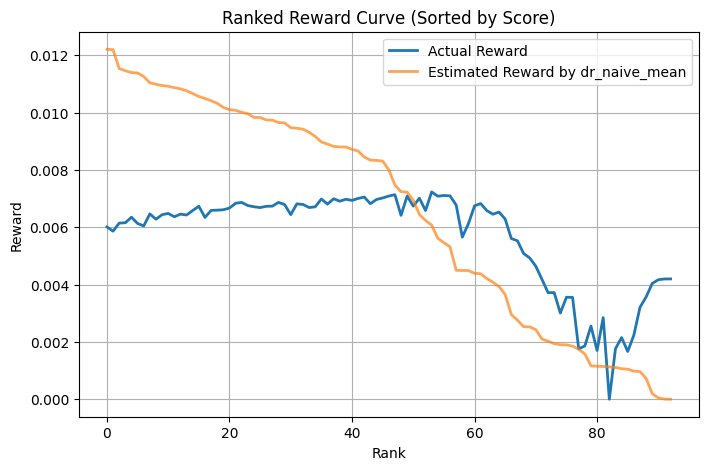

Plotting calibration for: dr_naive_ci_low


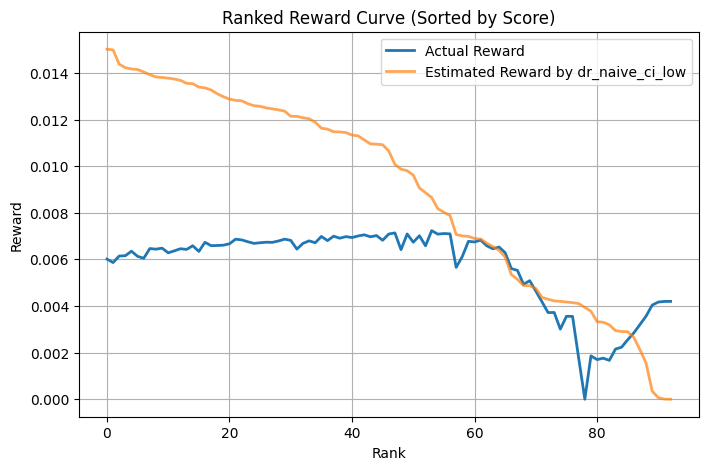

Plotting calibration for: dr_boot_mean


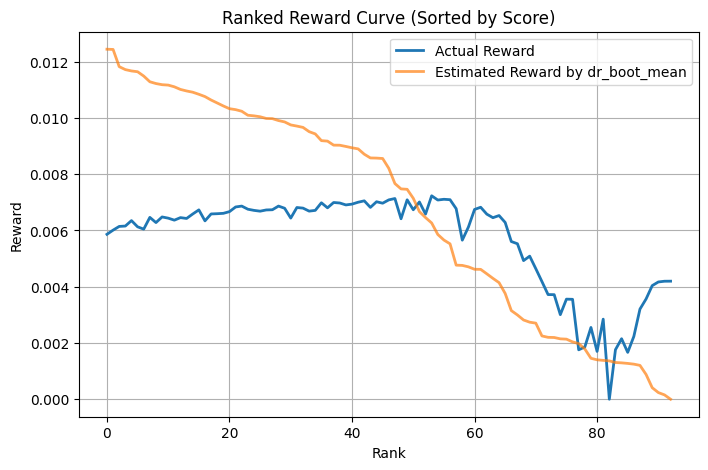

Plotting calibration for: dr_boot_ci_low


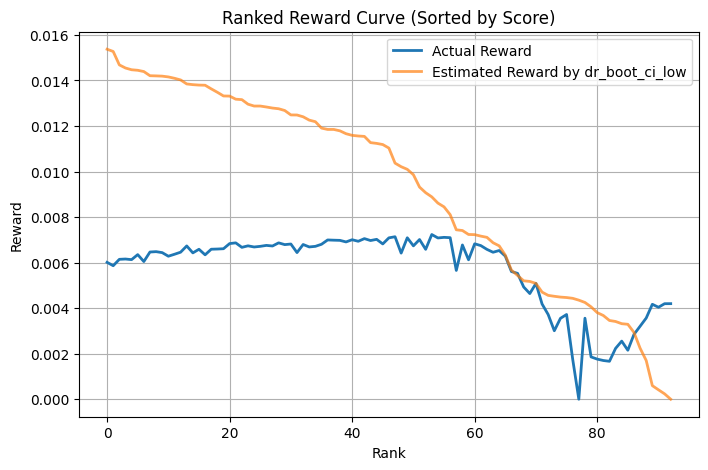

Plotting calibration for: dr_uni_mean


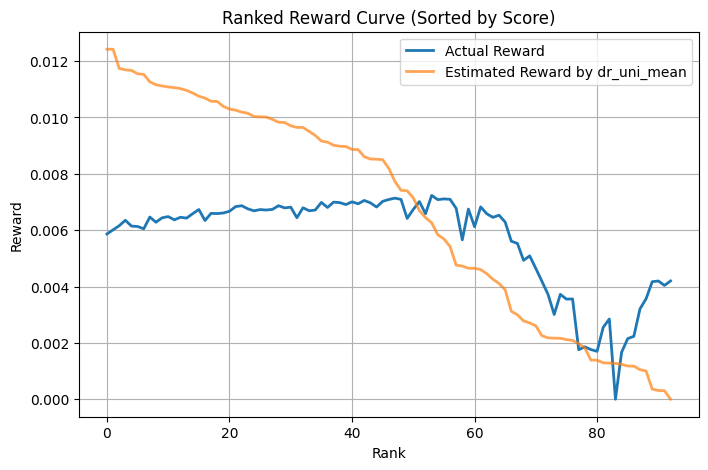

Plotting calibration for: dr_uni_ci_low


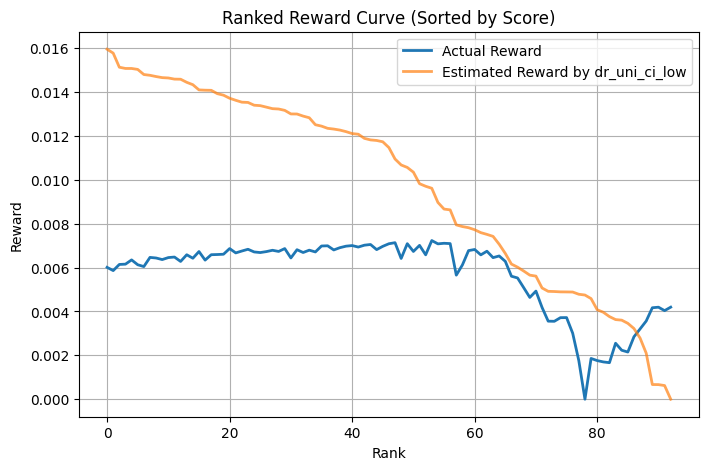

Plotting calibration for: ipw_boot_mean


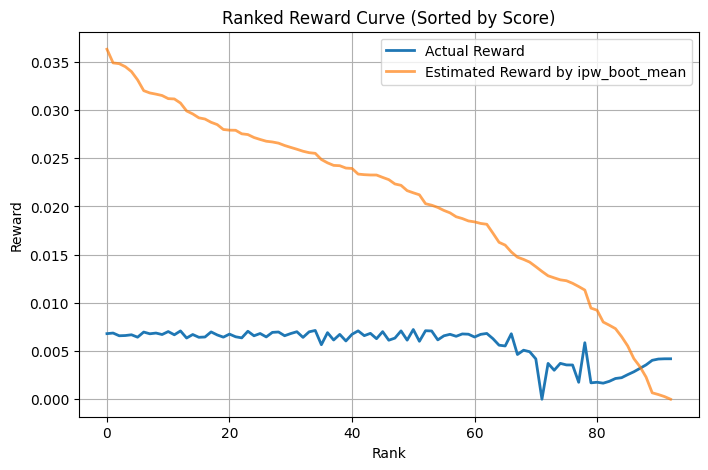

Plotting calibration for: ipw_boot_ci_low


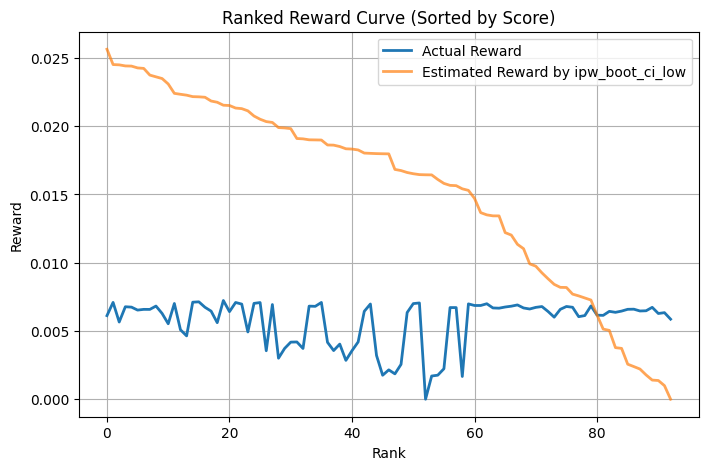

Plotting calibration for: ipw_uni_mean


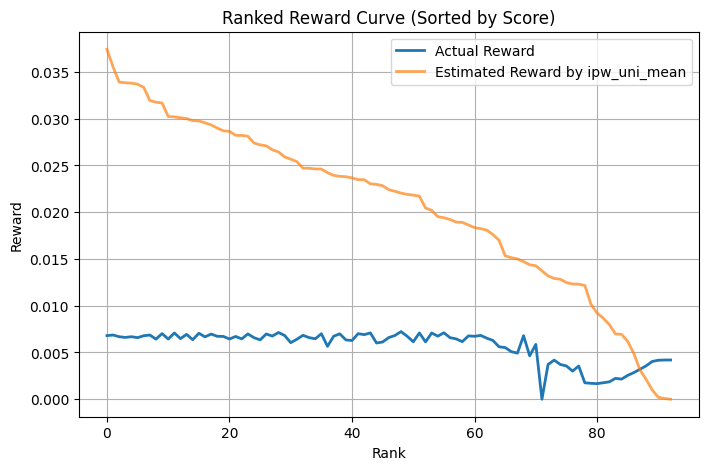

Plotting calibration for: ipw_uni_ci_low


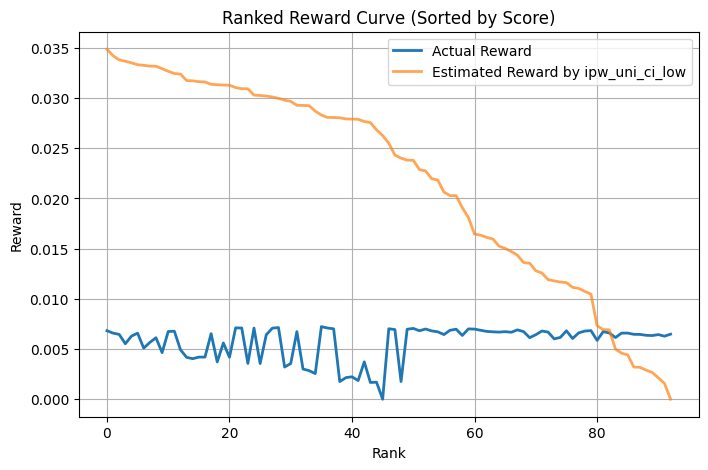

Num samples: 10000


Spearman-Rank Kendall-Tau
dr_naive_mean      0.45580556  0.22487144
dr_naive_ci_low    0.45404494  0.21832632
dr_boot_mean       0.45599952  0.22580645
dr_boot_ci_low     0.45573095  0.22159888
dr_uni_mean        0.45743189  0.22720898
dr_uni_ci_low      0.45459700  0.22159888
ipw_boot_mean      0.66106652  0.45208041
ipw_boot_ci_low    0.05150548  0.07900888
ipw_uni_mean       0.66160365  0.45956054
ipw_uni_ci_low    -0.18799797 -0.02618046

Plotting calibration for: dr_naive_mean


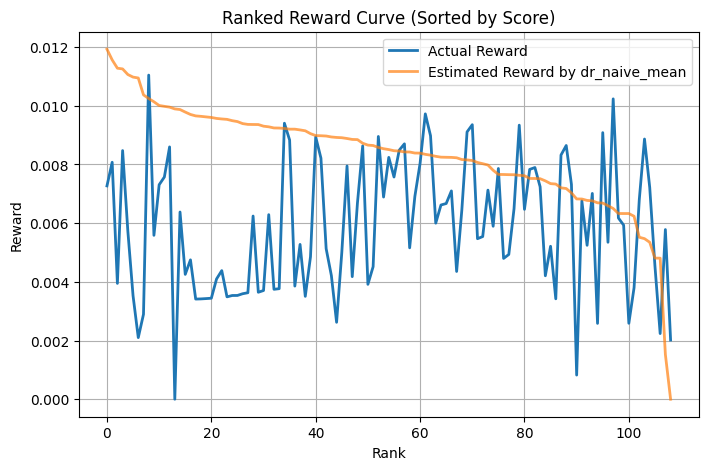

Plotting calibration for: dr_naive_ci_low


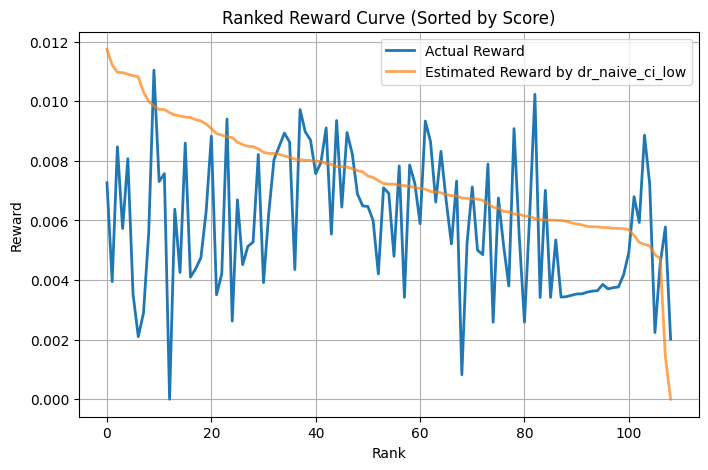

Plotting calibration for: dr_boot_mean


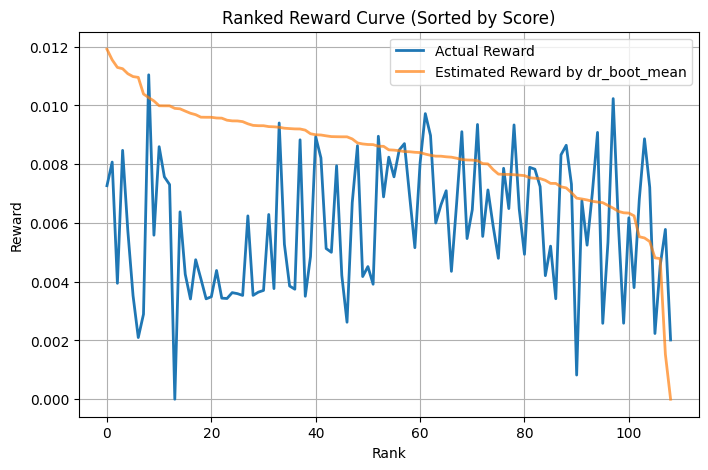

Plotting calibration for: dr_boot_ci_low


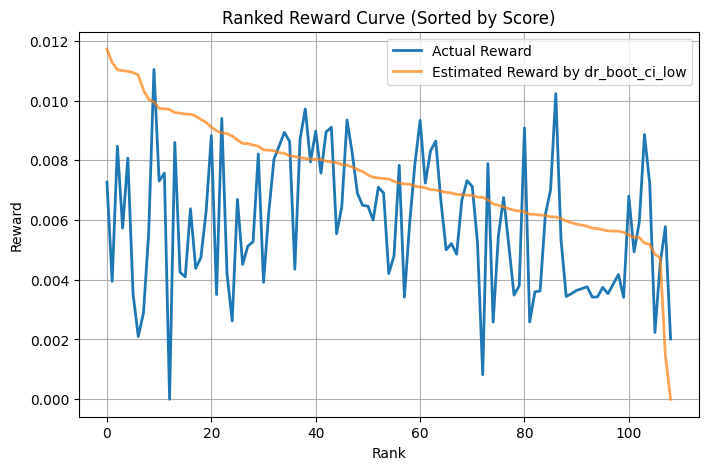

Plotting calibration for: dr_uni_mean


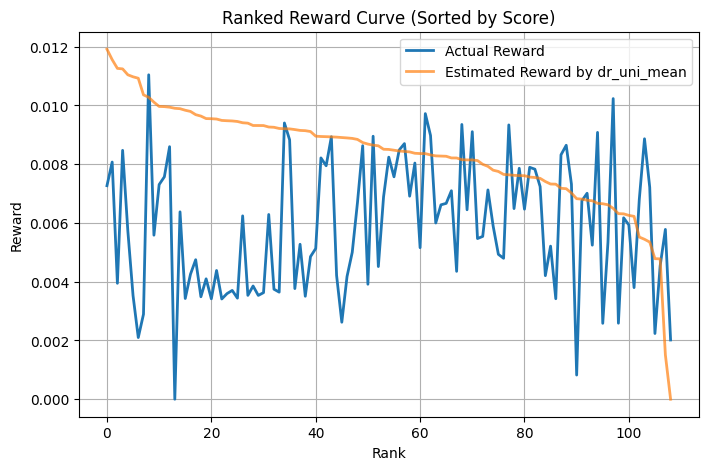

Plotting calibration for: dr_uni_ci_low


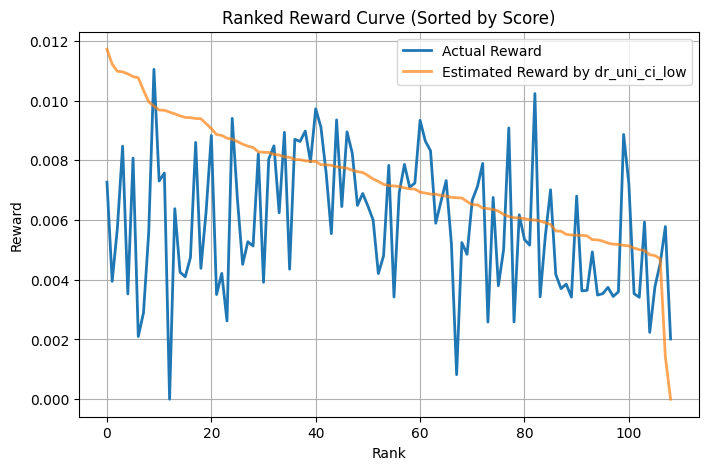

Plotting calibration for: ipw_boot_mean


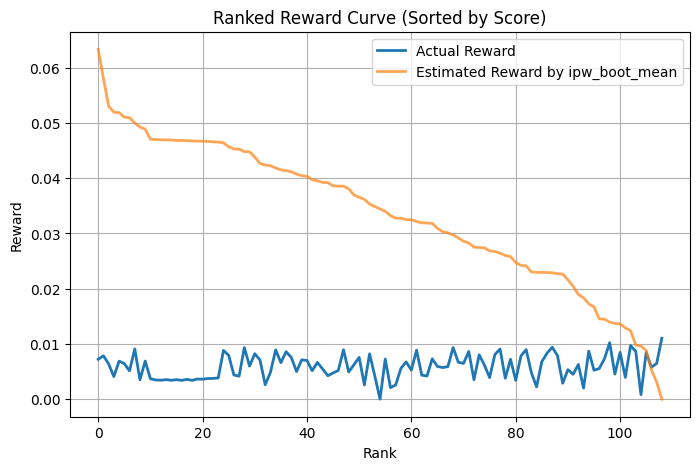

Plotting calibration for: ipw_boot_ci_low


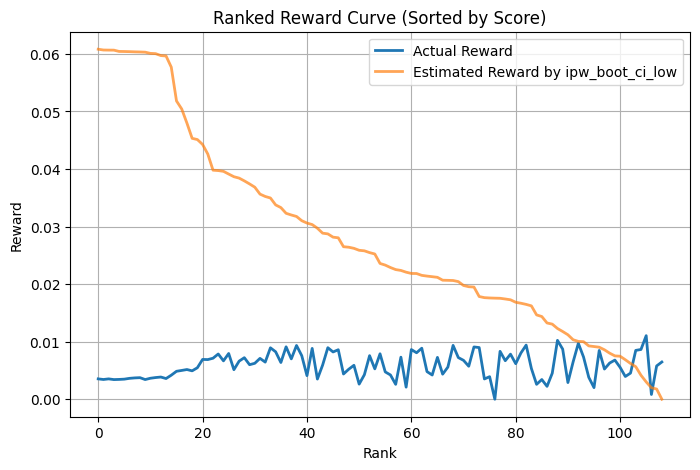

Plotting calibration for: ipw_uni_mean


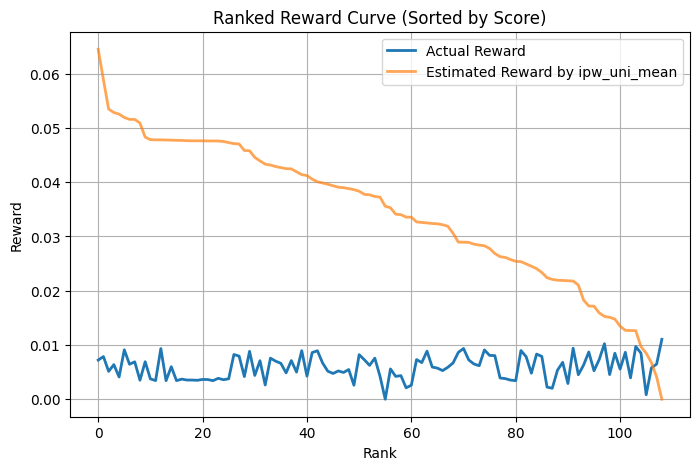

Plotting calibration for: ipw_uni_ci_low


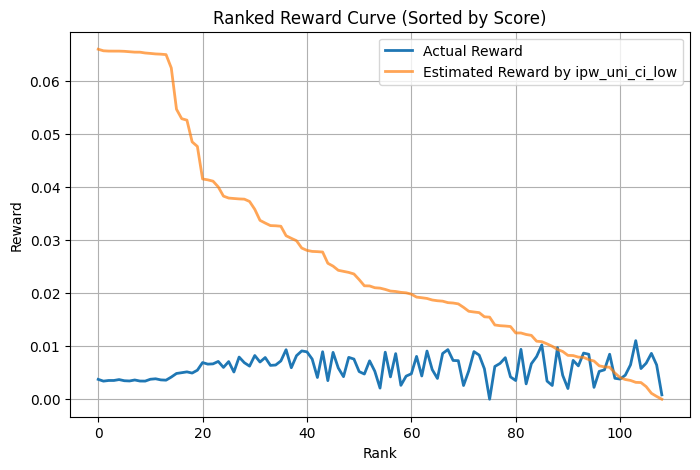

Num samples: 20000


Spearman-Rank Kendall-Tau
dr_naive_mean     -0.16967844 -0.13455657
dr_naive_ci_low    0.24186822  0.15154604
dr_boot_mean      -0.16528589 -0.12572205
dr_boot_ci_low     0.24062645  0.15970099
dr_uni_mean       -0.16647206 -0.12538226
dr_uni_ci_low      0.25299787  0.17804961
ipw_boot_mean     -0.22266704 -0.16004077
ipw_boot_ci_low   -0.21158373 -0.16819572
ipw_uni_mean      -0.20065796 -0.14441047
ipw_uni_ci_low    -0.19527384 -0.15902141

Plotting calibration for: dr_naive_mean


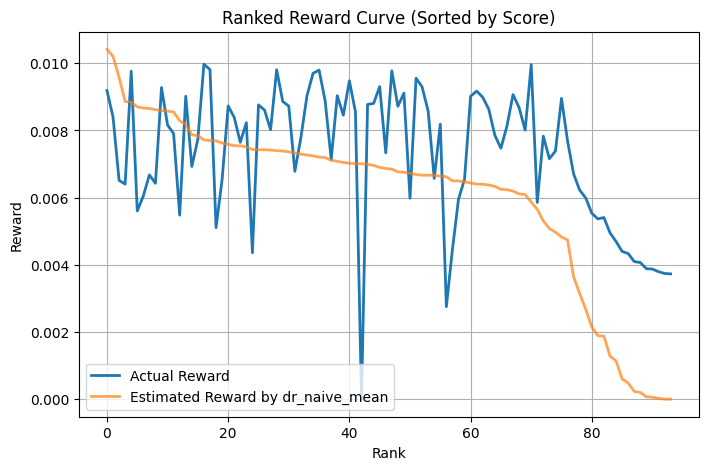

Plotting calibration for: dr_naive_ci_low


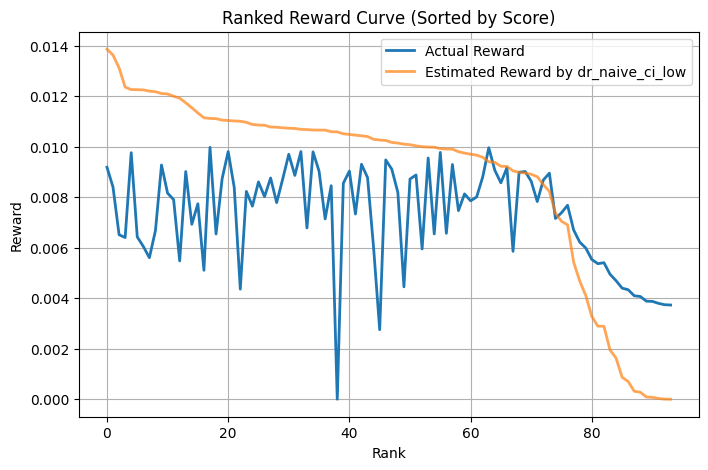

Plotting calibration for: dr_boot_mean


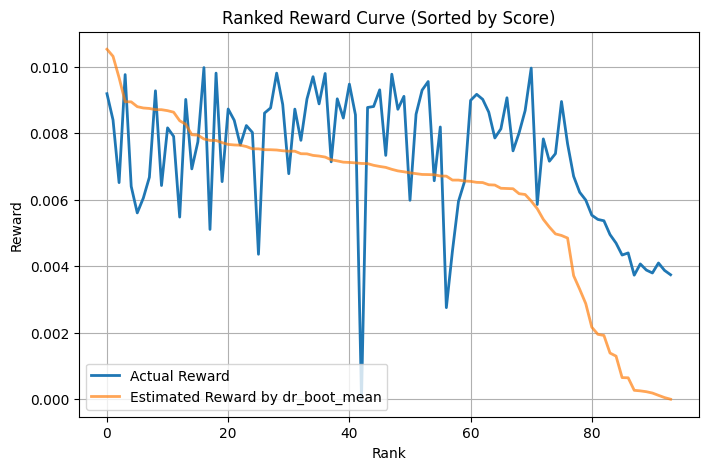

Plotting calibration for: dr_boot_ci_low


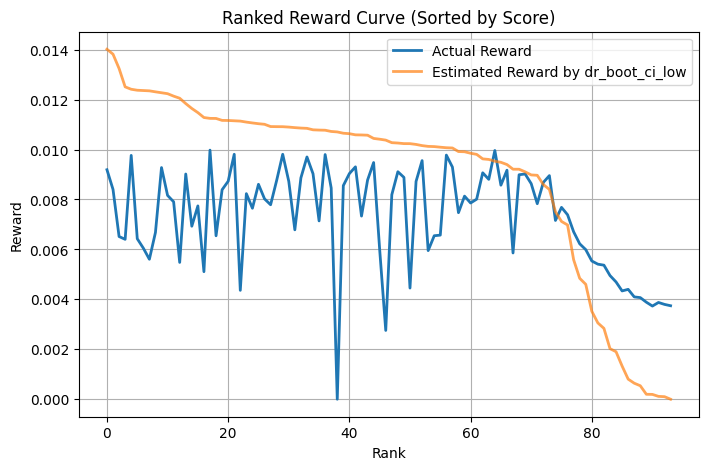

Plotting calibration for: dr_uni_mean


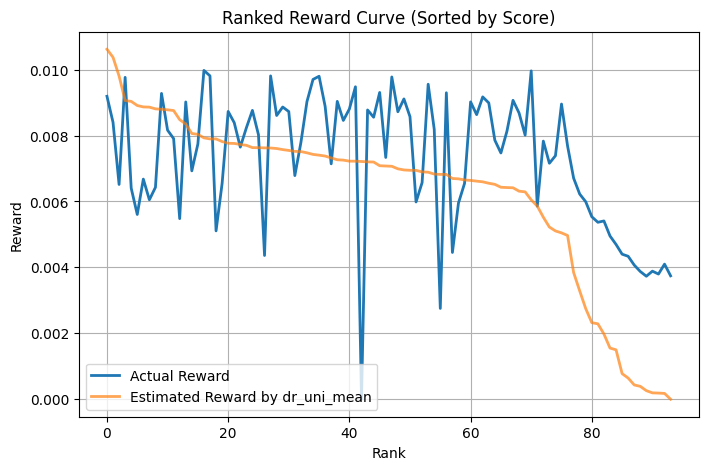

Plotting calibration for: dr_uni_ci_low


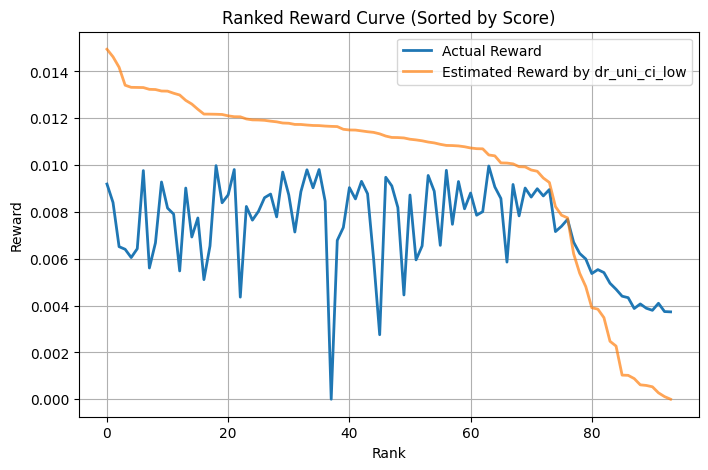

Plotting calibration for: ipw_boot_mean


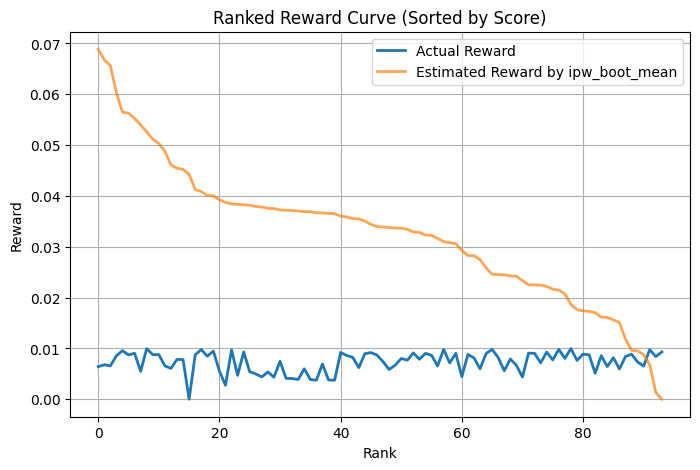

Plotting calibration for: ipw_boot_ci_low


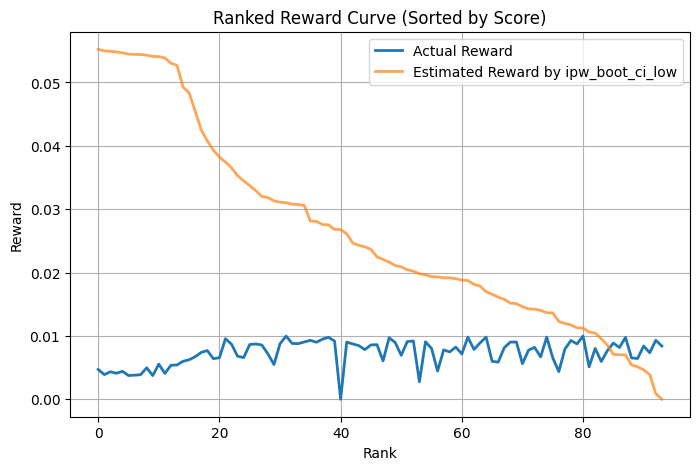

Plotting calibration for: ipw_uni_mean


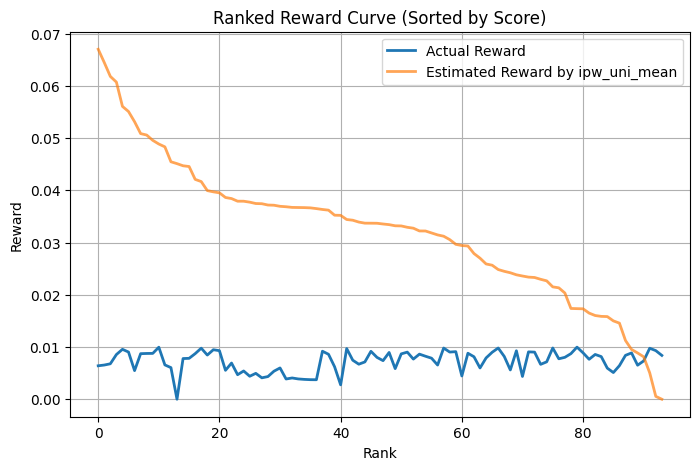

Plotting calibration for: ipw_uni_ci_low


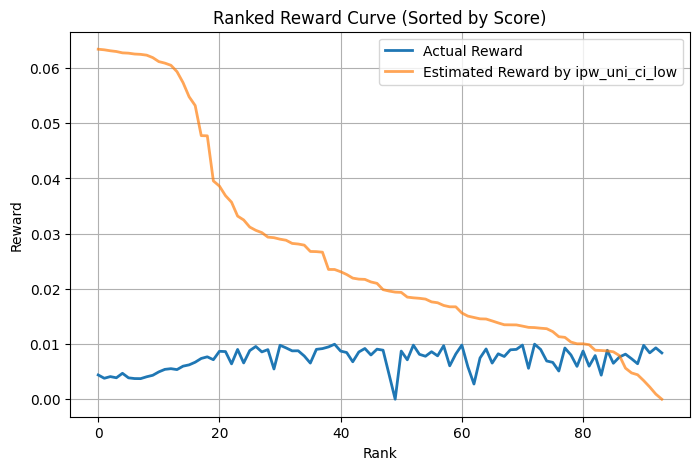

Num samples: 30000


Spearman-Rank Kendall-Tau
dr_naive_mean      0.37376729  0.27202013
dr_naive_ci_low    0.32212549  0.23404255
dr_boot_mean       0.37295813  0.26469915
dr_boot_ci_low     0.32271791  0.23266987
dr_uni_mean        0.37259690  0.26744452
dr_uni_ci_low      0.31198208  0.22351865
ipw_boot_mean     -0.16933858 -0.10867078
ipw_boot_ci_low   -0.35641368 -0.25188744
ipw_uni_mean      -0.18258859 -0.11416152
ipw_uni_ci_low    -0.32153307 -0.22763670

Plotting calibration for: dr_naive_mean


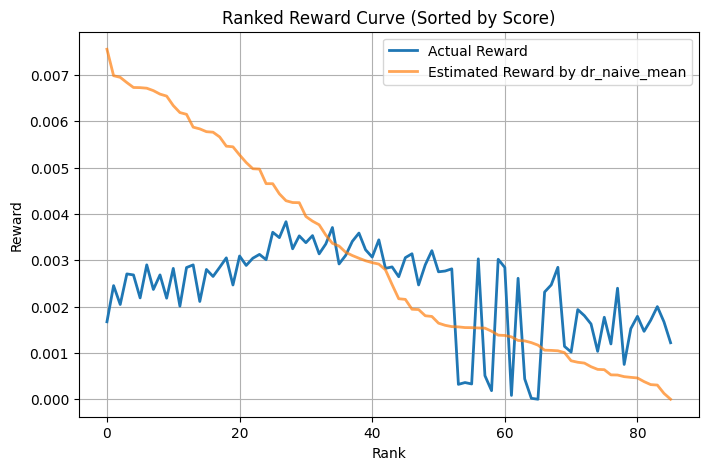

Plotting calibration for: dr_naive_ci_low


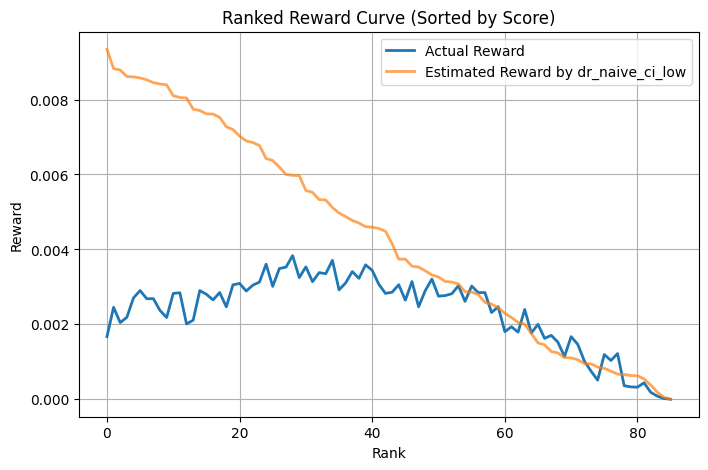

Plotting calibration for: dr_boot_mean


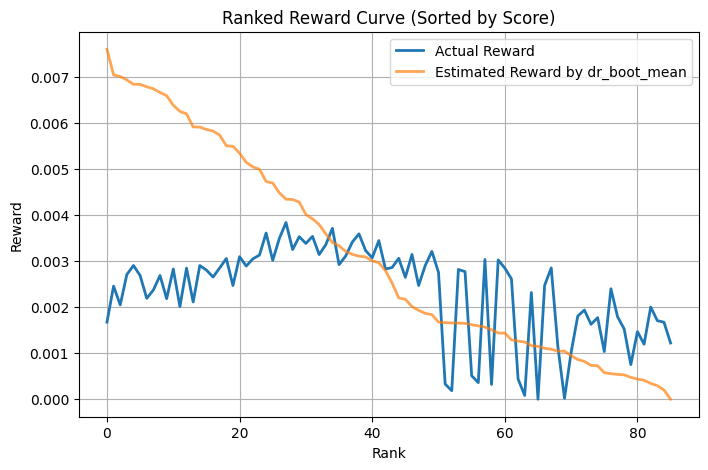

Plotting calibration for: dr_boot_ci_low


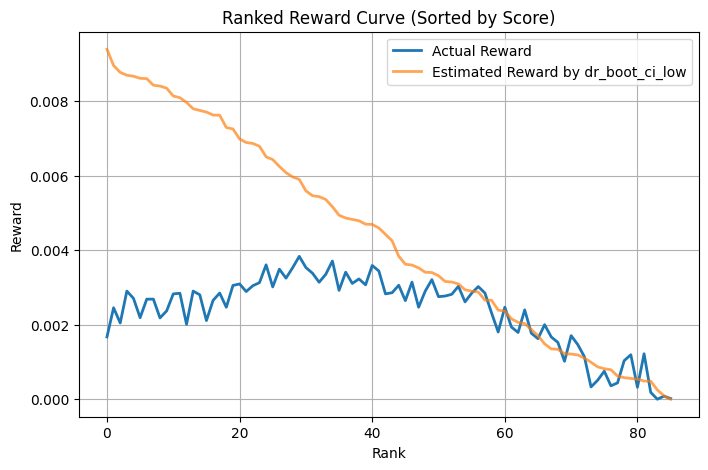

Plotting calibration for: dr_uni_mean


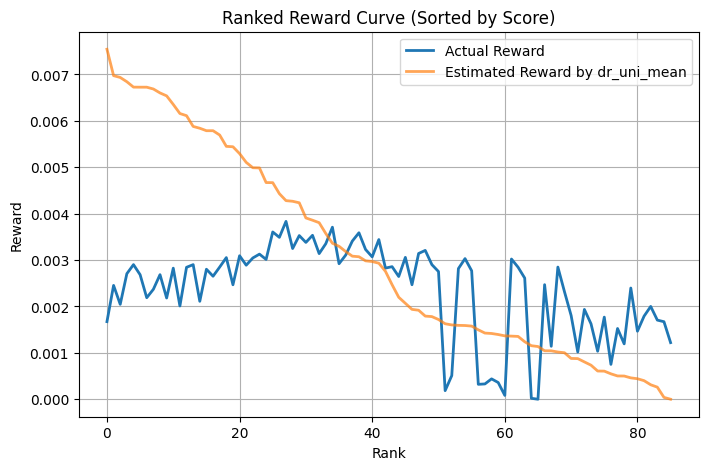

Plotting calibration for: dr_uni_ci_low


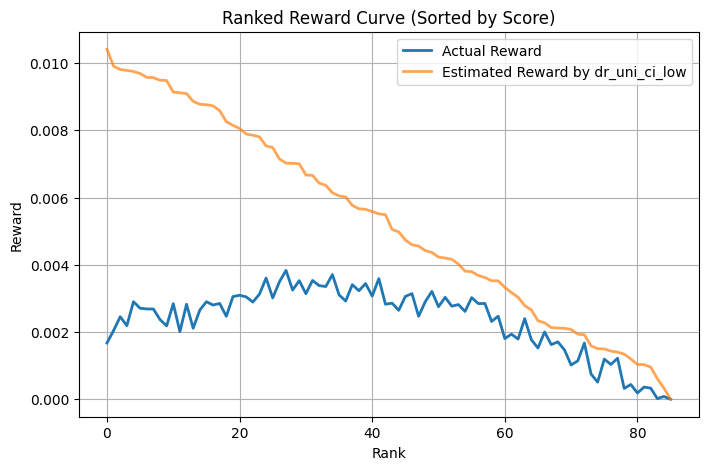

Plotting calibration for: ipw_boot_mean


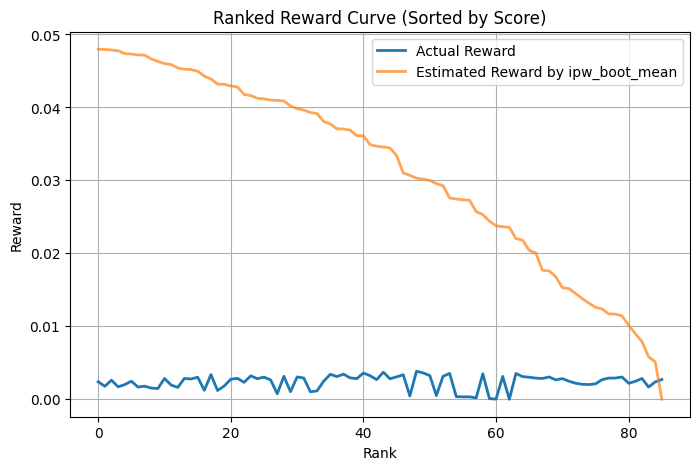

Plotting calibration for: ipw_boot_ci_low


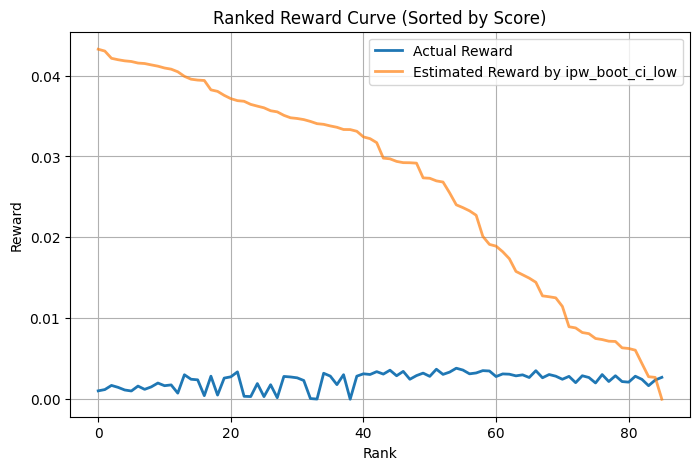

Plotting calibration for: ipw_uni_mean


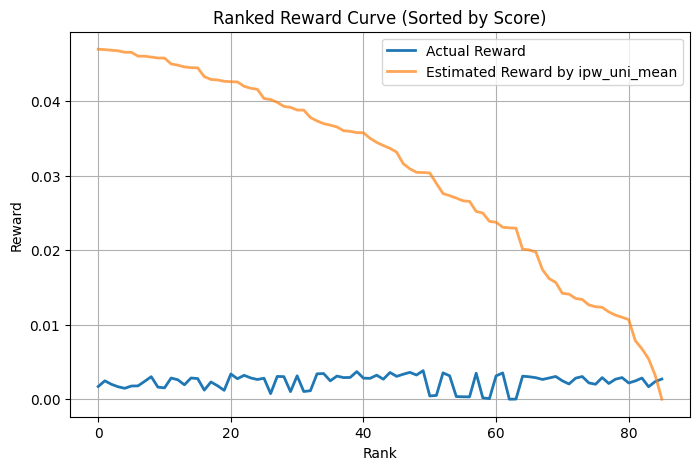

Plotting calibration for: ipw_uni_ci_low


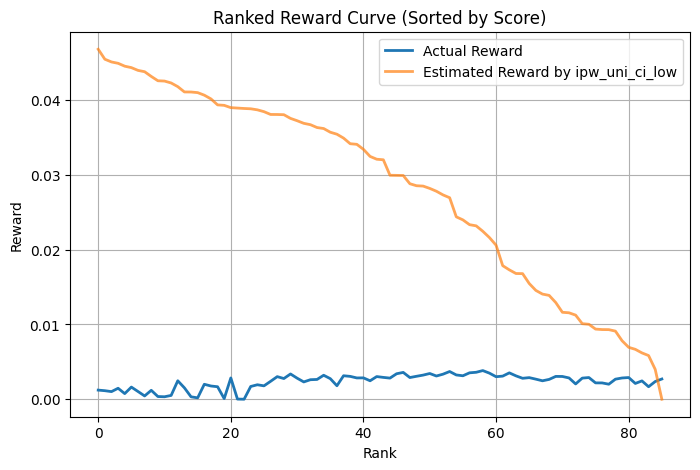

Num samples: 40000


Spearman-Rank Kendall-Tau
dr_naive_mean      0.46514458  0.26675787
dr_naive_ci_low    0.54979008  0.40629275
dr_boot_mean       0.46727676  0.27332421
dr_boot_ci_low     0.54873343  0.39589603
dr_uni_mean        0.45838955  0.26347469
dr_uni_ci_low      0.54843153  0.40136799
ipw_boot_mean     -0.10503326 -0.04842681
ipw_boot_ci_low   -0.43740742 -0.25088919
ipw_uni_mean      -0.09805179 -0.04842681
ipw_uni_ci_low    -0.51556205 -0.32859097

Plotting calibration for: dr_naive_mean


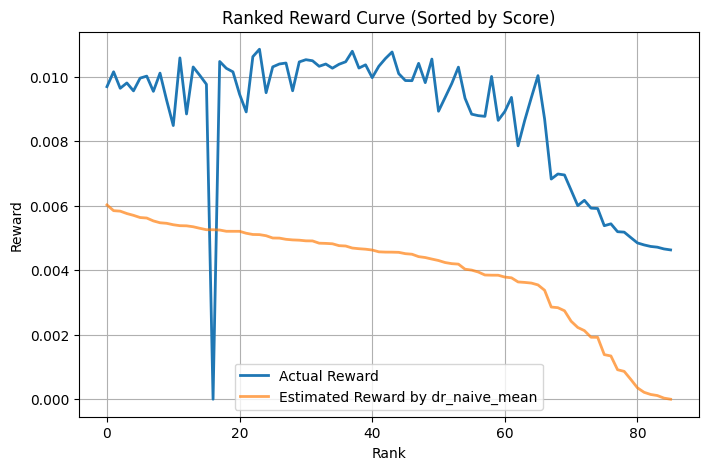

Plotting calibration for: dr_naive_ci_low


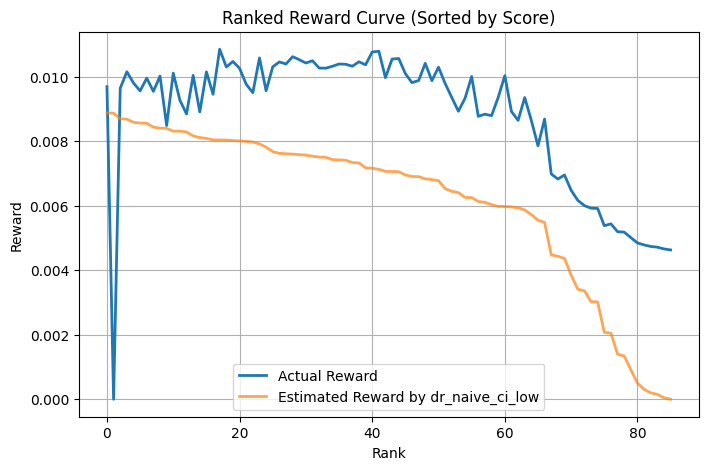

Plotting calibration for: dr_boot_mean


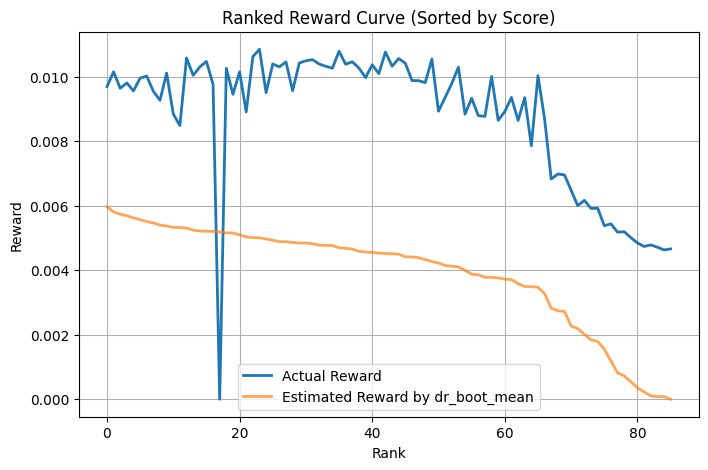

Plotting calibration for: dr_boot_ci_low


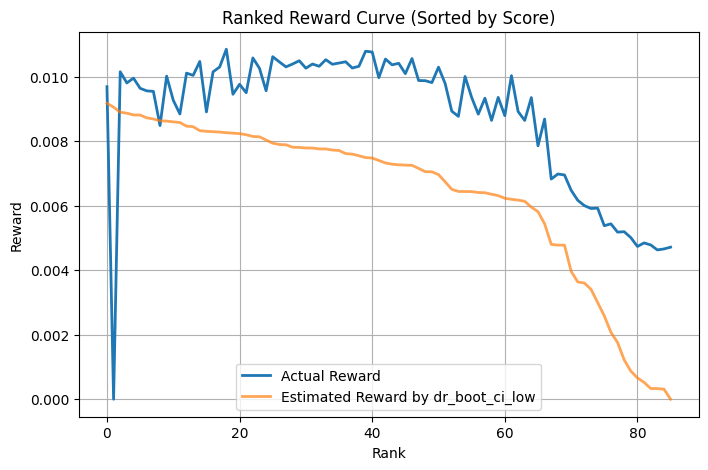

Plotting calibration for: dr_uni_mean


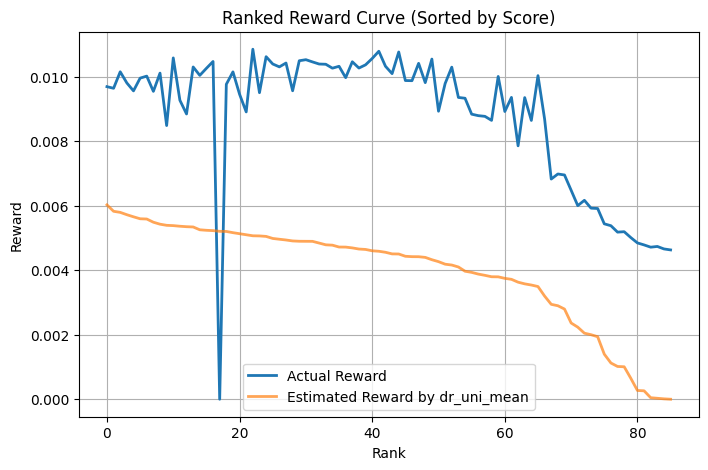

Plotting calibration for: dr_uni_ci_low


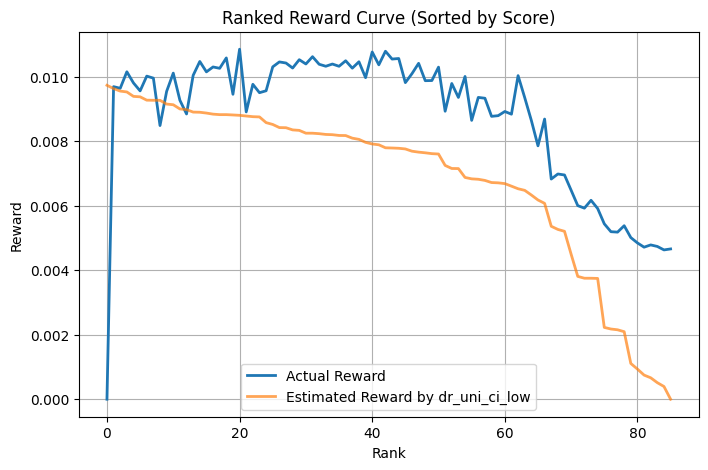

Plotting calibration for: ipw_boot_mean


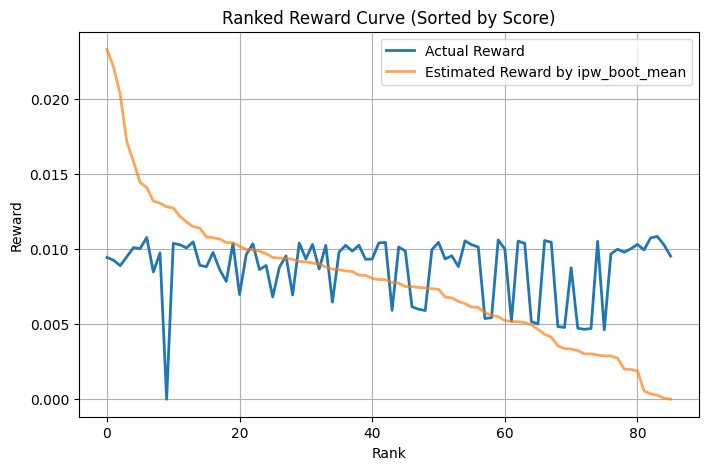

Plotting calibration for: ipw_boot_ci_low


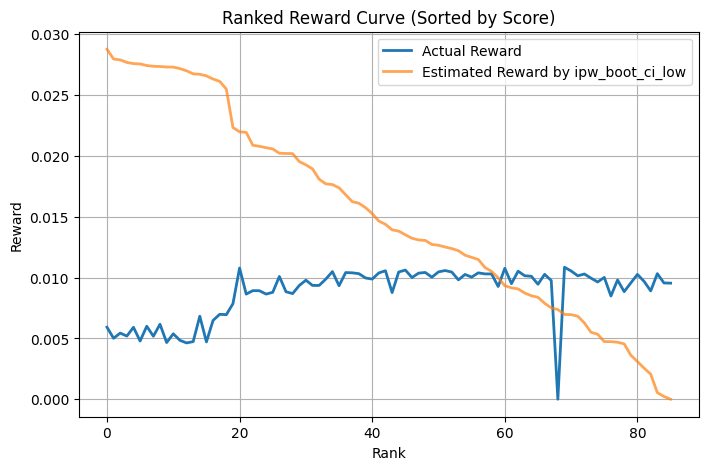

Plotting calibration for: ipw_uni_mean


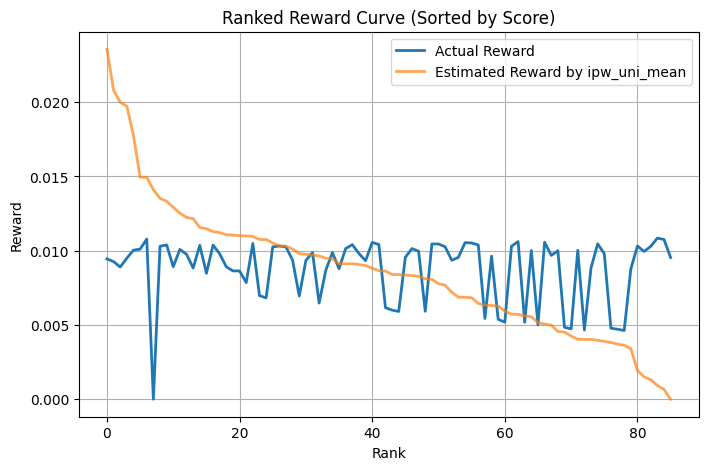

Plotting calibration for: ipw_uni_ci_low


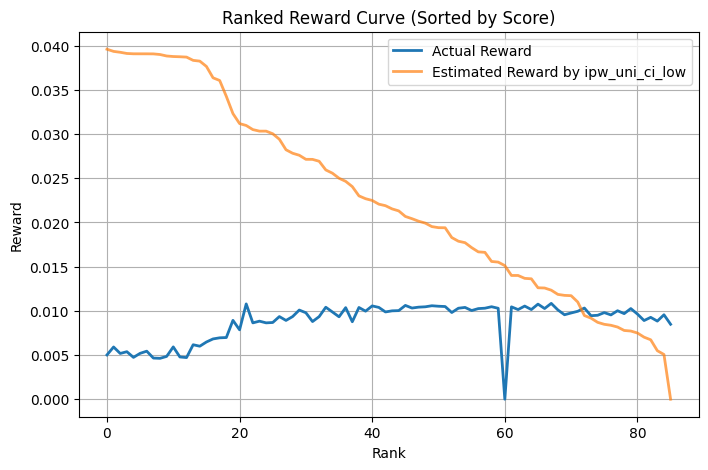

Num samples: 50000


Spearman-Rank Kendall-Tau
dr_naive_mean      0.59479221  0.46374829
dr_naive_ci_low    0.57590452  0.45006840
dr_boot_mean       0.59545262  0.46374829
dr_boot_ci_low     0.57779141  0.44842681
dr_uni_mean        0.59488655  0.46320109
dr_uni_ci_low      0.57971602  0.44569083
ipw_boot_mean     -0.02878438  0.00082079
ipw_boot_ci_low   -0.54833719 -0.38385773
ipw_uni_mean       0.01653852  0.02982216
ipw_uni_ci_low    -0.54343129 -0.38276334

Plotting calibration for: dr_naive_mean


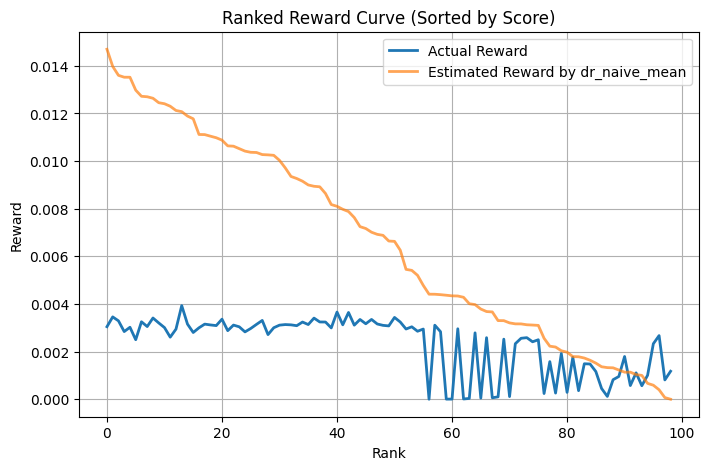

Plotting calibration for: dr_naive_ci_low


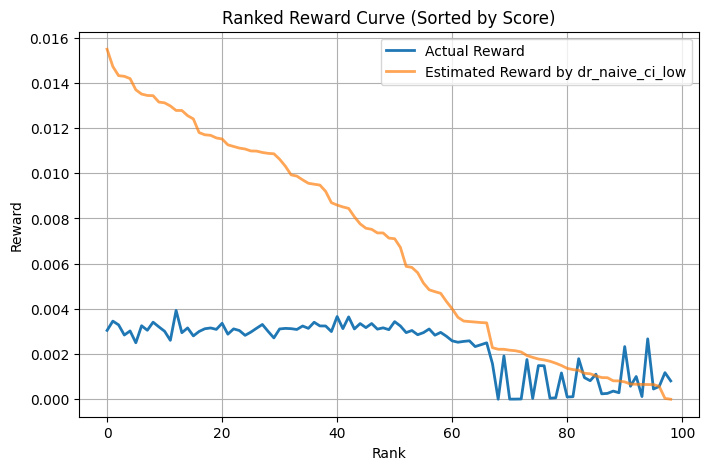

Plotting calibration for: dr_boot_mean


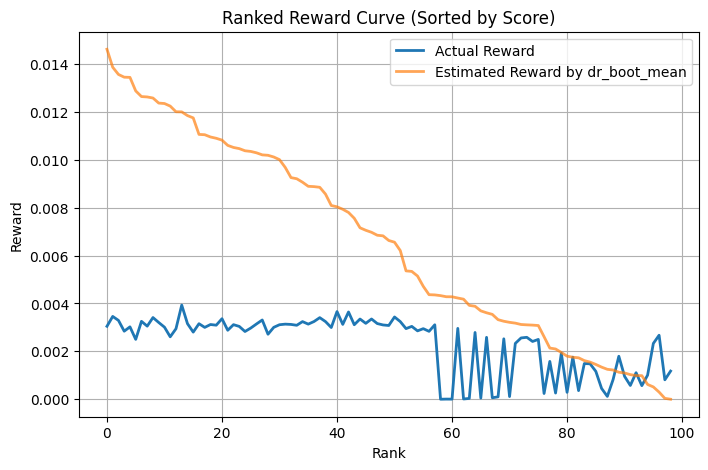

Plotting calibration for: dr_boot_ci_low


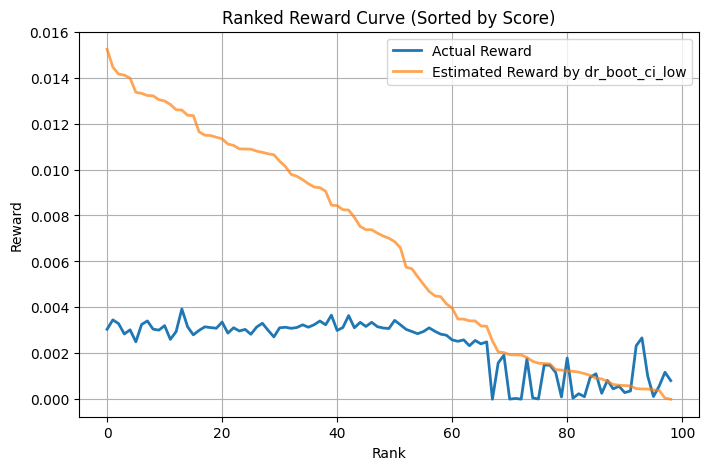

Plotting calibration for: dr_uni_mean


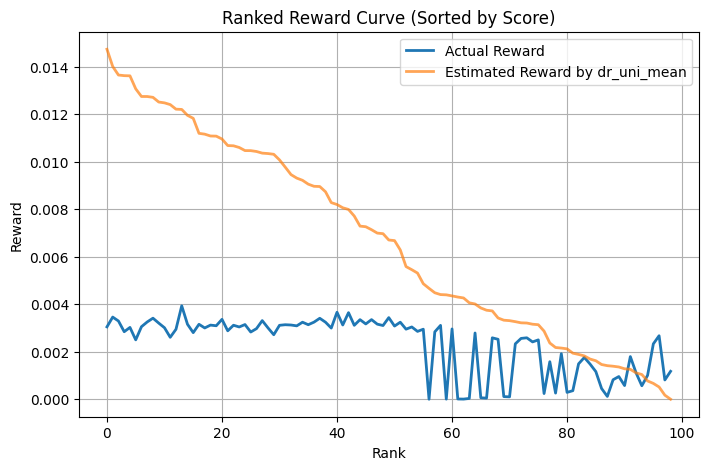

Plotting calibration for: dr_uni_ci_low


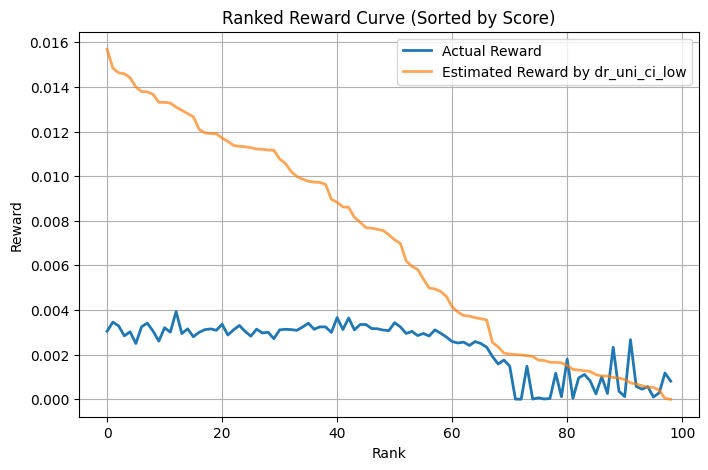

Plotting calibration for: ipw_boot_mean


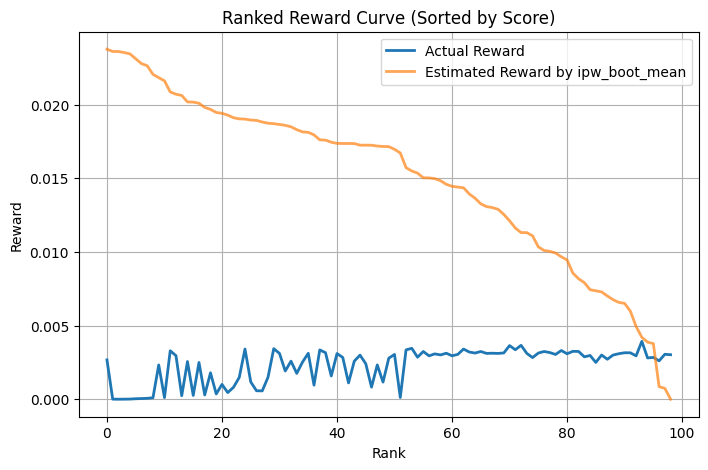

Plotting calibration for: ipw_boot_ci_low


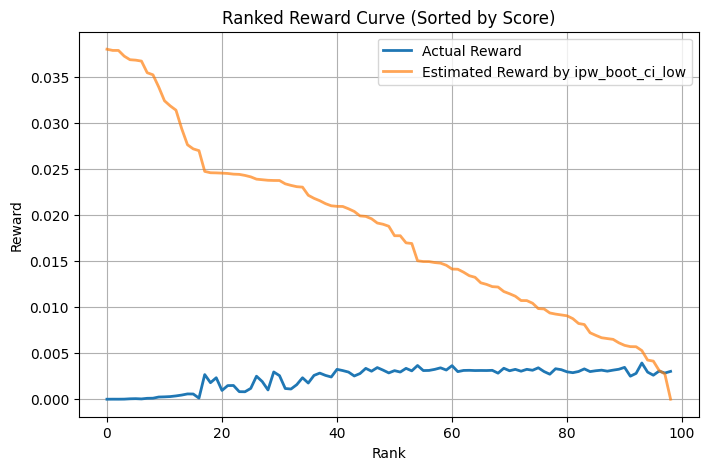

Plotting calibration for: ipw_uni_mean


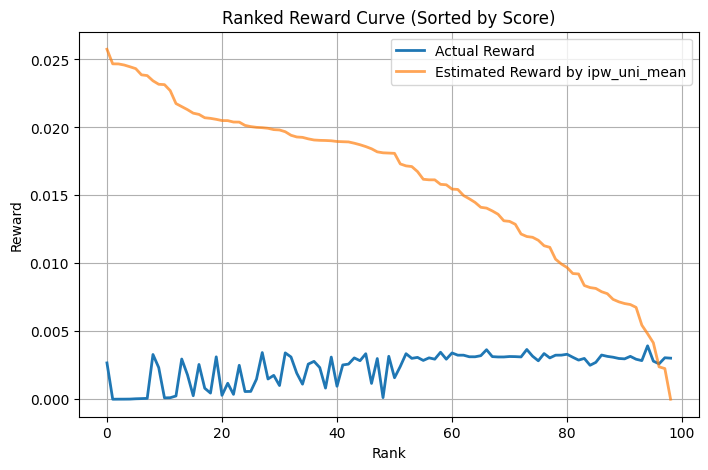

Plotting calibration for: ipw_uni_ci_low


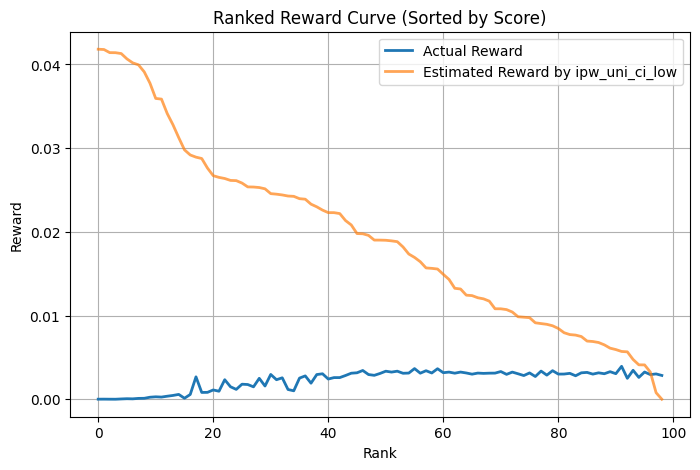

Num samples: 12345


Spearman-Rank Kendall-Tau
dr_naive_mean      0.68535560  0.44094001
dr_naive_ci_low    0.73081014  0.50773036
dr_boot_mean       0.68677798  0.44217687
dr_boot_ci_low     0.73073593  0.51020408
dr_uni_mean        0.68649351  0.44217687
dr_uni_ci_low      0.74027211  0.52916924
ipw_boot_mean     -0.60004947 -0.43063286
ipw_boot_ci_low   -0.73642548 -0.56297671
ipw_uni_mean      -0.61094620 -0.43970315
ipw_uni_ci_low    -0.74907854 -0.57864358

In [33]:
for num in [10000, 20000, 30000, 40000, 50000, 12345]:
    df = pd.read_csv(f"trial_dfs/study_df_155_{num}.csv")

    rank_tbl = plot_calibration_and_rank_table(
        df,
        cols=cols,
        reward_col="user_attrs_actual_reward"
    )

    print(f"Num samples: {num}")
    display(rank_tbl)

In [6]:
# df = pd.read_csv("trial_dfs/study_df_27_40000.csv")

# rank_tbl = plot_calibration_and_rank_table(
#     df,
#     cols=cols,
#     reward_col="user_attrs_actual_reward"
# )

# rank_tbl

In [7]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params)

Random Item CTR: 0.07066414727263938
Optimal greedy CTR: 0.09999926940951757
Second Best greedy CTR: 0.0980913477695915
Optimal Stochastic CTR: 0.09995326955796031
second Best Stochastic CTR: 0.08595012935428775
Our Initial CTR: 0.08610747363354625


In [8]:
num_runs = 1
batch_size = 200
num_neighbors = 6
n_trials_for_optuna = 155
# num_rounds_list = [500, 1000, 2000, 10000, 20000]
# num_rounds_list = [500, 1000, 2000]
num_rounds_list = [15000]


# Manually define your best parameters
best_params_to_use = {
    "lr": 0.096,  # Learning rate
    "num_epochs": 5,  # Number of training epochs
    "batch_size": 64,  # Batch size for training
    "num_neighbors": 8,  # Number of neighbors for neighborhood model
    "lr_decay": 0.85  # Learning rate decay factor
}


### 1

$$emb = 0.7 * gt + 0.3 * noise$$
$$lr = 0.005$$
$$n_{epochs} = 1$$
$$BatchSize=50$$

In [9]:
print("Value of num_rounds_list:", num_rounds_list)

# Run the optimization
df4, study_df = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

# # Print best hyperparameters for each training size
# print("\n=== BEST HYPERPARAMETERS BY TRAINING SIZE ===")
# for train_size, params in best_hyperparams_by_size.items():
#     print(f"\nTraining Size: {train_size}")
#     # print(f"Best Reward: {params['reward']:.6f}")
#     print("Parameters:")
#     for param_name, value in params['params'].items():
#         print(f"  {param_name}: {value}")
# print("===========================\n")

# Show the performance metrics
df4[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Value of num_rounds_list: [15000]
Simulation time for 10000 samples: 0.026269197463989258 seconds
[Regression] Baseline regression model fit time: 0.09s
Num samples is 10000
{'gini': np.float64(0.47475716939322465), 'ess': np.float64(4287.120392699498), 'max_wi': np.float64(26.71587268724541), 'min_wi': np.float64(0.006414091036831613)}
Eval time: 0.5953333377838135 seconds


[I 2025-12-14 23:33:48,955] A new study created in memory with name: no-name-dc37e0aa-a1bd-4b13-a24f-71695fb3ed55


Evaluation total results time: 1.01 seconds

=== [Regression] Training size 15000, run 0 ===
Simulation time for 25000 samples: 0.061504364013671875 seconds


  0%|          | 0/155 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.07826314]
Validation weights_info: {'gini': np.float64(0.9927399206081721), 'ess': np.float64(3.6919109035798354), 'max_wi': np.float64(8692.26291956346), 'min_wi': np.float64(0.0)}


Best trial: 0. Best value: -inf:   1%|          | 1/155 [00:04<11:29,  4.48s/it]

[I 2025-12-14 23:33:53,432] Trial 0 finished with value: -inf and parameters: {'lr': 0.096, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.85}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 1
actual reward: [0.08612417]
Validation weights_info: {'gini': np.float64(0.0368766328994957), 'ess': np.float64(9951.75418161346), 'max_wi': np.float64(1.2058244616035845), 'min_wi': np.float64(0.8639552709676334)}


Best trial: 1. Best value: 0.0759404:   1%|▏         | 2/155 [00:05<06:10,  2.42s/it]

[I 2025-12-14 23:33:54,418] Trial 1 finished with value: 0.07594041504050898 and parameters: {'lr': 0.0005582192623797024, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.8453477454556447}. Best is trial 1 with value: 0.07594041504050898.

[Regression] Optuna Trial 2
actual reward: [0.08005583]
Validation weights_info: {'gini': np.float64(0.996863021241853), 'ess': np.float64(7.651156889549568), 'max_wi': np.float64(1413.5253428548733), 'min_wi': np.float64(9.15226675674532e-22)}


Best trial: 1. Best value: 0.0759404:   2%|▏         | 3/155 [00:07<05:08,  2.03s/it]

[I 2025-12-14 23:33:55,982] Trial 2 finished with value: -inf and parameters: {'lr': 0.06117602492243932, 'num_epochs': 2, 'batch_size': 128, 'lr_decay': 0.9808651868466397}. Best is trial 1 with value: 0.07594041504050898.

[Regression] Optuna Trial 3
actual reward: [0.08647323]
Validation weights_info: {'gini': np.float64(0.5316562638396137), 'ess': np.float64(3876.1859057337774), 'max_wi': np.float64(8.982463563309036), 'min_wi': np.float64(0.056491688884568736)}


Best trial: 1. Best value: 0.0759404:   3%|▎         | 4/155 [00:09<05:24,  2.15s/it]

[I 2025-12-14 23:33:58,307] Trial 3 finished with value: 0.07469096633095938 and parameters: {'lr': 0.0007507565741241829, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9252371988225976}. Best is trial 1 with value: 0.07594041504050898.

[Regression] Optuna Trial 4
actual reward: [0.08781176]
Validation weights_info: {'gini': np.float64(0.993415961167863), 'ess': np.float64(7.583215994833438), 'max_wi': np.float64(2966.4107042192104), 'min_wi': np.float64(6.525025246056489e-12)}


Best trial: 1. Best value: 0.0759404:   3%|▎         | 5/155 [00:10<04:36,  1.84s/it]

[I 2025-12-14 23:33:59,616] Trial 4 finished with value: -inf and parameters: {'lr': 0.04617946073130278, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.9018259631518034}. Best is trial 1 with value: 0.07594041504050898.

[Regression] Optuna Trial 5
actual reward: [0.08622483]
Validation weights_info: {'gini': np.float64(0.22371601877300343), 'ess': np.float64(8325.303633278485), 'max_wi': np.float64(2.809378231028577), 'min_wi': np.float64(0.34871904485611926)}


Best trial: 1. Best value: 0.0759404:   4%|▍         | 6/155 [00:12<04:39,  1.87s/it]

[I 2025-12-14 23:34:01,545] Trial 5 finished with value: 0.07516807271990958 and parameters: {'lr': 0.000452073142808862, 'num_epochs': 3, 'batch_size': 128, 'lr_decay': 0.9295928640038476}. Best is trial 1 with value: 0.07594041504050898.

[Regression] Optuna Trial 6
actual reward: [0.08807659]
Validation weights_info: {'gini': np.float64(0.9786534363701228), 'ess': np.float64(65.88562552997453), 'max_wi': np.float64(630.8827328483708), 'min_wi': np.float64(9.54196227890094e-08)}


Best trial: 1. Best value: 0.0759404:   5%|▍         | 7/155 [00:13<04:02,  1.64s/it]

[I 2025-12-14 23:34:02,701] Trial 6 finished with value: -inf and parameters: {'lr': 0.021438316696939224, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.8306196388374828}. Best is trial 1 with value: 0.07594041504050898.

[Regression] Optuna Trial 7
actual reward: [0.08845083]
Validation weights_info: {'gini': np.float64(0.9864552694090399), 'ess': np.float64(46.04078171731365), 'max_wi': np.float64(588.9519903293692), 'min_wi': np.float64(2.0360824638027764e-09)}


Best trial: 1. Best value: 0.0759404:   5%|▌         | 8/155 [00:15<04:26,  1.82s/it]

[I 2025-12-14 23:34:04,895] Trial 7 finished with value: -inf and parameters: {'lr': 0.014073205730313816, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.8766763671537311}. Best is trial 1 with value: 0.07594041504050898.

[Regression] Optuna Trial 8
actual reward: [0.08611405]
Validation weights_info: {'gini': np.float64(0.0192521039167446), 'ess': np.float64(9987.170327292748), 'max_wi': np.float64(1.1149064478004624), 'min_wi': np.float64(0.9237034845127797)}


Best trial: 8. Best value: 0.0760612:   6%|▌         | 9/155 [00:17<04:04,  1.68s/it]

[I 2025-12-14 23:34:06,261] Trial 8 finished with value: 0.07606118276040096 and parameters: {'lr': 0.00011418027589200212, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.9446001977203393}. Best is trial 8 with value: 0.07606118276040096.

[Regression] Optuna Trial 9
actual reward: [0.08617515]
Validation weights_info: {'gini': np.float64(0.14035927038759435), 'ess': np.float64(9307.676512100594), 'max_wi': np.float64(1.9733208538681246), 'min_wi': np.float64(0.5386981477425644)}


Best trial: 8. Best value: 0.0760612:   6%|▋         | 10/155 [00:18<04:01,  1.66s/it]

[I 2025-12-14 23:34:07,896] Trial 9 finished with value: 0.0754469465997559 and parameters: {'lr': 0.00042021934625671974, 'num_epochs': 2, 'batch_size': 128, 'lr_decay': 0.9370843781622648}. Best is trial 8 with value: 0.07606118276040096.

[Regression] Optuna Trial 10
actual reward: [0.08614706]
Validation weights_info: {'gini': np.float64(0.07533983502269681), 'ess': np.float64(9795.583752303326), 'max_wi': np.float64(1.4503290503335644), 'min_wi': np.float64(0.7351290784858567)}


Best trial: 8. Best value: 0.0760612:   7%|▋         | 11/155 [00:21<04:24,  1.84s/it]

[I 2025-12-14 23:34:10,131] Trial 10 finished with value: 0.07570265603151359 and parameters: {'lr': 0.0001285510587855383, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9938096507915913}. Best is trial 8 with value: 0.07606118276040096.

[Regression] Optuna Trial 11
actual reward: [0.08611808]
Validation weights_info: {'gini': np.float64(0.023409373037304396), 'ess': np.float64(9980.578619680236), 'max_wi': np.float64(1.1244811327764133), 'min_wi': np.float64(0.909529373587521)}


Best trial: 8. Best value: 0.0760612:   8%|▊         | 12/155 [00:23<04:25,  1.86s/it]

[I 2025-12-14 23:34:12,037] Trial 11 finished with value: 0.07601985416181135 and parameters: {'lr': 0.00010657549849529868, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8038962772704965}. Best is trial 8 with value: 0.07606118276040096.

[Regression] Optuna Trial 12
actual reward: [0.08611952]
Validation weights_info: {'gini': np.float64(0.02664679399031807), 'ess': np.float64(9974.681308169917), 'max_wi': np.float64(1.1512381607641342), 'min_wi': np.float64(0.9013841970584149)}


Best trial: 8. Best value: 0.0760612:   8%|▊         | 13/155 [00:25<04:29,  1.90s/it]

[I 2025-12-14 23:34:14,016] Trial 12 finished with value: 0.0759957498969862 and parameters: {'lr': 0.00011020206559006684, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8016870881301581}. Best is trial 8 with value: 0.07606118276040096.

[Regression] Optuna Trial 13
actual reward: [0.08656522]
Validation weights_info: {'gini': np.float64(0.6016520805393603), 'ess': np.float64(3066.932757036768), 'max_wi': np.float64(12.662899638484507), 'min_wi': np.float64(0.039015080138815106)}


Best trial: 8. Best value: 0.0760612:   9%|▉         | 14/155 [00:26<04:23,  1.87s/it]

[I 2025-12-14 23:34:15,829] Trial 13 finished with value: 0.07452995990096609 and parameters: {'lr': 0.0021530511561885647, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.9479072984257154}. Best is trial 8 with value: 0.07606118276040096.

[Regression] Optuna Trial 14
actual reward: [0.08861204]
Validation weights_info: {'gini': np.float64(0.9625890303478214), 'ess': np.float64(118.28936073935405), 'max_wi': np.float64(422.2847594801816), 'min_wi': np.float64(1.4775140564812312e-06)}


Best trial: 14. Best value: 0.0876013:  10%|▉         | 15/155 [00:30<05:21,  2.30s/it]

[I 2025-12-14 23:34:19,109] Trial 14 finished with value: 0.08760134084185739 and parameters: {'lr': 0.003043995180933686, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9698089634403688}. Best is trial 14 with value: 0.08760134084185739.

[Regression] Optuna Trial 15
actual reward: [0.08925619]
Validation weights_info: {'gini': np.float64(0.9445294810138078), 'ess': np.float64(291.3005602881113), 'max_wi': np.float64(180.96120237899933), 'min_wi': np.float64(3.274439922204244e-06)}


Best trial: 14. Best value: 0.0876013:  10%|█         | 16/155 [00:33<05:48,  2.51s/it]

[I 2025-12-14 23:34:22,115] Trial 15 finished with value: 0.0848881955178428 and parameters: {'lr': 0.0028502815934693783, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9741889934913087}. Best is trial 14 with value: 0.08760134084185739.

[Regression] Optuna Trial 16
actual reward: [0.08887851]
Validation weights_info: {'gini': np.float64(0.9837729563685181), 'ess': np.float64(61.96365271710208), 'max_wi': np.float64(417.9354406433779), 'min_wi': np.float64(9.224666172397083e-09)}


Best trial: 14. Best value: 0.0876013:  11%|█         | 17/155 [00:36<06:06,  2.65s/it]

[I 2025-12-14 23:34:25,108] Trial 16 finished with value: -inf and parameters: {'lr': 0.005024834911434981, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9706308511234475}. Best is trial 14 with value: 0.08760134084185739.

[Regression] Optuna Trial 17
actual reward: [0.08852115]
Validation weights_info: {'gini': np.float64(0.9739851103289795), 'ess': np.float64(57.95865610324274), 'max_wi': np.float64(680.5785626892617), 'min_wi': np.float64(2.8742942094382106e-07)}


Best trial: 14. Best value: 0.0876013:  12%|█▏        | 18/155 [00:39<06:27,  2.83s/it]

[I 2025-12-14 23:34:28,343] Trial 17 finished with value: -inf and parameters: {'lr': 0.0036059817467982303, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.965976662086627}. Best is trial 14 with value: 0.08760134084185739.

[Regression] Optuna Trial 18
actual reward: [0.08946341]
Validation weights_info: {'gini': np.float64(0.9233227439329297), 'ess': np.float64(480.3948818597963), 'max_wi': np.float64(121.28018642388695), 'min_wi': np.float64(1.0674053484262886e-05)}


Best trial: 14. Best value: 0.0876013:  12%|█▏        | 19/155 [00:43<07:08,  3.15s/it]

[I 2025-12-14 23:34:32,238] Trial 18 finished with value: 0.08142414010546221 and parameters: {'lr': 0.001530195109548176, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.999969951211595}. Best is trial 14 with value: 0.08760134084185739.

[Regression] Optuna Trial 19
actual reward: [0.08669498]
Validation weights_info: {'gini': np.float64(0.9880689122562651), 'ess': np.float64(19.256648624479954), 'max_wi': np.float64(1411.376971883075), 'min_wi': np.float64(3.907747783189417e-08)}


Best trial: 14. Best value: 0.0876013:  13%|█▎        | 20/155 [00:46<06:49,  3.04s/it]

[I 2025-12-14 23:34:35,012] Trial 19 finished with value: -inf and parameters: {'lr': 0.007301120389922844, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9043391498920487}. Best is trial 14 with value: 0.08760134084185739.

[Regression] Optuna Trial 20
actual reward: [0.08844405]
Validation weights_info: {'gini': np.float64(0.8628435748797809), 'ess': np.float64(1034.4744931877588), 'max_wi': np.float64(45.49480231124358), 'min_wi': np.float64(0.0005056429622149341)}


Best trial: 14. Best value: 0.0876013:  14%|█▎        | 21/155 [00:51<08:07,  3.64s/it]

[I 2025-12-14 23:34:40,047] Trial 20 finished with value: 0.07731506243166503 and parameters: {'lr': 0.001130165517802264, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9596013751801248}. Best is trial 14 with value: 0.08760134084185739.

[Regression] Optuna Trial 21
actual reward: [0.08920524]
Validation weights_info: {'gini': np.float64(0.9499580415894572), 'ess': np.float64(220.66657769136805), 'max_wi': np.float64(262.4803828066869), 'min_wi': np.float64(6.832596133806173e-07)}


Best trial: 14. Best value: 0.0876013:  14%|█▍        | 22/155 [00:55<08:38,  3.90s/it]

[I 2025-12-14 23:34:44,563] Trial 21 finished with value: 0.08546974387860919 and parameters: {'lr': 0.0018775608775856306, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9978974029487229}. Best is trial 14 with value: 0.08760134084185739.

[Regression] Optuna Trial 22
actual reward: [0.08972175]
Validation weights_info: {'gini': np.float64(0.9958802498522226), 'ess': np.float64(14.162522041949744), 'max_wi': np.float64(2031.4060572879507), 'min_wi': np.float64(8.824962465110738e-13)}


Best trial: 14. Best value: 0.0876013:  15%|█▍        | 23/155 [00:59<08:40,  3.94s/it]

[I 2025-12-14 23:34:48,602] Trial 22 finished with value: -inf and parameters: {'lr': 0.008501998196293901, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9828971801853281}. Best is trial 14 with value: 0.08760134084185739.

[Regression] Optuna Trial 23
actual reward: [0.08942186]
Validation weights_info: {'gini': np.float64(0.9504343135638527), 'ess': np.float64(201.68071312985174), 'max_wi': np.float64(377.34117532990575), 'min_wi': np.float64(1.2634020520987667e-06)}


Best trial: 14. Best value: 0.0876013:  15%|█▌        | 24/155 [01:03<08:16,  3.79s/it]

[I 2025-12-14 23:34:52,039] Trial 23 finished with value: 0.08482760156873685 and parameters: {'lr': 0.0025167664262429287, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.982306210499013}. Best is trial 14 with value: 0.08760134084185739.

[Regression] Optuna Trial 24
actual reward: [0.08910782]
Validation weights_info: {'gini': np.float64(0.9307452150965749), 'ess': np.float64(221.5831600333212), 'max_wi': np.float64(358.57845114505744), 'min_wi': np.float64(1.3386067367367564e-05)}


Best trial: 14. Best value: 0.0876013:  16%|█▌        | 25/155 [01:05<07:13,  3.33s/it]

[I 2025-12-14 23:34:54,299] Trial 24 finished with value: 0.08260379906366401 and parameters: {'lr': 0.0040182435565640755, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.9572063406971999}. Best is trial 14 with value: 0.08760134084185739.

[Regression] Optuna Trial 25
actual reward: [0.08759297]
Validation weights_info: {'gini': np.float64(0.8397096384110984), 'ess': np.float64(1109.376791261756), 'max_wi': np.float64(32.557716644179386), 'min_wi': np.float64(0.0009692257917896419)}


Best trial: 14. Best value: 0.0876013:  17%|█▋        | 26/155 [01:08<07:16,  3.39s/it]

[I 2025-12-14 23:34:57,813] Trial 25 finished with value: 0.07563596235330135 and parameters: {'lr': 0.0010505258504386046, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.9987060471503711}. Best is trial 14 with value: 0.08760134084185739.

[Regression] Optuna Trial 26
actual reward: [0.08621323]
Validation weights_info: {'gini': np.float64(0.2076222042171708), 'ess': np.float64(8539.376411365687), 'max_wi': np.float64(2.6643616510190995), 'min_wi': np.float64(0.36862620996836554)}


Best trial: 14. Best value: 0.0876013:  17%|█▋        | 27/155 [01:11<06:54,  3.24s/it]

[I 2025-12-14 23:35:00,697] Trial 26 finished with value: 0.07522156800216948 and parameters: {'lr': 0.0002427787221511633, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9170926595834777}. Best is trial 14 with value: 0.08760134084185739.

[Regression] Optuna Trial 27
actual reward: [0.08869765]
Validation weights_info: {'gini': np.float64(0.8845201350089524), 'ess': np.float64(815.6587630381689), 'max_wi': np.float64(62.526628015035605), 'min_wi': np.float64(0.00019881306738675394)}


Best trial: 14. Best value: 0.0876013:  18%|█▊        | 28/155 [01:15<06:55,  3.27s/it]

[I 2025-12-14 23:35:04,051] Trial 27 finished with value: 0.07790247061435865 and parameters: {'lr': 0.0019516949729128383, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.8767813919017162}. Best is trial 14 with value: 0.08760134084185739.

[Regression] Optuna Trial 28
actual reward: [0.09111363]
Validation weights_info: {'gini': np.float64(0.9905449687658445), 'ess': np.float64(27.394894124246843), 'max_wi': np.float64(995.8003634638269), 'min_wi': np.float64(1.573978694862698e-10)}


Best trial: 14. Best value: 0.0876013:  19%|█▊        | 29/155 [01:18<07:09,  3.41s/it]

[I 2025-12-14 23:35:07,779] Trial 28 finished with value: -inf and parameters: {'lr': 0.006686296151604463, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.9733940893585168}. Best is trial 14 with value: 0.08760134084185739.

[Regression] Optuna Trial 29
actual reward: [0.08494029]
Validation weights_info: {'gini': np.float64(0.9960762835620051), 'ess': np.float64(18.070434616108198), 'max_wi': np.float64(904.0596203923251), 'min_wi': np.float64(1.1259286944373333e-09)}


Best trial: 14. Best value: 0.0876013:  19%|█▉        | 30/155 [01:20<06:00,  2.88s/it]

[I 2025-12-14 23:35:09,430] Trial 29 finished with value: -inf and parameters: {'lr': 0.01571969863732457, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.9551676903444879}. Best is trial 14 with value: 0.08760134084185739.

[Regression] Optuna Trial 30
actual reward: [0.09004446]
Validation weights_info: {'gini': np.float64(0.962778294692246), 'ess': np.float64(140.6747714807009), 'max_wi': np.float64(348.2518439863637), 'min_wi': np.float64(9.203827202805704e-08)}


Best trial: 14. Best value: 0.0876013:  20%|██        | 31/155 [01:26<07:37,  3.69s/it]

[I 2025-12-14 23:35:15,007] Trial 30 finished with value: 0.0866879219367272 and parameters: {'lr': 0.003056578807617845, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.8770576003331529}. Best is trial 14 with value: 0.08760134084185739.

[Regression] Optuna Trial 31
actual reward: [0.08905999]
Validation weights_info: {'gini': np.float64(0.8866799153981194), 'ess': np.float64(764.3017411719181), 'max_wi': np.float64(74.2090361413666), 'min_wi': np.float64(0.00013198712474007802)}


Best trial: 14. Best value: 0.0876013:  21%|██        | 32/155 [01:31<08:49,  4.31s/it]

[I 2025-12-14 23:35:20,756] Trial 31 finished with value: 0.07904510232204932 and parameters: {'lr': 0.0013960186636270493, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.8795766278764868}. Best is trial 14 with value: 0.08760134084185739.

[Regression] Optuna Trial 32
actual reward: [0.08998652]
Validation weights_info: {'gini': np.float64(0.9671032044222222), 'ess': np.float64(92.99706209726219), 'max_wi': np.float64(520.4165922285428), 'min_wi': np.float64(2.1879802522074047e-07)}


Best trial: 14. Best value: 0.0876013:  21%|██▏       | 33/155 [01:36<09:13,  4.54s/it]

[I 2025-12-14 23:35:25,833] Trial 32 finished with value: -inf and parameters: {'lr': 0.0034005012020482906, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.8582348381129785}. Best is trial 14 with value: 0.08760134084185739.

[Regression] Optuna Trial 33
actual reward: [0.08693363]
Validation weights_info: {'gini': np.float64(0.7594188081244944), 'ess': np.float64(1701.3365662354586), 'max_wi': np.float64(19.69696942116898), 'min_wi': np.float64(0.004670387937225286)}


Best trial: 14. Best value: 0.0876013:  22%|██▏       | 34/155 [01:41<09:30,  4.71s/it]

[I 2025-12-14 23:35:30,951] Trial 33 finished with value: 0.07501714243788378 and parameters: {'lr': 0.0007696839463445342, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8862762597581768}. Best is trial 14 with value: 0.08760134084185739.

[Regression] Optuna Trial 34
actual reward: [0.09057598]
Validation weights_info: {'gini': np.float64(0.9948553154586388), 'ess': np.float64(10.812432401242276), 'max_wi': np.float64(2347.66921496242), 'min_wi': np.float64(9.17752151551316e-12)}


Best trial: 14. Best value: 0.0876013:  23%|██▎       | 35/155 [01:48<10:24,  5.21s/it]

[I 2025-12-14 23:35:37,314] Trial 34 finished with value: -inf and parameters: {'lr': 0.010290617243762996, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.8548757334601288}. Best is trial 14 with value: 0.08760134084185739.

[Regression] Optuna Trial 35
actual reward: [0.08863197]
Validation weights_info: {'gini': np.float64(0.9949347947451886), 'ess': np.float64(16.086131558706022), 'max_wi': np.float64(1524.237374275802), 'min_wi': np.float64(2.6868101036779784e-10)}


Best trial: 14. Best value: 0.0876013:  23%|██▎       | 36/155 [01:52<09:28,  4.78s/it]

[I 2025-12-14 23:35:41,080] Trial 35 finished with value: -inf and parameters: {'lr': 0.005489036131088554, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9837622732924114}. Best is trial 14 with value: 0.08760134084185739.

[Regression] Optuna Trial 36
actual reward: [0.08894803]
Validation weights_info: {'gini': np.float64(0.8911273353735053), 'ess': np.float64(756.8493730039436), 'max_wi': np.float64(73.12923330119247), 'min_wi': np.float64(0.00010942155296484767)}


Best trial: 14. Best value: 0.0876013:  24%|██▍       | 37/155 [01:55<08:20,  4.24s/it]

[I 2025-12-14 23:35:44,069] Trial 36 finished with value: 0.07866273000767539 and parameters: {'lr': 0.0027263018400324893, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8399040217869806}. Best is trial 14 with value: 0.08760134084185739.

[Regression] Optuna Trial 37
actual reward: [0.08640218]
Validation weights_info: {'gini': np.float64(0.4694205236467833), 'ess': np.float64(4692.373060714182), 'max_wi': np.float64(7.217232102778479), 'min_wi': np.float64(0.09160628274656447)}


Best trial: 14. Best value: 0.0876013:  25%|██▍       | 38/155 [01:57<07:08,  3.66s/it]

[I 2025-12-14 23:35:46,372] Trial 37 finished with value: 0.0746806764771092 and parameters: {'lr': 0.0007223672155255663, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9129647020020404}. Best is trial 14 with value: 0.08760134084185739.

[Regression] Optuna Trial 38
actual reward: [0.09142646]
Validation weights_info: {'gini': np.float64(0.9912624045732771), 'ess': np.float64(11.50706566212691), 'max_wi': np.float64(2308.079384078755), 'min_wi': np.float64(8.137714513229504e-22)}


Best trial: 14. Best value: 0.0876013:  25%|██▌       | 39/155 [02:03<08:28,  4.39s/it]

[I 2025-12-14 23:35:52,457] Trial 38 finished with value: -inf and parameters: {'lr': 0.03229229225517028, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.8909317239458254}. Best is trial 14 with value: 0.08760134084185739.

[Regression] Optuna Trial 39
actual reward: [0.08935447]
Validation weights_info: {'gini': np.float64(0.9352470544295074), 'ess': np.float64(351.00957519435303), 'max_wi': np.float64(164.15982832502155), 'min_wi': np.float64(6.936087179143004e-06)}


Best trial: 14. Best value: 0.0876013:  26%|██▌       | 40/155 [02:07<07:58,  4.16s/it]

[I 2025-12-14 23:35:56,103] Trial 39 finished with value: 0.08361391450645768 and parameters: {'lr': 0.0019115440622917742, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9907120437398192}. Best is trial 14 with value: 0.08760134084185739.

[Regression] Optuna Trial 40
actual reward: [0.08913536]
Validation weights_info: {'gini': np.float64(0.9655643324053709), 'ess': np.float64(105.91776991485482), 'max_wi': np.float64(533.5397055991546), 'min_wi': np.float64(4.1715251376924246e-07)}


Best trial: 40. Best value: 0.0880973:  26%|██▋       | 41/155 [02:09<07:06,  3.74s/it]

[I 2025-12-14 23:35:58,860] Trial 40 finished with value: 0.0880973194863448 and parameters: {'lr': 0.003887073331213511, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.923915966740831}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 41
actual reward: [0.08827414]
Validation weights_info: {'gini': np.float64(0.9860418854705234), 'ess': np.float64(18.584079473397303), 'max_wi': np.float64(1694.6228607060218), 'min_wi': np.float64(1.121748372790368e-07)}


Best trial: 40. Best value: 0.0880973:  27%|██▋       | 42/155 [02:12<06:29,  3.44s/it]

[I 2025-12-14 23:36:01,607] Trial 41 finished with value: -inf and parameters: {'lr': 0.004768261061647457, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9336987707964647}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 42
actual reward: [0.08923798]
Validation weights_info: {'gini': np.float64(0.9266283304834381), 'ess': np.float64(419.7693360154179), 'max_wi': np.float64(142.04255562290618), 'min_wi': np.float64(2.112349565091223e-05)}


Best trial: 40. Best value: 0.0880973:  28%|██▊       | 43/155 [02:15<05:52,  3.15s/it]

[I 2025-12-14 23:36:04,069] Trial 42 finished with value: 0.08241487058266483 and parameters: {'lr': 0.0028934969650522622, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.970476920632583}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 43
actual reward: [0.08727686]
Validation weights_info: {'gini': np.float64(0.8056344651740474), 'ess': np.float64(1301.6080971393847), 'max_wi': np.float64(25.988844260942148), 'min_wi': np.float64(0.002521842098900248)}


Best trial: 40. Best value: 0.0880973:  28%|██▊       | 44/155 [02:17<05:19,  2.88s/it]

[I 2025-12-14 23:36:06,324] Trial 43 finished with value: 0.07538705106775842 and parameters: {'lr': 0.0016464926117152256, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.9415349078080161}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 44
actual reward: [0.08929235]
Validation weights_info: {'gini': np.float64(0.9961242722431708), 'ess': np.float64(10.913403345053364), 'max_wi': np.float64(2126.6231346913396), 'min_wi': np.float64(3.3128881972054194e-12)}


Best trial: 40. Best value: 0.0880973:  29%|██▉       | 45/155 [02:20<05:20,  2.91s/it]

[I 2025-12-14 23:36:09,306] Trial 44 finished with value: -inf and parameters: {'lr': 0.012539050751058971, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.9236317684992928}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 45
actual reward: [0.08635303]
Validation weights_info: {'gini': np.float64(0.3274903555241648), 'ess': np.float64(6818.0814725057635), 'max_wi': np.float64(3.9132073025382264), 'min_wi': np.float64(0.2254979585332966)}


Best trial: 40. Best value: 0.0880973:  30%|██▉       | 46/155 [02:22<04:40,  2.57s/it]

[I 2025-12-14 23:36:11,087] Trial 45 finished with value: 0.07482134774506952 and parameters: {'lr': 0.001004422772682349, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.8643119742039859}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 46
actual reward: [0.08637163]
Validation weights_info: {'gini': np.float64(0.45179828209228384), 'ess': np.float64(4896.630627327666), 'max_wi': np.float64(7.075721337446634), 'min_wi': np.float64(0.09809060611771314)}


Best trial: 40. Best value: 0.0880973:  30%|███       | 47/155 [02:25<05:04,  2.82s/it]

[I 2025-12-14 23:36:14,472] Trial 46 finished with value: 0.07482148778117614 and parameters: {'lr': 0.00035552327965554926, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9500685431005118}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 47
actual reward: [0.08309328]
Validation weights_info: {'gini': np.float64(0.9991939619254357), 'ess': np.float64(4.41636585149451), 'max_wi': np.float64(8068.291380447885), 'min_wi': np.float64(3.840995295770218e-25)}


Best trial: 40. Best value: 0.0880973:  31%|███       | 48/155 [02:27<04:18,  2.42s/it]

[I 2025-12-14 23:36:15,963] Trial 47 finished with value: -inf and parameters: {'lr': 0.09060041105637169, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8203678438550039}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 48
actual reward: [0.0889929]
Validation weights_info: {'gini': np.float64(0.9459061167047111), 'ess': np.float64(271.70253974224516), 'max_wi': np.float64(177.96150432551502), 'min_wi': np.float64(4.571381761322328e-06)}


Best trial: 40. Best value: 0.0880973:  32%|███▏      | 49/155 [02:29<04:20,  2.46s/it]

[I 2025-12-14 23:36:18,512] Trial 48 finished with value: 0.08516477281693077 and parameters: {'lr': 0.004079337708422904, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.8670931484589015}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 49
actual reward: [0.08846649]
Validation weights_info: {'gini': np.float64(0.992777609086774), 'ess': np.float64(22.892124765019055), 'max_wi': np.float64(722.7463933020479), 'min_wi': np.float64(4.853399431948499e-14)}


Best trial: 40. Best value: 0.0880973:  32%|███▏      | 50/155 [02:32<04:43,  2.70s/it]

[I 2025-12-14 23:36:21,783] Trial 49 finished with value: -inf and parameters: {'lr': 0.020687366392372824, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8699937233655862}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 50
actual reward: [0.08878558]
Validation weights_info: {'gini': np.float64(0.8795785160382982), 'ess': np.float64(831.5374164793391), 'max_wi': np.float64(34.83405014500282), 'min_wi': np.float64(0.00030284996659222043)}


Best trial: 40. Best value: 0.0880973:  33%|███▎      | 51/155 [02:34<04:07,  2.38s/it]

[I 2025-12-14 23:36:23,425] Trial 50 finished with value: 0.07454994387882308 and parameters: {'lr': 0.005850565869061513, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.895718217431347}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 51
actual reward: [0.08922417]
Validation weights_info: {'gini': np.float64(0.9425322936502349), 'ess': np.float64(280.9458454272476), 'max_wi': np.float64(217.2143950871262), 'min_wi': np.float64(1.1501573049095268e-05)}


Best trial: 40. Best value: 0.0880973:  34%|███▎      | 52/155 [02:37<04:21,  2.54s/it]

[I 2025-12-14 23:36:26,327] Trial 51 finished with value: 0.08452807268620076 and parameters: {'lr': 0.0038787575403078805, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8407330348404917}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 52
actual reward: [0.08921524]
Validation weights_info: {'gini': np.float64(0.9189187517929376), 'ess': np.float64(511.51326156522924), 'max_wi': np.float64(113.67239876192528), 'min_wi': np.float64(3.0851997604665495e-05)}


Best trial: 40. Best value: 0.0880973:  34%|███▍      | 53/155 [02:39<04:15,  2.51s/it]

[I 2025-12-14 23:36:28,751] Trial 52 finished with value: 0.08126420936380212 and parameters: {'lr': 0.002445371776323239, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9912400357857959}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 53
actual reward: [0.08775284]
Validation weights_info: {'gini': np.float64(0.9841589036880173), 'ess': np.float64(17.199785722384874), 'max_wi': np.float64(2070.17674377734), 'min_wi': np.float64(5.100650330058916e-07)}


Best trial: 40. Best value: 0.0880973:  35%|███▍      | 54/155 [02:41<03:49,  2.27s/it]

[I 2025-12-14 23:36:30,468] Trial 53 finished with value: -inf and parameters: {'lr': 0.009200892373699086, 'num_epochs': 3, 'batch_size': 128, 'lr_decay': 0.9044044625282924}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 54
actual reward: [0.08870818]
Validation weights_info: {'gini': np.float64(0.9689650475946385), 'ess': np.float64(89.84828873981985), 'max_wi': np.float64(561.3763031575771), 'min_wi': np.float64(8.198694201272406e-07)}


Best trial: 40. Best value: 0.0880973:  35%|███▌      | 55/155 [02:44<04:12,  2.52s/it]

[I 2025-12-14 23:36:33,584] Trial 54 finished with value: -inf and parameters: {'lr': 0.004537683818175859, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8691449949338277}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 55
actual reward: [0.08882471]
Validation weights_info: {'gini': np.float64(0.9732043633036164), 'ess': np.float64(48.86796686839554), 'max_wi': np.float64(924.3941768774345), 'min_wi': np.float64(2.1315763969957764e-07)}


Best trial: 40. Best value: 0.0880973:  36%|███▌      | 56/155 [02:47<04:22,  2.65s/it]

[I 2025-12-14 23:36:36,526] Trial 55 finished with value: -inf and parameters: {'lr': 0.0031188578295364955, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.9774299990458827}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 56
actual reward: [0.08706873]
Validation weights_info: {'gini': np.float64(0.7936437501059066), 'ess': np.float64(1395.002111741323), 'max_wi': np.float64(23.48628675062159), 'min_wi': np.float64(0.002524974435573656)}


Best trial: 40. Best value: 0.0880973:  37%|███▋      | 57/155 [02:49<04:11,  2.56s/it]

[I 2025-12-14 23:36:38,890] Trial 56 finished with value: 0.07504182834648776 and parameters: {'lr': 0.0015159260711452517, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.9614204515639171}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 57
actual reward: [0.08931757]
Validation weights_info: {'gini': np.float64(0.9602219349139218), 'ess': np.float64(157.51078931225283), 'max_wi': np.float64(350.13651966908577), 'min_wi': np.float64(5.115041645272482e-07)}


Best trial: 40. Best value: 0.0880973:  37%|███▋      | 58/155 [02:53<04:38,  2.87s/it]

[I 2025-12-14 23:36:42,471] Trial 57 finished with value: 0.08705932559135458 and parameters: {'lr': 0.0022393372896922846, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9882956304171694}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 58
actual reward: [0.08915466]
Validation weights_info: {'gini': np.float64(0.9015569806483534), 'ess': np.float64(690.5891800890797), 'max_wi': np.float64(89.12597487666443), 'min_wi': np.float64(0.00011695072760892859)}


Best trial: 40. Best value: 0.0880973:  38%|███▊      | 59/155 [02:57<04:57,  3.10s/it]

[I 2025-12-14 23:36:46,111] Trial 58 finished with value: 0.07973576956036772 and parameters: {'lr': 0.002126816167710891, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.8831311572742379}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 59
actual reward: [0.08668043]
Validation weights_info: {'gini': np.float64(0.6920227178272386), 'ess': np.float64(2110.6842217503226), 'max_wi': np.float64(17.601857163964645), 'min_wi': np.float64(0.016399435489862318)}


Best trial: 40. Best value: 0.0880973:  39%|███▊      | 60/155 [02:59<04:42,  2.97s/it]

[I 2025-12-14 23:36:48,775] Trial 59 finished with value: 0.07445423579533675 and parameters: {'lr': 0.0012791128008238957, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.989700836330767}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 60
actual reward: [0.08869165]
Validation weights_info: {'gini': np.float64(0.9908997145297245), 'ess': np.float64(16.296732033706284), 'max_wi': np.float64(1809.0969663780425), 'min_wi': np.float64(2.468009913933343e-09)}


Best trial: 40. Best value: 0.0880973:  39%|███▉      | 61/155 [03:03<04:55,  3.14s/it]

[I 2025-12-14 23:36:52,320] Trial 60 finished with value: -inf and parameters: {'lr': 0.006782450482095048, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.8470065331857555}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 61
actual reward: [0.08883174]
Validation weights_info: {'gini': np.float64(0.982285493345246), 'ess': np.float64(55.17627166640352), 'max_wi': np.float64(776.8937061007629), 'min_wi': np.float64(4.268523385934512e-08)}


Best trial: 40. Best value: 0.0880973:  40%|████      | 62/155 [03:06<05:05,  3.28s/it]

[I 2025-12-14 23:36:55,934] Trial 61 finished with value: -inf and parameters: {'lr': 0.003374705764321378, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.976470375707624}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 62
actual reward: [0.08947484]
Validation weights_info: {'gini': np.float64(0.9510487501504312), 'ess': np.float64(202.57276169284654), 'max_wi': np.float64(307.0900855746583), 'min_wi': np.float64(1.790340198738715e-06)}


Best trial: 40. Best value: 0.0880973:  41%|████      | 63/155 [03:09<04:53,  3.19s/it]

[I 2025-12-14 23:36:58,894] Trial 62 finished with value: 0.0854240633256559 and parameters: {'lr': 0.0023676936055322447, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.9986073764640159}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 63
actual reward: [0.08924843]
Validation weights_info: {'gini': np.float64(0.9365003963866436), 'ess': np.float64(318.3212561300792), 'max_wi': np.float64(208.89663841244982), 'min_wi': np.float64(7.65760146675204e-06)}


Best trial: 40. Best value: 0.0880973:  41%|████▏     | 64/155 [03:13<04:56,  3.26s/it]

[I 2025-12-14 23:37:02,309] Trial 63 finished with value: 0.08421654698240892 and parameters: {'lr': 0.0018875137400173514, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9973416771354259}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 64
actual reward: [0.08722176]
Validation weights_info: {'gini': np.float64(0.8146410709505254), 'ess': np.float64(1226.1305991654667), 'max_wi': np.float64(25.460079943096552), 'min_wi': np.float64(0.0015194098814306507)}


Best trial: 40. Best value: 0.0880973:  42%|████▏     | 65/155 [03:16<04:55,  3.28s/it]

[I 2025-12-14 23:37:05,641] Trial 64 finished with value: 0.07492798813183395 and parameters: {'lr': 0.0008681320373947307, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9869976322924556}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 65
actual reward: [0.08769292]
Validation weights_info: {'gini': np.float64(0.8223441724120937), 'ess': np.float64(1293.4783892327907), 'max_wi': np.float64(32.75321786599823), 'min_wi': np.float64(0.0012037542494341322)}


Best trial: 40. Best value: 0.0880973:  43%|████▎     | 66/155 [03:22<05:53,  3.97s/it]

[I 2025-12-14 23:37:11,224] Trial 65 finished with value: 0.07617710407134916 and parameters: {'lr': 0.0005698940037524084, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.9960274455879111}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 66
actual reward: [0.08920111]
Validation weights_info: {'gini': np.float64(0.9412915763955677), 'ess': np.float64(358.91195202118803), 'max_wi': np.float64(170.81155206068397), 'min_wi': np.float64(4.0612573962669336e-06)}


Best trial: 40. Best value: 0.0880973:  43%|████▎     | 67/155 [03:25<05:23,  3.68s/it]

[I 2025-12-14 23:37:14,226] Trial 66 finished with value: 0.08378067852325945 and parameters: {'lr': 0.0024951716894773186, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.9660307817411857}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 67
actual reward: [0.0895474]
Validation weights_info: {'gini': np.float64(0.9215028211004197), 'ess': np.float64(464.5684394837685), 'max_wi': np.float64(187.89668666236523), 'min_wi': np.float64(1.922469684685835e-05)}


Best trial: 40. Best value: 0.0880973:  44%|████▍     | 68/155 [03:27<04:32,  3.13s/it]

[I 2025-12-14 23:37:16,076] Trial 67 finished with value: 0.0810066042517627 and parameters: {'lr': 0.003981522925390902, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9803779788043738}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 68
actual reward: [0.08841272]
Validation weights_info: {'gini': np.float64(0.9918552789381023), 'ess': np.float64(13.972713174824953), 'max_wi': np.float64(2060.529068707137), 'min_wi': np.float64(3.1058710546639947e-10)}


Best trial: 40. Best value: 0.0880973:  45%|████▍     | 69/155 [03:30<04:24,  3.08s/it]

[I 2025-12-14 23:37:19,037] Trial 68 finished with value: -inf and parameters: {'lr': 0.00571873959442825, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9998884607029617}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 69
actual reward: [0.08977366]
Validation weights_info: {'gini': np.float64(0.9243338631170881), 'ess': np.float64(397.50854579051963), 'max_wi': np.float64(132.76070995325702), 'min_wi': np.float64(1.2621540700236852e-05)}


Best trial: 40. Best value: 0.0880973:  45%|████▌     | 70/155 [03:35<05:26,  3.84s/it]

[I 2025-12-14 23:37:24,650] Trial 69 finished with value: 0.0824964113877556 and parameters: {'lr': 0.001220735804044328, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.9866921635896785}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 70
actual reward: [0.08787024]
Validation weights_info: {'gini': np.float64(0.8493340844116442), 'ess': np.float64(1030.6811863288838), 'max_wi': np.float64(33.63786131599989), 'min_wi': np.float64(0.0007340003578105946)}


Best trial: 40. Best value: 0.0880973:  46%|████▌     | 71/155 [03:38<05:03,  3.61s/it]

[I 2025-12-14 23:37:27,731] Trial 70 finished with value: 0.07583179253678476 and parameters: {'lr': 0.0016963246654781365, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.8724786508969276}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 71
actual reward: [0.08946208]
Validation weights_info: {'gini': np.float64(0.9212584018267075), 'ess': np.float64(486.05894547213643), 'max_wi': np.float64(139.8017333579879), 'min_wi': np.float64(1.894619663738107e-05)}


Best trial: 40. Best value: 0.0880973:  46%|████▋     | 72/155 [03:41<04:43,  3.41s/it]

[I 2025-12-14 23:37:30,673] Trial 71 finished with value: 0.08166552204359473 and parameters: {'lr': 0.0023643327786136963, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9658175684281932}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 72
actual reward: [0.08936565]
Validation weights_info: {'gini': np.float64(0.9667861073348124), 'ess': np.float64(167.27140752328745), 'max_wi': np.float64(340.9105968054542), 'min_wi': np.float64(1.453788322068873e-07)}


Best trial: 40. Best value: 0.0880973:  47%|████▋     | 73/155 [03:44<04:14,  3.10s/it]

[I 2025-12-14 23:37:33,044] Trial 72 finished with value: 0.08741516522036556 and parameters: {'lr': 0.004168132613637211, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9729149835997635}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 73
actual reward: [0.08909003]
Validation weights_info: {'gini': np.float64(0.9629090375895981), 'ess': np.float64(90.42380763906601), 'max_wi': np.float64(510.85374510085825), 'min_wi': np.float64(3.0386973352347137e-06)}


Best trial: 40. Best value: 0.0880973:  48%|████▊     | 74/155 [03:46<03:55,  2.91s/it]

[I 2025-12-14 23:37:35,520] Trial 73 finished with value: -inf and parameters: {'lr': 0.00444784611480359, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.8630967261864285}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 74
actual reward: [0.08923294]
Validation weights_info: {'gini': np.float64(0.9514306904009131), 'ess': np.float64(150.54810926864673), 'max_wi': np.float64(389.06295494115653), 'min_wi': np.float64(2.3867495155340993e-06)}


Best trial: 40. Best value: 0.0880973:  48%|████▊     | 75/155 [03:49<03:46,  2.83s/it]

[I 2025-12-14 23:37:38,157] Trial 74 finished with value: 0.08561040522765709 and parameters: {'lr': 0.0031878812896866922, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9932310517798788}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 75
actual reward: [0.08882761]
Validation weights_info: {'gini': np.float64(0.9427095218582279), 'ess': np.float64(328.42163899896485), 'max_wi': np.float64(134.65097016804825), 'min_wi': np.float64(3.17315051574517e-06)}


Best trial: 40. Best value: 0.0880973:  49%|████▉     | 76/155 [03:51<03:39,  2.78s/it]

[I 2025-12-14 23:37:40,827] Trial 75 finished with value: 0.08476940173484847 and parameters: {'lr': 0.0030233523976160143, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.993637550155337}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 76
actual reward: [0.08909493]
Validation weights_info: {'gini': np.float64(0.9956514341699688), 'ess': np.float64(10.806131348602182), 'max_wi': np.float64(2269.945784322537), 'min_wi': np.float64(6.768336815131373e-11)}


Best trial: 40. Best value: 0.0880973:  50%|████▉     | 77/155 [03:55<03:49,  2.94s/it]

[I 2025-12-14 23:37:44,143] Trial 76 finished with value: -inf and parameters: {'lr': 0.007704722721799249, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9820254252388294}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 77
actual reward: [0.08928214]
Validation weights_info: {'gini': np.float64(0.9136790562384007), 'ess': np.float64(372.61928549718067), 'max_wi': np.float64(220.49681449406052), 'min_wi': np.float64(4.998277110350837e-05)}


Best trial: 40. Best value: 0.0880973:  50%|█████     | 78/155 [03:58<03:54,  3.05s/it]

[I 2025-12-14 23:37:47,439] Trial 77 finished with value: 0.08147030297857308 and parameters: {'lr': 0.0020446437897842953, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.9722030068994083}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 78
actual reward: [0.08862122]
Validation weights_info: {'gini': np.float64(0.9818247691877773), 'ess': np.float64(84.54605121012949), 'max_wi': np.float64(460.5180760241307), 'min_wi': np.float64(8.421017485106612e-09)}


Best trial: 40. Best value: 0.0880973:  51%|█████     | 79/155 [04:01<03:46,  2.98s/it]

[I 2025-12-14 23:37:50,268] Trial 78 finished with value: -inf and parameters: {'lr': 0.005221370020414844, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9509550138483686}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 79
actual reward: [0.08817135]
Validation weights_info: {'gini': np.float64(0.9725331787465095), 'ess': np.float64(73.53018464219552), 'max_wi': np.float64(584.9691370142411), 'min_wi': np.float64(2.136352967564627e-07)}


Best trial: 40. Best value: 0.0880973:  52%|█████▏    | 80/155 [04:03<03:36,  2.89s/it]

[I 2025-12-14 23:37:52,948] Trial 79 finished with value: -inf and parameters: {'lr': 0.0034795763005148446, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9883918965238547}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 80
actual reward: [0.08692421]
Validation weights_info: {'gini': np.float64(0.7992250548986605), 'ess': np.float64(1245.468865465213), 'max_wi': np.float64(26.399074805881728), 'min_wi': np.float64(0.0033683202962035644)}


Best trial: 40. Best value: 0.0880973:  52%|█████▏    | 81/155 [04:06<03:14,  2.63s/it]

[I 2025-12-14 23:37:54,970] Trial 80 finished with value: 0.07389368041202213 and parameters: {'lr': 0.0028336044041303117, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9406007889562235}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 81
actual reward: [0.0889029]
Validation weights_info: {'gini': np.float64(0.979292361922954), 'ess': np.float64(34.7481737663104), 'max_wi': np.float64(1186.3901423695204), 'min_wi': np.float64(1.3569804002172358e-07)}


Best trial: 40. Best value: 0.0880973:  53%|█████▎    | 82/155 [04:08<03:13,  2.65s/it]

[I 2025-12-14 23:37:57,661] Trial 81 finished with value: -inf and parameters: {'lr': 0.0042602891945795075, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9938923930547464}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 82
actual reward: [0.08922205]
Validation weights_info: {'gini': np.float64(0.9046459149370215), 'ess': np.float64(591.5561479502383), 'max_wi': np.float64(140.17132524371215), 'min_wi': np.float64(8.917770070258144e-05)}


Best trial: 40. Best value: 0.0880973:  54%|█████▎    | 83/155 [04:11<03:07,  2.61s/it]

[I 2025-12-14 23:38:00,181] Trial 82 finished with value: 0.07874672284123178 and parameters: {'lr': 0.0022800398879288305, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9789162914610533}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 83
actual reward: [0.08911302]
Validation weights_info: {'gini': np.float64(0.974233065493599), 'ess': np.float64(67.9417484647403), 'max_wi': np.float64(664.6390967151735), 'min_wi': np.float64(8.916202361798001e-08)}


Best trial: 40. Best value: 0.0880973:  54%|█████▍    | 84/155 [04:13<02:59,  2.53s/it]

[I 2025-12-14 23:38:02,525] Trial 83 finished with value: -inf and parameters: {'lr': 0.006394207921980352, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.8538966991419973}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 84
actual reward: [0.08760288]
Validation weights_info: {'gini': np.float64(0.8308373725656368), 'ess': np.float64(1182.4735945182015), 'max_wi': np.float64(27.840635703421917), 'min_wi': np.float64(0.0010579082558526082)}


Best trial: 40. Best value: 0.0880973:  55%|█████▍    | 85/155 [04:16<03:00,  2.58s/it]

[I 2025-12-14 23:38:05,216] Trial 84 finished with value: 0.07567586143459344 and parameters: {'lr': 0.0016935432643966713, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.909077477736368}. Best is trial 40 with value: 0.0880973194863448.

[Regression] Optuna Trial 85
actual reward: [0.08957041]
Validation weights_info: {'gini': np.float64(0.966976664443957), 'ess': np.float64(113.86953331382135), 'max_wi': np.float64(454.1890119883986), 'min_wi': np.float64(3.995445627332226e-07)}


Best trial: 85. Best value: 0.0886335:  55%|█████▌    | 86/155 [04:19<03:02,  2.64s/it]

[I 2025-12-14 23:38:07,997] Trial 85 finished with value: 0.08863354527423067 and parameters: {'lr': 0.003549854584950413, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9852659063303811}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 86
actual reward: [0.08865646]
Validation weights_info: {'gini': np.float64(0.9743395265781575), 'ess': np.float64(48.747941480946665), 'max_wi': np.float64(883.3581567675892), 'min_wi': np.float64(7.345066712438977e-07)}


Best trial: 85. Best value: 0.0886335:  56%|█████▌    | 87/155 [04:22<03:06,  2.74s/it]

[I 2025-12-14 23:38:10,969] Trial 86 finished with value: -inf and parameters: {'lr': 0.0032474108633162736, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.9672324686042362}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 87
actual reward: [0.08803022]
Validation weights_info: {'gini': np.float64(0.8549343949587218), 'ess': np.float64(1000.5048367085212), 'max_wi': np.float64(33.85378979375097), 'min_wi': np.float64(0.0006264213275903659)}


Best trial: 85. Best value: 0.0886335:  57%|█████▋    | 88/155 [04:24<03:04,  2.75s/it]

[I 2025-12-14 23:38:13,747] Trial 87 finished with value: 0.07610846594268948 and parameters: {'lr': 0.0013656540088177794, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9861386604501216}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 88
actual reward: [0.08623232]
Validation weights_info: {'gini': np.float64(0.6287226440204086), 'ess': np.float64(2285.6621058128235), 'max_wi': np.float64(17.75382825217596), 'min_wi': np.float64(0.024585298976376478)}


Best trial: 85. Best value: 0.0886335:  57%|█████▋    | 89/155 [04:26<02:33,  2.33s/it]

[I 2025-12-14 23:38:15,093] Trial 88 finished with value: 0.07453707376495868 and parameters: {'lr': 0.002673139662081727, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.9252153137849716}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 89
actual reward: [0.08841603]
Validation weights_info: {'gini': np.float64(0.9852085989944903), 'ess': np.float64(34.410859718763014), 'max_wi': np.float64(997.3076342170405), 'min_wi': np.float64(3.752359617313433e-09)}


Best trial: 85. Best value: 0.0886335:  58%|█████▊    | 90/155 [04:29<02:41,  2.49s/it]

[I 2025-12-14 23:38:17,956] Trial 89 finished with value: -inf and parameters: {'lr': 0.004781340693600947, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9731000705406503}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 90
actual reward: [0.08900188]
Validation weights_info: {'gini': np.float64(0.9971384422038257), 'ess': np.float64(11.6063944411293), 'max_wi': np.float64(1784.2247275049624), 'min_wi': np.float64(6.927536638272871e-12)}


Best trial: 85. Best value: 0.0886335:  59%|█████▊    | 91/155 [04:32<02:51,  2.68s/it]

[I 2025-12-14 23:38:21,089] Trial 90 finished with value: -inf and parameters: {'lr': 0.011522487574760916, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.9565320854417826}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 91
actual reward: [0.08901874]
Validation weights_info: {'gini': np.float64(0.9713920378604054), 'ess': np.float64(76.5396767874698), 'max_wi': np.float64(584.1288996102382), 'min_wi': np.float64(4.5305813026490717e-07)}


Best trial: 85. Best value: 0.0886335:  59%|█████▉    | 92/155 [04:34<02:46,  2.64s/it]

[I 2025-12-14 23:38:23,643] Trial 91 finished with value: -inf and parameters: {'lr': 0.00404168660344382, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9943490002669736}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 92
actual reward: [0.08940459]
Validation weights_info: {'gini': np.float64(0.9648876786276628), 'ess': np.float64(110.4041304517925), 'max_wi': np.float64(445.8422931091657), 'min_wi': np.float64(8.604113749043909e-07)}


Best trial: 85. Best value: 0.0886335:  60%|██████    | 93/155 [04:37<02:38,  2.56s/it]

[I 2025-12-14 23:38:25,998] Trial 92 finished with value: 0.08822852021893618 and parameters: {'lr': 0.0036459128223189996, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9831637039862637}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 93
actual reward: [0.08952389]
Validation weights_info: {'gini': np.float64(0.9632308315269853), 'ess': np.float64(162.63705099473435), 'max_wi': np.float64(311.25143308159346), 'min_wi': np.float64(1.0075769401018164e-07)}


Best trial: 85. Best value: 0.0886335:  61%|██████    | 94/155 [04:39<02:41,  2.65s/it]

[I 2025-12-14 23:38:28,850] Trial 93 finished with value: 0.08734442086065927 and parameters: {'lr': 0.003384631824871078, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9797783471742236}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 94
actual reward: [0.08945472]
Validation weights_info: {'gini': np.float64(0.9872482006964125), 'ess': np.float64(23.92606746986695), 'max_wi': np.float64(1211.7074343802456), 'min_wi': np.float64(3.842000774937049e-09)}


Best trial: 85. Best value: 0.0886335:  61%|██████▏   | 95/155 [04:42<02:43,  2.72s/it]

[I 2025-12-14 23:38:31,748] Trial 94 finished with value: -inf and parameters: {'lr': 0.0053046287490270275, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9615320872261414}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 95
actual reward: [0.08894139]
Validation weights_info: {'gini': np.float64(0.9465131633432913), 'ess': np.float64(226.29934415547098), 'max_wi': np.float64(330.71309598917907), 'min_wi': np.float64(3.245407918141821e-06)}


Best trial: 85. Best value: 0.0886335:  62%|██████▏   | 96/155 [04:44<02:30,  2.55s/it]

[I 2025-12-14 23:38:33,895] Trial 95 finished with value: 0.08498101895009555 and parameters: {'lr': 0.0036386045208897755, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.9843103141652281}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 96
actual reward: [0.08896811]
Validation weights_info: {'gini': np.float64(0.8963501776390366), 'ess': np.float64(668.3764281601115), 'max_wi': np.float64(74.8405585089547), 'min_wi': np.float64(0.00011787458371357748)}


Best trial: 85. Best value: 0.0886335:  63%|██████▎   | 97/155 [04:46<02:19,  2.40s/it]

[I 2025-12-14 23:38:35,941] Trial 96 finished with value: 0.07950249581771858 and parameters: {'lr': 0.00323415632266151, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.9797554653484789}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 97
actual reward: [0.08852563]
Validation weights_info: {'gini': np.float64(0.8702206679022706), 'ess': np.float64(937.8599789580367), 'max_wi': np.float64(52.09194402621272), 'min_wi': np.float64(0.00025681656456956253)}


Best trial: 85. Best value: 0.0886335:  63%|██████▎   | 98/155 [04:49<02:20,  2.46s/it]

[I 2025-12-14 23:38:38,537] Trial 97 finished with value: 0.07729350006589422 and parameters: {'lr': 0.0018735257160336798, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9695468423081564}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 98
actual reward: [0.0895337]
Validation weights_info: {'gini': np.float64(0.9835816048267382), 'ess': np.float64(29.666974932849904), 'max_wi': np.float64(1232.9570849004763), 'min_wi': np.float64(7.960957704350259e-08)}


Best trial: 85. Best value: 0.0886335:  64%|██████▍   | 99/155 [04:52<02:20,  2.51s/it]

[I 2025-12-14 23:38:41,183] Trial 98 finished with value: -inf and parameters: {'lr': 0.0077302230607481405, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9914934044159155}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 99
actual reward: [0.08844372]
Validation weights_info: {'gini': np.float64(0.868280008492904), 'ess': np.float64(871.5855617612309), 'max_wi': np.float64(33.6330827689339), 'min_wi': np.float64(0.000491133038741507)}


Best trial: 85. Best value: 0.0886335:  65%|██████▍   | 100/155 [04:54<02:17,  2.50s/it]

[I 2025-12-14 23:38:43,657] Trial 99 finished with value: 0.07466490066224026 and parameters: {'lr': 0.0027719496640245976, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9741752998148456}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 100
actual reward: [0.08711959]
Validation weights_info: {'gini': np.float64(0.8230804426771814), 'ess': np.float64(1135.4394111993058), 'max_wi': np.float64(29.186918323322782), 'min_wi': np.float64(0.0017746818718815957)}


Best trial: 85. Best value: 0.0886335:  65%|██████▌   | 101/155 [04:56<02:07,  2.36s/it]

[I 2025-12-14 23:38:45,687] Trial 100 finished with value: 0.0745569350124554 and parameters: {'lr': 0.0021172768893654693, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9190998974336808}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 101
actual reward: [0.08923668]
Validation weights_info: {'gini': np.float64(0.9388879401809882), 'ess': np.float64(275.77335985175085), 'max_wi': np.float64(230.36481556233983), 'min_wi': np.float64(6.731260540590483e-06)}


Best trial: 85. Best value: 0.0886335:  66%|██████▌   | 102/155 [04:59<02:11,  2.48s/it]

[I 2025-12-14 23:38:48,447] Trial 101 finished with value: 0.08383495254725686 and parameters: {'lr': 0.0023637883968224568, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9983466549942642}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 102
actual reward: [0.08893539]
Validation weights_info: {'gini': np.float64(0.965199448102239), 'ess': np.float64(72.83839245560988), 'max_wi': np.float64(747.1561827430237), 'min_wi': np.float64(8.385018707795485e-07)}


Best trial: 85. Best value: 0.0886335:  66%|██████▋   | 103/155 [05:01<02:09,  2.48s/it]

[I 2025-12-14 23:38:50,935] Trial 102 finished with value: -inf and parameters: {'lr': 0.00357843084428255, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9894101953993734}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 103
actual reward: [0.08887653]
Validation weights_info: {'gini': np.float64(0.9939547748544075), 'ess': np.float64(12.973903888906637), 'max_wi': np.float64(2229.452800136501), 'min_wi': np.float64(2.6138803376900058e-11)}


Best trial: 85. Best value: 0.0886335:  67%|██████▋   | 104/155 [05:05<02:21,  2.77s/it]

[I 2025-12-14 23:38:54,378] Trial 103 finished with value: -inf and parameters: {'lr': 0.006088441866746617, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9838974827138204}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 104
actual reward: [0.08935496]
Validation weights_info: {'gini': np.float64(0.9116375614285022), 'ess': np.float64(564.1539730352463), 'max_wi': np.float64(129.97637067304507), 'min_wi': np.float64(3.6686060346401095e-05)}


Best trial: 85. Best value: 0.0886335:  68%|██████▊   | 105/155 [05:08<02:28,  2.97s/it]

[I 2025-12-14 23:38:57,811] Trial 104 finished with value: 0.08062191644884681 and parameters: {'lr': 0.0015268382341641277, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9782602833878493}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 105
actual reward: [0.08870399]
Validation weights_info: {'gini': np.float64(0.994273103506624), 'ess': np.float64(13.224194326722024), 'max_wi': np.float64(1936.9687666807981), 'min_wi': np.float64(9.63535166474127e-10)}


Best trial: 85. Best value: 0.0886335:  68%|██████▊   | 106/155 [05:11<02:28,  3.02s/it]

[I 2025-12-14 23:39:00,954] Trial 105 finished with value: -inf and parameters: {'lr': 0.004842933370778532, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.9948253313951217}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 106
actual reward: [0.08922398]
Validation weights_info: {'gini': np.float64(0.9186503398755737), 'ess': np.float64(501.0689833414809), 'max_wi': np.float64(102.6643102951891), 'min_wi': np.float64(3.817707737893546e-05)}


Best trial: 85. Best value: 0.0886335:  69%|██████▉   | 107/155 [05:14<02:24,  3.01s/it]

[I 2025-12-14 23:39:03,936] Trial 106 finished with value: 0.08197734850527348 and parameters: {'lr': 0.0025846015805002925, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9308315494703018}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 107
actual reward: [0.0887156]
Validation weights_info: {'gini': np.float64(0.984747508316502), 'ess': np.float64(43.85850834399769), 'max_wi': np.float64(732.274349916057), 'min_wi': np.float64(1.1102987844100949e-08)}


Best trial: 85. Best value: 0.0886335:  70%|██████▉   | 108/155 [05:18<02:30,  3.20s/it]

[I 2025-12-14 23:39:07,580] Trial 107 finished with value: -inf and parameters: {'lr': 0.0029967834867126045, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.999925102864882}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 108
actual reward: [0.08861045]
Validation weights_info: {'gini': np.float64(0.8714842499127423), 'ess': np.float64(924.5359039561695), 'max_wi': np.float64(47.64074408008632), 'min_wi': np.float64(0.00038383302448736313)}


Best trial: 85. Best value: 0.0886335:  70%|███████   | 109/155 [05:21<02:18,  3.02s/it]

[I 2025-12-14 23:39:10,174] Trial 108 finished with value: 0.07727994192373715 and parameters: {'lr': 0.0018610984198539676, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9762131732054165}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 109
actual reward: [0.08834794]
Validation weights_info: {'gini': np.float64(0.985848301592222), 'ess': np.float64(23.469136696395434), 'max_wi': np.float64(1333.1202155381409), 'min_wi': np.float64(1.970365436489828e-08)}


Best trial: 85. Best value: 0.0886335:  71%|███████   | 110/155 [05:24<02:16,  3.04s/it]

[I 2025-12-14 23:39:13,250] Trial 109 finished with value: -inf and parameters: {'lr': 0.0037103269744766716, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.9846097439837889}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 110
actual reward: [0.08975676]
Validation weights_info: {'gini': np.float64(0.9319075159782526), 'ess': np.float64(356.256770407758), 'max_wi': np.float64(175.00281422761338), 'min_wi': np.float64(9.296950299583677e-06)}


Best trial: 85. Best value: 0.0886335:  72%|███████▏  | 111/155 [05:28<02:29,  3.40s/it]

[I 2025-12-14 23:39:17,506] Trial 110 finished with value: 0.08235091540044938 and parameters: {'lr': 0.002352840016917329, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8892620365797639}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 111
actual reward: [0.0887422]
Validation weights_info: {'gini': np.float64(0.9782071316771866), 'ess': np.float64(35.88328580498391), 'max_wi': np.float64(978.9018694535288), 'min_wi': np.float64(4.833590286481258e-08)}


Best trial: 85. Best value: 0.0886335:  72%|███████▏  | 112/155 [05:31<02:15,  3.16s/it]

[I 2025-12-14 23:39:20,111] Trial 111 finished with value: -inf and parameters: {'lr': 0.004102824368520638, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9902668763223152}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 112
actual reward: [0.08911282]
Validation weights_info: {'gini': np.float64(0.9548802890086625), 'ess': np.float64(179.18375961680832), 'max_wi': np.float64(356.530985884086), 'min_wi': np.float64(1.237637610126508e-06)}


Best trial: 85. Best value: 0.0886335:  73%|███████▎  | 113/155 [05:33<02:05,  2.98s/it]

[I 2025-12-14 23:39:22,674] Trial 112 finished with value: 0.08570823305570832 and parameters: {'lr': 0.004310995266404009, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.8957811971283478}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 113
actual reward: [0.08919234]
Validation weights_info: {'gini': np.float64(0.9158336432173925), 'ess': np.float64(532.6768872779147), 'max_wi': np.float64(108.66927218062752), 'min_wi': np.float64(2.158094912169736e-05)}


Best trial: 85. Best value: 0.0886335:  74%|███████▎  | 114/155 [05:36<01:55,  2.83s/it]

[I 2025-12-14 23:39:25,138] Trial 113 finished with value: 0.08103618278909361 and parameters: {'lr': 0.0031433599833203384, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.8956877538206317}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 114
actual reward: [0.08908481]
Validation weights_info: {'gini': np.float64(0.9448137158349497), 'ess': np.float64(237.5241530164089), 'max_wi': np.float64(248.5121523875947), 'min_wi': np.float64(5.100310599257077e-06)}


Best trial: 85. Best value: 0.0886335:  74%|███████▍  | 115/155 [05:38<01:46,  2.67s/it]

[I 2025-12-14 23:39:27,433] Trial 114 finished with value: 0.08489436414606903 and parameters: {'lr': 0.0045306254847128045, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.8799528274058074}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 115
actual reward: [0.08866058]
Validation weights_info: {'gini': np.float64(0.9787150644991486), 'ess': np.float64(53.8925573341553), 'max_wi': np.float64(839.3346271848837), 'min_wi': np.float64(1.9062236599409825e-08)}


Best trial: 85. Best value: 0.0886335:  75%|███████▍  | 116/155 [05:41<01:46,  2.72s/it]

[I 2025-12-14 23:39:30,286] Trial 115 finished with value: -inf and parameters: {'lr': 0.005303088634635695, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9018534693828363}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 116
actual reward: [0.08755128]
Validation weights_info: {'gini': np.float64(0.9929789774488014), 'ess': np.float64(25.797476353760672), 'max_wi': np.float64(1029.9977182948483), 'min_wi': np.float64(2.2435472142490005e-10)}


Best trial: 85. Best value: 0.0886335:  75%|███████▌  | 117/155 [05:43<01:42,  2.70s/it]

[I 2025-12-14 23:39:32,945] Trial 116 finished with value: -inf and parameters: {'lr': 0.00889224219474283, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9640978294797604}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 117
actual reward: [0.08911544]
Validation weights_info: {'gini': np.float64(0.945784834217608), 'ess': np.float64(269.827605448247), 'max_wi': np.float64(213.48506759555872), 'min_wi': np.float64(5.2137142756894255e-06)}


Best trial: 85. Best value: 0.0886335:  76%|███████▌  | 118/155 [05:46<01:41,  2.74s/it]

[I 2025-12-14 23:39:35,782] Trial 117 finished with value: 0.08478830108082873 and parameters: {'lr': 0.002654237754840863, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9828457468109937}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 118
actual reward: [0.08971948]
Validation weights_info: {'gini': np.float64(0.9918757093792556), 'ess': np.float64(23.12050955967255), 'max_wi': np.float64(1125.3401041714585), 'min_wi': np.float64(2.6583699644193053e-10)}


Best trial: 85. Best value: 0.0886335:  77%|███████▋  | 119/155 [05:50<01:46,  2.95s/it]

[I 2025-12-14 23:39:39,201] Trial 118 finished with value: -inf and parameters: {'lr': 0.006979751476910001, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.894554041319156}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 119
actual reward: [0.08867248]
Validation weights_info: {'gini': np.float64(0.8719123937263397), 'ess': np.float64(931.1690757293352), 'max_wi': np.float64(49.269552891724395), 'min_wi': np.float64(0.0002878900496137051)}


Best trial: 85. Best value: 0.0886335:  77%|███████▋  | 120/155 [05:53<01:50,  3.15s/it]

[I 2025-12-14 23:39:42,820] Trial 119 finished with value: 0.07736065097429402 and parameters: {'lr': 0.001125837168047568, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9878553975025683}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 120
actual reward: [0.08668838]
Validation weights_info: {'gini': np.float64(0.6784786141829995), 'ess': np.float64(2328.967483601159), 'max_wi': np.float64(15.722465053256542), 'min_wi': np.float64(0.01734174994118091)}


Best trial: 85. Best value: 0.0886335:  78%|███████▊  | 121/155 [05:55<01:34,  2.77s/it]

[I 2025-12-14 23:39:44,717] Trial 120 finished with value: 0.07455664034094135 and parameters: {'lr': 0.002106608717157729, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.970028447921614}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 121
actual reward: [0.08935793]
Validation weights_info: {'gini': np.float64(0.9350409433442902), 'ess': np.float64(324.10580513298305), 'max_wi': np.float64(248.18323736669296), 'min_wi': np.float64(1.0342277630050997e-05)}


Best trial: 85. Best value: 0.0886335:  79%|███████▊  | 122/155 [05:58<01:28,  2.69s/it]

[I 2025-12-14 23:39:47,216] Trial 121 finished with value: 0.08338247710531771 and parameters: {'lr': 0.0038319128639476984, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.866256806358555}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 122
actual reward: [0.08906176]
Validation weights_info: {'gini': np.float64(0.902335416539717), 'ess': np.float64(594.1084561611455), 'max_wi': np.float64(116.56222064111905), 'min_wi': np.float64(8.892142683875714e-05)}


Best trial: 85. Best value: 0.0886335:  79%|███████▉  | 123/155 [06:00<01:20,  2.52s/it]

[I 2025-12-14 23:39:49,329] Trial 122 finished with value: 0.07978263291803134 and parameters: {'lr': 0.0033329992515840497, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.8742937442803617}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 123
actual reward: [0.0861599]
Validation weights_info: {'gini': np.float64(0.11803303681748786), 'ess': np.float64(9505.302159000352), 'max_wi': np.float64(1.7951456737716271), 'min_wi': np.float64(0.5964276390099646)}


Best trial: 85. Best value: 0.0886335:  80%|████████  | 124/155 [06:02<01:18,  2.55s/it]

[I 2025-12-14 23:39:51,943] Trial 123 finished with value: 0.07553316135291639 and parameters: {'lr': 0.00015757087500590443, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.8618957322895826}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 124
actual reward: [0.08837743]
Validation weights_info: {'gini': np.float64(0.9774389686245055), 'ess': np.float64(26.63144933187038), 'max_wi': np.float64(1434.4771933163247), 'min_wi': np.float64(4.4368229044855356e-07)}


Best trial: 85. Best value: 0.0886335:  81%|████████  | 125/155 [06:05<01:17,  2.57s/it]

[I 2025-12-14 23:39:54,570] Trial 124 finished with value: -inf and parameters: {'lr': 0.004396132073802528, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9096294408393091}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 125
actual reward: [0.08790772]
Validation weights_info: {'gini': np.float64(0.847706809574691), 'ess': np.float64(1021.9714252313304), 'max_wi': np.float64(30.53643739763417), 'min_wi': np.float64(0.0006758452970464618)}


Best trial: 85. Best value: 0.0886335:  81%|████████▏ | 126/155 [06:07<01:06,  2.30s/it]

[I 2025-12-14 23:39:56,237] Trial 125 finished with value: 0.07517748071703804 and parameters: {'lr': 0.002813612531729487, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9947609685490603}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 126
actual reward: [0.09079092]
Validation weights_info: {'gini': np.float64(0.9831970387669292), 'ess': np.float64(71.70462334116834), 'max_wi': np.float64(447.60631951549266), 'min_wi': np.float64(1.3917688940994226e-09)}


Best trial: 85. Best value: 0.0886335:  82%|████████▏ | 127/155 [06:10<01:16,  2.72s/it]

[I 2025-12-14 23:39:59,929] Trial 126 finished with value: -inf and parameters: {'lr': 0.006077799243463134, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.9805886410862735}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 127
actual reward: [0.08907156]
Validation weights_info: {'gini': np.float64(0.8873365878344437), 'ess': np.float64(794.3024532588411), 'max_wi': np.float64(70.11202375285731), 'min_wi': np.float64(8.039087719168365e-05)}


Best trial: 85. Best value: 0.0886335:  83%|████████▎ | 128/155 [06:13<01:14,  2.74s/it]

[I 2025-12-14 23:40:02,725] Trial 127 finished with value: 0.07858888122664896 and parameters: {'lr': 0.0017199018194663457, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9921099444254624}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 128
actual reward: [0.08951998]
Validation weights_info: {'gini': np.float64(0.9394664010373117), 'ess': np.float64(323.24326847673535), 'max_wi': np.float64(222.4285888735996), 'min_wi': np.float64(3.274492335246425e-06)}


Best trial: 85. Best value: 0.0886335:  83%|████████▎ | 129/155 [06:16<01:09,  2.66s/it]

[I 2025-12-14 23:40:05,180] Trial 128 finished with value: 0.08342150368982093 and parameters: {'lr': 0.003914659319422177, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.8798597763124784}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 129
actual reward: [0.08892221]
Validation weights_info: {'gini': np.float64(0.9927219445760594), 'ess': np.float64(18.29845819076512), 'max_wi': np.float64(1170.4689574453873), 'min_wi': np.float64(8.335942643062733e-11)}


Best trial: 85. Best value: 0.0886335:  84%|████████▍ | 130/155 [06:19<01:12,  2.90s/it]

[I 2025-12-14 23:40:08,647] Trial 129 finished with value: -inf and parameters: {'lr': 0.005214346220536446, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9752727155849664}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 130
actual reward: [0.08924938]
Validation weights_info: {'gini': np.float64(0.9363979269613812), 'ess': np.float64(325.8414021427559), 'max_wi': np.float64(189.29414192996413), 'min_wi': np.float64(1.0467303423057685e-05)}


Best trial: 85. Best value: 0.0886335:  85%|████████▍ | 131/155 [06:22<01:10,  2.94s/it]

[I 2025-12-14 23:40:11,675] Trial 130 finished with value: 0.08346236864097348 and parameters: {'lr': 0.0029915947676799532, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.8857891882100575}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 131
actual reward: [0.08915399]
Validation weights_info: {'gini': np.float64(0.9481004527745232), 'ess': np.float64(197.47797625779432), 'max_wi': np.float64(305.8947533330377), 'min_wi': np.float64(6.038260817702426e-06)}


Best trial: 85. Best value: 0.0886335:  85%|████████▌ | 132/155 [06:25<01:03,  2.75s/it]

[I 2025-12-14 23:40:14,003] Trial 131 finished with value: 0.08502085427259218 and parameters: {'lr': 0.0035519833892671986, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.9882123867222349}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 132
actual reward: [0.08935484]
Validation weights_info: {'gini': np.float64(0.9370238075687944), 'ess': np.float64(311.6442102899218), 'max_wi': np.float64(196.31047542372136), 'min_wi': np.float64(3.0683050423431133e-06)}


Best trial: 85. Best value: 0.0886335:  86%|████████▌ | 133/155 [06:27<00:57,  2.64s/it]

[I 2025-12-14 23:40:16,362] Trial 132 finished with value: 0.08310531119948276 and parameters: {'lr': 0.0033518011583474967, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.9872236384518354}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 133
actual reward: [0.08890077]
Validation weights_info: {'gini': np.float64(0.8893478522926437), 'ess': np.float64(737.0791366452502), 'max_wi': np.float64(103.9598263220283), 'min_wi': np.float64(0.0001621520382456117)}


Best trial: 85. Best value: 0.0886335:  86%|████████▋ | 134/155 [06:29<00:52,  2.48s/it]

[I 2025-12-14 23:40:18,475] Trial 133 finished with value: 0.07822917906665461 and parameters: {'lr': 0.0023157020401976406, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.9957223449809443}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 134
actual reward: [0.08836408]
Validation weights_info: {'gini': np.float64(0.9836020390793268), 'ess': np.float64(34.36308782691072), 'max_wi': np.float64(1052.4697527406645), 'min_wi': np.float64(6.392161716930225e-08)}


Best trial: 85. Best value: 0.0886335:  87%|████████▋ | 135/155 [06:31<00:49,  2.46s/it]

[I 2025-12-14 23:40:20,879] Trial 134 finished with value: -inf and parameters: {'lr': 0.00453356953433319, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9911273170471275}. Best is trial 85 with value: 0.08863354527423067.

[Regression] Optuna Trial 135
actual reward: [0.08915882]
Validation weights_info: {'gini': np.float64(0.9715409739932764), 'ess': np.float64(108.34207407922277), 'max_wi': np.float64(457.9347836543885), 'min_wi': np.float64(1.2776464581530697e-07)}


Best trial: 135. Best value: 0.0893996:  88%|████████▊ | 136/155 [06:34<00:49,  2.59s/it]

[I 2025-12-14 23:40:23,776] Trial 135 finished with value: 0.08939964087777864 and parameters: {'lr': 0.0035853732309530737, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.999763895954492}. Best is trial 135 with value: 0.08939964087777864.

[Regression] Optuna Trial 136
actual reward: [0.08891598]
Validation weights_info: {'gini': np.float64(0.9533073233505834), 'ess': np.float64(222.64439582020384), 'max_wi': np.float64(220.10964188888613), 'min_wi': np.float64(7.97552141653981e-07)}


Best trial: 135. Best value: 0.0893996:  88%|████████▊ | 137/155 [06:37<00:48,  2.70s/it]

[I 2025-12-14 23:40:26,723] Trial 136 finished with value: 0.08631234168568987 and parameters: {'lr': 0.002851920271464165, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.997110017655171}. Best is trial 135 with value: 0.08939964087777864.

[Regression] Optuna Trial 137
actual reward: [0.08926711]
Validation weights_info: {'gini': np.float64(0.9473989015351717), 'ess': np.float64(221.41609523269437), 'max_wi': np.float64(323.2746764528358), 'min_wi': np.float64(4.910536293538612e-06)}


Best trial: 135. Best value: 0.0893996:  89%|████████▉ | 138/155 [06:40<00:46,  2.75s/it]

[I 2025-12-14 23:40:29,586] Trial 137 finished with value: 0.08558507186946873 and parameters: {'lr': 0.002598645795462185, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9984204945758985}. Best is trial 135 with value: 0.08939964087777864.

[Regression] Optuna Trial 138
actual reward: [0.0897429]
Validation weights_info: {'gini': np.float64(0.9721619726601961), 'ess': np.float64(84.82528330937882), 'max_wi': np.float64(482.5932866874403), 'min_wi': np.float64(1.450701953057905e-07)}


Best trial: 135. Best value: 0.0893996:  90%|████████▉ | 139/155 [06:44<00:50,  3.17s/it]

[I 2025-12-14 23:40:33,742] Trial 138 finished with value: -inf and parameters: {'lr': 0.0028293922528935997, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9992106992430317}. Best is trial 135 with value: 0.08939964087777864.

[Regression] Optuna Trial 139
actual reward: [0.08927294]
Validation weights_info: {'gini': np.float64(0.9161318443256247), 'ess': np.float64(479.64021971951354), 'max_wi': np.float64(161.3529039250971), 'min_wi': np.float64(3.672562054754657e-05)}


Best trial: 135. Best value: 0.0893996:  90%|█████████ | 140/155 [06:47<00:45,  3.05s/it]

[I 2025-12-14 23:40:36,508] Trial 139 finished with value: 0.0812619332367054 and parameters: {'lr': 0.002039913263485791, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9952774770338422}. Best is trial 135 with value: 0.08939964087777864.

[Regression] Optuna Trial 140
actual reward: [0.08863582]
Validation weights_info: {'gini': np.float64(0.87548194187671), 'ess': np.float64(914.1312277449017), 'max_wi': np.float64(52.14887192918085), 'min_wi': np.float64(0.00023375884255343827)}


Best trial: 135. Best value: 0.0893996:  91%|█████████ | 141/155 [06:50<00:41,  2.96s/it]

[I 2025-12-14 23:40:39,272] Trial 140 finished with value: 0.07752730206979261 and parameters: {'lr': 0.002606315870669407, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8152979939685249}. Best is trial 135 with value: 0.08939964087777864.

[Regression] Optuna Trial 141
actual reward: [0.08869857]
Validation weights_info: {'gini': np.float64(0.8760180672215031), 'ess': np.float64(883.8419850538037), 'max_wi': np.float64(59.96585777063719), 'min_wi': np.float64(0.00022284550147699637)}


Best trial: 135. Best value: 0.0893996:  92%|█████████▏| 142/155 [06:53<00:38,  2.97s/it]

[I 2025-12-14 23:40:42,243] Trial 141 finished with value: 0.07733745322542458 and parameters: {'lr': 0.0015083439923875123, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9999125659209706}. Best is trial 135 with value: 0.08939964087777864.

[Regression] Optuna Trial 142
actual reward: [0.08922679]
Validation weights_info: {'gini': np.float64(0.9451401966687114), 'ess': np.float64(228.8893022298613), 'max_wi': np.float64(304.51542922611554), 'min_wi': np.float64(3.5231483414780583e-06)}


Best trial: 135. Best value: 0.0893996:  92%|█████████▏| 143/155 [06:56<00:36,  3.02s/it]

[I 2025-12-14 23:40:45,400] Trial 142 finished with value: 0.08509165449685052 and parameters: {'lr': 0.002314848313848979, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.9837342312735381}. Best is trial 135 with value: 0.08939964087777864.

[Regression] Optuna Trial 143
actual reward: [0.08912214]
Validation weights_info: {'gini': np.float64(0.9593433088023582), 'ess': np.float64(143.79726990057586), 'max_wi': np.float64(384.15959538020695), 'min_wi': np.float64(9.28243505824944e-07)}


Best trial: 135. Best value: 0.0893996:  93%|█████████▎| 144/155 [06:59<00:32,  2.92s/it]

[I 2025-12-14 23:40:48,088] Trial 143 finished with value: 0.0870254539515252 and parameters: {'lr': 0.0029930936619779955, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9911001411484888}. Best is trial 135 with value: 0.08939964087777864.

[Regression] Optuna Trial 144
actual reward: [0.0887197]
Validation weights_info: {'gini': np.float64(0.9588967673075617), 'ess': np.float64(133.0065677041263), 'max_wi': np.float64(399.9898329358881), 'min_wi': np.float64(3.9900473521182905e-07)}


Best trial: 135. Best value: 0.0893996:  94%|█████████▎| 145/155 [07:01<00:28,  2.89s/it]

[I 2025-12-14 23:40:50,917] Trial 144 finished with value: 0.08688627757797578 and parameters: {'lr': 0.003157869029213409, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9802254627277815}. Best is trial 135 with value: 0.08939964087777864.

[Regression] Optuna Trial 145
actual reward: [0.08895489]
Validation weights_info: {'gini': np.float64(0.9702456632222001), 'ess': np.float64(112.47175492736794), 'max_wi': np.float64(469.06299838844126), 'min_wi': np.float64(1.3989875043370754e-07)}


Best trial: 135. Best value: 0.0893996:  94%|█████████▍| 146/155 [07:04<00:26,  2.89s/it]

[I 2025-12-14 23:40:53,803] Trial 145 finished with value: 0.08820050676858156 and parameters: {'lr': 0.0036721888661527128, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9790382196049885}. Best is trial 135 with value: 0.08939964087777864.

[Regression] Optuna Trial 146
actual reward: [0.08922097]
Validation weights_info: {'gini': np.float64(0.9815658259578919), 'ess': np.float64(34.277020037504116), 'max_wi': np.float64(989.4115730904298), 'min_wi': np.float64(7.442247921302305e-08)}


Best trial: 135. Best value: 0.0893996:  95%|█████████▍| 147/155 [07:07<00:22,  2.83s/it]

[I 2025-12-14 23:40:56,493] Trial 146 finished with value: -inf and parameters: {'lr': 0.004020242253925556, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9804118942949717}. Best is trial 135 with value: 0.08939964087777864.

[Regression] Optuna Trial 147
actual reward: [0.08905732]
Validation weights_info: {'gini': np.float64(0.9576997832129969), 'ess': np.float64(202.4229761411586), 'max_wi': np.float64(207.83807881048688), 'min_wi': np.float64(8.589199218281335e-07)}


Best trial: 135. Best value: 0.0893996:  95%|█████████▌| 148/155 [07:10<00:19,  2.84s/it]

[I 2025-12-14 23:40:59,358] Trial 147 finished with value: 0.08668577699326326 and parameters: {'lr': 0.0031438340268146337, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9764272300633741}. Best is trial 135 with value: 0.08939964087777864.

[Regression] Optuna Trial 148
actual reward: [0.08849833]
Validation weights_info: {'gini': np.float64(0.9881780449733446), 'ess': np.float64(24.421611906806042), 'max_wi': np.float64(1157.023590174519), 'min_wi': np.float64(1.8493716704201913e-08)}


Best trial: 135. Best value: 0.0893996:  96%|█████████▌| 149/155 [07:13<00:16,  2.83s/it]

[I 2025-12-14 23:41:02,170] Trial 148 finished with value: -inf and parameters: {'lr': 0.005089013563902853, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.969520826631927}. Best is trial 135 with value: 0.08939964087777864.

[Regression] Optuna Trial 149
actual reward: [0.08896325]
Validation weights_info: {'gini': np.float64(0.9738661023175154), 'ess': np.float64(42.78060137614799), 'max_wi': np.float64(931.8019700133146), 'min_wi': np.float64(2.9381416660766406e-07)}


Best trial: 135. Best value: 0.0893996:  97%|█████████▋| 150/155 [07:15<00:13,  2.78s/it]

[I 2025-12-14 23:41:04,843] Trial 149 finished with value: -inf and parameters: {'lr': 0.0036502262173794793, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.97577893576548}. Best is trial 135 with value: 0.08939964087777864.

[Regression] Optuna Trial 150
actual reward: [0.08728885]
Validation weights_info: {'gini': np.float64(0.8297713218270162), 'ess': np.float64(1059.8076906600215), 'max_wi': np.float64(29.454115496444597), 'min_wi': np.float64(0.0018060301757355673)}


Best trial: 135. Best value: 0.0893996:  97%|█████████▋| 151/155 [07:17<00:10,  2.53s/it]

[I 2025-12-14 23:41:06,782] Trial 150 finished with value: 0.07393247700148038 and parameters: {'lr': 0.003124939713197421, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9596539098886876}. Best is trial 135 with value: 0.08939964087777864.

[Regression] Optuna Trial 151
actual reward: [0.0881574]
Validation weights_info: {'gini': np.float64(0.9872311054972678), 'ess': np.float64(28.21313692483525), 'max_wi': np.float64(1189.4789074596624), 'min_wi': np.float64(1.5133190908677423e-08)}


Best trial: 135. Best value: 0.0893996:  98%|█████████▊| 152/155 [07:20<00:07,  2.56s/it]

[I 2025-12-14 23:41:09,403] Trial 151 finished with value: -inf and parameters: {'lr': 0.004388870602114992, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.978706645467554}. Best is trial 135 with value: 0.08939964087777864.

[Regression] Optuna Trial 152
actual reward: [0.08926896]
Validation weights_info: {'gini': np.float64(0.9538541894365301), 'ess': np.float64(197.93353484053284), 'max_wi': np.float64(319.1268113299764), 'min_wi': np.float64(1.6224604736666941e-06)}


Best trial: 135. Best value: 0.0893996:  99%|█████████▊| 153/155 [07:23<00:05,  2.62s/it]

[I 2025-12-14 23:41:12,151] Trial 152 finished with value: 0.08645750634197492 and parameters: {'lr': 0.0031421884989720618, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9736386811801819}. Best is trial 135 with value: 0.08939964087777864.

[Regression] Optuna Trial 153
actual reward: [0.08916546]
Validation weights_info: {'gini': np.float64(0.9651038877205089), 'ess': np.float64(150.88662203352584), 'max_wi': np.float64(329.876949923677), 'min_wi': np.float64(3.0642073134464677e-07)}


Best trial: 135. Best value: 0.0893996:  99%|█████████▉| 154/155 [07:25<00:02,  2.63s/it]

[I 2025-12-14 23:41:14,816] Trial 153 finished with value: 0.08735213384599058 and parameters: {'lr': 0.0036179204900096363, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9721705914680847}. Best is trial 135 with value: 0.08939964087777864.

[Regression] Optuna Trial 154
actual reward: [0.08836305]
Validation weights_info: {'gini': np.float64(0.9701073346002519), 'ess': np.float64(91.50988261701607), 'max_wi': np.float64(441.9845335812544), 'min_wi': np.float64(2.018064511301248e-07)}


Best trial: 135. Best value: 0.0893996: 100%|██████████| 155/155 [07:28<00:00,  2.89s/it]

[I 2025-12-14 23:41:17,596] Trial 154 finished with value: -inf and parameters: {'lr': 0.0034642951882188004, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9671424725463387}. Best is trial 135 with value: 0.08939964087777864.


Num samples is 10000
{'gini': np.float64(0.9749117753559485), 'ess': np.float64(68.8847485657654), 'max_wi': np.float64(618.5145501242372), 'min_wi': np.float64(8.280600828911268e-07)}
Eval time: 0.39246320724487305 seconds
Evaluation total results time: 0.68 seconds


policy_rewards        ipw     reg_dm    conv_dm    conv_dr  conv_sndr  \
0          0.08610747 0.08700000 0.08699042 0.08699042 0.08701273 0.08701273   
15000      0.08910594 0.06902626 0.08893272 0.08893272 0.07143246 0.06988611   

       action_diff_to_real  action_delta  context_diff_to_real  context_delta  
0               0.75692870    0.00000000            0.87627132     0.00000000  
15000           0.89343564    0.32625478            0.94909163     0.19953463

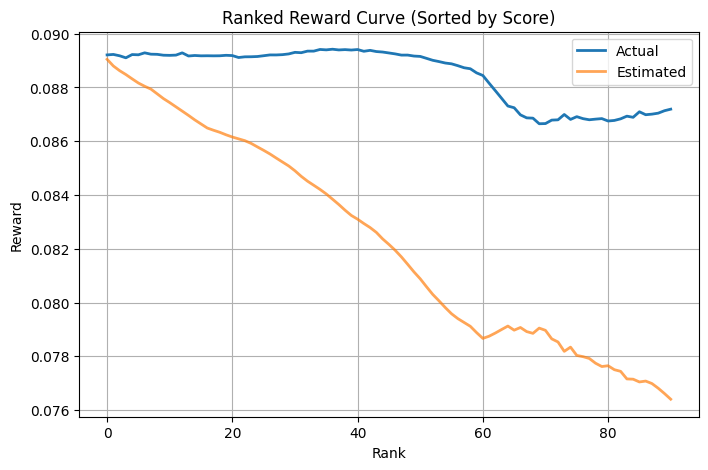

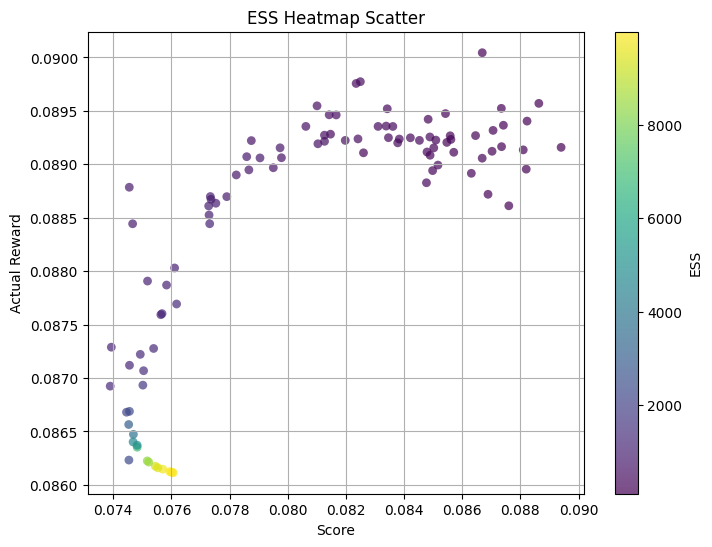

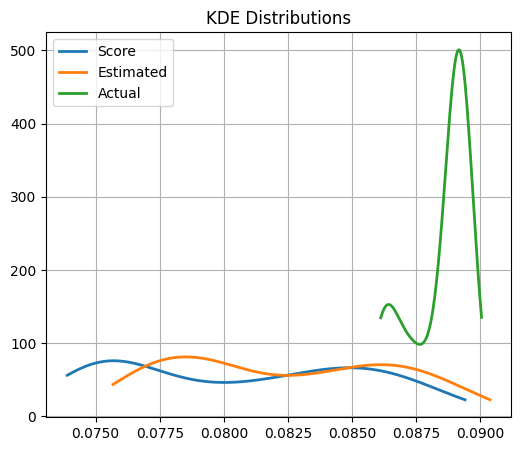

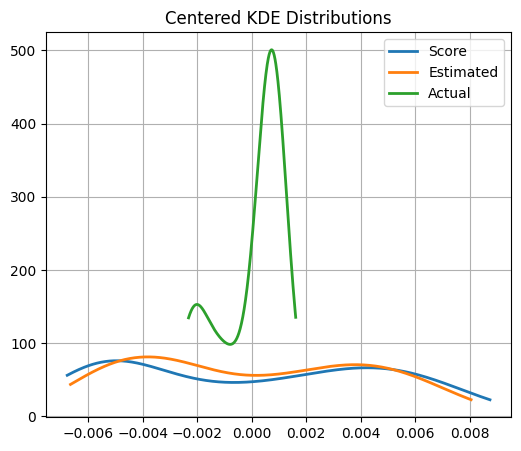

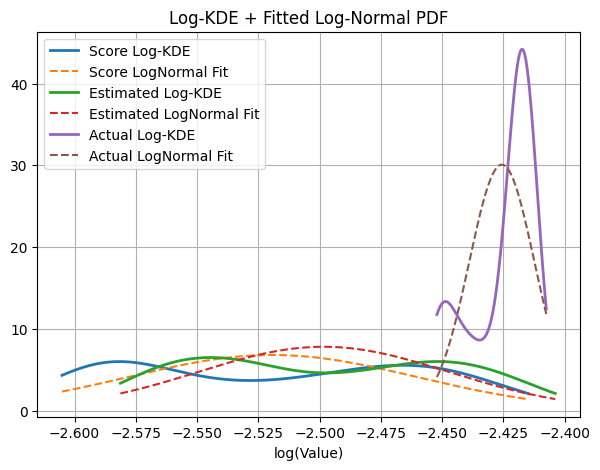

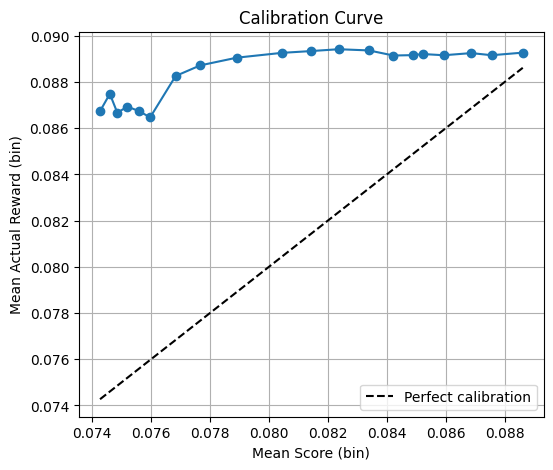

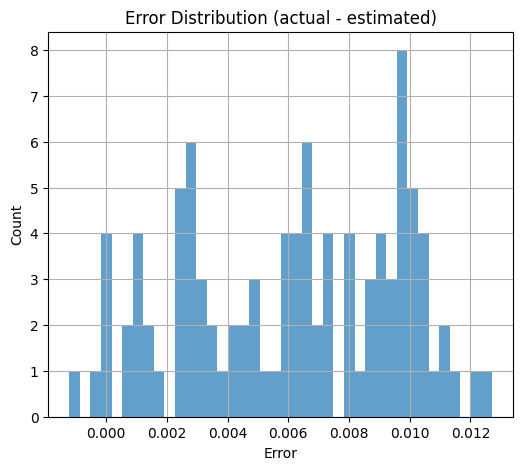

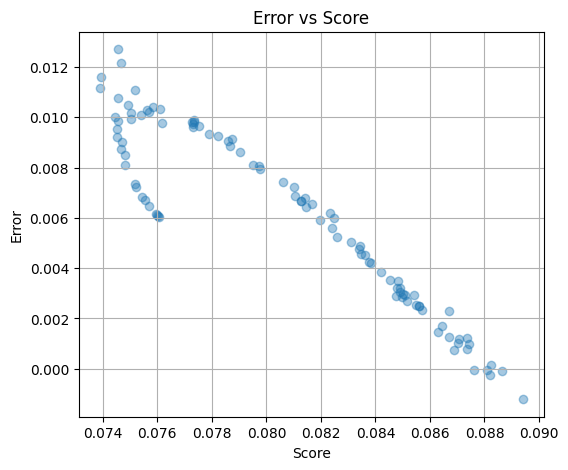

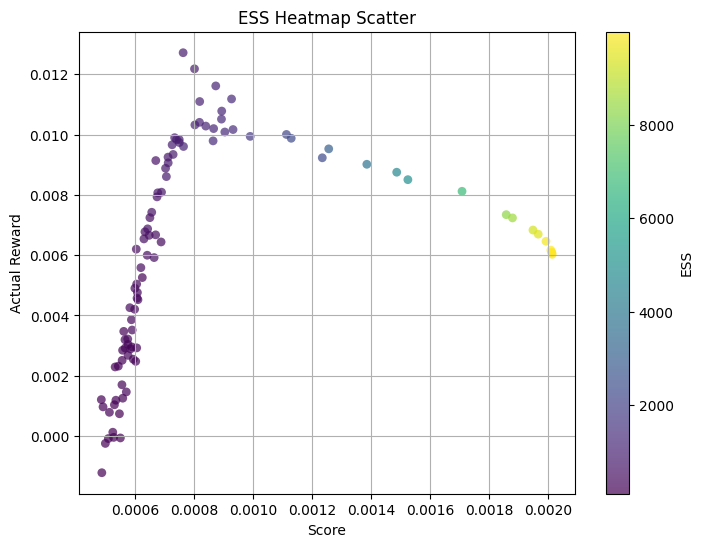

Correlation Metrics: {'pearson_score_actual': np.float64(0.7755977763914791), 'spearman_score_actual': np.float64(0.7318614718614718), 'spearman_est_actual': np.float64(0.6853555967841681)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9990768861755456), 'ndcg_est_actual': np.float64(0.9989881976744764)}
Error Metrics: {'mean_error': np.float64(0.006105940576269954), 'mae': np.float64(0.006139027716911285), 'rmse': np.float64(0.0070430472038426365), 'std_error': np.float64(0.0035102711568503805), 'max_error': np.float64(0.012711902038756634), 'min_error': np.float64(-0.0012134212098751929)}


In [10]:
study_df.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{12345}.csv")

compute_statistics_and_plots(study_df)

### Policy with delta function

In [11]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=10000)

Random Item CTR: 0.07083863592474163
Optimal greedy CTR: 0.09999916436977967
Second Best greedy CTR: 0.08797326118616329
Optimal Stochastic CTR: 0.0999493542444427
second Best Stochastic CTR: 0.0854530317781557
Our Initial CTR: 0.08557719469284641


In [12]:
# Run the optimization
df5, study_df5 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df5.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{10000}.csv")

# Show the performance metrics
df5[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 10000 samples: 0.06348443031311035 seconds
[Regression] Baseline regression model fit time: 0.05s
Num samples is 10000
{'gini': np.float64(0.46257394349044206), 'ess': np.float64(4658.309642713018), 'max_wi': np.float64(18.385370153300904), 'min_wi': np.float64(0.011938913044397847)}
Eval time: 0.5301234722137451 seconds


[I 2025-12-14 23:41:22,914] A new study created in memory with name: no-name-bf3f748e-c43e-444f-aac0-b4c4629ff00c


Evaluation total results time: 0.89 seconds

=== [Regression] Training size 15000, run 0 ===
Simulation time for 25000 samples: 0.061022043228149414 seconds


  0%|          | 0/155 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.07873128]
Validation weights_info: {'gini': np.float64(0.9748030566394923), 'ess': np.float64(13.551798984347627), 'max_wi': np.float64(3241.467210358279), 'min_wi': np.float64(0.0)}


Best trial: 0. Best value: -inf:   1%|          | 1/155 [00:03<09:26,  3.68s/it]

[I 2025-12-14 23:41:26,595] Trial 0 finished with value: -inf and parameters: {'lr': 0.096, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.85}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 1
actual reward: [0.08344326]
Validation weights_info: {'gini': np.float64(0.739216523585466), 'ess': np.float64(1763.7835095064454), 'max_wi': np.float64(14.329821598785882), 'min_wi': np.float64(0.009906204331025936)}


Best trial: 1. Best value: 0.0802495:   1%|▏         | 2/155 [00:06<07:27,  2.93s/it]

[I 2025-12-14 23:41:28,995] Trial 1 finished with value: 0.08024948496037947 and parameters: {'lr': 0.0008957901280807478, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9262852689634152}. Best is trial 1 with value: 0.08024948496037947.

[Regression] Optuna Trial 2
actual reward: [0.08506157]
Validation weights_info: {'gini': np.float64(0.9897613797970561), 'ess': np.float64(16.377738977944425), 'max_wi': np.float64(1093.9744290689864), 'min_wi': np.float64(1.354551694980039e-13)}


Best trial: 1. Best value: 0.0802495:   2%|▏         | 3/155 [00:08<06:16,  2.48s/it]

[I 2025-12-14 23:41:30,941] Trial 2 finished with value: -inf and parameters: {'lr': 0.03701785626980223, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8499073477558544}. Best is trial 1 with value: 0.08024948496037947.

[Regression] Optuna Trial 3
actual reward: [0.08533094]
Validation weights_info: {'gini': np.float64(0.1747815856477934), 'ess': np.float64(8875.809834112195), 'max_wi': np.float64(2.204888328253354), 'min_wi': np.float64(0.47936354395225234)}


Best trial: 1. Best value: 0.0802495:   3%|▎         | 4/155 [00:10<06:05,  2.42s/it]

[I 2025-12-14 23:41:33,271] Trial 3 finished with value: 0.07761327538238641 and parameters: {'lr': 0.00021725904312756684, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9175151470568488}. Best is trial 1 with value: 0.08024948496037947.

[Regression] Optuna Trial 4
actual reward: [0.08814931]
Validation weights_info: {'gini': np.float64(0.9961361774968774), 'ess': np.float64(14.196985332294439), 'max_wi': np.float64(890.5852869505333), 'min_wi': np.float64(4.938279666783094e-22)}


Best trial: 1. Best value: 0.0802495:   3%|▎         | 5/155 [00:12<06:09,  2.46s/it]

[I 2025-12-14 23:41:35,810] Trial 4 finished with value: -inf and parameters: {'lr': 0.046771463041221165, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.8056888239836114}. Best is trial 1 with value: 0.08024948496037947.

[Regression] Optuna Trial 5
actual reward: [0.08546173]
Validation weights_info: {'gini': np.float64(0.0889362618538438), 'ess': np.float64(9701.936644227188), 'max_wi': np.float64(1.5473777069424588), 'min_wi': np.float64(0.6938071844496021)}


Best trial: 1. Best value: 0.0802495:   4%|▍         | 6/155 [00:14<05:12,  2.10s/it]

[I 2025-12-14 23:41:37,207] Trial 5 finished with value: 0.0773318314703526 and parameters: {'lr': 0.00029829623716316994, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.8705975093288436}. Best is trial 1 with value: 0.08024948496037947.

[Regression] Optuna Trial 6
actual reward: [0.08280409]
Validation weights_info: {'gini': np.float64(0.9985942565732229), 'ess': np.float64(11.286224825284826), 'max_wi': np.float64(1009.7329978515052), 'min_wi': np.float64(9.541718963044276e-17)}


Best trial: 1. Best value: 0.0802495:   5%|▍         | 7/155 [00:15<04:41,  1.90s/it]

[I 2025-12-14 23:41:38,696] Trial 6 finished with value: -inf and parameters: {'lr': 0.05980746922915834, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.8592125322258255}. Best is trial 1 with value: 0.08024948496037947.

[Regression] Optuna Trial 7
actual reward: [0.08549686]
Validation weights_info: {'gini': np.float64(0.9943475308596388), 'ess': np.float64(11.848463740909517), 'max_wi': np.float64(1704.8071441697816), 'min_wi': np.float64(2.510948360493429e-11)}


Best trial: 1. Best value: 0.0802495:   5%|▌         | 8/155 [00:17<04:44,  1.93s/it]

[I 2025-12-14 23:41:40,699] Trial 7 finished with value: -inf and parameters: {'lr': 0.02016865670601522, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.9090696368274102}. Best is trial 1 with value: 0.08024948496037947.

[Regression] Optuna Trial 8
actual reward: [0.08709893]
Validation weights_info: {'gini': np.float64(0.9719607400616603), 'ess': np.float64(99.70165111196528), 'max_wi': np.float64(368.90485850114936), 'min_wi': np.float64(3.7314109386037214e-07)}


Best trial: 1. Best value: 0.0802495:   6%|▌         | 9/155 [00:19<04:29,  1.85s/it]

[I 2025-12-14 23:41:42,360] Trial 8 finished with value: -inf and parameters: {'lr': 0.008330090033005277, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9787385558370126}. Best is trial 1 with value: 0.08024948496037947.

[Regression] Optuna Trial 9
actual reward: [0.08129232]
Validation weights_info: {'gini': np.float64(0.9174393801678464), 'ess': np.float64(801.4040753695392), 'max_wi': np.float64(27.5773601171583), 'min_wi': np.float64(1.0945141555415856e-05)}


Best trial: 9. Best value: 0.0812622:   6%|▋         | 10/155 [00:20<04:01,  1.67s/it]

[I 2025-12-14 23:41:43,626] Trial 9 finished with value: 0.08126217326732574 and parameters: {'lr': 0.024929954295431572, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.8672805487222177}. Best is trial 9 with value: 0.08126217326732574.

[Regression] Optuna Trial 10
actual reward: [0.08806646]
Validation weights_info: {'gini': np.float64(0.8822485989112614), 'ess': np.float64(993.1318782744922), 'max_wi': np.float64(53.337300645829885), 'min_wi': np.float64(1.4707964844398158e-05)}


Best trial: 10. Best value: 0.0843053:   7%|▋         | 11/155 [00:23<04:30,  1.88s/it]

[I 2025-12-14 23:41:45,974] Trial 10 finished with value: 0.08430527932256537 and parameters: {'lr': 0.0029309386845184516, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9682343031272926}. Best is trial 10 with value: 0.08430527932256537.

[Regression] Optuna Trial 11
actual reward: [0.08840075]
Validation weights_info: {'gini': np.float64(0.8963484035353069), 'ess': np.float64(825.5199784163624), 'max_wi': np.float64(66.81051149512086), 'min_wi': np.float64(7.700249462348201e-06)}


Best trial: 11. Best value: 0.0853373:   8%|▊         | 12/155 [00:25<04:52,  2.05s/it]

[I 2025-12-14 23:41:48,407] Trial 11 finished with value: 0.0853373090162147 and parameters: {'lr': 0.0029803146702774654, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9869639060275854}. Best is trial 11 with value: 0.0853373090162147.

[Regression] Optuna Trial 12
actual reward: [0.0884278]
Validation weights_info: {'gini': np.float64(0.9221817984601753), 'ess': np.float64(468.78137006416006), 'max_wi': np.float64(103.92220631446564), 'min_wi': np.float64(2.336955961188734e-06)}


Best trial: 12. Best value: 0.0873915:   8%|▊         | 13/155 [00:27<05:04,  2.14s/it]

[I 2025-12-14 23:41:50,769] Trial 12 finished with value: 0.08739152729570729 and parameters: {'lr': 0.0031894159614190842, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9998466548483615}. Best is trial 12 with value: 0.08739152729570729.

[Regression] Optuna Trial 13
actual reward: [0.08637905]
Validation weights_info: {'gini': np.float64(0.8552507340551154), 'ess': np.float64(1269.43302854263), 'max_wi': np.float64(21.258905856210465), 'min_wi': np.float64(9.744539160873498e-05)}


Best trial: 12. Best value: 0.0873915:   9%|▉         | 14/155 [00:30<05:19,  2.26s/it]

[I 2025-12-14 23:41:53,315] Trial 13 finished with value: 0.08218274317271154 and parameters: {'lr': 0.0019643964660781277, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9997506689783932}. Best is trial 12 with value: 0.08739152729570729.

[Regression] Optuna Trial 14
actual reward: [0.08765844]
Validation weights_info: {'gini': np.float64(0.9691477744261744), 'ess': np.float64(145.72568149570222), 'max_wi': np.float64(257.3076521886668), 'min_wi': np.float64(4.3403955661091406e-07)}


Best trial: 14. Best value: 0.0910626:  10%|▉         | 15/155 [00:32<05:11,  2.23s/it]

[I 2025-12-14 23:41:55,461] Trial 14 finished with value: 0.09106259663086005 and parameters: {'lr': 0.00636777117629252, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9499183585162309}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 15
actual reward: [0.088646]
Validation weights_info: {'gini': np.float64(0.9890856333301554), 'ess': np.float64(24.17488661659505), 'max_wi': np.float64(1316.2918503215603), 'min_wi': np.float64(1.493336498835496e-13)}


Best trial: 14. Best value: 0.0910626:  10%|█         | 16/155 [00:37<07:19,  3.16s/it]

[I 2025-12-14 23:42:00,784] Trial 15 finished with value: -inf and parameters: {'lr': 0.010086164995269114, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9447351792123362}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 16
actual reward: [0.08304911]
Validation weights_info: {'gini': np.float64(0.8660943794524714), 'ess': np.float64(1066.3891494365412), 'max_wi': np.float64(24.464726060187076), 'min_wi': np.float64(0.0003716669891108525)}


Best trial: 14. Best value: 0.0910626:  11%|█         | 17/155 [00:41<07:35,  3.30s/it]

[I 2025-12-14 23:42:04,407] Trial 16 finished with value: 0.08141784042376615 and parameters: {'lr': 0.0007772034568333338, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.9541044584606146}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 17
actual reward: [0.08755861]
Validation weights_info: {'gini': np.float64(0.9842257684132938), 'ess': np.float64(56.42918599236186), 'max_wi': np.float64(576.643986863938), 'min_wi': np.float64(6.404180902818897e-08)}


Best trial: 14. Best value: 0.0910626:  12%|█▏        | 18/155 [00:43<06:46,  2.97s/it]

[I 2025-12-14 23:42:06,607] Trial 17 finished with value: -inf and parameters: {'lr': 0.007995437554099089, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9451007313249498}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 18
actual reward: [0.08413919]
Validation weights_info: {'gini': np.float64(0.6183492752096832), 'ess': np.float64(2799.0497987771564), 'max_wi': np.float64(9.830954933274478), 'min_wi': np.float64(0.03966584438506783)}


Best trial: 14. Best value: 0.0910626:  12%|█▏        | 19/155 [00:46<06:25,  2.83s/it]

[I 2025-12-14 23:42:09,120] Trial 18 finished with value: 0.07994731518196035 and parameters: {'lr': 0.0008592605027857552, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9640247849727103}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 19
actual reward: [0.08548734]
Validation weights_info: {'gini': np.float64(0.06683479612357468), 'ess': np.float64(9831.497531821395), 'max_wi': np.float64(1.3796249534909195), 'min_wi': np.float64(0.7736608982934496)}


Best trial: 14. Best value: 0.0910626:  13%|█▎        | 20/155 [00:48<05:49,  2.59s/it]

[I 2025-12-14 23:42:11,131] Trial 19 finished with value: 0.0772721252111787 and parameters: {'lr': 0.00010570050498602556, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9992118484355307}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 20
actual reward: [0.08743462]
Validation weights_info: {'gini': np.float64(0.9922276115053269), 'ess': np.float64(8.9021666151529), 'max_wi': np.float64(2801.7426479168234), 'min_wi': np.float64(1.7099370426062832e-11)}


Best trial: 14. Best value: 0.0910626:  14%|█▎        | 21/155 [00:52<06:41,  3.00s/it]

[I 2025-12-14 23:42:15,093] Trial 20 finished with value: -inf and parameters: {'lr': 0.0066236930472166385, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.8956045491673522}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 21
actual reward: [0.08593255]
Validation weights_info: {'gini': np.float64(0.8577920656104464), 'ess': np.float64(1236.8659770925292), 'max_wi': np.float64(22.431287382546085), 'min_wi': np.float64(0.00012470537746377984)}


Best trial: 14. Best value: 0.0910626:  14%|█▍        | 22/155 [00:54<06:19,  2.85s/it]

[I 2025-12-14 23:42:17,603] Trial 21 finished with value: 0.08206576934295996 and parameters: {'lr': 0.002079571622554554, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9818383744622774}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 22
actual reward: [0.08790162]
Validation weights_info: {'gini': np.float64(0.9589612864750459), 'ess': np.float64(171.25880145055734), 'max_wi': np.float64(315.2594508140505), 'min_wi': np.float64(5.847565903686343e-07)}


Best trial: 14. Best value: 0.0910626:  15%|█▍        | 23/155 [00:57<06:03,  2.76s/it]

[I 2025-12-14 23:42:20,134] Trial 22 finished with value: 0.09030082066184641 and parameters: {'lr': 0.004761294531091683, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9809976588071933}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 23
actual reward: [0.08829661]
Validation weights_info: {'gini': np.float64(0.9375401341977813), 'ess': np.float64(323.21422996550183), 'max_wi': np.float64(149.89115020387283), 'min_wi': np.float64(1.7993719560927194e-06)}


Best trial: 14. Best value: 0.0910626:  15%|█▌        | 24/155 [00:59<05:40,  2.60s/it]

[I 2025-12-14 23:42:22,366] Trial 23 finished with value: 0.08862000159118377 and parameters: {'lr': 0.004990884789149005, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9375736967634621}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 24
actual reward: [0.09079295]
Validation weights_info: {'gini': np.float64(0.9904780290998574), 'ess': np.float64(14.869425658468028), 'max_wi': np.float64(1486.1248618911823), 'min_wi': np.float64(2.2605113289085785e-15)}


Best trial: 14. Best value: 0.0910626:  16%|█▌        | 25/155 [01:04<07:12,  3.33s/it]

[I 2025-12-14 23:42:27,396] Trial 24 finished with value: -inf and parameters: {'lr': 0.013491510987173978, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9317594019348923}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 25
actual reward: [0.08689943]
Validation weights_info: {'gini': np.float64(0.8646008759716102), 'ess': np.float64(1214.8954602114718), 'max_wi': np.float64(24.675204276960876), 'min_wi': np.float64(5.7384707086912396e-05)}


Best trial: 14. Best value: 0.0910626:  17%|█▋        | 26/155 [01:06<06:35,  3.06s/it]

[I 2025-12-14 23:42:29,844] Trial 25 finished with value: 0.08266747493566472 and parameters: {'lr': 0.0037392867267847817, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8860089913576501}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 26
actual reward: [0.08800627]
Validation weights_info: {'gini': np.float64(0.9525066741228594), 'ess': np.float64(210.989201386662), 'max_wi': np.float64(180.51865773910674), 'min_wi': np.float64(1.1586550550495033e-06)}


Best trial: 14. Best value: 0.0910626:  17%|█▋        | 27/155 [01:09<06:02,  2.83s/it]

[I 2025-12-14 23:42:32,124] Trial 26 finished with value: 0.08988943739622461 and parameters: {'lr': 0.0059404259326427105, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9346912170355447}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 27
actual reward: [0.0838438]
Validation weights_info: {'gini': np.float64(0.6920382446400822), 'ess': np.float64(2136.864187261163), 'max_wi': np.float64(12.653309611152059), 'min_wi': np.float64(0.02121314309659058)}


Best trial: 14. Best value: 0.0910626:  18%|█▊        | 28/155 [01:11<05:31,  2.61s/it]

[I 2025-12-14 23:42:34,225] Trial 27 finished with value: 0.08019906123297318 and parameters: {'lr': 0.001459472798181398, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9594944941243273}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 28
actual reward: [0.08662369]
Validation weights_info: {'gini': np.float64(0.9967110958458114), 'ess': np.float64(18.496236668932976), 'max_wi': np.float64(1097.0661115627324), 'min_wi': np.float64(1.1865654288964693e-12)}


Best trial: 14. Best value: 0.0910626:  19%|█▊        | 29/155 [01:13<05:13,  2.49s/it]

[I 2025-12-14 23:42:36,436] Trial 28 finished with value: -inf and parameters: {'lr': 0.01965328576552038, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9723775193444881}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 29
actual reward: [0.08966074]
Validation weights_info: {'gini': np.float64(0.9894758628502963), 'ess': np.float64(8.072325169427721), 'max_wi': np.float64(2975.2404190091274), 'min_wi': np.float64(9.206701126182805e-14)}


Best trial: 14. Best value: 0.0910626:  19%|█▉        | 30/155 [01:17<06:24,  3.08s/it]

[I 2025-12-14 23:42:40,876] Trial 29 finished with value: -inf and parameters: {'lr': 0.013808400946992901, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9144801953594092}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 30
actual reward: [0.07727478]
Validation weights_info: {'gini': np.float64(0.9973470509139478), 'ess': np.float64(3.570679761928097), 'max_wi': np.float64(10150.595060523065), 'min_wi': np.float64(0.0)}


Best trial: 14. Best value: 0.0910626:  20%|██        | 31/155 [01:20<06:09,  2.98s/it]

[I 2025-12-14 23:42:43,637] Trial 30 finished with value: -inf and parameters: {'lr': 0.09921415860702362, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9522412764968988}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 31
actual reward: [0.08834547]
Validation weights_info: {'gini': np.float64(0.9385032409035269), 'ess': np.float64(313.2421583608373), 'max_wi': np.float64(166.2185090066503), 'min_wi': np.float64(1.3582146349269055e-06)}


Best trial: 14. Best value: 0.0910626:  21%|██        | 32/155 [01:22<05:34,  2.72s/it]

[I 2025-12-14 23:42:45,740] Trial 31 finished with value: 0.08844715739748914 and parameters: {'lr': 0.0051129983071378764, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9313630360622659}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 32
actual reward: [0.08815925]
Validation weights_info: {'gini': np.float64(0.949219640556036), 'ess': np.float64(246.42541978673322), 'max_wi': np.float64(206.94008938823478), 'min_wi': np.float64(1.1085506994050031e-06)}


Best trial: 14. Best value: 0.0910626:  21%|██▏       | 33/155 [01:25<05:17,  2.60s/it]

[I 2025-12-14 23:42:48,079] Trial 32 finished with value: 0.08968226966120806 and parameters: {'lr': 0.005331153680056668, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9371290485391529}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 33
actual reward: [0.08352509]
Validation weights_info: {'gini': np.float64(0.7502122112253602), 'ess': np.float64(1695.411072592162), 'max_wi': np.float64(14.990385783556622), 'min_wi': np.float64(0.011034784596383806)}


Best trial: 14. Best value: 0.0910626:  22%|██▏       | 34/155 [01:27<05:00,  2.49s/it]

[I 2025-12-14 23:42:50,292] Trial 33 finished with value: 0.08020965448118811 and parameters: {'lr': 0.0014783922949588215, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9222344547424639}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 34
actual reward: [0.08838244]
Validation weights_info: {'gini': np.float64(0.9139736443508717), 'ess': np.float64(575.7196676355203), 'max_wi': np.float64(80.36847965555596), 'min_wi': np.float64(6.355240245645255e-06)}


Best trial: 14. Best value: 0.0910626:  23%|██▎       | 35/155 [01:29<04:48,  2.40s/it]

[I 2025-12-14 23:42:52,494] Trial 34 finished with value: 0.0871218366004193 and parameters: {'lr': 0.005361481590618231, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9400212205055339}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 35
actual reward: [0.09066643]
Validation weights_info: {'gini': np.float64(0.9909207262228025), 'ess': np.float64(10.49515706768483), 'max_wi': np.float64(3068.6469963933605), 'min_wi': np.float64(6.974134446189377e-14)}


Best trial: 14. Best value: 0.0910626:  23%|██▎       | 36/155 [01:34<06:26,  3.24s/it]

[I 2025-12-14 23:42:57,707] Trial 35 finished with value: -inf and parameters: {'lr': 0.010749676172425627, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.9003757435054799}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 36
actual reward: [0.08476556]
Validation weights_info: {'gini': np.float64(0.9984241001460877), 'ess': np.float64(5.908058764634297), 'max_wi': np.float64(3207.932328260971), 'min_wi': np.float64(5.850188490217151e-13)}


Best trial: 14. Best value: 0.0910626:  24%|██▍       | 37/155 [01:36<05:44,  2.92s/it]

[I 2025-12-14 23:42:59,875] Trial 36 finished with value: -inf and parameters: {'lr': 0.030450313681047864, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8297855262518522}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 37
actual reward: [0.08742134]
Validation weights_info: {'gini': np.float64(0.9942484932698419), 'ess': np.float64(18.082721848625077), 'max_wi': np.float64(1553.3482771907534), 'min_wi': np.float64(8.080696978588606e-09)}


Best trial: 14. Best value: 0.0910626:  25%|██▍       | 38/155 [01:38<05:01,  2.58s/it]

[I 2025-12-14 23:43:01,659] Trial 37 finished with value: -inf and parameters: {'lr': 0.014518094814464309, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.9534734228043189}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 38
actual reward: [0.08449675]
Validation weights_info: {'gini': np.float64(0.5148020346645062), 'ess': np.float64(3884.0705539619603), 'max_wi': np.float64(7.435845704542769), 'min_wi': np.float64(0.07079052084050935)}


Best trial: 14. Best value: 0.0910626:  25%|██▌       | 39/155 [01:40<04:47,  2.48s/it]

[I 2025-12-14 23:43:03,892] Trial 38 finished with value: 0.07941329354475586 and parameters: {'lr': 0.0005460963128464604, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9241338394470355}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 39
actual reward: [0.08617558]
Validation weights_info: {'gini': np.float64(0.9896106965781226), 'ess': np.float64(5.129883887441531), 'max_wi': np.float64(5082.467744427713), 'min_wi': np.float64(4.182234264744344e-10)}


Best trial: 14. Best value: 0.0910626:  26%|██▌       | 40/155 [01:44<05:19,  2.77s/it]

[I 2025-12-14 23:43:07,363] Trial 39 finished with value: -inf and parameters: {'lr': 0.00419562595797052, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.904193077284009}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 40
actual reward: [0.08305378]
Validation weights_info: {'gini': np.float64(0.8370517573657105), 'ess': np.float64(1176.2897442426804), 'max_wi': np.float64(18.94174944462982), 'min_wi': np.float64(0.0013820229120675067)}


Best trial: 14. Best value: 0.0910626:  26%|██▋       | 41/155 [01:46<04:46,  2.51s/it]

[I 2025-12-14 23:43:09,255] Trial 40 finished with value: 0.08061207812291321 and parameters: {'lr': 0.0022614958383669575, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.973316363369909}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 41
actual reward: [0.08787976]
Validation weights_info: {'gini': np.float64(0.9650660548827972), 'ess': np.float64(158.20065908370808), 'max_wi': np.float64(256.5812111042724), 'min_wi': np.float64(3.8310500788409184e-07)}


Best trial: 14. Best value: 0.0910626:  27%|██▋       | 42/155 [01:48<04:37,  2.46s/it]

[I 2025-12-14 23:43:11,596] Trial 41 finished with value: 0.09059342797059541 and parameters: {'lr': 0.005985594973157028, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9349553544658827}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 42
actual reward: [0.08828688]
Validation weights_info: {'gini': np.float64(0.9362858663981389), 'ess': np.float64(334.35490311528116), 'max_wi': np.float64(147.18298357446594), 'min_wi': np.float64(1.4986339891143377e-06)}


Best trial: 14. Best value: 0.0910626:  28%|██▊       | 43/155 [01:50<04:23,  2.35s/it]

[I 2025-12-14 23:43:13,694] Trial 42 finished with value: 0.0887974669146269 and parameters: {'lr': 0.006430709662004742, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8862621088525231}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 43
actual reward: [0.08672748]
Validation weights_info: {'gini': np.float64(0.9931929708358694), 'ess': np.float64(24.65592359979855), 'max_wi': np.float64(948.2130056357627), 'min_wi': np.float64(2.6240343577368058e-09)}


Best trial: 14. Best value: 0.0910626:  28%|██▊       | 44/155 [01:53<04:22,  2.36s/it]

[I 2025-12-14 23:43:16,078] Trial 43 finished with value: -inf and parameters: {'lr': 0.0077006048565132915, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9879586662280333}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 44
actual reward: [0.08429928]
Validation weights_info: {'gini': np.float64(0.8553418675675866), 'ess': np.float64(1184.868923834789), 'max_wi': np.float64(18.85829345899326), 'min_wi': np.float64(0.0003255524955448606)}


Best trial: 14. Best value: 0.0910626:  29%|██▉       | 45/155 [01:55<04:24,  2.40s/it]

[I 2025-12-14 23:43:18,578] Trial 44 finished with value: 0.08151199796941082 and parameters: {'lr': 0.0014335147796040936, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9132402333694409}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 45
actual reward: [0.08837955]
Validation weights_info: {'gini': np.float64(0.9305048050177578), 'ess': np.float64(392.941663125556), 'max_wi': np.float64(140.3615246112503), 'min_wi': np.float64(1.8279595914260582e-06)}


Best trial: 14. Best value: 0.0910626:  30%|██▉       | 46/155 [01:58<04:24,  2.43s/it]

[I 2025-12-14 23:43:21,067] Trial 45 finished with value: 0.08796876905375377 and parameters: {'lr': 0.0040043440313346675, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9621470839141588}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 46
actual reward: [0.07987696]
Validation weights_info: {'gini': np.float64(0.997753549450383), 'ess': np.float64(11.529281431159543), 'max_wi': np.float64(2172.423193438012), 'min_wi': np.float64(4.748390038891556e-14)}


Best trial: 14. Best value: 0.0910626:  30%|███       | 47/155 [02:00<04:16,  2.38s/it]

[I 2025-12-14 23:43:23,328] Trial 46 finished with value: -inf and parameters: {'lr': 0.04438925902600185, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9316612108399631}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 47
actual reward: [0.08678855]
Validation weights_info: {'gini': np.float64(0.994875597174818), 'ess': np.float64(29.624614179964258), 'max_wi': np.float64(610.74101629006), 'min_wi': np.float64(6.154165477936566e-10)}


Best trial: 14. Best value: 0.0910626:  31%|███       | 48/155 [02:02<04:12,  2.36s/it]

[I 2025-12-14 23:43:25,658] Trial 47 finished with value: -inf and parameters: {'lr': 0.010968564486791014, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9430591672862545}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 48
actual reward: [0.0834229]
Validation weights_info: {'gini': np.float64(0.9935704248841203), 'ess': np.float64(9.769719586604053), 'max_wi': np.float64(1503.597374171392), 'min_wi': np.float64(1.2985465631359887e-10)}


Best trial: 14. Best value: 0.0910626:  32%|███▏      | 49/155 [02:04<03:53,  2.21s/it]

[I 2025-12-14 23:43:27,500] Trial 48 finished with value: -inf and parameters: {'lr': 0.019476997645596163, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.9505399206878604}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 49
actual reward: [0.08484446]
Validation weights_info: {'gini': np.float64(0.8521825048484979), 'ess': np.float64(1242.3075321797057), 'max_wi': np.float64(18.820859961140485), 'min_wi': np.float64(0.0002891267883806528)}


Best trial: 14. Best value: 0.0910626:  32%|███▏      | 50/155 [02:06<03:51,  2.21s/it]

[I 2025-12-14 23:43:29,705] Trial 49 finished with value: 0.08145609583759081 and parameters: {'lr': 0.002367300471860886, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9238139803784563}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 50
actual reward: [0.08663976]
Validation weights_info: {'gini': np.float64(0.9914889139718777), 'ess': np.float64(25.33972474306892), 'max_wi': np.float64(1155.0364572991034), 'min_wi': np.float64(1.2492387117973792e-08)}


Best trial: 14. Best value: 0.0910626:  33%|███▎      | 51/155 [02:09<03:49,  2.21s/it]

[I 2025-12-14 23:43:31,919] Trial 50 finished with value: -inf and parameters: {'lr': 0.009368340316968272, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9783212532450748}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 51
actual reward: [0.08826139]
Validation weights_info: {'gini': np.float64(0.9323746119364471), 'ess': np.float64(384.93202767978113), 'max_wi': np.float64(152.1045067994927), 'min_wi': np.float64(2.120086025688563e-06)}


Best trial: 14. Best value: 0.0910626:  34%|███▎      | 52/155 [02:11<03:55,  2.28s/it]

[I 2025-12-14 23:43:34,375] Trial 51 finished with value: 0.08827516001293403 and parameters: {'lr': 0.006322407383106009, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8858048131369005}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 52
actual reward: [0.08501337]
Validation weights_info: {'gini': np.float64(0.8508302608827439), 'ess': np.float64(1251.6415027135517), 'max_wi': np.float64(18.74230718855687), 'min_wi': np.float64(0.00027209630558218677)}


Best trial: 14. Best value: 0.0910626:  34%|███▍      | 53/155 [02:13<03:49,  2.25s/it]

[I 2025-12-14 23:43:36,542] Trial 52 finished with value: 0.08153223808551208 and parameters: {'lr': 0.003305465668970656, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8737151782104388}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 53
actual reward: [0.08831361]
Validation weights_info: {'gini': np.float64(0.9344920469818196), 'ess': np.float64(364.4447468507394), 'max_wi': np.float64(135.73629883704325), 'min_wi': np.float64(2.4584175382392554e-06)}


Best trial: 14. Best value: 0.0910626:  35%|███▍      | 54/155 [02:15<03:45,  2.23s/it]

[I 2025-12-14 23:43:38,730] Trial 53 finished with value: 0.08826268840187088 and parameters: {'lr': 0.005834627373324389, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8928711976477415}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 54
actual reward: [0.08826894]
Validation weights_info: {'gini': np.float64(0.936430281105144), 'ess': np.float64(337.37338785599314), 'max_wi': np.float64(144.40803108490104), 'min_wi': np.float64(1.763418093871157e-06)}


Best trial: 14. Best value: 0.0910626:  35%|███▌      | 55/155 [02:17<03:35,  2.16s/it]

[I 2025-12-14 23:43:40,721] Trial 54 finished with value: 0.08876069360486441 and parameters: {'lr': 0.0076371477441522445, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.8600441599257225}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 55
actual reward: [0.0831504]
Validation weights_info: {'gini': np.float64(0.7878576648675989), 'ess': np.float64(1470.9797115715223), 'max_wi': np.float64(41.499617304012716), 'min_wi': np.float64(0.005704502517645157)}


Best trial: 14. Best value: 0.0910626:  36%|███▌      | 56/155 [02:19<03:18,  2.01s/it]

[I 2025-12-14 23:43:42,374] Trial 55 finished with value: 0.08108499562984504 and parameters: {'lr': 0.002597358046724319, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.8414033570163837}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 56
actual reward: [0.08811773]
Validation weights_info: {'gini': np.float64(0.8816983513323547), 'ess': np.float64(1014.22126317332), 'max_wi': np.float64(48.62681884329214), 'min_wi': np.float64(1.539897879817648e-05)}


Best trial: 14. Best value: 0.0910626:  37%|███▋      | 57/155 [02:21<03:31,  2.16s/it]

[I 2025-12-14 23:43:44,892] Trial 56 finished with value: 0.08418859315383886 and parameters: {'lr': 0.0043340298579515055, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.8786555415969561}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 57
actual reward: [0.08865611]
Validation weights_info: {'gini': np.float64(0.9923364395862924), 'ess': np.float64(16.941681183206462), 'max_wi': np.float64(1858.2976824907673), 'min_wi': np.float64(4.7427438873667786e-12)}


Best trial: 14. Best value: 0.0910626:  37%|███▋      | 58/155 [02:25<04:09,  2.57s/it]

[I 2025-12-14 23:43:48,421] Trial 57 finished with value: -inf and parameters: {'lr': 0.006783717349821034, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9368622762453673}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 58
actual reward: [0.08569406]
Validation weights_info: {'gini': np.float64(0.9975767843562926), 'ess': np.float64(13.103783314976377), 'max_wi': np.float64(1216.2092486562785), 'min_wi': np.float64(7.221769975985312e-11)}


Best trial: 14. Best value: 0.0910626:  38%|███▊      | 59/155 [02:27<03:53,  2.43s/it]

[I 2025-12-14 23:43:50,519] Trial 58 finished with value: -inf and parameters: {'lr': 0.017144168457300952, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9077341647312651}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 59
actual reward: [0.08295796]
Validation weights_info: {'gini': np.float64(0.8237000744045191), 'ess': np.float64(1229.0172093886663), 'max_wi': np.float64(18.243880060494764), 'min_wi': np.float64(0.0022723451687170814)}


Best trial: 14. Best value: 0.0910626:  39%|███▊      | 60/155 [02:29<03:40,  2.32s/it]

[I 2025-12-14 23:43:52,596] Trial 59 finished with value: 0.08050238158370533 and parameters: {'lr': 0.001721515135086256, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9876413254688914}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 60
actual reward: [0.08485752]
Validation weights_info: {'gini': np.float64(0.4064509961255435), 'ess': np.float64(5438.359334692632), 'max_wi': np.float64(4.755975805854476), 'min_wi': np.float64(0.1586373590846243)}


Best trial: 14. Best value: 0.0910626:  39%|███▉      | 61/155 [02:31<03:23,  2.17s/it]

[I 2025-12-14 23:43:54,404] Trial 60 finished with value: 0.07882946736399873 and parameters: {'lr': 0.0011137201243994535, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.9484629683230538}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 61
actual reward: [0.08804801]
Validation weights_info: {'gini': np.float64(0.951939369715995), 'ess': np.float64(227.57805946398443), 'max_wi': np.float64(216.41041584611884), 'min_wi': np.float64(9.632209255867439e-07)}


Best trial: 14. Best value: 0.0910626:  40%|████      | 62/155 [02:33<03:21,  2.16s/it]

[I 2025-12-14 23:43:56,556] Trial 61 finished with value: 0.09000055030829483 and parameters: {'lr': 0.008479831503093192, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.8615010731582149}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 62
actual reward: [0.08750782]
Validation weights_info: {'gini': np.float64(0.9756849344667102), 'ess': np.float64(89.84270801981562), 'max_wi': np.float64(334.22592190550216), 'min_wi': np.float64(2.690538324803744e-07)}


Best trial: 14. Best value: 0.0910626:  41%|████      | 63/155 [02:35<03:15,  2.13s/it]

[I 2025-12-14 23:43:58,599] Trial 62 finished with value: -inf and parameters: {'lr': 0.009586497724971974, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8477604887851269}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 63
actual reward: [0.08299229]
Validation weights_info: {'gini': np.float64(0.831838259691519), 'ess': np.float64(1218.5829643930188), 'max_wi': np.float64(18.946538206730324), 'min_wi': np.float64(0.0017347700752937617)}


Best trial: 14. Best value: 0.0910626:  41%|████▏     | 64/155 [02:37<03:14,  2.13s/it]

[I 2025-12-14 23:44:00,745] Trial 63 finished with value: 0.08064132552599962 and parameters: {'lr': 0.003118931096314199, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.8022031916944271}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 64
actual reward: [0.08714847]
Validation weights_info: {'gini': np.float64(0.9894107281556059), 'ess': np.float64(47.930527974312845), 'max_wi': np.float64(517.4788007000312), 'min_wi': np.float64(1.6916501768026672e-08)}


Best trial: 14. Best value: 0.0910626:  42%|████▏     | 65/155 [02:39<03:12,  2.14s/it]

[I 2025-12-14 23:44:02,907] Trial 64 finished with value: -inf and parameters: {'lr': 0.011794707830470314, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8605434187305546}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 65
actual reward: [0.08622084]
Validation weights_info: {'gini': np.float64(0.859696078044951), 'ess': np.float64(1241.1336029036006), 'max_wi': np.float64(20.303837064595868), 'min_wi': np.float64(7.212712761781067e-05)}


Best trial: 14. Best value: 0.0910626:  43%|████▎     | 66/155 [02:42<03:08,  2.12s/it]

[I 2025-12-14 23:44:04,974] Trial 65 finished with value: 0.08219390555413181 and parameters: {'lr': 0.004686700637799951, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8182376525902187}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 66
actual reward: [0.07692723]
Validation weights_info: {'gini': np.float64(0.9977331545630842), 'ess': np.float64(6.599083138626307), 'max_wi': np.float64(1219.2119169373302), 'min_wi': np.float64(2.2525950660229843e-12)}


Best trial: 14. Best value: 0.0910626:  43%|████▎     | 67/155 [02:44<03:10,  2.17s/it]

[I 2025-12-14 23:44:07,251] Trial 66 finished with value: -inf and parameters: {'lr': 0.025803886600609883, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9672336264824585}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 67
actual reward: [0.09059837]
Validation weights_info: {'gini': np.float64(0.9880217833222154), 'ess': np.float64(18.34474304524667), 'max_wi': np.float64(1998.1790434503537), 'min_wi': np.float64(2.0491804234031914e-12)}


Best trial: 14. Best value: 0.0910626:  44%|████▍     | 68/155 [02:48<04:02,  2.79s/it]

[I 2025-12-14 23:44:11,496] Trial 67 finished with value: -inf and parameters: {'lr': 0.005873719450677336, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.958600436228885}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 68
actual reward: [0.08130305]
Validation weights_info: {'gini': np.float64(0.9959498668947985), 'ess': np.float64(14.594234567564943), 'max_wi': np.float64(1198.3831105183754), 'min_wi': np.float64(9.275211588545014e-24)}


Best trial: 14. Best value: 0.0910626:  45%|████▍     | 69/155 [02:50<03:39,  2.55s/it]

[I 2025-12-14 23:44:13,482] Trial 68 finished with value: -inf and parameters: {'lr': 0.06627535267852765, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9172145991745997}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 69
actual reward: [0.08774904]
Validation weights_info: {'gini': np.float64(0.9655142980883208), 'ess': np.float64(147.30982383159076), 'max_wi': np.float64(331.7317105367096), 'min_wi': np.float64(3.028550823939667e-07)}


Best trial: 14. Best value: 0.0910626:  45%|████▌     | 70/155 [02:52<03:27,  2.44s/it]

[I 2025-12-14 23:44:15,666] Trial 69 finished with value: 0.09100426006755499 and parameters: {'lr': 0.008426190556225795, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8678965307523754}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 70
actual reward: [0.08930138]
Validation weights_info: {'gini': np.float64(0.9929617838344735), 'ess': np.float64(14.853323370933444), 'max_wi': np.float64(2334.392916240858), 'min_wi': np.float64(1.4458674740287425e-12)}


Best trial: 14. Best value: 0.0910626:  46%|████▌     | 71/155 [02:56<03:52,  2.77s/it]

[I 2025-12-14 23:44:19,206] Trial 70 finished with value: -inf and parameters: {'lr': 0.008213070151750436, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9359772840957272}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 71
actual reward: [0.08822877]
Validation weights_info: {'gini': np.float64(0.9341825715237497), 'ess': np.float64(341.1751109032519), 'max_wi': np.float64(161.98858538417753), 'min_wi': np.float64(3.1198717277272388e-06)}


Best trial: 14. Best value: 0.0910626:  46%|████▋     | 72/155 [02:58<03:27,  2.51s/it]

[I 2025-12-14 23:44:21,094] Trial 71 finished with value: 0.08865090867732242 and parameters: {'lr': 0.006702815271290846, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8663741371749484}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 72
actual reward: [0.08598154]
Validation weights_info: {'gini': np.float64(0.9949843630562356), 'ess': np.float64(18.31649272909474), 'max_wi': np.float64(1180.333967138887), 'min_wi': np.float64(1.6062191593381203e-09)}


Best trial: 14. Best value: 0.0910626:  47%|████▋     | 73/155 [03:00<03:17,  2.41s/it]

[I 2025-12-14 23:44:23,265] Trial 72 finished with value: -inf and parameters: {'lr': 0.014221932064906247, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8804880509433398}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 73
actual reward: [0.08485041]
Validation weights_info: {'gini': np.float64(0.8515023643752664), 'ess': np.float64(1240.8803190941114), 'max_wi': np.float64(18.514789373238628), 'min_wi': np.float64(0.00032192510293313937)}


Best trial: 14. Best value: 0.0910626:  48%|████▊     | 74/155 [03:02<03:04,  2.28s/it]

[I 2025-12-14 23:44:25,242] Trial 73 finished with value: 0.08148286536179553 and parameters: {'lr': 0.0036877995497753397, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.8540678882817629}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 74
actual reward: [0.08852505]
Validation weights_info: {'gini': np.float64(0.9068881811795693), 'ess': np.float64(658.0575540478691), 'max_wi': np.float64(83.72329206686095), 'min_wi': np.float64(5.456467339780718e-06)}


Best trial: 14. Best value: 0.0910626:  48%|████▊     | 75/155 [03:04<03:02,  2.28s/it]

[I 2025-12-14 23:44:27,542] Trial 74 finished with value: 0.08597278198920491 and parameters: {'lr': 0.005057705390328012, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.891088409250383}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 75
actual reward: [0.08714373]
Validation weights_info: {'gini': np.float64(0.9927054883723412), 'ess': np.float64(24.06855610870886), 'max_wi': np.float64(1056.0744245095361), 'min_wi': np.float64(6.70955655819678e-09)}


Best trial: 14. Best value: 0.0910626:  49%|████▉     | 76/155 [03:06<02:58,  2.26s/it]

[I 2025-12-14 23:44:29,761] Trial 75 finished with value: -inf and parameters: {'lr': 0.00855446827103765, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9927644406123156}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 76
actual reward: [0.08728992]
Validation weights_info: {'gini': np.float64(0.9928704796347867), 'ess': np.float64(27.279856844369274), 'max_wi': np.float64(779.3734224477636), 'min_wi': np.float64(1.0499501744593039e-08)}


Best trial: 14. Best value: 0.0910626:  50%|████▉     | 77/155 [03:09<03:00,  2.31s/it]

[I 2025-12-14 23:44:32,177] Trial 76 finished with value: -inf and parameters: {'lr': 0.011999320054810638, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8681621004761573}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 77
actual reward: [0.08547518]
Validation weights_info: {'gini': np.float64(0.8496495757196754), 'ess': np.float64(1271.04941923341), 'max_wi': np.float64(19.01191058644983), 'min_wi': np.float64(0.00024761705134437395)}


Best trial: 14. Best value: 0.0910626:  50%|█████     | 78/155 [03:11<02:57,  2.30s/it]

[I 2025-12-14 23:44:34,455] Trial 77 finished with value: 0.08168469450711394 and parameters: {'lr': 0.002725187554267372, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.8975508255162044}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 78
actual reward: [0.08757699]
Validation weights_info: {'gini': np.float64(0.8720490509716886), 'ess': np.float64(1129.6388533487875), 'max_wi': np.float64(43.720396525483125), 'min_wi': np.float64(3.1516931216683104e-05)}


Best trial: 14. Best value: 0.0910626:  51%|█████     | 79/155 [03:13<02:50,  2.24s/it]

[I 2025-12-14 23:44:36,568] Trial 78 finished with value: 0.0834141034273516 and parameters: {'lr': 0.0037562703736557196, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9285055222034518}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 79
actual reward: [0.0878731]
Validation weights_info: {'gini': np.float64(0.8796027862199709), 'ess': np.float64(1048.5590795850283), 'max_wi': np.float64(45.03113269378933), 'min_wi': np.float64(1.6871428827201018e-05)}


Best trial: 14. Best value: 0.0910626:  52%|█████▏    | 80/155 [03:15<02:41,  2.15s/it]

[I 2025-12-14 23:44:38,498] Trial 79 finished with value: 0.08400934752580017 and parameters: {'lr': 0.005255958712584798, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.8745579619783505}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 80
actual reward: [0.08741452]
Validation weights_info: {'gini': np.float64(0.9918788529465002), 'ess': np.float64(16.139596653774188), 'max_wi': np.float64(2456.3780479053476), 'min_wi': np.float64(1.9366413954876707e-10)}


Best trial: 14. Best value: 0.0910626:  52%|█████▏    | 81/155 [03:19<03:15,  2.64s/it]

[I 2025-12-14 23:44:42,280] Trial 80 finished with value: -inf and parameters: {'lr': 0.007157983103851723, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8432723241230223}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 81
actual reward: [0.08771915]
Validation weights_info: {'gini': np.float64(0.9618866389153136), 'ess': np.float64(139.55794522029683), 'max_wi': np.float64(294.26479771952074), 'min_wi': np.float64(7.945941492138817e-07)}


Best trial: 14. Best value: 0.0910626:  53%|█████▎    | 82/155 [03:21<02:58,  2.44s/it]

[I 2025-12-14 23:44:44,269] Trial 81 finished with value: 0.09087744652111497 and parameters: {'lr': 0.008714258982811, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.860172616960153}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 82
actual reward: [0.08802171]
Validation weights_info: {'gini': np.float64(0.9516324244682919), 'ess': np.float64(211.00314896969292), 'max_wi': np.float64(223.5434506692588), 'min_wi': np.float64(8.607429137719922e-07)}


Best trial: 14. Best value: 0.0910626:  54%|█████▎    | 83/155 [03:23<02:47,  2.32s/it]

[I 2025-12-14 23:44:46,301] Trial 82 finished with value: 0.08978029903121686 and parameters: {'lr': 0.008603609283413955, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.8526956560287063}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 83
actual reward: [0.0881277]
Validation weights_info: {'gini': np.float64(0.9549989407962995), 'ess': np.float64(177.44427476723646), 'max_wi': np.float64(228.1338853771371), 'min_wi': np.float64(1.106344986395837e-06)}


Best trial: 14. Best value: 0.0910626:  54%|█████▍    | 84/155 [03:25<02:34,  2.18s/it]

[I 2025-12-14 23:44:48,137] Trial 83 finished with value: 0.0901243546083869 and parameters: {'lr': 0.009865935666522156, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8344821733633023}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 84
actual reward: [0.08656877]
Validation weights_info: {'gini': np.float64(0.9953849066135149), 'ess': np.float64(8.682556476701478), 'max_wi': np.float64(3080.393000005308), 'min_wi': np.float64(2.95536754415592e-09)}


Best trial: 14. Best value: 0.0910626:  55%|█████▍    | 85/155 [03:27<02:26,  2.09s/it]

[I 2025-12-14 23:44:50,019] Trial 84 finished with value: -inf and parameters: {'lr': 0.016659837599536646, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8379514756996749}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 85
actual reward: [0.08797815]
Validation weights_info: {'gini': np.float64(0.9563359799007328), 'ess': np.float64(186.69081446319336), 'max_wi': np.float64(265.16377355528), 'min_wi': np.float64(5.44481116456457e-07)}


Best trial: 14. Best value: 0.0910626:  55%|█████▌    | 86/155 [03:29<02:22,  2.06s/it]

[I 2025-12-14 23:44:52,014] Trial 85 finished with value: 0.08991629468551937 and parameters: {'lr': 0.010264371362900277, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8277946584915936}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 86
actual reward: [0.08802401]
Validation weights_info: {'gini': np.float64(0.9616850769646961), 'ess': np.float64(173.92624411444876), 'max_wi': np.float64(238.17336602218032), 'min_wi': np.float64(5.618946953917533e-07)}


Best trial: 14. Best value: 0.0910626:  56%|█████▌    | 87/155 [03:30<02:16,  2.00s/it]

[I 2025-12-14 23:44:53,888] Trial 86 finished with value: 0.0906817890921393 and parameters: {'lr': 0.012417089961146573, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8151444698759669}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 87
actual reward: [0.08424454]
Validation weights_info: {'gini': np.float64(0.9985088928499273), 'ess': np.float64(1.8024223422209498), 'max_wi': np.float64(8073.560891896839), 'min_wi': np.float64(2.0767012352606223e-12)}


Best trial: 14. Best value: 0.0910626:  57%|█████▋    | 88/155 [03:32<02:14,  2.01s/it]

[I 2025-12-14 23:44:55,911] Trial 87 finished with value: -inf and parameters: {'lr': 0.023213161282247784, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8123733693220119}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 88
actual reward: [0.08787763]
Validation weights_info: {'gini': np.float64(0.9663004501254842), 'ess': np.float64(139.2998066468726), 'max_wi': np.float64(252.39059660223054), 'min_wi': np.float64(3.965088753768883e-07)}


Best trial: 14. Best value: 0.0910626:  57%|█████▋    | 89/155 [03:34<02:09,  1.96s/it]

[I 2025-12-14 23:44:57,761] Trial 88 finished with value: 0.09086350394285116 and parameters: {'lr': 0.012308423463925643, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8304683196113543}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 89
actual reward: [0.08503057]
Validation weights_info: {'gini': np.float64(0.9977737855319445), 'ess': np.float64(7.18696744882063), 'max_wi': np.float64(5327.335664856407), 'min_wi': np.float64(5.00014021631177e-12)}


Best trial: 14. Best value: 0.0910626:  58%|█████▊    | 90/155 [03:37<02:19,  2.14s/it]

[I 2025-12-14 23:45:00,313] Trial 89 finished with value: -inf and parameters: {'lr': 0.01538515793404302, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.8189954917432237}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 90
actual reward: [0.08820033]
Validation weights_info: {'gini': np.float64(0.94671678587007), 'ess': np.float64(186.532576668522), 'max_wi': np.float64(259.88166590516425), 'min_wi': np.float64(1.1781251993639044e-06)}


Best trial: 14. Best value: 0.0910626:  59%|█████▊    | 91/155 [03:38<02:06,  1.97s/it]

[I 2025-12-14 23:45:01,887] Trial 90 finished with value: 0.08878712184607783 and parameters: {'lr': 0.012395821091913131, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.829519623193472}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 91
actual reward: [0.08788835]
Validation weights_info: {'gini': np.float64(0.9614154029623531), 'ess': np.float64(134.85550752474512), 'max_wi': np.float64(300.0877415457115), 'min_wi': np.float64(8.993149667558078e-07)}


Best trial: 14. Best value: 0.0910626:  59%|█████▉    | 92/155 [03:40<02:03,  1.96s/it]

[I 2025-12-14 23:45:03,840] Trial 91 finished with value: 0.09043044301850288 and parameters: {'lr': 0.01047107901733586, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8280690839825359}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 92
actual reward: [0.08797992]
Validation weights_info: {'gini': np.float64(0.9538986308572954), 'ess': np.float64(197.64721856094982), 'max_wi': np.float64(217.25608385191177), 'min_wi': np.float64(1.1099467335762922e-06)}


Best trial: 14. Best value: 0.0910626:  60%|██████    | 93/155 [03:42<02:00,  1.95s/it]

[I 2025-12-14 23:45:05,749] Trial 92 finished with value: 0.0893980652626119 and parameters: {'lr': 0.009747996321894496, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8338646375691408}. Best is trial 14 with value: 0.09106259663086005.

[Regression] Optuna Trial 93
actual reward: [0.08773004]
Validation weights_info: {'gini': np.float64(0.9687583341848217), 'ess': np.float64(121.49525900406466), 'max_wi': np.float64(309.14790419723585), 'min_wi': np.float64(3.9262971304419104e-07)}


Best trial: 93. Best value: 0.091151:  61%|██████    | 94/155 [03:44<01:54,  1.88s/it] 

[I 2025-12-14 23:45:07,479] Trial 93 finished with value: 0.09115103289408906 and parameters: {'lr': 0.012848879146651247, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8217954689843884}. Best is trial 93 with value: 0.09115103289408906.

[Regression] Optuna Trial 94
actual reward: [0.08628667]
Validation weights_info: {'gini': np.float64(0.9943360880163843), 'ess': np.float64(31.6688363229396), 'max_wi': np.float64(480.5762709171004), 'min_wi': np.float64(4.346785057360388e-09)}


Best trial: 93. Best value: 0.091151:  61%|██████▏   | 95/155 [03:46<01:48,  1.81s/it]

[I 2025-12-14 23:45:09,126] Trial 94 finished with value: -inf and parameters: {'lr': 0.020680870434883192, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8212835323204046}. Best is trial 93 with value: 0.09115103289408906.

[Regression] Optuna Trial 95
actual reward: [0.0877572]
Validation weights_info: {'gini': np.float64(0.9699672588444191), 'ess': np.float64(114.00403534995085), 'max_wi': np.float64(240.29977849671374), 'min_wi': np.float64(3.2196483436486475e-07)}


Best trial: 95. Best value: 0.0912458:  62%|██████▏   | 96/155 [03:47<01:44,  1.77s/it]

[I 2025-12-14 23:45:10,788] Trial 95 finished with value: 0.09124575045616747 and parameters: {'lr': 0.01301962103960073, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8107724699762252}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 96
actual reward: [0.08721479]
Validation weights_info: {'gini': np.float64(0.9948346282335344), 'ess': np.float64(27.238154783227124), 'max_wi': np.float64(568.63774540101), 'min_wi': np.float64(1.0206892621190954e-10)}


Best trial: 95. Best value: 0.0912458:  63%|██████▎   | 97/155 [03:49<01:43,  1.79s/it]

[I 2025-12-14 23:45:12,633] Trial 96 finished with value: -inf and parameters: {'lr': 0.027303399503245823, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.813768349227831}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 97
actual reward: [0.08481538]
Validation weights_info: {'gini': np.float64(0.994786383945632), 'ess': np.float64(27.03039108124104), 'max_wi': np.float64(364.77266075090995), 'min_wi': np.float64(4.859994259303835e-11)}


Best trial: 95. Best value: 0.0912458:  63%|██████▎   | 98/155 [03:51<01:40,  1.76s/it]

[I 2025-12-14 23:45:14,316] Trial 97 finished with value: -inf and parameters: {'lr': 0.03495562226486044, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.8093593072085519}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 98
actual reward: [0.08729025]
Validation weights_info: {'gini': np.float64(0.9906084992094787), 'ess': np.float64(32.22049908919924), 'max_wi': np.float64(683.1359697674391), 'min_wi': np.float64(1.1593972088599958e-08)}


Best trial: 95. Best value: 0.0912458:  64%|██████▍   | 99/155 [03:53<01:39,  1.77s/it]

[I 2025-12-14 23:45:16,120] Trial 98 finished with value: -inf and parameters: {'lr': 0.017747450063734165, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8245943394939211}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 99
actual reward: [0.08763396]
Validation weights_info: {'gini': np.float64(0.9715046279972789), 'ess': np.float64(111.50161550221787), 'max_wi': np.float64(288.2038584516871), 'min_wi': np.float64(3.326049982801261e-07)}


Best trial: 95. Best value: 0.0912458:  65%|██████▍   | 100/155 [03:54<01:36,  1.76s/it]

[I 2025-12-14 23:45:17,858] Trial 99 finished with value: 0.09071753637030601 and parameters: {'lr': 0.01333010065294975, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8043578384602675}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 100
actual reward: [0.08830545]
Validation weights_info: {'gini': np.float64(0.9143541735889439), 'ess': np.float64(602.8421304013608), 'max_wi': np.float64(86.44953100163158), 'min_wi': np.float64(2.7045766468072547e-06)}


Best trial: 95. Best value: 0.0912458:  65%|██████▌   | 101/155 [03:56<01:32,  1.71s/it]

[I 2025-12-14 23:45:19,445] Trial 100 finished with value: 0.08638370296278766 and parameters: {'lr': 0.013675853829369611, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.8002048673922324}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 101
actual reward: [0.08796215]
Validation weights_info: {'gini': np.float64(0.9569871198314135), 'ess': np.float64(197.60348765891143), 'max_wi': np.float64(271.91015179351433), 'min_wi': np.float64(9.982207238468328e-07)}


Best trial: 95. Best value: 0.0912458:  66%|██████▌   | 102/155 [03:58<01:31,  1.73s/it]

[I 2025-12-14 23:45:21,213] Trial 101 finished with value: 0.09019926879328127 and parameters: {'lr': 0.011884196153973967, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8079746725028383}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 102
actual reward: [0.08670962]
Validation weights_info: {'gini': np.float64(0.9930130230167625), 'ess': np.float64(20.997427610992695), 'max_wi': np.float64(1050.0148303874582), 'min_wi': np.float64(2.492098454078773e-09)}


Best trial: 95. Best value: 0.0912458:  66%|██████▋   | 103/155 [04:00<01:32,  1.78s/it]

[I 2025-12-14 23:45:23,105] Trial 102 finished with value: -inf and parameters: {'lr': 0.021919245295119946, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8134864248643997}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 103
actual reward: [0.08778728]
Validation weights_info: {'gini': np.float64(0.9788241728867497), 'ess': np.float64(73.02124755546554), 'max_wi': np.float64(420.1252971136002), 'min_wi': np.float64(2.0241148858193768e-07)}


Best trial: 95. Best value: 0.0912458:  67%|██████▋   | 104/155 [04:01<01:29,  1.76s/it]

[I 2025-12-14 23:45:24,819] Trial 103 finished with value: -inf and parameters: {'lr': 0.0159942308246637, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.8057631336682108}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 104
actual reward: [0.08548938]
Validation weights_info: {'gini': np.float64(0.06503609037421958), 'ess': np.float64(9840.311029353517), 'max_wi': np.float64(1.3621496611385147), 'min_wi': np.float64(0.7829458305980459)}


Best trial: 95. Best value: 0.0912458:  68%|██████▊   | 105/155 [04:03<01:29,  1.78s/it]

[I 2025-12-14 23:45:26,660] Trial 104 finished with value: 0.07726688953444454 and parameters: {'lr': 0.00018319573243960396, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8245185119914307}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 105
actual reward: [0.08774652]
Validation weights_info: {'gini': np.float64(0.8781883452641677), 'ess': np.float64(1069.9854703483886), 'max_wi': np.float64(40.50673427051097), 'min_wi': np.float64(2.4347171586846005e-05)}


Best trial: 95. Best value: 0.0912458:  68%|██████▊   | 106/155 [04:05<01:28,  1.81s/it]

[I 2025-12-14 23:45:28,521] Trial 105 finished with value: 0.08386530842318475 and parameters: {'lr': 0.007514441151308939, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8162754302595703}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 106
actual reward: [0.08827681]
Validation weights_info: {'gini': np.float64(0.9455827363975703), 'ess': np.float64(263.4129926395168), 'max_wi': np.float64(175.715644883797), 'min_wi': np.float64(2.4189905035028996e-06)}


Best trial: 95. Best value: 0.0912458:  69%|██████▉   | 107/155 [04:07<01:23,  1.74s/it]

[I 2025-12-14 23:45:30,109] Trial 106 finished with value: 0.08894960927776299 and parameters: {'lr': 0.013071233629499565, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.8040531173998738}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 107
actual reward: [0.08821512]
Validation weights_info: {'gini': np.float64(0.9933589959088349), 'ess': np.float64(7.939438552171464), 'max_wi': np.float64(3912.564575857102), 'min_wi': np.float64(2.126043807669207e-11)}


Best trial: 95. Best value: 0.0912458:  70%|██████▉   | 108/155 [04:11<01:53,  2.41s/it]

[I 2025-12-14 23:45:34,081] Trial 107 finished with value: -inf and parameters: {'lr': 0.011531880620024002, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8251553366080164}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 108
actual reward: [0.08648646]
Validation weights_info: {'gini': np.float64(0.9937974663440966), 'ess': np.float64(17.28105705872649), 'max_wi': np.float64(1665.3641831198734), 'min_wi': np.float64(1.0431550976253614e-08)}


Best trial: 95. Best value: 0.0912458:  70%|███████   | 109/155 [04:12<01:41,  2.20s/it]

[I 2025-12-14 23:45:35,788] Trial 108 finished with value: -inf and parameters: {'lr': 0.01828284642949035, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8102947055032879}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 109
actual reward: [0.08802806]
Validation weights_info: {'gini': np.float64(0.920165884856013), 'ess': np.float64(518.9773579257592), 'max_wi': np.float64(97.93856834522872), 'min_wi': np.float64(4.683330612995468e-06)}


Best trial: 95. Best value: 0.0912458:  71%|███████   | 110/155 [04:14<01:33,  2.08s/it]

[I 2025-12-14 23:45:37,591] Trial 109 finished with value: 0.08693508076345025 and parameters: {'lr': 0.005795187973231094, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8210886118942599}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 110
actual reward: [0.08651441]
Validation weights_info: {'gini': np.float64(0.9912900358422699), 'ess': np.float64(9.683126753468413), 'max_wi': np.float64(2698.592513979311), 'min_wi': np.float64(1.6314350773375636e-10)}


Best trial: 95. Best value: 0.0912458:  72%|███████▏  | 111/155 [04:17<01:38,  2.24s/it]

[I 2025-12-14 23:45:40,188] Trial 110 finished with value: -inf and parameters: {'lr': 0.008891906648800404, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.8330576945438978}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 111
actual reward: [0.0881123]
Validation weights_info: {'gini': np.float64(0.932580283580329), 'ess': np.float64(358.0785866440711), 'max_wi': np.float64(125.07041306137475), 'min_wi': np.float64(2.467746735315395e-06)}


Best trial: 95. Best value: 0.0912458:  72%|███████▏  | 112/155 [04:19<01:30,  2.10s/it]

[I 2025-12-14 23:45:41,957] Trial 111 finished with value: 0.08823705250775576 and parameters: {'lr': 0.010608436193058724, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8066843205626291}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 112
actual reward: [0.08748433]
Validation weights_info: {'gini': np.float64(0.9787860131736468), 'ess': np.float64(71.95957525993258), 'max_wi': np.float64(421.8975010822586), 'min_wi': np.float64(1.297821213503527e-07)}


Best trial: 95. Best value: 0.0912458:  73%|███████▎  | 113/155 [04:20<01:24,  2.02s/it]

[I 2025-12-14 23:45:43,797] Trial 112 finished with value: -inf and parameters: {'lr': 0.014721895739507546, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8073186434296136}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 113
actual reward: [0.08803918]
Validation weights_info: {'gini': np.float64(0.8830987913942654), 'ess': np.float64(974.2400680921514), 'max_wi': np.float64(64.29813072626587), 'min_wi': np.float64(2.0647766953696794e-05)}


Best trial: 95. Best value: 0.0912458:  74%|███████▎  | 114/155 [04:22<01:19,  1.94s/it]

[I 2025-12-14 23:45:45,545] Trial 113 finished with value: 0.08421184498903518 and parameters: {'lr': 0.007196547867560959, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8391634614025176}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 114
actual reward: [0.08777305]
Validation weights_info: {'gini': np.float64(0.9696234182584066), 'ess': np.float64(134.29307448870503), 'max_wi': np.float64(281.21699012523084), 'min_wi': np.float64(4.522269288079504e-07)}


Best trial: 95. Best value: 0.0912458:  74%|███████▍  | 115/155 [04:24<01:18,  1.96s/it]

[I 2025-12-14 23:45:47,551] Trial 114 finished with value: 0.0911286589160267 and parameters: {'lr': 0.011735490252651824, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8164584828053789}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 115
actual reward: [0.08748663]
Validation weights_info: {'gini': np.float64(0.9809456369248353), 'ess': np.float64(81.23094368694444), 'max_wi': np.float64(451.0585558058862), 'min_wi': np.float64(1.0926600114345082e-07)}


Best trial: 95. Best value: 0.0912458:  75%|███████▍  | 116/155 [04:26<01:15,  1.95s/it]

[I 2025-12-14 23:45:49,476] Trial 115 finished with value: -inf and parameters: {'lr': 0.01323433135281123, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8165484708550341}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 116
actual reward: [0.08782245]
Validation weights_info: {'gini': np.float64(0.8743626989953832), 'ess': np.float64(1118.7899473520715), 'max_wi': np.float64(37.85486269295702), 'min_wi': np.float64(3.0885542839832255e-05)}


Best trial: 95. Best value: 0.0912458:  75%|███████▌  | 117/155 [04:28<01:13,  1.95s/it]

[I 2025-12-14 23:45:51,420] Trial 116 finished with value: 0.08370497701532724 and parameters: {'lr': 0.006436710561528858, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8221585221746073}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 117
actual reward: [0.08500991]
Validation weights_info: {'gini': np.float64(0.8517954871891085), 'ess': np.float64(1229.762909807687), 'max_wi': np.float64(19.338143428106587), 'min_wi': np.float64(0.0002711787847789529)}


Best trial: 95. Best value: 0.0912458:  76%|███████▌  | 118/155 [04:30<01:11,  1.94s/it]

[I 2025-12-14 23:45:53,355] Trial 117 finished with value: 0.08160196818800948 and parameters: {'lr': 0.004282800203360621, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.844122962829578}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 118
actual reward: [0.0872551]
Validation weights_info: {'gini': np.float64(0.9898366141075597), 'ess': np.float64(36.01719510640346), 'max_wi': np.float64(825.6374820747113), 'min_wi': np.float64(3.399394361728328e-08)}


Best trial: 95. Best value: 0.0912458:  77%|███████▋  | 119/155 [04:32<01:09,  1.94s/it]

[I 2025-12-14 23:45:55,287] Trial 118 finished with value: -inf and parameters: {'lr': 0.010264177050954984, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9753152744892526}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 119
actual reward: [0.08837457]
Validation weights_info: {'gini': np.float64(0.9004904573011826), 'ess': np.float64(758.5829177129258), 'max_wi': np.float64(74.20993545295481), 'min_wi': np.float64(6.172692516269785e-06)}


Best trial: 95. Best value: 0.0912458:  77%|███████▋  | 120/155 [04:34<01:07,  1.93s/it]

[I 2025-12-14 23:45:57,183] Trial 119 finished with value: 0.08549547571842546 and parameters: {'lr': 0.008761876741368458, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8150295891699345}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 120
actual reward: [0.08838639]
Validation weights_info: {'gini': np.float64(0.8978883864408881), 'ess': np.float64(816.7209322017216), 'max_wi': np.float64(68.24300925042655), 'min_wi': np.float64(6.8500880254271764e-06)}


Best trial: 95. Best value: 0.0912458:  78%|███████▊  | 121/155 [04:36<01:05,  1.92s/it]

[I 2025-12-14 23:45:59,093] Trial 120 finished with value: 0.08520080165876236 and parameters: {'lr': 0.007567993599257336, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8283854574221601}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 121
actual reward: [0.08808203]
Validation weights_info: {'gini': np.float64(0.9546902927493478), 'ess': np.float64(201.76434265403577), 'max_wi': np.float64(266.42675821210355), 'min_wi': np.float64(6.974394470961112e-07)}


Best trial: 95. Best value: 0.0912458:  79%|███████▊  | 122/155 [04:38<01:03,  1.93s/it]

[I 2025-12-14 23:46:01,029] Trial 121 finished with value: 0.08973684519431036 and parameters: {'lr': 0.011950966418476903, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8100523816897061}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 122
actual reward: [0.08808693]
Validation weights_info: {'gini': np.float64(0.9420376055102087), 'ess': np.float64(217.9821891857976), 'max_wi': np.float64(201.54049160928906), 'min_wi': np.float64(1.8207084346930507e-06)}


Best trial: 95. Best value: 0.0912458:  79%|███████▉  | 123/155 [04:39<01:00,  1.88s/it]

[I 2025-12-14 23:46:02,792] Trial 122 finished with value: 0.08935329459378318 and parameters: {'lr': 0.011212958941340783, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8009159778831465}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 123
actual reward: [0.08746717]
Validation weights_info: {'gini': np.float64(0.9828980616886067), 'ess': np.float64(83.5974982687491), 'max_wi': np.float64(302.2300479262762), 'min_wi': np.float64(6.15063246911322e-08)}


Best trial: 95. Best value: 0.0912458:  80%|████████  | 124/155 [04:41<00:55,  1.78s/it]

[I 2025-12-14 23:46:04,349] Trial 123 finished with value: -inf and parameters: {'lr': 0.018950179046676077, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.804446505241899}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 124
actual reward: [0.08755093]
Validation weights_info: {'gini': np.float64(0.9895791016383592), 'ess': np.float64(39.74202883209363), 'max_wi': np.float64(592.1491383645202), 'min_wi': np.float64(1.711755528801738e-08)}


Best trial: 95. Best value: 0.0912458:  81%|████████  | 125/155 [04:43<00:53,  1.78s/it]

[I 2025-12-14 23:46:06,131] Trial 124 finished with value: -inf and parameters: {'lr': 0.016546172345141663, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8183360948323923}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 125
actual reward: [0.08774786]
Validation weights_info: {'gini': np.float64(0.990256610827922), 'ess': np.float64(27.42640167826911), 'max_wi': np.float64(1164.8497294139333), 'min_wi': np.float64(5.7018955059180796e-09)}


Best trial: 95. Best value: 0.0912458:  81%|████████▏ | 126/155 [04:44<00:51,  1.76s/it]

[I 2025-12-14 23:46:07,846] Trial 125 finished with value: -inf and parameters: {'lr': 0.014572223185373741, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.9933432642899929}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 126
actual reward: [0.08809715]
Validation weights_info: {'gini': np.float64(0.9445439707445636), 'ess': np.float64(243.23379679511453), 'max_wi': np.float64(213.98872701138055), 'min_wi': np.float64(2.1070376317759632e-06)}


Best trial: 95. Best value: 0.0912458:  82%|████████▏ | 127/155 [04:46<00:51,  1.83s/it]

[I 2025-12-14 23:46:09,832] Trial 126 finished with value: 0.08890825461637777 and parameters: {'lr': 0.009470691971769554, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8320368679925703}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 127
actual reward: [0.088159]
Validation weights_info: {'gini': np.float64(0.9599661538929531), 'ess': np.float64(171.96156353697086), 'max_wi': np.float64(217.26079196963747), 'min_wi': np.float64(5.649799632666829e-07)}


Best trial: 95. Best value: 0.0912458:  83%|████████▎ | 128/155 [04:48<00:49,  1.84s/it]

[I 2025-12-14 23:46:11,682] Trial 127 finished with value: 0.09014455910236376 and parameters: {'lr': 0.01216534408052211, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8118396801134431}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 128
actual reward: [0.08681989]
Validation weights_info: {'gini': np.float64(0.8607384955287128), 'ess': np.float64(1244.6375570909024), 'max_wi': np.float64(24.011076290123746), 'min_wi': np.float64(8.386549891544395e-05)}


Best trial: 95. Best value: 0.0912458:  83%|████████▎ | 129/155 [04:50<00:47,  1.83s/it]

[I 2025-12-14 23:46:13,512] Trial 128 finished with value: 0.08246088389174147 and parameters: {'lr': 0.005786463313902266, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.9567636354267702}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 129
actual reward: [0.0856624]
Validation weights_info: {'gini': np.float64(0.9866840137454003), 'ess': np.float64(8.800889091795923), 'max_wi': np.float64(3469.7874846094105), 'min_wi': np.float64(7.729551270200027e-09)}


Best trial: 95. Best value: 0.0912458:  84%|████████▍ | 130/155 [04:53<00:57,  2.30s/it]

[I 2025-12-14 23:46:16,906] Trial 129 finished with value: -inf and parameters: {'lr': 0.004886816447379327, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8369213762627891}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 130
actual reward: [0.08719239]
Validation weights_info: {'gini': np.float64(0.9841371521321529), 'ess': np.float64(65.07149225892799), 'max_wi': np.float64(463.70932251113925), 'min_wi': np.float64(9.756412336891256e-08)}


Best trial: 95. Best value: 0.0912458:  85%|████████▍ | 131/155 [04:56<00:53,  2.23s/it]

[I 2025-12-14 23:46:18,968] Trial 130 finished with value: -inf and parameters: {'lr': 0.008117614204870055, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9647335354393609}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 131
actual reward: [0.08802871]
Validation weights_info: {'gini': np.float64(0.9563770002410723), 'ess': np.float64(185.5674840369072), 'max_wi': np.float64(183.27758702447895), 'min_wi': np.float64(4.7069542006847145e-07)}


Best trial: 95. Best value: 0.0912458:  85%|████████▌ | 132/155 [04:57<00:48,  2.13s/it]

[I 2025-12-14 23:46:20,860] Trial 131 finished with value: 0.08982203910962455 and parameters: {'lr': 0.012036406683512732, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8101006088867795}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 132
actual reward: [0.08800604]
Validation weights_info: {'gini': np.float64(0.948548652877022), 'ess': np.float64(252.23189323501046), 'max_wi': np.float64(183.19667751215601), 'min_wi': np.float64(1.5308945267087712e-06)}


Best trial: 95. Best value: 0.0912458:  86%|████████▌ | 133/155 [04:59<00:45,  2.05s/it]

[I 2025-12-14 23:46:22,717] Trial 132 finished with value: 0.08920490074642345 and parameters: {'lr': 0.011270370485455086, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8140884465859825}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 133
actual reward: [0.08784138]
Validation weights_info: {'gini': np.float64(0.9716102726253295), 'ess': np.float64(97.07417338723778), 'max_wi': np.float64(341.45509136335676), 'min_wi': np.float64(2.809234871812759e-07)}


Best trial: 95. Best value: 0.0912458:  86%|████████▋ | 134/155 [05:01<00:41,  1.96s/it]

[I 2025-12-14 23:46:24,460] Trial 133 finished with value: -inf and parameters: {'lr': 0.013117479447085504, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8210789120332433}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 134
actual reward: [0.08810814]
Validation weights_info: {'gini': np.float64(0.9509653386204345), 'ess': np.float64(179.82468920303987), 'max_wi': np.float64(271.46343665838356), 'min_wi': np.float64(9.942388488886174e-07)}


Best trial: 95. Best value: 0.0912458:  87%|████████▋ | 135/155 [05:03<00:39,  1.95s/it]

[I 2025-12-14 23:46:26,412] Trial 134 finished with value: 0.08946074072929466 and parameters: {'lr': 0.009335297347320965, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8484884211783776}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 135
actual reward: [0.0876249]
Validation weights_info: {'gini': np.float64(0.9860340458133552), 'ess': np.float64(58.8823893622718), 'max_wi': np.float64(451.2890432629977), 'min_wi': np.float64(6.076912717090415e-08)}


Best trial: 95. Best value: 0.0912458:  88%|████████▊ | 136/155 [05:05<00:36,  1.91s/it]

[I 2025-12-14 23:46:28,205] Trial 135 finished with value: -inf and parameters: {'lr': 0.015163707405825967, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8264061738257864}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 136
actual reward: [0.08757271]
Validation weights_info: {'gini': np.float64(0.9675564050044685), 'ess': np.float64(120.75571399118215), 'max_wi': np.float64(350.2895071755211), 'min_wi': np.float64(1.7376801635944336e-07)}


Best trial: 95. Best value: 0.0912458:  88%|████████▊ | 137/155 [05:07<00:34,  1.92s/it]

[I 2025-12-14 23:46:30,144] Trial 136 finished with value: 0.0910983811539847 and parameters: {'lr': 0.0072036388837854, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8053181120835565}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 137
actual reward: [0.08694212]
Validation weights_info: {'gini': np.float64(0.9809642317842774), 'ess': np.float64(59.90408158646541), 'max_wi': np.float64(494.27181123931473), 'min_wi': np.float64(3.8079524120960244e-08)}


Best trial: 95. Best value: 0.0912458:  89%|████████▉ | 138/155 [05:09<00:35,  2.10s/it]

[I 2025-12-14 23:46:32,672] Trial 137 finished with value: -inf and parameters: {'lr': 0.006806336142167914, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.803974080304744}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 138
actual reward: [0.08693259]
Validation weights_info: {'gini': np.float64(0.9822898804859933), 'ess': np.float64(43.152637654396976), 'max_wi': np.float64(955.4349632950841), 'min_wi': np.float64(1.6918994468260637e-08)}


Best trial: 95. Best value: 0.0912458:  90%|████████▉ | 139/155 [05:12<00:34,  2.17s/it]

[I 2025-12-14 23:46:35,010] Trial 138 finished with value: -inf and parameters: {'lr': 0.007909669228708133, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8072085871841681}. Best is trial 95 with value: 0.09124575045616747.

[Regression] Optuna Trial 139
actual reward: [0.08764315]
Validation weights_info: {'gini': np.float64(0.958078210056484), 'ess': np.float64(215.58627187795076), 'max_wi': np.float64(183.63506779097722), 'min_wi': np.float64(4.815822532335572e-07)}


Best trial: 139. Best value: 0.0914913:  90%|█████████ | 140/155 [05:13<00:31,  2.07s/it]

[I 2025-12-14 23:46:36,837] Trial 139 finished with value: 0.09149134566940664 and parameters: {'lr': 0.006173250294362033, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.9431128594174288}. Best is trial 139 with value: 0.09149134566940664.

[Regression] Optuna Trial 140
actual reward: [0.08787472]
Validation weights_info: {'gini': np.float64(0.9117693823745545), 'ess': np.float64(624.4915978179116), 'max_wi': np.float64(94.7293753331999), 'min_wi': np.float64(6.7742930514251885e-06)}


Best trial: 139. Best value: 0.0914913:  91%|█████████ | 141/155 [05:15<00:27,  1.95s/it]

[I 2025-12-14 23:46:38,497] Trial 140 finished with value: 0.0861802398065229 and parameters: {'lr': 0.004490105445548426, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.9422657750230599}. Best is trial 139 with value: 0.09149134566940664.

[Regression] Optuna Trial 141
actual reward: [0.0877086]
Validation weights_info: {'gini': np.float64(0.9241245608166594), 'ess': np.float64(419.1444993558354), 'max_wi': np.float64(192.1327225425441), 'min_wi': np.float64(8.694367571672047e-06)}


Best trial: 139. Best value: 0.0914913:  92%|█████████▏| 142/155 [05:17<00:24,  1.90s/it]

[I 2025-12-14 23:46:40,289] Trial 141 finished with value: 0.08719134855121358 and parameters: {'lr': 0.00625731245481067, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9195914857488383}. Best is trial 139 with value: 0.09149134566940664.

[Regression] Optuna Trial 142
actual reward: [0.08773243]
Validation weights_info: {'gini': np.float64(0.9439617783997128), 'ess': np.float64(271.5897576111403), 'max_wi': np.float64(165.5499490010595), 'min_wi': np.float64(8.206178450391967e-07)}


Best trial: 139. Best value: 0.0914913:  92%|█████████▏| 143/155 [05:19<00:23,  1.92s/it]

[I 2025-12-14 23:46:42,259] Trial 142 finished with value: 0.08945567893453264 and parameters: {'lr': 0.005413734387546315, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.9467233406124655}. Best is trial 139 with value: 0.09149134566940664.

[Regression] Optuna Trial 143
actual reward: [0.08647729]
Validation weights_info: {'gini': np.float64(0.9852445306514704), 'ess': np.float64(21.38631609102978), 'max_wi': np.float64(1605.166607106615), 'min_wi': np.float64(1.9707626920314608e-08)}


Best trial: 139. Best value: 0.0914913:  93%|█████████▎| 144/155 [05:21<00:21,  1.96s/it]

[I 2025-12-14 23:46:44,302] Trial 143 finished with value: -inf and parameters: {'lr': 0.010253008826284823, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.800027363308292}. Best is trial 139 with value: 0.09149134566940664.

[Regression] Optuna Trial 144
actual reward: [0.08694832]
Validation weights_info: {'gini': np.float64(0.8921415794919024), 'ess': np.float64(840.8260490623843), 'max_wi': np.float64(72.0453541849636), 'min_wi': np.float64(6.537735705520606e-05)}


Best trial: 139. Best value: 0.0914913:  94%|█████████▎| 145/155 [05:22<00:18,  1.81s/it]

[I 2025-12-14 23:46:45,765] Trial 144 finished with value: 0.08438623500928233 and parameters: {'lr': 0.007827180327571525, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.8179148220707284}. Best is trial 139 with value: 0.09149134566940664.

[Regression] Optuna Trial 145
actual reward: [0.0870249]
Validation weights_info: {'gini': np.float64(0.9743468364638658), 'ess': np.float64(83.7638847667565), 'max_wi': np.float64(456.2799169540287), 'min_wi': np.float64(1.429333508283822e-07)}


Best trial: 139. Best value: 0.0914913:  94%|█████████▍| 146/155 [05:24<00:16,  1.79s/it]

[I 2025-12-14 23:46:47,517] Trial 145 finished with value: -inf and parameters: {'lr': 0.0070529062757969906, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.9541451428938147}. Best is trial 139 with value: 0.09149134566940664.

[Regression] Optuna Trial 146
actual reward: [0.08704562]
Validation weights_info: {'gini': np.float64(0.9938399933403792), 'ess': np.float64(11.70573547744794), 'max_wi': np.float64(2832.674153941534), 'min_wi': np.float64(1.5073631681256697e-11)}


Best trial: 139. Best value: 0.0914913:  95%|█████████▍| 147/155 [05:27<00:16,  2.10s/it]

[I 2025-12-14 23:46:50,329] Trial 146 finished with value: -inf and parameters: {'lr': 0.009125441962423236, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9092916734128788}. Best is trial 139 with value: 0.09149134566940664.

[Regression] Optuna Trial 147
actual reward: [0.08733918]
Validation weights_info: {'gini': np.float64(0.9642571586279798), 'ess': np.float64(158.91758598818794), 'max_wi': np.float64(277.2155481558604), 'min_wi': np.float64(1.3021955888590876e-07)}


Best trial: 139. Best value: 0.0914913:  95%|█████████▌| 148/155 [05:30<00:15,  2.26s/it]

[I 2025-12-14 23:46:52,968] Trial 147 finished with value: 0.09136627363962488 and parameters: {'lr': 0.003300326402515239, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9276268643922213}. Best is trial 139 with value: 0.09149134566940664.

[Regression] Optuna Trial 148
actual reward: [0.08743583]
Validation weights_info: {'gini': np.float64(0.9696610836185924), 'ess': np.float64(114.76653282328543), 'max_wi': np.float64(425.8601067005925), 'min_wi': np.float64(7.904595412716354e-08)}


Best trial: 148. Best value: 0.0916988:  96%|█████████▌| 149/155 [05:32<00:14,  2.45s/it]

[I 2025-12-14 23:46:55,873] Trial 148 finished with value: 0.0916988332049401 and parameters: {'lr': 0.0032043729185862097, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9485152962620377}. Best is trial 148 with value: 0.0916988332049401.

[Regression] Optuna Trial 149
actual reward: [0.08730383]
Validation weights_info: {'gini': np.float64(0.969289665483521), 'ess': np.float64(127.60849022997404), 'max_wi': np.float64(396.80106659817426), 'min_wi': np.float64(5.972638858467593e-08)}


Best trial: 149. Best value: 0.0923402:  97%|█████████▋| 150/155 [05:35<00:12,  2.55s/it]

[I 2025-12-14 23:46:58,637] Trial 149 finished with value: 0.09234019423594114 and parameters: {'lr': 0.003519459946021541, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9302427028568704}. Best is trial 149 with value: 0.09234019423594114.

[Regression] Optuna Trial 150
actual reward: [0.08715566]
Validation weights_info: {'gini': np.float64(0.9679493510564154), 'ess': np.float64(133.11303177391275), 'max_wi': np.float64(341.0273992558065), 'min_wi': np.float64(9.503635886105507e-08)}


Best trial: 149. Best value: 0.0923402:  97%|█████████▋| 151/155 [05:38<00:10,  2.57s/it]

[I 2025-12-14 23:47:01,254] Trial 150 finished with value: 0.09231043595083917 and parameters: {'lr': 0.0033660962434283732, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9285193010898509}. Best is trial 149 with value: 0.09234019423594114.

[Regression] Optuna Trial 151
actual reward: [0.08741505]
Validation weights_info: {'gini': np.float64(0.8868604028142014), 'ess': np.float64(960.2978443008892), 'max_wi': np.float64(55.135500403215765), 'min_wi': np.float64(1.7621484294791508e-05)}


Best trial: 149. Best value: 0.0923402:  98%|█████████▊| 152/155 [05:40<00:07,  2.57s/it]

[I 2025-12-14 23:47:03,830] Trial 151 finished with value: 0.08432357596867908 and parameters: {'lr': 0.0018891932435812597, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9276117043437394}. Best is trial 149 with value: 0.09234019423594114.

[Regression] Optuna Trial 152
actual reward: [0.08703709]
Validation weights_info: {'gini': np.float64(0.9747674317214967), 'ess': np.float64(95.17139886606664), 'max_wi': np.float64(398.80618572536616), 'min_wi': np.float64(4.1841398104790646e-08)}


Best trial: 149. Best value: 0.0923402:  99%|█████████▊| 153/155 [05:43<00:05,  2.61s/it]

[I 2025-12-14 23:47:06,534] Trial 152 finished with value: -inf and parameters: {'lr': 0.003641491099240307, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9330257704341847}. Best is trial 149 with value: 0.09234019423594114.

[Regression] Optuna Trial 153
actual reward: [0.08744951]
Validation weights_info: {'gini': np.float64(0.9628538320370498), 'ess': np.float64(168.51341628731046), 'max_wi': np.float64(232.49740984761812), 'min_wi': np.float64(1.8357968369556535e-07)}


Best trial: 149. Best value: 0.0923402:  99%|█████████▉| 154/155 [05:46<00:02,  2.62s/it]

[I 2025-12-14 23:47:09,187] Trial 153 finished with value: 0.09154739471045847 and parameters: {'lr': 0.0030227544345979842, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.94007710549705}. Best is trial 149 with value: 0.09234019423594114.

[Regression] Optuna Trial 154
actual reward: [0.08742245]
Validation weights_info: {'gini': np.float64(0.962851205065088), 'ess': np.float64(166.6870310077632), 'max_wi': np.float64(232.98563675201663), 'min_wi': np.float64(2.1047653032732315e-07)}


Best trial: 149. Best value: 0.0923402: 100%|██████████| 155/155 [05:48<00:00,  2.25s/it]


[I 2025-12-14 23:47:11,869] Trial 154 finished with value: 0.09146618199267385 and parameters: {'lr': 0.0030027855836986957, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9435411094496597}. Best is trial 149 with value: 0.09234019423594114.
Num samples is 10000
{'gini': np.float64(0.9916774822879698), 'ess': np.float64(13.834798786445733), 'max_wi': np.float64(2170.351480261556), 'min_wi': np.float64(5.985694696637816e-10)}
Eval time: 0.4131603240966797 seconds
Evaluation total results time: 0.71 seconds


policy_rewards        ipw     reg_dm    conv_dm    conv_dr  conv_sndr  \
0          0.08557719 0.08840000 0.08867568 0.08867568 0.08865856 0.08865856   
15000      0.08702645 0.10478227 0.09268288 0.09268288 0.10408029 0.10507117   

       action_diff_to_real  action_delta  context_diff_to_real  context_delta  
0               0.82618217    0.00000000            0.99950468     0.00000000  
15000           0.96301486    0.35842712            1.07957381     0.18658708

In [13]:
study_df5

value  user_attrs_actual_reward  user_attrs_q_error  \
1   0.08024948                0.08344326          0.00105380   
3   0.07761328                0.08533094          0.00193541   
5   0.07733183                0.08546173          0.00200284   
9   0.08126217                0.08129232          0.00057998   
10  0.08430528                0.08806646          0.00074235   
..         ...                       ...                 ...   
149 0.09234019                0.08730383          0.00058102   
150 0.09231044                0.08715566          0.00058675   
151 0.08432358                0.08741505          0.00072883   
153 0.09154739                0.08744951          0.00060162   
154 0.09146618                0.08742245          0.00060437   

     user_attrs_r_hat  user_attrs_ess  \
1          0.08235708  1,763.78350951   
3          0.08148410  8,875.80983411   
5          0.08133752  9,701.93664423   
9          0.08242213    801.40407537   
10         0.08578999    993.13187827   
..                ...             ...   
149        0.09350223    127.60849023   
150        0.09348394    133.11303177   
151        0.08578123    960.29784430   
153        0.09275063    168.51341629   
154        0.09267493    166.68703101   

                                user_attrs_scores_dict  \
1    {'dr_naive_mean': 0.08235707897392713, 'dr_nai...   
3    {'dr_naive_mean': 0.08148409874287253, 'dr_nai...   
5    {'dr_naive_mean': 0.08133751817582538, 'dr_nai...   
9    {'dr_naive_mean': 0.08242212751705583, 'dr_nai...   
10   {'dr_naive_mean': 0.0857899885390693, 'dr_naiv...   
..                                                 ...   
149  {'dr_naive_mean': 0.093502225877048, 'dr_naive...   
150  {'dr_naive_mean': 0.0934839409453607, 'dr_naiv...   
151  {'dr_naive_mean': 0.08578123480074301, 'dr_nai...   
153  {'dr_naive_mean': 0.09275063476893033, 'dr_nai...   
154  {'dr_naive_mean': 0.092674930114329, 'dr_naive...   

                                 user_attrs_all_values  
1    [0.08235707897392713, 0.08235329237404582, 0.0...  
3    [0.08148409874287253, 0.08146977637460137, 0.0...  
5    [0.08133751817582538, 0.08129687744793336, 0.0...  
9    [0.08242212751705583, 0.08242277060838185, 0.0...  
10   [0.0857899885390693, 0.0858272452256173, 0.097...  
..                                                 ...  
149  [0.093502225877048, 0.09349624261318702, 0.100...  
150  [0.0934839409453607, 0.09350414811822363, 0.09...  
151  [0.08578123480074301, 0.08576683241284186, 0.1...  
153  [0.09275063476893033, 0.09277962793549045, 0.0...  
154  [0.092674930114329, 0.09270360472053767, 0.100...  

[93 rows x 7 columns]

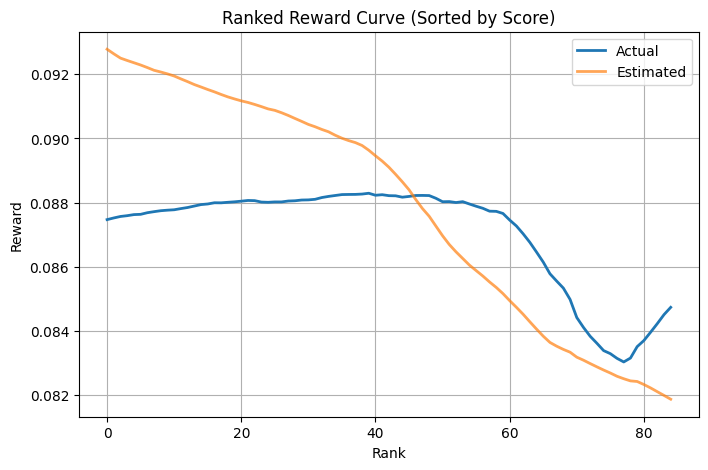

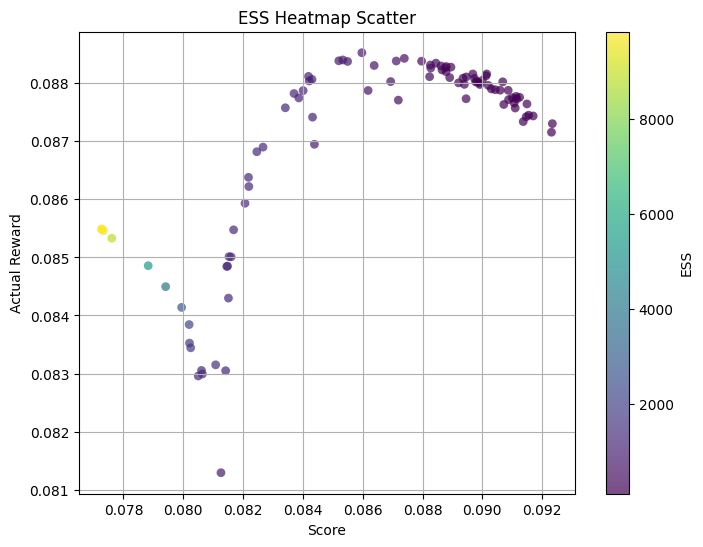

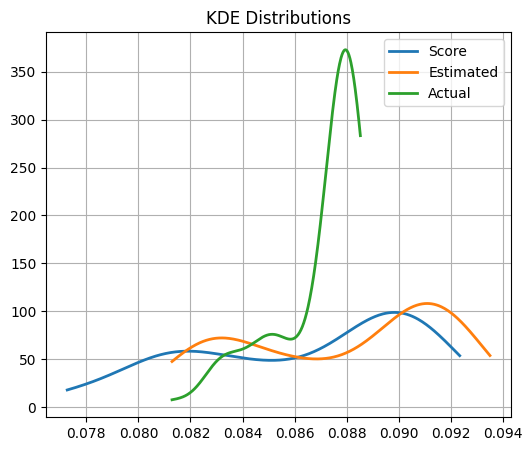

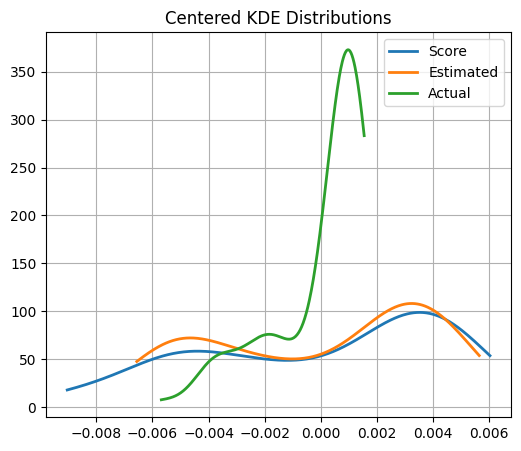

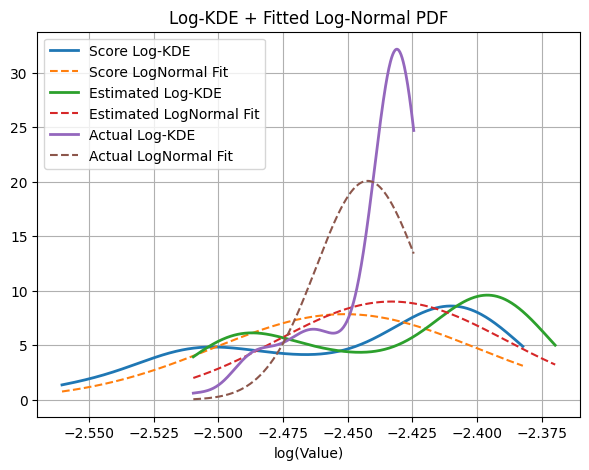

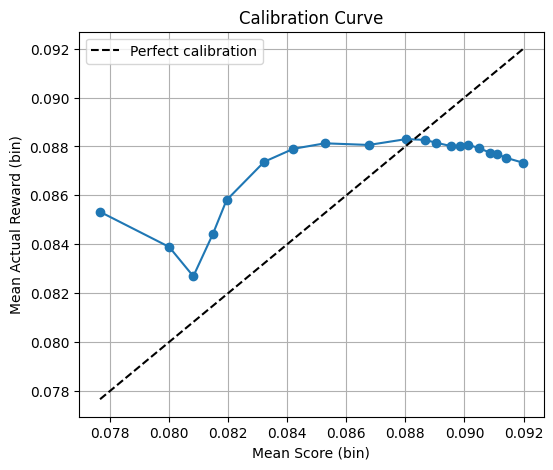

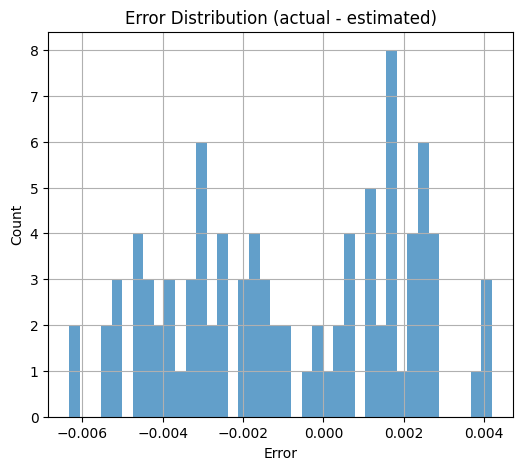

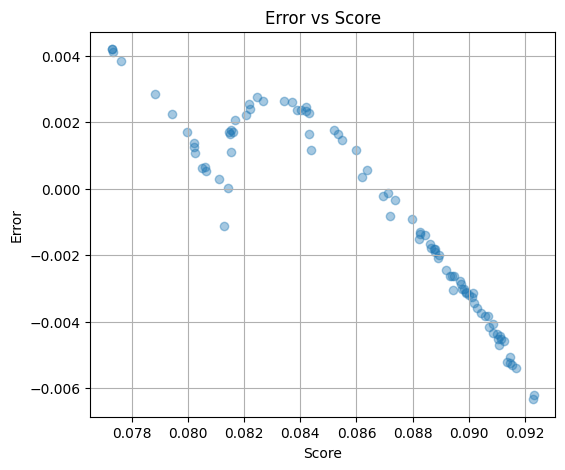

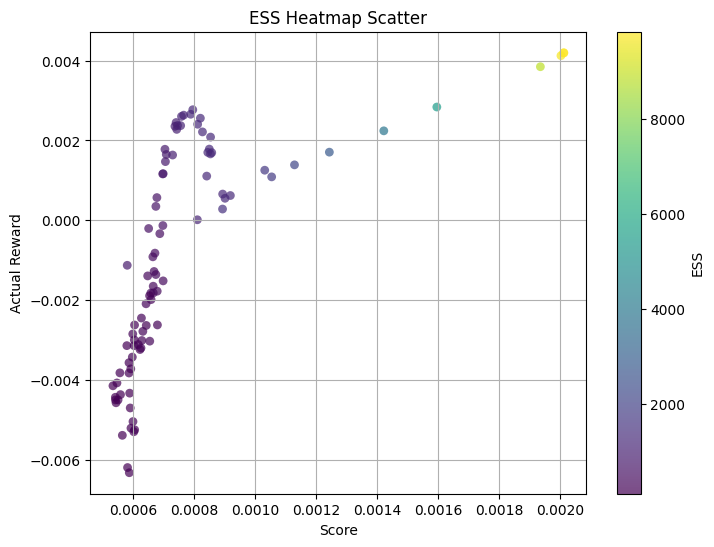

Correlation Metrics: {'pearson_score_actual': np.float64(0.7436815606049679), 'spearman_score_actual': np.float64(0.45404494046730914), 'spearman_est_actual': np.float64(0.4558055563844707)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9980470770141089), 'ndcg_est_actual': np.float64(0.99805030531171)}
Error Metrics: {'mean_error': np.float64(-0.0008749352456745471), 'mae': np.float64(0.002561732293552359), 'rmse': np.float64(0.002946694376026801), 'std_error': np.float64(0.0028138045528402285), 'max_error': np.float64(0.004197665331795775), 'min_error': np.float64(-0.0063282803349009875)}


In [14]:
compute_statistics_and_plots(study_df5)

In [15]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=20000)

Random Item CTR: 0.07042251854546815
Optimal greedy CTR: 0.09999934264692525
Second Best greedy CTR: 0.09938443255799592
Optimal Stochastic CTR: 0.09996075464321043
second Best Stochastic CTR: 0.08632684639469405
Our Initial CTR: 0.08647580588501355


In [16]:
# Run the optimization
df6, study_df6 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df6.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{20000}.csv")
# Show the performance metrics
df6[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 10000 samples: 0.029919147491455078 seconds
[Regression] Baseline regression model fit time: 0.07s
Num samples is 10000
{'gini': np.float64(0.4542033670295801), 'ess': np.float64(4606.317080520244), 'max_wi': np.float64(19.588954422043372), 'min_wi': np.float64(0.01013572636052283)}
Eval time: 0.550745964050293 seconds


[I 2025-12-14 23:47:17,548] A new study created in memory with name: no-name-1963f44d-8550-4aff-8bc6-1cb93dff1b7b


Evaluation total results time: 0.89 seconds

=== [Regression] Training size 15000, run 0 ===
Simulation time for 25000 samples: 0.0589137077331543 seconds


  0%|          | 0/155 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.084309]
Validation weights_info: {'gini': np.float64(0.9943279067279686), 'ess': np.float64(37.65993163919501), 'max_wi': np.float64(945.2398287308232), 'min_wi': np.float64(0.0)}


Best trial: 0. Best value: -inf:   1%|          | 1/155 [00:03<08:40,  3.38s/it]

[I 2025-12-14 23:47:20,931] Trial 0 finished with value: -inf and parameters: {'lr': 0.096, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.85}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 1
actual reward: [0.08658426]
Validation weights_info: {'gini': np.float64(0.04501957769897907), 'ess': np.float64(9933.284949184304), 'max_wi': np.float64(1.2692591064412315), 'min_wi': np.float64(0.8075116042528908)}


Best trial: 1. Best value: 0.0760535:   1%|▏         | 2/155 [00:05<06:43,  2.64s/it]

[I 2025-12-14 23:47:23,045] Trial 1 finished with value: 0.07605349727290289 and parameters: {'lr': 0.00016827579882116125, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8456664894616212}. Best is trial 1 with value: 0.07605349727290289.

[Regression] Optuna Trial 2
actual reward: [0.08533372]
Validation weights_info: {'gini': np.float64(0.9884071668891649), 'ess': np.float64(119.22893404736462), 'max_wi': np.float64(306.90899310952045), 'min_wi': np.float64(4.5524369829201485e-14)}


Best trial: 1. Best value: 0.0760535:   2%|▏         | 3/155 [00:07<06:16,  2.47s/it]

[I 2025-12-14 23:47:25,326] Trial 2 finished with value: 0.07505854717669448 and parameters: {'lr': 0.0698912931311206, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9068330109768759}. Best is trial 1 with value: 0.07605349727290289.

[Regression] Optuna Trial 3
actual reward: [0.08652533]
Validation weights_info: {'gini': np.float64(0.021107133089103215), 'ess': np.float64(9985.549510403636), 'max_wi': np.float64(1.123400581653281), 'min_wi': np.float64(0.905736660388899)}


Best trial: 3. Best value: 0.0761298:   3%|▎         | 4/155 [00:09<05:22,  2.13s/it]

[I 2025-12-14 23:47:26,940] Trial 3 finished with value: 0.0761297923349565 and parameters: {'lr': 0.0001629272617659674, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.8516164344159269}. Best is trial 3 with value: 0.0761297923349565.

[Regression] Optuna Trial 4
actual reward: [0.08672477]
Validation weights_info: {'gini': np.float64(0.10205070110616941), 'ess': np.float64(9653.701122597437), 'max_wi': np.float64(1.7072056279408045), 'min_wi': np.float64(0.609532730201663)}


Best trial: 3. Best value: 0.0761298:   3%|▎         | 5/155 [00:11<04:54,  1.96s/it]

[I 2025-12-14 23:47:28,594] Trial 4 finished with value: 0.07592562258765803 and parameters: {'lr': 0.0005327009694981065, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8428798984685755}. Best is trial 3 with value: 0.0761297923349565.

[Regression] Optuna Trial 5
actual reward: [0.08309663]
Validation weights_info: {'gini': np.float64(0.9868941980725104), 'ess': np.float64(131.2551853529905), 'max_wi': np.float64(219.84006920396521), 'min_wi': np.float64(7.661799868356914e-12)}


Best trial: 5. Best value: 0.0798232:   4%|▍         | 6/155 [00:12<04:10,  1.68s/it]

[I 2025-12-14 23:47:29,734] Trial 5 finished with value: 0.07982318336765812 and parameters: {'lr': 0.08191328343831968, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9595937468359292}. Best is trial 5 with value: 0.07982318336765812.

[Regression] Optuna Trial 6
actual reward: [0.08979195]
Validation weights_info: {'gini': np.float64(0.9945883106705864), 'ess': np.float64(17.620911089466865), 'max_wi': np.float64(1947.1712276900125), 'min_wi': np.float64(3.744184895546702e-21)}


Best trial: 5. Best value: 0.0798232:   5%|▍         | 7/155 [00:15<05:42,  2.32s/it]

[I 2025-12-14 23:47:33,353] Trial 6 finished with value: -inf and parameters: {'lr': 0.027923280615232682, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8890764158644919}. Best is trial 5 with value: 0.07982318336765812.

[Regression] Optuna Trial 7
actual reward: [0.08651438]
Validation weights_info: {'gini': np.float64(0.016100762280660853), 'ess': np.float64(9991.537057046506), 'max_wi': np.float64(1.0933270038962042), 'min_wi': np.float64(0.9310075859317728)}


Best trial: 5. Best value: 0.0798232:   5%|▌         | 8/155 [00:17<04:56,  2.02s/it]

[I 2025-12-14 23:47:34,740] Trial 7 finished with value: 0.07614787567863918 and parameters: {'lr': 0.0001755054621824649, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.8029284023829549}. Best is trial 5 with value: 0.07982318336765812.

[Regression] Optuna Trial 8
actual reward: [0.08686286]
Validation weights_info: {'gini': np.float64(0.15542833992073596), 'ess': np.float64(9206.852327992594), 'max_wi': np.float64(2.2451293461179738), 'min_wi': np.float64(0.47292154170681766)}


Best trial: 5. Best value: 0.0798232:   6%|▌         | 9/155 [00:18<04:39,  1.91s/it]

[I 2025-12-14 23:47:36,423] Trial 8 finished with value: 0.07587259658603035 and parameters: {'lr': 0.001044852236604753, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8598106210930947}. Best is trial 5 with value: 0.07982318336765812.

[Regression] Optuna Trial 9
actual reward: [0.08669075]
Validation weights_info: {'gini': np.float64(0.08818292192737388), 'ess': np.float64(9742.253060343659), 'max_wi': np.float64(1.6171636142226038), 'min_wi': np.float64(0.6632115710816208)}


Best trial: 5. Best value: 0.0798232:   6%|▋         | 10/155 [00:21<05:20,  2.21s/it]

[I 2025-12-14 23:47:39,289] Trial 9 finished with value: 0.07593915299752317 and parameters: {'lr': 0.0003029024489513778, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8210002588874941}. Best is trial 5 with value: 0.07982318336765812.

[Regression] Optuna Trial 10
actual reward: [0.08795059]
Validation weights_info: {'gini': np.float64(0.6009817675411424), 'ess': np.float64(2648.3940825049694), 'max_wi': np.float64(21.31110710360114), 'min_wi': np.float64(0.01823585303053517)}


Best trial: 5. Best value: 0.0798232:   7%|▋         | 11/155 [00:23<04:38,  1.93s/it]

[I 2025-12-14 23:47:40,599] Trial 10 finished with value: 0.07683228625944596 and parameters: {'lr': 0.006891359728537466, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.9867297864259574}. Best is trial 5 with value: 0.07982318336765812.

[Regression] Optuna Trial 11
actual reward: [0.08802868]
Validation weights_info: {'gini': np.float64(0.7248663712756367), 'ess': np.float64(1279.6661692682271), 'max_wi': np.float64(44.96583062609626), 'min_wi': np.float64(0.006979585855600945)}


Best trial: 5. Best value: 0.0798232:   8%|▊         | 12/155 [00:24<04:03,  1.70s/it]

[I 2025-12-14 23:47:41,770] Trial 11 finished with value: 0.07585785738601424 and parameters: {'lr': 0.008723403196491468, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.9889828561224538}. Best is trial 5 with value: 0.07982318336765812.

[Regression] Optuna Trial 12
actual reward: [0.08825458]
Validation weights_info: {'gini': np.float64(0.6759549695877178), 'ess': np.float64(1860.7249170448415), 'max_wi': np.float64(28.163349023482958), 'min_wi': np.float64(0.009202335792947164)}


Best trial: 5. Best value: 0.0798232:   8%|▊         | 13/155 [00:25<03:57,  1.67s/it]

[I 2025-12-14 23:47:43,377] Trial 12 finished with value: 0.07646404629064105 and parameters: {'lr': 0.004270431440597799, 'num_epochs': 2, 'batch_size': 128, 'lr_decay': 0.9853304792349338}. Best is trial 5 with value: 0.07982318336765812.

[Regression] Optuna Trial 13
actual reward: [0.08753107]
Validation weights_info: {'gini': np.float64(0.9944031395655487), 'ess': np.float64(17.322318989844618), 'max_wi': np.float64(1349.9161108318608), 'min_wi': np.float64(5.831762676505709e-11)}


Best trial: 5. Best value: 0.0798232:   9%|▉         | 14/155 [00:27<03:53,  1.65s/it]

[I 2025-12-14 23:47:44,987] Trial 13 finished with value: -inf and parameters: {'lr': 0.023657235249663587, 'num_epochs': 3, 'batch_size': 128, 'lr_decay': 0.9458040505766006}. Best is trial 5 with value: 0.07982318336765812.

[Regression] Optuna Trial 14
actual reward: [0.08684147]
Validation weights_info: {'gini': np.float64(0.15615586977428736), 'ess': np.float64(9198.67010010548), 'max_wi': np.float64(2.293335677634515), 'min_wi': np.float64(0.43778116869302947)}


Best trial: 5. Best value: 0.0798232:  10%|▉         | 15/155 [00:28<03:36,  1.55s/it]

[I 2025-12-14 23:47:46,288] Trial 14 finished with value: 0.07587428725298266 and parameters: {'lr': 0.0016815799998584605, 'num_epochs': 1, 'batch_size': 128, 'lr_decay': 0.9587977912454437}. Best is trial 5 with value: 0.07982318336765812.

[Regression] Optuna Trial 15
actual reward: [0.09019329]
Validation weights_info: {'gini': np.float64(0.9295973610892039), 'ess': np.float64(404.0925188467343), 'max_wi': np.float64(75.8677707306899), 'min_wi': np.float64(6.795871768243779e-05)}


Best trial: 5. Best value: 0.0798232:  10%|█         | 16/155 [00:30<03:35,  1.55s/it]

[I 2025-12-14 23:47:47,845] Trial 15 finished with value: 0.07742918621938273 and parameters: {'lr': 0.010593115525490714, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9495324958207708}. Best is trial 5 with value: 0.07982318336765812.

[Regression] Optuna Trial 16
actual reward: [0.08933641]
Validation weights_info: {'gini': np.float64(0.9826080346343555), 'ess': np.float64(51.84943099723451), 'max_wi': np.float64(1154.5906936460644), 'min_wi': np.float64(1.1316213840051404e-07)}


Best trial: 5. Best value: 0.0798232:  11%|█         | 17/155 [00:31<03:34,  1.56s/it]

[I 2025-12-14 23:47:49,413] Trial 16 finished with value: -inf and parameters: {'lr': 0.023126486148857612, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.930489102750818}. Best is trial 5 with value: 0.07982318336765812.

[Regression] Optuna Trial 17
actual reward: [0.09203062]
Validation weights_info: {'gini': np.float64(0.9533519622762693), 'ess': np.float64(290.84678613253595), 'max_wi': np.float64(130.35653164309252), 'min_wi': np.float64(1.5023756837547279e-05)}


Best trial: 5. Best value: 0.0798232:  12%|█▏        | 18/155 [00:33<03:38,  1.60s/it]

[I 2025-12-14 23:47:51,106] Trial 17 finished with value: 0.07835950583448908 and parameters: {'lr': 0.010979673302344653, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.9570554425016086}. Best is trial 5 with value: 0.07982318336765812.

[Regression] Optuna Trial 18
actual reward: [0.080519]
Validation weights_info: {'gini': np.float64(0.9972903076745187), 'ess': np.float64(7.94946425029039), 'max_wi': np.float64(1948.7210689031338), 'min_wi': np.float64(4.0673512500898355e-14)}


Best trial: 5. Best value: 0.0798232:  12%|█▏        | 19/155 [00:35<03:59,  1.76s/it]

[I 2025-12-14 23:47:53,254] Trial 18 finished with value: -inf and parameters: {'lr': 0.045552039972875366, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.924028230446862}. Best is trial 5 with value: 0.07982318336765812.

[Regression] Optuna Trial 19
actual reward: [0.0885659]
Validation weights_info: {'gini': np.float64(0.7516312353572172), 'ess': np.float64(1286.4305692290482), 'max_wi': np.float64(36.765282236918736), 'min_wi': np.float64(0.0031952357101579162)}


Best trial: 5. Best value: 0.0798232:  13%|█▎        | 20/155 [00:38<04:20,  1.93s/it]

[I 2025-12-14 23:47:55,584] Trial 19 finished with value: 0.07638443246223471 and parameters: {'lr': 0.002143484549891036, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9662529923334781}. Best is trial 5 with value: 0.07982318336765812.

[Regression] Optuna Trial 20
actual reward: [0.0911697]
Validation weights_info: {'gini': np.float64(0.9655704825900658), 'ess': np.float64(117.55677998129448), 'max_wi': np.float64(673.0820616150578), 'min_wi': np.float64(4.411970468742203e-06)}


Best trial: 20. Best value: 0.0811044:  14%|█▎        | 21/155 [00:39<04:09,  1.86s/it]

[I 2025-12-14 23:47:57,275] Trial 20 finished with value: 0.08110442781558314 and parameters: {'lr': 0.013451171778421932, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.898135373111193}. Best is trial 20 with value: 0.08110442781558314.

[Regression] Optuna Trial 21
actual reward: [0.09133629]
Validation weights_info: {'gini': np.float64(0.9546983473951584), 'ess': np.float64(290.68109452632905), 'max_wi': np.float64(96.44475025094295), 'min_wi': np.float64(5.812643266594702e-06)}


Best trial: 20. Best value: 0.0811044:  14%|█▍        | 22/155 [00:41<03:57,  1.79s/it]

[I 2025-12-14 23:47:58,899] Trial 21 finished with value: 0.07792951785515 and parameters: {'lr': 0.012285763722040158, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8797492915446984}. Best is trial 20 with value: 0.08110442781558314.

[Regression] Optuna Trial 22
actual reward: [0.08081672]
Validation weights_info: {'gini': np.float64(0.997141490259044), 'ess': np.float64(7.356938414147709), 'max_wi': np.float64(2066.986133438139), 'min_wi': np.float64(1.8751413034747193e-13)}


Best trial: 20. Best value: 0.0811044:  15%|█▍        | 23/155 [00:43<03:54,  1.78s/it]

[I 2025-12-14 23:48:00,648] Trial 22 finished with value: -inf and parameters: {'lr': 0.034551154795384405, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.91893955488016}. Best is trial 20 with value: 0.08110442781558314.

[Regression] Optuna Trial 23
actual reward: [0.08976399]
Validation weights_info: {'gini': np.float64(0.8711468020353088), 'ess': np.float64(631.4866518385276), 'max_wi': np.float64(62.25722936810947), 'min_wi': np.float64(0.0005583031148237742)}


Best trial: 20. Best value: 0.0811044:  15%|█▌        | 24/155 [00:45<04:02,  1.85s/it]

[I 2025-12-14 23:48:02,665] Trial 23 finished with value: 0.07704584410561954 and parameters: {'lr': 0.004422049909273527, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9385431796379945}. Best is trial 20 with value: 0.08110442781558314.

[Regression] Optuna Trial 24
actual reward: [0.08568399]
Validation weights_info: {'gini': np.float64(0.9876583604099561), 'ess': np.float64(130.58894338078298), 'max_wi': np.float64(199.09143153562792), 'min_wi': np.float64(1.9015307792282867e-12)}


Best trial: 20. Best value: 0.0811044:  16%|█▌        | 25/155 [00:46<03:45,  1.74s/it]

[I 2025-12-14 23:48:04,135] Trial 24 finished with value: 0.07635157639431155 and parameters: {'lr': 0.05904887595568963, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.905215341399786}. Best is trial 20 with value: 0.08110442781558314.

[Regression] Optuna Trial 25
actual reward: [0.08998478]
Validation weights_info: {'gini': np.float64(0.9386663429161475), 'ess': np.float64(366.78318360402784), 'max_wi': np.float64(80.22230002184929), 'min_wi': np.float64(3.324770104366336e-05)}


Best trial: 20. Best value: 0.0811044:  17%|█▋        | 26/155 [00:48<03:32,  1.65s/it]

[I 2025-12-14 23:48:05,574] Trial 25 finished with value: 0.07785991112942645 and parameters: {'lr': 0.01613477044654412, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.9638451369498612}. Best is trial 20 with value: 0.08110442781558314.

[Regression] Optuna Trial 26
actual reward: [0.08971349]
Validation weights_info: {'gini': np.float64(0.8856339989717756), 'ess': np.float64(537.6912584763852), 'max_wi': np.float64(68.22665377835733), 'min_wi': np.float64(0.0003070834589199856)}


Best trial: 20. Best value: 0.0811044:  17%|█▋        | 27/155 [00:49<03:38,  1.71s/it]

[I 2025-12-14 23:48:07,425] Trial 26 finished with value: 0.07714379509423744 and parameters: {'lr': 0.005907295990316006, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8774242502863562}. Best is trial 20 with value: 0.08110442781558314.

[Regression] Optuna Trial 27
actual reward: [0.08937616]
Validation weights_info: {'gini': np.float64(0.9844882053655547), 'ess': np.float64(18.346730344867506), 'max_wi': np.float64(2382.546666254209), 'min_wi': np.float64(2.0982263107554893e-07)}


Best trial: 20. Best value: 0.0811044:  18%|█▊        | 28/155 [00:51<03:35,  1.70s/it]

[I 2025-12-14 23:48:09,092] Trial 27 finished with value: -inf and parameters: {'lr': 0.01485421634034204, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.9992843686528995}. Best is trial 20 with value: 0.08110442781558314.

[Regression] Optuna Trial 28
actual reward: [0.08882804]
Validation weights_info: {'gini': np.float64(0.9861525849651698), 'ess': np.float64(143.70320088664613), 'max_wi': np.float64(223.45708826598593), 'min_wi': np.float64(4.917617281316089e-16)}


Best trial: 28. Best value: 0.0811683:  19%|█▊        | 29/155 [00:52<03:13,  1.53s/it]

[I 2025-12-14 23:48:10,242] Trial 28 finished with value: 0.0811683297625395 and parameters: {'lr': 0.0986056232970061, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.970192920785566}. Best is trial 28 with value: 0.0811683297625395.

[Regression] Optuna Trial 29
actual reward: [0.08568022]
Validation weights_info: {'gini': np.float64(0.9862058622365136), 'ess': np.float64(140.32310669854263), 'max_wi': np.float64(149.83729221497347), 'min_wi': np.float64(3.57864796239876e-12)}


Best trial: 28. Best value: 0.0811683:  19%|█▉        | 30/155 [00:54<03:04,  1.47s/it]

[I 2025-12-14 23:48:11,582] Trial 29 finished with value: 0.07664622237119825 and parameters: {'lr': 0.07647144595144276, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9152507659642551}. Best is trial 28 with value: 0.0811683297625395.

[Regression] Optuna Trial 30
actual reward: [0.08651747]
Validation weights_info: {'gini': np.float64(0.9875272932155607), 'ess': np.float64(130.05536391513618), 'max_wi': np.float64(247.7521373425442), 'min_wi': np.float64(2.814562862826276e-13)}


Best trial: 28. Best value: 0.0811683:  20%|██        | 31/155 [00:55<02:52,  1.39s/it]

[I 2025-12-14 23:48:12,779] Trial 30 finished with value: 0.0773736039022251 and parameters: {'lr': 0.0845817844320104, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9758023963331824}. Best is trial 28 with value: 0.0811683297625395.

[Regression] Optuna Trial 31
actual reward: [0.08958769]
Validation weights_info: {'gini': np.float64(0.9928396699446752), 'ess': np.float64(34.8149076222467), 'max_wi': np.float64(1034.3123839790903), 'min_wi': np.float64(2.520072725295866e-21)}


Best trial: 28. Best value: 0.0811683:  21%|██        | 32/155 [00:57<03:30,  1.71s/it]

[I 2025-12-14 23:48:15,248] Trial 31 finished with value: -inf and parameters: {'lr': 0.03832537149106183, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.9540082185167293}. Best is trial 28 with value: 0.0811683297625395.

[Regression] Optuna Trial 32
actual reward: [0.08958594]
Validation weights_info: {'gini': np.float64(0.9898327649542692), 'ess': np.float64(102.6076758714823), 'max_wi': np.float64(236.14734465291778), 'min_wi': np.float64(1.4730378284369267e-12)}


Best trial: 28. Best value: 0.0811683:  21%|██▏       | 33/155 [00:59<03:27,  1.70s/it]

[I 2025-12-14 23:48:16,913] Trial 32 finished with value: 0.07784537131349589 and parameters: {'lr': 0.05197163987455323, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.9377951423691061}. Best is trial 28 with value: 0.0811683297625395.

[Regression] Optuna Trial 33
actual reward: [0.09243393]
Validation weights_info: {'gini': np.float64(0.9724355455177497), 'ess': np.float64(224.17608638219355), 'max_wi': np.float64(133.5171278940735), 'min_wi': np.float64(6.228258311724715e-08)}


Best trial: 28. Best value: 0.0811683:  22%|██▏       | 34/155 [01:00<03:21,  1.67s/it]

[I 2025-12-14 23:48:18,501] Trial 33 finished with value: 0.07724764603538205 and parameters: {'lr': 0.02099924793586857, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.9713745701928662}. Best is trial 28 with value: 0.0811683297625395.

[Regression] Optuna Trial 34
actual reward: [0.08727287]
Validation weights_info: {'gini': np.float64(0.3318246226357171), 'ess': np.float64(6732.521747440336), 'max_wi': np.float64(6.436258698551845), 'min_wi': np.float64(0.17488853459379988)}


Best trial: 28. Best value: 0.0811683:  23%|██▎       | 35/155 [01:02<03:16,  1.64s/it]

[I 2025-12-14 23:48:20,074] Trial 34 finished with value: 0.07586911460934735 and parameters: {'lr': 0.002446064011094662, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.8980936306028536}. Best is trial 28 with value: 0.0811683297625395.

[Regression] Optuna Trial 35
actual reward: [0.08597557]
Validation weights_info: {'gini': np.float64(0.9941535501658508), 'ess': np.float64(36.97067369983034), 'max_wi': np.float64(816.8269374179664), 'min_wi': np.float64(6.05962206822556e-19)}


Best trial: 28. Best value: 0.0811683:  23%|██▎       | 36/155 [01:03<03:05,  1.56s/it]

[I 2025-12-14 23:48:21,453] Trial 35 finished with value: -inf and parameters: {'lr': 0.08917128784099589, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.977169003689446}. Best is trial 28 with value: 0.0811683297625395.

[Regression] Optuna Trial 36
actual reward: [0.08543706]
Validation weights_info: {'gini': np.float64(0.9909173430130245), 'ess': np.float64(97.0284221074635), 'max_wi': np.float64(224.17142407710645), 'min_wi': np.float64(4.035651701849062e-18)}


Best trial: 28. Best value: 0.0811683:  24%|██▍       | 37/155 [01:05<03:05,  1.57s/it]

[I 2025-12-14 23:48:23,042] Trial 36 finished with value: -inf and parameters: {'lr': 0.09734271370993229, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.9982394833496142}. Best is trial 28 with value: 0.0811683297625395.

[Regression] Optuna Trial 37
actual reward: [0.09036439]
Validation weights_info: {'gini': np.float64(0.9867727590201263), 'ess': np.float64(101.38833411372192), 'max_wi': np.float64(611.3217209293235), 'min_wi': np.float64(5.477867226318962e-19)}


Best trial: 37. Best value: 0.0819533:  25%|██▍       | 38/155 [01:09<04:14,  2.18s/it]

[I 2025-12-14 23:48:26,641] Trial 37 finished with value: 0.08195331248346183 and parameters: {'lr': 0.03365555040262908, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8690772774975168}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 38
actual reward: [0.08756349]
Validation weights_info: {'gini': np.float64(0.9914002033983563), 'ess': np.float64(18.130148595380128), 'max_wi': np.float64(3014.562634034021), 'min_wi': np.float64(3.132980498109114e-28)}


Best trial: 37. Best value: 0.0819533:  25%|██▌       | 39/155 [01:13<05:24,  2.80s/it]

[I 2025-12-14 23:48:30,884] Trial 38 finished with value: -inf and parameters: {'lr': 0.05573482225803829, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.876075085924785}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 39
actual reward: [0.090151]
Validation weights_info: {'gini': np.float64(0.9915328652315144), 'ess': np.float64(29.207369148439607), 'max_wi': np.float64(1222.9114251615188), 'min_wi': np.float64(9.863788120779439e-19)}


Best trial: 37. Best value: 0.0819533:  26%|██▌       | 40/155 [01:17<06:15,  3.27s/it]

[I 2025-12-14 23:48:35,245] Trial 39 finished with value: -inf and parameters: {'lr': 0.033057455303289844, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8635261014237654}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 40
actual reward: [0.08933579]
Validation weights_info: {'gini': np.float64(0.9949786405088596), 'ess': np.float64(14.00771685921653), 'max_wi': np.float64(1908.5885097164453), 'min_wi': np.float64(4.970592452520811e-13)}


Best trial: 37. Best value: 0.0819533:  26%|██▋       | 41/155 [01:21<06:40,  3.52s/it]

[I 2025-12-14 23:48:39,341] Trial 40 finished with value: -inf and parameters: {'lr': 0.01907346215185401, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8347116213247048}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 41
actual reward: [0.08794582]
Validation weights_info: {'gini': np.float64(0.9929531954086676), 'ess': np.float64(17.132053431676468), 'max_wi': np.float64(2572.8130648255637), 'min_wi': np.float64(9.57849288366397e-25)}


Best trial: 37. Best value: 0.0819533:  27%|██▋       | 42/155 [01:25<06:56,  3.68s/it]

[I 2025-12-14 23:48:43,417] Trial 41 finished with value: -inf and parameters: {'lr': 0.042276870397470134, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8859274191317817}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 42
actual reward: [0.09250029]
Validation weights_info: {'gini': np.float64(0.9796121854769968), 'ess': np.float64(193.00511382421394), 'max_wi': np.float64(111.03210586053926), 'min_wi': np.float64(4.222437019033711e-09)}


Best trial: 37. Best value: 0.0819533:  28%|██▊       | 43/155 [01:28<06:02,  3.23s/it]

[I 2025-12-14 23:48:45,599] Trial 42 finished with value: 0.07901225611343582 and parameters: {'lr': 0.030154628744868475, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8987293147083466}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 43
actual reward: [0.09174045]
Validation weights_info: {'gini': np.float64(0.9857716040726403), 'ess': np.float64(142.98417163643273), 'max_wi': np.float64(221.78581481652833), 'min_wi': np.float64(3.471353718268255e-10)}


Best trial: 37. Best value: 0.0819533:  28%|██▊       | 44/155 [01:30<05:33,  3.00s/it]

[I 2025-12-14 23:48:48,067] Trial 43 finished with value: 0.07717704757780372 and parameters: {'lr': 0.029586677602573, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.895306585923245}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 44
actual reward: [0.09031342]
Validation weights_info: {'gini': np.float64(0.9854236607904696), 'ess': np.float64(154.72745695797764), 'max_wi': np.float64(164.7196186421141), 'min_wi': np.float64(5.328620702406462e-13)}


Best trial: 37. Best value: 0.0819533:  29%|██▉       | 45/155 [01:32<04:53,  2.66s/it]

[I 2025-12-14 23:48:49,942] Trial 44 finished with value: 0.07535010992512527 and parameters: {'lr': 0.061771446786859814, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8657382824837586}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 45
actual reward: [0.08938486]
Validation weights_info: {'gini': np.float64(0.9862062565716649), 'ess': np.float64(117.24447679241284), 'max_wi': np.float64(590.3820321096624), 'min_wi': np.float64(3.9281134323923525e-13)}


Best trial: 37. Best value: 0.0819533:  30%|██▉       | 46/155 [01:34<04:41,  2.58s/it]

[I 2025-12-14 23:48:52,319] Trial 45 finished with value: 0.07944426474314467 and parameters: {'lr': 0.06162273765537385, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9068118554852413}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 46
actual reward: [0.08367644]
Validation weights_info: {'gini': np.float64(0.9939293911636541), 'ess': np.float64(15.38255139292862), 'max_wi': np.float64(2016.676118252205), 'min_wi': np.float64(1.8942955423966886e-19)}


Best trial: 37. Best value: 0.0819533:  30%|███       | 47/155 [01:36<04:24,  2.45s/it]

[I 2025-12-14 23:48:54,463] Trial 46 finished with value: -inf and parameters: {'lr': 0.06999471632005397, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8354956191539198}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 47
actual reward: [0.08387168]
Validation weights_info: {'gini': np.float64(0.9926312150563746), 'ess': np.float64(58.42437087610272), 'max_wi': np.float64(682.9741345756315), 'min_wi': np.float64(1.986546852592884e-40)}


Best trial: 37. Best value: 0.0819533:  31%|███       | 48/155 [01:38<03:52,  2.17s/it]

[I 2025-12-14 23:48:55,986] Trial 47 finished with value: -inf and parameters: {'lr': 0.09794345152326792, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.8512093140988309}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 48
actual reward: [0.08159821]
Validation weights_info: {'gini': np.float64(0.9948980943221322), 'ess': np.float64(12.344910720122448), 'max_wi': np.float64(2016.2048011430413), 'min_wi': np.float64(7.522906124247756e-13)}


Best trial: 37. Best value: 0.0819533:  32%|███▏      | 49/155 [01:40<03:55,  2.23s/it]

[I 2025-12-14 23:48:58,341] Trial 48 finished with value: -inf and parameters: {'lr': 0.04196423752191122, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9114882649498205}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 49
actual reward: [0.08663207]
Validation weights_info: {'gini': np.float64(0.06470310198365802), 'ess': np.float64(9861.297694440498), 'max_wi': np.float64(1.4661970178562407), 'min_wi': np.float64(0.7326925907937326)}


Best trial: 37. Best value: 0.0819533:  32%|███▏      | 50/155 [01:44<04:49,  2.76s/it]

[I 2025-12-14 23:49:02,335] Trial 49 finished with value: 0.07598982176270845 and parameters: {'lr': 0.00012280283175595017, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.8884581858670854}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 50
actual reward: [0.08830775]
Validation weights_info: {'gini': np.float64(0.9732966405093032), 'ess': np.float64(211.4400270180157), 'max_wi': np.float64(105.50157848268567), 'min_wi': np.float64(3.187630079872127e-09)}


Best trial: 37. Best value: 0.0819533:  33%|███▎      | 51/155 [01:45<03:56,  2.27s/it]

[I 2025-12-14 23:49:03,480] Trial 50 finished with value: 0.07703427682251848 and parameters: {'lr': 0.06674751166665548, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.8064395666598456}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 51
actual reward: [0.09413965]
Validation weights_info: {'gini': np.float64(0.9832300869388149), 'ess': np.float64(148.5685834039617), 'max_wi': np.float64(282.17668878747014), 'min_wi': np.float64(1.2931015089181025e-08)}


Best trial: 37. Best value: 0.0819533:  34%|███▎      | 52/155 [01:48<03:50,  2.24s/it]

[I 2025-12-14 23:49:05,650] Trial 51 finished with value: 0.08004356239770918 and parameters: {'lr': 0.027103218862176724, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9057873976384971}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 52
actual reward: [0.08986155]
Validation weights_info: {'gini': np.float64(0.99019715137519), 'ess': np.float64(22.728273669635502), 'max_wi': np.float64(1854.8562319778378), 'min_wi': np.float64(2.6751774518070235e-09)}


Best trial: 37. Best value: 0.0819533:  34%|███▍      | 53/155 [01:50<03:52,  2.28s/it]

[I 2025-12-14 23:49:08,020] Trial 52 finished with value: -inf and parameters: {'lr': 0.025228556569148, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9314489903097379}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 53
actual reward: [0.08663027]
Validation weights_info: {'gini': np.float64(0.06121528129961111), 'ess': np.float64(9875.873447611923), 'max_wi': np.float64(1.3824517487023762), 'min_wi': np.float64(0.7531198290110048)}


Best trial: 37. Best value: 0.0819533:  35%|███▍      | 54/155 [01:52<03:41,  2.20s/it]

[I 2025-12-14 23:49:10,021] Trial 53 finished with value: 0.07601707724047455 and parameters: {'lr': 0.00037143065025570433, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8708454393926908}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 54
actual reward: [0.09022086]
Validation weights_info: {'gini': np.float64(0.8913523604173266), 'ess': np.float64(499.7313215450812), 'max_wi': np.float64(62.93798138747813), 'min_wi': np.float64(0.00033714518944837735)}


Best trial: 37. Best value: 0.0819533:  35%|███▌      | 55/155 [01:54<03:46,  2.26s/it]

[I 2025-12-14 23:49:12,440] Trial 54 finished with value: 0.07690499187848755 and parameters: {'lr': 0.007908613612044535, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9044961821889342}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 55
actual reward: [0.08514741]
Validation weights_info: {'gini': np.float64(0.9951349606953318), 'ess': np.float64(11.24758345693133), 'max_wi': np.float64(1946.0909966113923), 'min_wi': np.float64(1.792293092441716e-18)}


Best trial: 37. Best value: 0.0819533:  36%|███▌      | 56/155 [01:57<03:57,  2.40s/it]

[I 2025-12-14 23:49:15,155] Trial 55 finished with value: -inf and parameters: {'lr': 0.048926932734618296, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9247467616687377}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 56
actual reward: [0.09332973]
Validation weights_info: {'gini': np.float64(0.9763165949005272), 'ess': np.float64(204.2186685346077), 'max_wi': np.float64(132.35738472605604), 'min_wi': np.float64(2.27744857820098e-08)}


Best trial: 37. Best value: 0.0819533:  37%|███▋      | 57/155 [01:59<03:41,  2.26s/it]

[I 2025-12-14 23:49:17,103] Trial 56 finished with value: 0.07626451315708435 and parameters: {'lr': 0.016891814018352668, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9417867924661936}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 57
actual reward: [0.08695094]
Validation weights_info: {'gini': np.float64(0.19514981624052216), 'ess': np.float64(8773.997747163761), 'max_wi': np.float64(2.6880199156210467), 'min_wi': np.float64(0.38395307321705935)}


Best trial: 37. Best value: 0.0819533:  37%|███▋      | 58/155 [02:01<03:31,  2.18s/it]

[I 2025-12-14 23:49:19,096] Trial 57 finished with value: 0.075902402888883 and parameters: {'lr': 0.0008443734633481165, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8589063346581306}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 58
actual reward: [0.08992004]
Validation weights_info: {'gini': np.float64(0.9956424974067112), 'ess': np.float64(7.2568348579217785), 'max_wi': np.float64(2407.7969249148014), 'min_wi': np.float64(3.77058725452197e-11)}


Best trial: 37. Best value: 0.0819533:  38%|███▊      | 59/155 [02:04<04:05,  2.56s/it]

[I 2025-12-14 23:49:22,535] Trial 58 finished with value: -inf and parameters: {'lr': 0.013188595507822184, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8840011855835068}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 59
actual reward: [0.08902861]
Validation weights_info: {'gini': np.float64(0.9151837954923573), 'ess': np.float64(416.80036389411447), 'max_wi': np.float64(81.07861427886793), 'min_wi': np.float64(2.437987618014247e-05)}


Best trial: 37. Best value: 0.0819533:  39%|███▊      | 60/155 [02:06<03:25,  2.16s/it]

[I 2025-12-14 23:49:23,775] Trial 59 finished with value: 0.07545457071260642 and parameters: {'lr': 0.026435736947909245, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9091473977251269}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 60
actual reward: [0.08761253]
Validation weights_info: {'gini': np.float64(0.98635715888361), 'ess': np.float64(144.71185119685697), 'max_wi': np.float64(230.4470194491947), 'min_wi': np.float64(7.190623190863317e-12)}


Best trial: 37. Best value: 0.0819533:  39%|███▉      | 61/155 [02:07<03:06,  1.98s/it]

[I 2025-12-14 23:49:25,337] Trial 60 finished with value: 0.07875006545574614 and parameters: {'lr': 0.07361317048553671, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.8931681288463998}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 61
actual reward: [0.09196161]
Validation weights_info: {'gini': np.float64(0.982954729926557), 'ess': np.float64(169.0696170009942), 'max_wi': np.float64(138.60450348992964), 'min_wi': np.float64(9.87937668702466e-10)}


Best trial: 37. Best value: 0.0819533:  40%|████      | 62/155 [02:09<03:06,  2.01s/it]

[I 2025-12-14 23:49:27,410] Trial 61 finished with value: 0.07540006600412828 and parameters: {'lr': 0.03083592354977905, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.9001220079871884}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 62
actual reward: [0.0914004]
Validation weights_info: {'gini': np.float64(0.9860687391928642), 'ess': np.float64(31.999082000725043), 'max_wi': np.float64(2002.9212555126987), 'min_wi': np.float64(2.3402642078010813e-09)}


Best trial: 37. Best value: 0.0819533:  41%|████      | 63/155 [02:11<02:52,  1.87s/it]

[I 2025-12-14 23:49:28,953] Trial 62 finished with value: -inf and parameters: {'lr': 0.04089351847981661, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.9160758117458784}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 63
actual reward: [0.08472784]
Validation weights_info: {'gini': np.float64(0.9938046020007837), 'ess': np.float64(13.802254033844488), 'max_wi': np.float64(2016.202397077195), 'min_wi': np.float64(3.156670851896207e-14)}


Best trial: 37. Best value: 0.0819533:  41%|████▏     | 64/155 [02:13<02:53,  1.90s/it]

[I 2025-12-14 23:49:30,934] Trial 63 finished with value: -inf and parameters: {'lr': 0.054840566888803836, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.9258201589078408}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 64
actual reward: [0.09281846]
Validation weights_info: {'gini': np.float64(0.9811887426417603), 'ess': np.float64(132.26138841296822), 'max_wi': np.float64(507.85091372851355), 'min_wi': np.float64(4.347895611499435e-09)}


Best trial: 37. Best value: 0.0819533:  42%|████▏     | 65/155 [02:15<03:00,  2.00s/it]

[I 2025-12-14 23:49:33,175] Trial 64 finished with value: 0.07824098033484565 and parameters: {'lr': 0.021758426811351265, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.947565023294079}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 65
actual reward: [0.07505723]
Validation weights_info: {'gini': np.float64(0.9980932415696029), 'ess': np.float64(3.821634221635645), 'max_wi': np.float64(6199.488759774945), 'min_wi': np.float64(1.7939868936779704e-15)}


Best trial: 37. Best value: 0.0819533:  43%|████▎     | 66/155 [02:17<02:55,  1.97s/it]

[I 2025-12-14 23:49:35,057] Trial 65 finished with value: -inf and parameters: {'lr': 0.033519485241927334, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9811962639466079}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 66
actual reward: [0.08606061]
Validation weights_info: {'gini': np.float64(0.991495717576075), 'ess': np.float64(90.85804656988165), 'max_wi': np.float64(178.5803362293824), 'min_wi': np.float64(3.66506745425211e-21)}


Best trial: 37. Best value: 0.0819533:  43%|████▎     | 67/155 [02:20<03:15,  2.22s/it]

[I 2025-12-14 23:49:37,866] Trial 66 finished with value: -inf and parameters: {'lr': 0.04816490124028043, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.9636313639631126}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 67
actual reward: [0.0876381]
Validation weights_info: {'gini': np.float64(0.988749725165038), 'ess': np.float64(109.24061661619714), 'max_wi': np.float64(273.6217142750876), 'min_wi': np.float64(7.0757866658393965e-15)}


Best trial: 37. Best value: 0.0819533:  44%|████▍     | 68/155 [02:22<03:12,  2.21s/it]

[I 2025-12-14 23:49:40,069] Trial 67 finished with value: 0.07493304787471455 and parameters: {'lr': 0.08213249925660097, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.9006506403492264}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 68
actual reward: [0.08033689]
Validation weights_info: {'gini': np.float64(0.9973793413634755), 'ess': np.float64(8.299451799070154), 'max_wi': np.float64(3635.3555547303204), 'min_wi': np.float64(2.5213899870911092e-18)}


Best trial: 37. Best value: 0.0819533:  45%|████▍     | 69/155 [02:24<03:07,  2.18s/it]

[I 2025-12-14 23:49:42,184] Trial 68 finished with value: -inf and parameters: {'lr': 0.06341421911683462, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8429681908578763}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 69
actual reward: [0.08809856]
Validation weights_info: {'gini': np.float64(0.6551464907877677), 'ess': np.float64(2135.7235242011457), 'max_wi': np.float64(28.69540624701374), 'min_wi': np.float64(0.013013965979710069)}


Best trial: 37. Best value: 0.0819533:  45%|████▌     | 70/155 [02:25<02:44,  1.94s/it]

[I 2025-12-14 23:49:43,545] Trial 69 finished with value: 0.07688413541014716 and parameters: {'lr': 0.00936493709084033, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9342369112423938}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 70
actual reward: [0.08900766]
Validation weights_info: {'gini': np.float64(0.9955988063538641), 'ess': np.float64(8.167901858575616), 'max_wi': np.float64(2885.5657886672393), 'min_wi': np.float64(1.7208163579692321e-13)}


Best trial: 37. Best value: 0.0819533:  46%|████▌     | 71/155 [02:30<03:44,  2.67s/it]

[I 2025-12-14 23:49:47,935] Trial 70 finished with value: -inf and parameters: {'lr': 0.016990941404115622, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.880634100827253}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 71
actual reward: [0.08796474]
Validation weights_info: {'gini': np.float64(0.9907630111760226), 'ess': np.float64(88.74145298938907), 'max_wi': np.float64(370.7472999033655), 'min_wi': np.float64(1.1045112676314356e-14)}


Best trial: 37. Best value: 0.0819533:  46%|████▋     | 72/155 [02:32<03:16,  2.36s/it]

[I 2025-12-14 23:49:49,580] Trial 71 finished with value: -inf and parameters: {'lr': 0.08213410272883512, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.8932237418308143}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 72
actual reward: [0.0874787]
Validation weights_info: {'gini': np.float64(0.9855360294150466), 'ess': np.float64(154.31758494243263), 'max_wi': np.float64(159.96779635330324), 'min_wi': np.float64(1.8348063674393833e-12)}


Best trial: 37. Best value: 0.0819533:  47%|████▋     | 73/155 [02:33<03:00,  2.20s/it]

[I 2025-12-14 23:49:51,409] Trial 72 finished with value: 0.07959038700134889 and parameters: {'lr': 0.0694267372068182, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.890098881562855}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 73
actual reward: [0.09224282]
Validation weights_info: {'gini': np.float64(0.9849094639798212), 'ess': np.float64(22.963114380345782), 'max_wi': np.float64(2298.380696660556), 'min_wi': np.float64(9.71385179283753e-09)}


Best trial: 37. Best value: 0.0819533:  48%|████▊     | 74/155 [02:35<02:50,  2.10s/it]

[I 2025-12-14 23:49:53,263] Trial 73 finished with value: -inf and parameters: {'lr': 0.03843722622334883, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.8692160979688702}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 74
actual reward: [0.08599134]
Validation weights_info: {'gini': np.float64(0.9873154185491224), 'ess': np.float64(137.9892028762997), 'max_wi': np.float64(170.1768261289211), 'min_wi': np.float64(1.0950396531513746e-16)}


Best trial: 37. Best value: 0.0819533:  48%|████▊     | 75/155 [02:37<02:33,  1.91s/it]

[I 2025-12-14 23:49:54,741] Trial 74 finished with value: 0.08052112658673961 and parameters: {'lr': 0.09942397758581234, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.8730557254061386}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 75
actual reward: [0.0831816]
Validation weights_info: {'gini': np.float64(0.9977285644014392), 'ess': np.float64(4.388195529828861), 'max_wi': np.float64(5535.478216875028), 'min_wi': np.float64(9.211497348978014e-24)}


Best trial: 37. Best value: 0.0819533:  49%|████▉     | 76/155 [02:38<02:23,  1.82s/it]

[I 2025-12-14 23:49:56,334] Trial 75 finished with value: -inf and parameters: {'lr': 0.09513880921395808, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.888110159532029}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 76
actual reward: [0.08985107]
Validation weights_info: {'gini': np.float64(0.9817153977643694), 'ess': np.float64(180.15269720387272), 'max_wi': np.float64(136.3320002219932), 'min_wi': np.float64(8.705735032476381e-10)}


Best trial: 37. Best value: 0.0819533:  50%|████▉     | 77/155 [02:39<02:07,  1.63s/it]

[I 2025-12-14 23:49:57,534] Trial 76 finished with value: 0.0766145795941589 and parameters: {'lr': 0.0551970410830013, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9914970120082757}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 77
actual reward: [0.07998874]
Validation weights_info: {'gini': np.float64(0.9975401151631439), 'ess': np.float64(4.022900655250717), 'max_wi': np.float64(7922.064109671729), 'min_wi': np.float64(3.4480318457985014e-14)}


Best trial: 37. Best value: 0.0819533:  50%|█████     | 78/155 [02:41<02:03,  1.60s/it]

[I 2025-12-14 23:49:59,061] Trial 77 finished with value: -inf and parameters: {'lr': 0.06695497834737872, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.8591861716579197}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 78
actual reward: [0.09000793]
Validation weights_info: {'gini': np.float64(0.9061601642049069), 'ess': np.float64(418.9293357320355), 'max_wi': np.float64(207.66762170246636), 'min_wi': np.float64(0.0001312783892631458)}


Best trial: 37. Best value: 0.0819533:  51%|█████     | 79/155 [02:44<02:22,  1.88s/it]

[I 2025-12-14 23:50:01,591] Trial 78 finished with value: 0.07740701121752064 and parameters: {'lr': 0.004962640611434578, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.8742082289254661}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 79
actual reward: [0.09095779]
Validation weights_info: {'gini': np.float64(0.9752473405094142), 'ess': np.float64(201.8772699744098), 'max_wi': np.float64(142.87214865259043), 'min_wi': np.float64(3.078084149797106e-08)}


Best trial: 37. Best value: 0.0819533:  52%|█████▏    | 80/155 [02:45<02:10,  1.74s/it]

[I 2025-12-14 23:50:02,999] Trial 79 finished with value: 0.07734812148928348 and parameters: {'lr': 0.047795953040864536, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.8559224063982975}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 80
actual reward: [0.08735027]
Validation weights_info: {'gini': np.float64(0.9813697153859208), 'ess': np.float64(184.89794124489603), 'max_wi': np.float64(128.76879931401322), 'min_wi': np.float64(5.262683421281573e-10)}


Best trial: 37. Best value: 0.0819533:  52%|█████▏    | 81/155 [02:46<01:55,  1.56s/it]

[I 2025-12-14 23:50:04,156] Trial 80 finished with value: 0.07971196206680675 and parameters: {'lr': 0.08219942539398231, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.8827126841836241}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 81
actual reward: [0.08701085]
Validation weights_info: {'gini': np.float64(0.9813782651825305), 'ess': np.float64(172.25081560594163), 'max_wi': np.float64(202.31121725914076), 'min_wi': np.float64(4.4450899034785483e-10)}


Best trial: 37. Best value: 0.0819533:  53%|█████▎    | 82/155 [02:47<01:46,  1.46s/it]

[I 2025-12-14 23:50:05,389] Trial 81 finished with value: 0.0784861471214443 and parameters: {'lr': 0.07866406698166369, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.8783502818837895}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 82
actual reward: [0.08804877]
Validation weights_info: {'gini': np.float64(0.9837623389530842), 'ess': np.float64(85.44056736811577), 'max_wi': np.float64(941.5791162848006), 'min_wi': np.float64(1.8949956306635566e-11)}


Best trial: 37. Best value: 0.0819533:  54%|█████▎    | 83/155 [02:48<01:38,  1.37s/it]

[I 2025-12-14 23:50:06,527] Trial 82 finished with value: -inf and parameters: {'lr': 0.09815730568796092, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.905243409015645}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 83
actual reward: [0.09207337]
Validation weights_info: {'gini': np.float64(0.9829010572448557), 'ess': np.float64(163.06010638128322), 'max_wi': np.float64(143.32047434210452), 'min_wi': np.float64(1.005449434227593e-10)}


Best trial: 37. Best value: 0.0819533:  54%|█████▍    | 84/155 [02:50<01:35,  1.35s/it]

[I 2025-12-14 23:50:07,834] Trial 83 finished with value: 0.07822357974752084 and parameters: {'lr': 0.07221254843952193, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.8825772724447419}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 84
actual reward: [0.08680025]
Validation weights_info: {'gini': np.float64(0.13142845674816486), 'ess': np.float64(9430.843668390788), 'max_wi': np.float64(1.9967162609109055), 'min_wi': np.float64(0.5450102345239861)}


Best trial: 37. Best value: 0.0819533:  55%|█████▍    | 85/155 [02:51<01:31,  1.31s/it]

[I 2025-12-14 23:50:09,053] Trial 84 finished with value: 0.07589793515614399 and parameters: {'lr': 0.003248459064581326, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.8718235700091207}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 85
actual reward: [0.08978966]
Validation weights_info: {'gini': np.float64(0.9869753041029828), 'ess': np.float64(128.05016564411758), 'max_wi': np.float64(206.01095909846643), 'min_wi': np.float64(8.609264849484185e-12)}


Best trial: 37. Best value: 0.0819533:  55%|█████▌    | 86/155 [02:53<01:34,  1.37s/it]

[I 2025-12-14 23:50:10,579] Trial 85 finished with value: 0.0788336019324381 and parameters: {'lr': 0.0565261041867853, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.8910992481051312}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 86
actual reward: [0.08898954]
Validation weights_info: {'gini': np.float64(0.9583015191863238), 'ess': np.float64(261.426823563653), 'max_wi': np.float64(113.40392515243063), 'min_wi': np.float64(3.750714676364274e-06)}


Best trial: 37. Best value: 0.0819533:  56%|█████▌    | 87/155 [02:54<01:27,  1.29s/it]

[I 2025-12-14 23:50:11,681] Trial 86 finished with value: 0.07726829988154299 and parameters: {'lr': 0.03632235209670906, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9702117938438246}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 87
actual reward: [0.08107308]
Validation weights_info: {'gini': np.float64(0.995917451027787), 'ess': np.float64(8.931730727711056), 'max_wi': np.float64(2854.3861127252367), 'min_wi': np.float64(7.719980037105645e-16)}


Best trial: 37. Best value: 0.0819533:  57%|█████▋    | 88/155 [02:56<01:40,  1.51s/it]

[I 2025-12-14 23:50:13,683] Trial 87 finished with value: -inf and parameters: {'lr': 0.045504138761600504, 'num_epochs': 3, 'batch_size': 128, 'lr_decay': 0.8660275912061223}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 88
actual reward: [0.08196386]
Validation weights_info: {'gini': np.float64(0.9948379589596933), 'ess': np.float64(25.9878376734221), 'max_wi': np.float64(1394.8565899701498), 'min_wi': np.float64(5.348194500994175e-34)}


Best trial: 37. Best value: 0.0819533:  57%|█████▋    | 89/155 [02:58<01:48,  1.65s/it]

[I 2025-12-14 23:50:15,673] Trial 88 finished with value: -inf and parameters: {'lr': 0.08343157077760112, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.9202262151821877}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 89
actual reward: [0.09040335]
Validation weights_info: {'gini': np.float64(0.9805554631205656), 'ess': np.float64(179.0741824898589), 'max_wi': np.float64(122.84649425477194), 'min_wi': np.float64(7.510785161747585e-11)}


Best trial: 37. Best value: 0.0819533:  58%|█████▊    | 90/155 [02:59<01:40,  1.54s/it]

[I 2025-12-14 23:50:16,963] Trial 89 finished with value: 0.07993249653977437 and parameters: {'lr': 0.06604302604429817, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.847226911074514}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 90
actual reward: [0.08730978]
Validation weights_info: {'gini': np.float64(0.9875718475983456), 'ess': np.float64(131.46993197056878), 'max_wi': np.float64(206.01614001290324), 'min_wi': np.float64(1.2089814517221351e-15)}


Best trial: 37. Best value: 0.0819533:  59%|█████▊    | 91/155 [03:00<01:37,  1.52s/it]

[I 2025-12-14 23:50:18,418] Trial 90 finished with value: 0.07907225481439265 and parameters: {'lr': 0.09797057926696844, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.8536518998254851}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 91
actual reward: [0.08789383]
Validation weights_info: {'gini': np.float64(0.9716383222404291), 'ess': np.float64(236.26367264536867), 'max_wi': np.float64(126.0687866454318), 'min_wi': np.float64(6.502296720282375e-08)}


Best trial: 37. Best value: 0.0819533:  59%|█████▉    | 92/155 [03:02<01:30,  1.44s/it]

[I 2025-12-14 23:50:19,689] Trial 91 finished with value: 0.07742080015886994 and parameters: {'lr': 0.05923852799233679, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.8297568262366615}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 92
actual reward: [0.08834085]
Validation weights_info: {'gini': np.float64(0.987493307090127), 'ess': np.float64(127.32319205751212), 'max_wi': np.float64(247.42037711433517), 'min_wi': np.float64(3.808199690018107e-15)}


Best trial: 37. Best value: 0.0819533:  60%|██████    | 93/155 [03:04<01:39,  1.60s/it]

[I 2025-12-14 23:50:21,653] Trial 92 finished with value: 0.07695255021299428 and parameters: {'lr': 0.0639481767974901, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.9553265202078954}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 93
actual reward: [0.09033457]
Validation weights_info: {'gini': np.float64(0.9765287335820735), 'ess': np.float64(212.97761348777095), 'max_wi': np.float64(110.06761837659292), 'min_wi': np.float64(1.2933225039361615e-09)}


Best trial: 37. Best value: 0.0819533:  61%|██████    | 94/155 [03:05<01:30,  1.49s/it]

[I 2025-12-14 23:50:22,885] Trial 93 finished with value: 0.07730287528523164 and parameters: {'lr': 0.07830904069265897, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.8151501375506062}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 94
actual reward: [0.09169307]
Validation weights_info: {'gini': np.float64(0.9761196423430345), 'ess': np.float64(214.2447390133235), 'max_wi': np.float64(107.27078791102541), 'min_wi': np.float64(1.3417057328409035e-07)}


Best trial: 37. Best value: 0.0819533:  61%|██████▏   | 95/155 [03:06<01:30,  1.50s/it]

[I 2025-12-14 23:50:24,414] Trial 94 finished with value: 0.07966879200875666 and parameters: {'lr': 0.051272121407805876, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.8463982041152598}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 95
actual reward: [0.09098989]
Validation weights_info: {'gini': np.float64(0.9335400758832197), 'ess': np.float64(363.8377913693868), 'max_wi': np.float64(76.64265463644723), 'min_wi': np.float64(3.2389444424399637e-05)}


Best trial: 37. Best value: 0.0819533:  62%|██████▏   | 96/155 [03:08<01:30,  1.53s/it]

[I 2025-12-14 23:50:26,007] Trial 95 finished with value: 0.07674813540462426 and parameters: {'lr': 0.02772071765231118, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.8361819593382934}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 96
actual reward: [0.09124273]
Validation weights_info: {'gini': np.float64(0.9929566417049775), 'ess': np.float64(20.595523456583816), 'max_wi': np.float64(1717.144203532975), 'min_wi': np.float64(6.312552394353729e-11)}


Best trial: 37. Best value: 0.0819533:  63%|██████▎   | 97/155 [03:10<01:30,  1.56s/it]

[I 2025-12-14 23:50:27,635] Trial 96 finished with value: -inf and parameters: {'lr': 0.05069340123542925, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.8276310723494006}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 97
actual reward: [0.09172627]
Validation weights_info: {'gini': np.float64(0.9695851098596125), 'ess': np.float64(239.18864162679583), 'max_wi': np.float64(105.45677435440687), 'min_wi': np.float64(5.360921015246525e-07)}


Best trial: 37. Best value: 0.0819533:  63%|██████▎   | 98/155 [03:11<01:23,  1.47s/it]

[I 2025-12-14 23:50:28,890] Trial 97 finished with value: 0.07831986813558477 and parameters: {'lr': 0.04207249880227535, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.841352148951887}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 98
actual reward: [0.08357471]
Validation weights_info: {'gini': np.float64(0.9929003523351482), 'ess': np.float64(25.542473270211573), 'max_wi': np.float64(1670.6336264701006), 'min_wi': np.float64(1.8576898342506976e-24)}


Best trial: 37. Best value: 0.0819533:  64%|██████▍   | 99/155 [03:12<01:22,  1.47s/it]

[I 2025-12-14 23:50:30,356] Trial 98 finished with value: -inf and parameters: {'lr': 0.0733836418994096, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.8473221577986323}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 99
actual reward: [0.09104351]
Validation weights_info: {'gini': np.float64(0.9392062453046075), 'ess': np.float64(355.07202180069214), 'max_wi': np.float64(72.95685337849598), 'min_wi': np.float64(4.692763756115489e-05)}


Best trial: 37. Best value: 0.0819533:  65%|██████▍   | 100/155 [03:14<01:27,  1.59s/it]

[I 2025-12-14 23:50:32,218] Trial 99 finished with value: 0.07816828446294313 and parameters: {'lr': 0.01944402795363216, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.8626101848373673}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 100
actual reward: [0.09092672]
Validation weights_info: {'gini': np.float64(0.9805174218079383), 'ess': np.float64(180.39601879193083), 'max_wi': np.float64(132.29739087978743), 'min_wi': np.float64(4.476555009575745e-09)}


Best trial: 37. Best value: 0.0819533:  65%|██████▌   | 101/155 [03:16<01:23,  1.55s/it]

[I 2025-12-14 23:50:33,674] Trial 100 finished with value: 0.07738460637316745 and parameters: {'lr': 0.0371940164495979, 'num_epochs': 2, 'batch_size': 256, 'lr_decay': 0.846920387498965}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 101
actual reward: [0.08989687]
Validation weights_info: {'gini': np.float64(0.988376237034056), 'ess': np.float64(123.02423799365776), 'max_wi': np.float64(206.64923697250353), 'min_wi': np.float64(3.5171866931942996e-14)}


Best trial: 37. Best value: 0.0819533:  66%|██████▌   | 102/155 [03:18<01:32,  1.75s/it]

[I 2025-12-14 23:50:35,890] Trial 101 finished with value: 0.07570197100787955 and parameters: {'lr': 0.06362411899878155, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9114300486631013}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 102
actual reward: [0.08954542]
Validation weights_info: {'gini': np.float64(0.9806287011764326), 'ess': np.float64(187.0265949687091), 'max_wi': np.float64(125.99370203295167), 'min_wi': np.float64(3.711559844488379e-10)}


Best trial: 37. Best value: 0.0819533:  66%|██████▋   | 103/155 [03:19<01:22,  1.59s/it]

[I 2025-12-14 23:50:37,129] Trial 102 finished with value: 0.07800313725933862 and parameters: {'lr': 0.08666995542983978, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.8871143462345086}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 103
actual reward: [0.0917979]
Validation weights_info: {'gini': np.float64(0.9780896285836208), 'ess': np.float64(184.67086000953378), 'max_wi': np.float64(128.22828988441398), 'min_wi': np.float64(7.144217090330963e-10)}


Best trial: 37. Best value: 0.0819533:  67%|██████▋   | 104/155 [03:20<01:17,  1.53s/it]

[I 2025-12-14 23:50:38,492] Trial 103 finished with value: 0.07821244651764714 and parameters: {'lr': 0.05118469039113155, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.8948161484239847}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 104
actual reward: [0.08399525]
Validation weights_info: {'gini': np.float64(0.9963080404511842), 'ess': np.float64(11.478007448781373), 'max_wi': np.float64(3867.508413853584), 'min_wi': np.float64(3.407295185374477e-16)}


Best trial: 37. Best value: 0.0819533:  68%|██████▊   | 105/155 [03:23<01:31,  1.83s/it]

[I 2025-12-14 23:50:41,044] Trial 104 finished with value: -inf and parameters: {'lr': 0.07059873449291378, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8759008724214644}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 105
actual reward: [0.08674128]
Validation weights_info: {'gini': np.float64(0.1067258150706752), 'ess': np.float64(9625.257151814358), 'max_wi': np.float64(1.7834203162173545), 'min_wi': np.float64(0.5955025831799869)}


Best trial: 37. Best value: 0.0819533:  68%|██████▊   | 106/155 [03:24<01:24,  1.73s/it]

[I 2025-12-14 23:50:42,533] Trial 105 finished with value: 0.0759235913855744 and parameters: {'lr': 0.0014538854270047179, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.8681071965937008}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 106
actual reward: [0.08704332]
Validation weights_info: {'gini': np.float64(0.987452653744143), 'ess': np.float64(126.08248569325958), 'max_wi': np.float64(293.77065418035556), 'min_wi': np.float64(6.826757971755514e-13)}


Best trial: 37. Best value: 0.0819533:  69%|██████▉   | 107/155 [03:27<01:32,  1.94s/it]

[I 2025-12-14 23:50:44,946] Trial 106 finished with value: 0.08142883724956633 and parameters: {'lr': 0.05830591547496335, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8991961412497448}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 107
actual reward: [0.08533241]
Validation weights_info: {'gini': np.float64(0.9943449875327363), 'ess': np.float64(16.27128586815958), 'max_wi': np.float64(2509.9865157677777), 'min_wi': np.float64(1.0721949490630162e-28)}


Best trial: 37. Best value: 0.0819533:  70%|██████▉   | 108/155 [03:28<01:24,  1.81s/it]

[I 2025-12-14 23:50:46,452] Trial 107 finished with value: -inf and parameters: {'lr': 0.08732638158389205, 'num_epochs': 2, 'batch_size': 128, 'lr_decay': 0.9017112471603562}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 108
actual reward: [0.09158038]
Validation weights_info: {'gini': np.float64(0.986045542703721), 'ess': np.float64(136.61631499302771), 'max_wi': np.float64(230.44755600840642), 'min_wi': np.float64(1.4561914939676817e-10)}


Best trial: 37. Best value: 0.0819533:  70%|███████   | 109/155 [03:30<01:25,  1.85s/it]

[I 2025-12-14 23:50:48,413] Trial 108 finished with value: 0.07842545540268331 and parameters: {'lr': 0.04459429968851009, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.9598385386428395}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 109
actual reward: [0.09088227]
Validation weights_info: {'gini': np.float64(0.9893319178715382), 'ess': np.float64(17.342998168227535), 'max_wi': np.float64(2678.7311079345736), 'min_wi': np.float64(9.256521647352696e-11)}


Best trial: 37. Best value: 0.0819533:  71%|███████   | 110/155 [03:32<01:18,  1.75s/it]

[I 2025-12-14 23:50:49,915] Trial 109 finished with value: -inf and parameters: {'lr': 0.032945404998954195, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9742653693705585}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 110
actual reward: [0.09124179]
Validation weights_info: {'gini': np.float64(0.9907000771843907), 'ess': np.float64(51.958262735193294), 'max_wi': np.float64(690.3056067240285), 'min_wi': np.float64(2.975605370154286e-17)}


Best trial: 37. Best value: 0.0819533:  72%|███████▏  | 111/155 [03:38<02:10,  2.96s/it]

[I 2025-12-14 23:50:55,690] Trial 110 finished with value: -inf and parameters: {'lr': 0.025357742692356702, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.883474494653448}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 111
actual reward: [0.08863895]
Validation weights_info: {'gini': np.float64(0.9868587854628978), 'ess': np.float64(141.17628487909792), 'max_wi': np.float64(183.52633922566758), 'min_wi': np.float64(1.101071763042437e-12)}


Best trial: 37. Best value: 0.0819533:  72%|███████▏  | 112/155 [03:40<01:56,  2.71s/it]

[I 2025-12-14 23:50:57,830] Trial 111 finished with value: 0.07809059731967607 and parameters: {'lr': 0.05724700760369896, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9077883122181651}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 112
actual reward: [0.08689598]
Validation weights_info: {'gini': np.float64(0.9896665540774869), 'ess': np.float64(109.87274009785227), 'max_wi': np.float64(207.9809236806283), 'min_wi': np.float64(3.5402431508048533e-14)}


Best trial: 37. Best value: 0.0819533:  73%|███████▎  | 113/155 [03:42<01:46,  2.54s/it]

[I 2025-12-14 23:50:59,973] Trial 112 finished with value: 0.07650627183078756 and parameters: {'lr': 0.06827226073414983, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8974902856483934}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 113
actual reward: [0.08511368]
Validation weights_info: {'gini': np.float64(0.9897457360789776), 'ess': np.float64(108.44908433235769), 'max_wi': np.float64(229.06640059783427), 'min_wi': np.float64(1.4261071356142412e-16)}


Best trial: 37. Best value: 0.0819533:  74%|███████▎  | 114/155 [03:44<01:40,  2.45s/it]

[I 2025-12-14 23:51:02,222] Trial 113 finished with value: 0.07020919289191349 and parameters: {'lr': 0.077444032383856, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9028435146222816}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 114
actual reward: [0.0859429]
Validation weights_info: {'gini': np.float64(0.9913423630003738), 'ess': np.float64(81.21572309112287), 'max_wi': np.float64(376.9631819538144), 'min_wi': np.float64(5.050919235162839e-21)}


Best trial: 37. Best value: 0.0819533:  74%|███████▍  | 115/155 [03:46<01:36,  2.40s/it]

[I 2025-12-14 23:51:04,514] Trial 114 finished with value: -inf and parameters: {'lr': 0.09913075279519855, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.8911790015668476}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 115
actual reward: [0.08956565]
Validation weights_info: {'gini': np.float64(0.9873170995399987), 'ess': np.float64(134.0643636430592), 'max_wi': np.float64(196.65020011478998), 'min_wi': np.float64(2.564815453421579e-13)}


Best trial: 37. Best value: 0.0819533:  75%|███████▍  | 116/155 [03:49<01:30,  2.33s/it]

[I 2025-12-14 23:51:06,661] Trial 115 finished with value: 0.07769938816490335 and parameters: {'lr': 0.06014101052613415, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.9141211319199528}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 116
actual reward: [0.08887697]
Validation weights_info: {'gini': np.float64(0.9874225877252805), 'ess': np.float64(129.9548601836384), 'max_wi': np.float64(214.30585144119013), 'min_wi': np.float64(2.3786905886994003e-13)}


Best trial: 37. Best value: 0.0819533:  75%|███████▌  | 117/155 [03:51<01:26,  2.28s/it]

[I 2025-12-14 23:51:08,820] Trial 116 finished with value: 0.07163437617633371 and parameters: {'lr': 0.053239435466350106, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8971176324660841}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 117
actual reward: [0.09113543]
Validation weights_info: {'gini': np.float64(0.9852968805216903), 'ess': np.float64(150.98800804378746), 'max_wi': np.float64(206.66255123623714), 'min_wi': np.float64(6.409349068736988e-11)}


Best trial: 37. Best value: 0.0819533:  76%|███████▌  | 118/155 [03:53<01:20,  2.18s/it]

[I 2025-12-14 23:51:10,784] Trial 117 finished with value: 0.07845347902982251 and parameters: {'lr': 0.044091217664596845, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8800013636465406}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 118
actual reward: [0.08822657]
Validation weights_info: {'gini': np.float64(0.9674537739611304), 'ess': np.float64(238.96294393076627), 'max_wi': np.float64(127.08023293881914), 'min_wi': np.float64(7.174213759493492e-07)}


Best trial: 37. Best value: 0.0819533:  77%|███████▋  | 119/155 [03:54<01:07,  1.89s/it]

[I 2025-12-14 23:51:11,977] Trial 118 finished with value: 0.07869124321719735 and parameters: {'lr': 0.03717611191789632, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9513528596390942}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 119
actual reward: [0.08519608]
Validation weights_info: {'gini': np.float64(0.9852025590474327), 'ess': np.float64(156.3222006993345), 'max_wi': np.float64(181.42221023022185), 'min_wi': np.float64(5.974378720785222e-13)}


Best trial: 37. Best value: 0.0819533:  77%|███████▋  | 120/155 [03:55<01:02,  1.79s/it]

[I 2025-12-14 23:51:13,534] Trial 119 finished with value: 0.08102833123726079 and parameters: {'lr': 0.08481112289935945, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9196055310239241}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 120
actual reward: [0.08744965]
Validation weights_info: {'gini': np.float64(0.985280825869938), 'ess': np.float64(156.71633286300676), 'max_wi': np.float64(175.96446318971536), 'min_wi': np.float64(1.020018363257966e-13)}


Best trial: 37. Best value: 0.0819533:  78%|███████▊  | 121/155 [03:57<00:55,  1.63s/it]

[I 2025-12-14 23:51:14,813] Trial 120 finished with value: 0.07826344858437735 and parameters: {'lr': 0.08258187722904671, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9820434533125918}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 121
actual reward: [0.09041688]
Validation weights_info: {'gini': np.float64(0.9839414600639697), 'ess': np.float64(167.0115897394507), 'max_wi': np.float64(168.6945022411113), 'min_wi': np.float64(6.6379556130478945e-12)}


Best trial: 37. Best value: 0.0819533:  79%|███████▊  | 122/155 [03:58<00:50,  1.52s/it]

[I 2025-12-14 23:51:16,063] Trial 121 finished with value: 0.07703038547400236 and parameters: {'lr': 0.07150940104839257, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9074687899785554}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 122
actual reward: [0.08669293]
Validation weights_info: {'gini': np.float64(0.9926837972609629), 'ess': np.float64(54.13675488448496), 'max_wi': np.float64(592.9211689008595), 'min_wi': np.float64(3.1552020507239473e-21)}


Best trial: 37. Best value: 0.0819533:  79%|███████▉  | 123/155 [04:00<00:55,  1.74s/it]

[I 2025-12-14 23:51:18,323] Trial 122 finished with value: -inf and parameters: {'lr': 0.08838918874024572, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9224644801229576}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 123
actual reward: [0.08837087]
Validation weights_info: {'gini': np.float64(0.9669762435577139), 'ess': np.float64(227.93989023076992), 'max_wi': np.float64(123.14750191510628), 'min_wi': np.float64(1.2000037195310112e-07)}


Best trial: 37. Best value: 0.0819533:  80%|████████  | 124/155 [04:01<00:48,  1.58s/it]

[I 2025-12-14 23:51:19,527] Trial 123 finished with value: 0.07867242263384062 and parameters: {'lr': 0.05931841663997659, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.8873350172999789}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 124
actual reward: [0.09141571]
Validation weights_info: {'gini': np.float64(0.9815466470857845), 'ess': np.float64(181.54692568890897), 'max_wi': np.float64(141.73667844740558), 'min_wi': np.float64(3.5637304384148215e-11)}


Best trial: 37. Best value: 0.0819533:  81%|████████  | 125/155 [04:03<00:48,  1.63s/it]

[I 2025-12-14 23:51:21,259] Trial 124 finished with value: 0.07713485731623013 and parameters: {'lr': 0.051583667780747015, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.9167045936941212}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 125
actual reward: [0.08738323]
Validation weights_info: {'gini': np.float64(0.9925024559365428), 'ess': np.float64(73.9449365366668), 'max_wi': np.float64(371.7348498117441), 'min_wi': np.float64(1.4905366934404477e-31)}


Best trial: 37. Best value: 0.0819533:  81%|████████▏ | 126/155 [04:07<01:10,  2.42s/it]

[I 2025-12-14 23:51:25,548] Trial 125 finished with value: -inf and parameters: {'lr': 0.0657746806521483, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8730775188941813}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 126
actual reward: [0.08128161]
Validation weights_info: {'gini': np.float64(0.9966136967855006), 'ess': np.float64(7.527851608263553), 'max_wi': np.float64(2719.5620405899153), 'min_wi': np.float64(1.1197191962554394e-17)}


Best trial: 37. Best value: 0.0819533:  82%|████████▏ | 127/155 [04:09<01:00,  2.15s/it]

[I 2025-12-14 23:51:27,068] Trial 126 finished with value: -inf and parameters: {'lr': 0.09786090072987105, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.9298003435249267}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 127
actual reward: [0.08660155]
Validation weights_info: {'gini': np.float64(0.9853353441358665), 'ess': np.float64(146.51804995500328), 'max_wi': np.float64(288.7824507542742), 'min_wi': np.float64(5.2014501380003365e-11)}


Best trial: 37. Best value: 0.0819533:  83%|████████▎ | 128/155 [04:11<00:53,  1.99s/it]

[I 2025-12-14 23:51:28,663] Trial 127 finished with value: 0.07911978963156797 and parameters: {'lr': 0.07356796268522486, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9669856656310006}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 128
actual reward: [0.0890954]
Validation weights_info: {'gini': np.float64(0.9433419852203345), 'ess': np.float64(356.0525961707809), 'max_wi': np.float64(86.14394538237796), 'min_wi': np.float64(2.8948869975280314e-05)}


Best trial: 37. Best value: 0.0819533:  83%|████████▎ | 129/155 [04:12<00:46,  1.79s/it]

[I 2025-12-14 23:51:29,987] Trial 128 finished with value: 0.07763591837287646 and parameters: {'lr': 0.029988568645847327, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9105684305659035}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 129
actual reward: [0.09204863]
Validation weights_info: {'gini': np.float64(0.9509512091576102), 'ess': np.float64(289.8648224763615), 'max_wi': np.float64(112.23191837271362), 'min_wi': np.float64(3.102473107273828e-05)}


Best trial: 37. Best value: 0.0819533:  84%|████████▍ | 130/155 [04:14<00:48,  1.92s/it]

[I 2025-12-14 23:51:32,220] Trial 129 finished with value: 0.07798502599289905 and parameters: {'lr': 0.014526361627793976, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8506490504519743}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 130
actual reward: [0.08914093]
Validation weights_info: {'gini': np.float64(0.9861259005448425), 'ess': np.float64(14.380864331433827), 'max_wi': np.float64(2882.51426423877), 'min_wi': np.float64(6.525640423051543e-08)}


Best trial: 37. Best value: 0.0819533:  85%|████████▍ | 131/155 [04:16<00:44,  1.84s/it]

[I 2025-12-14 23:51:33,883] Trial 130 finished with value: -inf and parameters: {'lr': 0.022487812004428422, 'num_epochs': 2, 'batch_size': 128, 'lr_decay': 0.8404649146668682}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 131
actual reward: [0.08571747]
Validation weights_info: {'gini': np.float64(0.9847109848144046), 'ess': np.float64(160.33975825404525), 'max_wi': np.float64(150.75262825042165), 'min_wi': np.float64(4.5482382943138356e-14)}


Best trial: 37. Best value: 0.0819533:  85%|████████▌ | 132/155 [04:18<00:42,  1.83s/it]

[I 2025-12-14 23:51:35,696] Trial 131 finished with value: 0.07898743098456129 and parameters: {'lr': 0.07763120131577726, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9669555001378914}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 132
actual reward: [0.08868055]
Validation weights_info: {'gini': np.float64(0.9861395091425447), 'ess': np.float64(142.83514432988798), 'max_wi': np.float64(199.87225193831884), 'min_wi': np.float64(6.860862864807162e-14)}


Best trial: 37. Best value: 0.0819533:  86%|████████▌ | 133/155 [04:19<00:37,  1.71s/it]

[I 2025-12-14 23:51:37,117] Trial 132 finished with value: 0.08020385388967319 and parameters: {'lr': 0.08584221048091062, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9630341238629881}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 133
actual reward: [0.08680464]
Validation weights_info: {'gini': np.float64(0.9915571736336284), 'ess': np.float64(85.53857525357195), 'max_wi': np.float64(332.4297303355497), 'min_wi': np.float64(3.881223693702207e-15)}


Best trial: 37. Best value: 0.0819533:  86%|████████▋ | 134/155 [04:21<00:35,  1.70s/it]

[I 2025-12-14 23:51:38,800] Trial 133 finished with value: -inf and parameters: {'lr': 0.08661191179720226, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.9593909036154532}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 134
actual reward: [0.09066701]
Validation weights_info: {'gini': np.float64(0.9805491016727973), 'ess': np.float64(196.41138434121623), 'max_wi': np.float64(161.90931633358005), 'min_wi': np.float64(3.729835533493501e-10)}


Best trial: 37. Best value: 0.0819533:  87%|████████▋ | 135/155 [04:22<00:32,  1.63s/it]

[I 2025-12-14 23:51:40,260] Trial 134 finished with value: 0.07992619726584811 and parameters: {'lr': 0.061406753458085904, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.8912150292720731}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 135
actual reward: [0.08719431]
Validation weights_info: {'gini': np.float64(0.9860737713857148), 'ess': np.float64(151.69890053538538), 'max_wi': np.float64(177.07563419501113), 'min_wi': np.float64(6.949191391118147e-16)}


Best trial: 37. Best value: 0.0819533:  88%|████████▊ | 136/155 [04:24<00:32,  1.69s/it]

[I 2025-12-14 23:51:42,084] Trial 135 finished with value: 0.07966049726118686 and parameters: {'lr': 0.099389469082535, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.8920760482078922}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 136
actual reward: [0.08730248]
Validation weights_info: {'gini': np.float64(0.9867160146937011), 'ess': np.float64(143.21632420573053), 'max_wi': np.float64(146.2673213887262), 'min_wi': np.float64(3.236082750414483e-14)}


Best trial: 37. Best value: 0.0819533:  88%|████████▊ | 137/155 [04:26<00:29,  1.65s/it]

[I 2025-12-14 23:51:43,651] Trial 136 finished with value: 0.07754393429056537 and parameters: {'lr': 0.08879278284640771, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.8844380707184781}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 137
actual reward: [0.08784501]
Validation weights_info: {'gini': np.float64(0.9833298207174167), 'ess': np.float64(163.0246353591086), 'max_wi': np.float64(159.20211139516672), 'min_wi': np.float64(3.0147625997147545e-11)}


Best trial: 37. Best value: 0.0819533:  89%|████████▉ | 138/155 [04:27<00:27,  1.61s/it]

[I 2025-12-14 23:51:45,180] Trial 137 finished with value: 0.07954359956379467 and parameters: {'lr': 0.06150270003906086, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.8951385104151239}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 138
actual reward: [0.08650896]
Validation weights_info: {'gini': np.float64(0.014139396794079148), 'ess': np.float64(9993.515540700966), 'max_wi': np.float64(1.088557087676733), 'min_wi': np.float64(0.9367413756897156)}


Best trial: 37. Best value: 0.0819533:  90%|████████▉ | 139/155 [04:29<00:24,  1.55s/it]

[I 2025-12-14 23:51:46,588] Trial 138 finished with value: 0.07616211664623453 and parameters: {'lr': 0.00023564915041459887, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9904762129651051}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 139
actual reward: [0.08933776]
Validation weights_info: {'gini': np.float64(0.9113927388978691), 'ess': np.float64(373.1184519959605), 'max_wi': np.float64(250.94680703449532), 'min_wi': np.float64(0.00010881808872499095)}


Best trial: 37. Best value: 0.0819533:  90%|█████████ | 140/155 [04:31<00:25,  1.70s/it]

[I 2025-12-14 23:51:48,648] Trial 139 finished with value: 0.07844024232737101 and parameters: {'lr': 0.006767095881463697, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.8566985172981305}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 140
actual reward: [0.08391955]
Validation weights_info: {'gini': np.float64(0.9894467328599974), 'ess': np.float64(111.93648853050746), 'max_wi': np.float64(224.7630704953876), 'min_wi': np.float64(2.714246526518349e-15)}


Best trial: 37. Best value: 0.0819533:  91%|█████████ | 141/155 [04:32<00:23,  1.69s/it]

[I 2025-12-14 23:51:50,316] Trial 140 finished with value: 0.07696235158496029 and parameters: {'lr': 0.09938995047431015, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.8781034524461733}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 141
actual reward: [0.0892716]
Validation weights_info: {'gini': np.float64(0.9841682753788866), 'ess': np.float64(161.5038794934118), 'max_wi': np.float64(218.67462823003876), 'min_wi': np.float64(4.063498255204242e-11)}


Best trial: 37. Best value: 0.0819533:  92%|█████████▏| 142/155 [04:34<00:21,  1.68s/it]

[I 2025-12-14 23:51:51,957] Trial 141 finished with value: 0.07634110682204331 and parameters: {'lr': 0.0741941759689216, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.8890423962780686}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 142
actual reward: [0.08844412]
Validation weights_info: {'gini': np.float64(0.9701696912035817), 'ess': np.float64(216.0471846133857), 'max_wi': np.float64(91.6810863635016), 'min_wi': np.float64(4.240586380418764e-08)}


Best trial: 37. Best value: 0.0819533:  92%|█████████▏| 143/155 [04:35<00:18,  1.53s/it]

[I 2025-12-14 23:51:53,151] Trial 142 finished with value: 0.07620460296519305 and parameters: {'lr': 0.06663698082147804, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.9412049832487414}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 143
actual reward: [0.09220349]
Validation weights_info: {'gini': np.float64(0.9831655668878116), 'ess': np.float64(168.31888378712853), 'max_wi': np.float64(187.23316022122995), 'min_wi': np.float64(6.225368647980947e-10)}


Best trial: 37. Best value: 0.0819533:  93%|█████████▎| 144/155 [04:37<00:17,  1.62s/it]

[I 2025-12-14 23:51:54,986] Trial 143 finished with value: 0.07810937953421805 and parameters: {'lr': 0.048631358768313586, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.8994844321720012}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 144
actual reward: [0.09192699]
Validation weights_info: {'gini': np.float64(0.9869252662919817), 'ess': np.float64(122.28820717029694), 'max_wi': np.float64(345.74927384199003), 'min_wi': np.float64(8.583179650940884e-13)}


Best trial: 37. Best value: 0.0819533:  94%|█████████▎| 145/155 [04:39<00:16,  1.61s/it]

[I 2025-12-14 23:51:56,577] Trial 144 finished with value: 0.07929467855449641 and parameters: {'lr': 0.08231695394609256, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.8918024036949569}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 145
actual reward: [0.09131043]
Validation weights_info: {'gini': np.float64(0.9690959984878905), 'ess': np.float64(242.61639724702727), 'max_wi': np.float64(125.28937879257258), 'min_wi': np.float64(8.175601699100979e-07)}


Best trial: 37. Best value: 0.0819533:  94%|█████████▍| 146/155 [04:40<00:14,  1.56s/it]

[I 2025-12-14 23:51:58,026] Trial 145 finished with value: 0.07860647398312597 and parameters: {'lr': 0.0415739031459918, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.8628250578684109}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 146
actual reward: [0.09156833]
Validation weights_info: {'gini': np.float64(0.9847824034678172), 'ess': np.float64(149.7313288201084), 'max_wi': np.float64(258.88551005149424), 'min_wi': np.float64(2.4882304509779512e-11)}


Best trial: 37. Best value: 0.0819533:  95%|█████████▍| 147/155 [04:42<00:12,  1.62s/it]

[I 2025-12-14 23:51:59,785] Trial 146 finished with value: 0.08117758775886863 and parameters: {'lr': 0.05374879899841327, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.9633814837383122}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 147
actual reward: [0.09010799]
Validation weights_info: {'gini': np.float64(0.9588521064492843), 'ess': np.float64(287.05034753879494), 'max_wi': np.float64(100.02158102890759), 'min_wi': np.float64(2.06046534597648e-07)}


Best trial: 37. Best value: 0.0819533:  95%|█████████▌| 148/155 [04:43<00:10,  1.52s/it]

[I 2025-12-14 23:52:01,050] Trial 147 finished with value: 0.07621308606629296 and parameters: {'lr': 0.055153788315243465, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.9595840452417151}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 148
actual reward: [0.08947479]
Validation weights_info: {'gini': np.float64(0.9791139620815187), 'ess': np.float64(190.24360645507392), 'max_wi': np.float64(170.0527284017463), 'min_wi': np.float64(9.190337048487463e-09)}


Best trial: 37. Best value: 0.0819533:  96%|█████████▌| 149/155 [04:45<00:09,  1.58s/it]

[I 2025-12-14 23:52:02,791] Trial 148 finished with value: 0.0797405480060824 and parameters: {'lr': 0.04839594561070934, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9722975204995045}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 149
actual reward: [0.08890998]
Validation weights_info: {'gini': np.float64(0.9900943449420985), 'ess': np.float64(97.61636909641196), 'max_wi': np.float64(189.92411056598272), 'min_wi': np.float64(5.047111577287976e-13)}


Best trial: 37. Best value: 0.0819533:  97%|█████████▋| 150/155 [04:46<00:07,  1.52s/it]

[I 2025-12-14 23:52:04,160] Trial 149 finished with value: -inf and parameters: {'lr': 0.044724785830699325, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9783799147748621}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 150
actual reward: [0.09217925]
Validation weights_info: {'gini': np.float64(0.978153997133943), 'ess': np.float64(199.3428271940051), 'max_wi': np.float64(136.15780009121562), 'min_wi': np.float64(5.3031626786194926e-08)}


Best trial: 37. Best value: 0.0819533:  97%|█████████▋| 151/155 [04:48<00:06,  1.65s/it]

[I 2025-12-14 23:52:06,124] Trial 150 finished with value: 0.07641513933730495 and parameters: {'lr': 0.035040136832395534, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.9637759441075014}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 151
actual reward: [0.0906672]
Validation weights_info: {'gini': np.float64(0.9765905575849883), 'ess': np.float64(208.82300573492032), 'max_wi': np.float64(135.89869557078183), 'min_wi': np.float64(8.645950340905543e-09)}


Best trial: 37. Best value: 0.0819533:  98%|█████████▊| 152/155 [04:49<00:04,  1.57s/it]

[I 2025-12-14 23:52:07,516] Trial 151 finished with value: 0.07819323162079632 and parameters: {'lr': 0.053829234359096846, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9694433738914197}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 152
actual reward: [0.08662094]
Validation weights_info: {'gini': np.float64(0.9863104590737015), 'ess': np.float64(144.95401228423202), 'max_wi': np.float64(180.3174270913346), 'min_wi': np.float64(5.764770031318766e-14)}


Best trial: 37. Best value: 0.0819533:  99%|█████████▊| 153/155 [04:51<00:03,  1.65s/it]

[I 2025-12-14 23:52:09,352] Trial 152 finished with value: 0.08106626793861907 and parameters: {'lr': 0.08397595057024163, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9739179053744152}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 153
actual reward: [0.09244925]
Validation weights_info: {'gini': np.float64(0.9819350636818306), 'ess': np.float64(174.20180731423693), 'max_wi': np.float64(143.58482429528007), 'min_wi': np.float64(1.2039056835646705e-10)}


Best trial: 37. Best value: 0.0819533:  99%|█████████▉| 154/155 [04:53<00:01,  1.62s/it]

[I 2025-12-14 23:52:10,902] Trial 153 finished with value: 0.07800914604592911 and parameters: {'lr': 0.0640064363525017, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9529952616391701}. Best is trial 37 with value: 0.08195331248346183.

[Regression] Optuna Trial 154
actual reward: [0.08653737]
Validation weights_info: {'gini': np.float64(0.025384430877291444), 'ess': np.float64(9978.992731154516), 'max_wi': np.float64(1.1444783331524497), 'min_wi': np.float64(0.8988083246791998)}


Best trial: 37. Best value: 0.0819533: 100%|██████████| 155/155 [04:54<00:00,  1.90s/it]


[I 2025-12-14 23:52:12,050] Trial 154 finished with value: 0.07611186577239962 and parameters: {'lr': 0.0006562181721470726, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.9739838955546134}. Best is trial 37 with value: 0.08195331248346183.
Num samples is 10000
{'gini': np.float64(0.999123368839073), 'ess': np.float64(6.5038493213529796), 'max_wi': np.float64(5065.459967048233), 'min_wi': np.float64(3.047576111380779e-14)}
Eval time: 0.3981289863586426 seconds
Evaluation total results time: 0.73 seconds


policy_rewards        ipw     reg_dm    conv_dm     conv_dr  conv_sndr  \
0          0.08647581 0.08770000 0.08746267 0.08746267  0.08748784 0.08748784   
15000      0.08458515 0.00935282 0.08767659 0.08767659 -0.04987062 0.00520346   

       action_diff_to_real  action_delta  context_diff_to_real  context_delta  
0               0.88083979    0.00000000            0.74725465     0.00000000  
15000           1.10256362    0.46285703            0.99798017     0.54864980

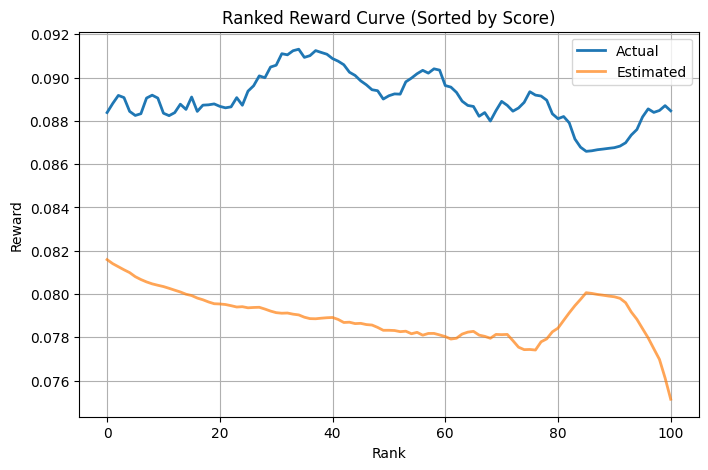

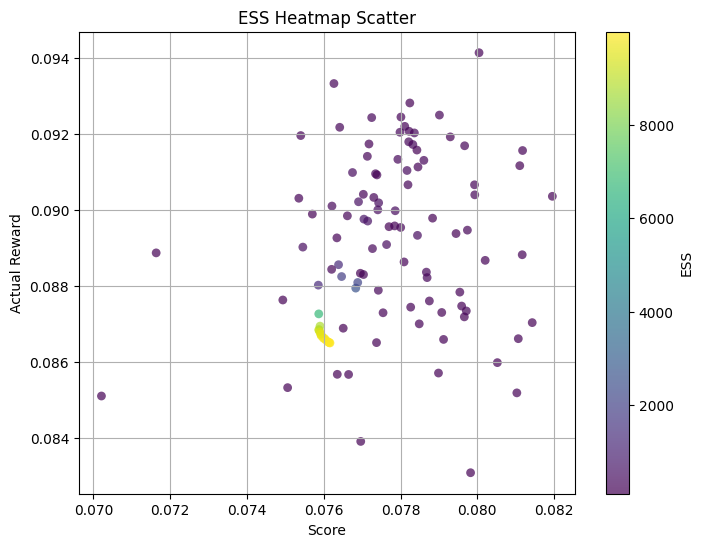

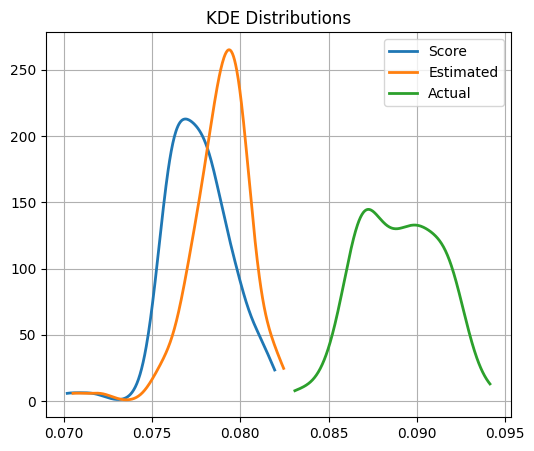

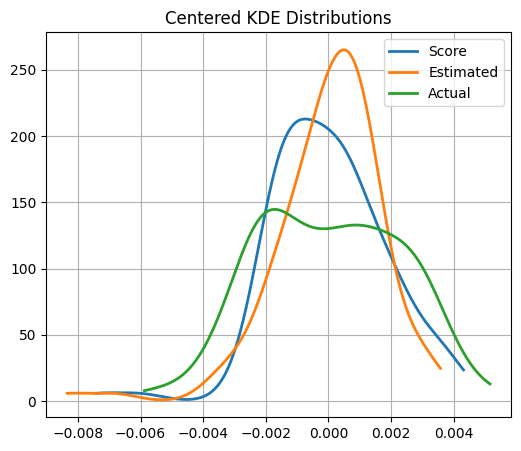

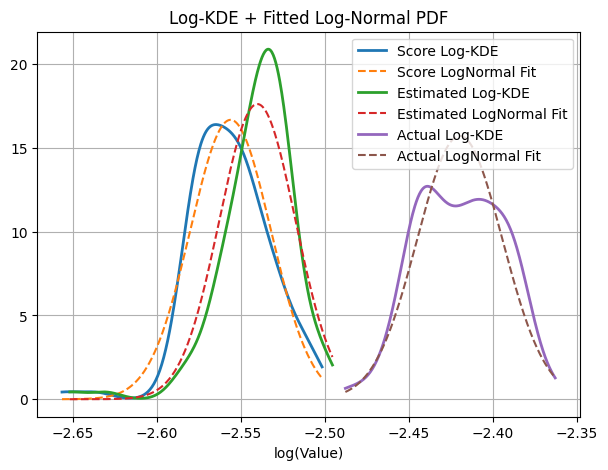

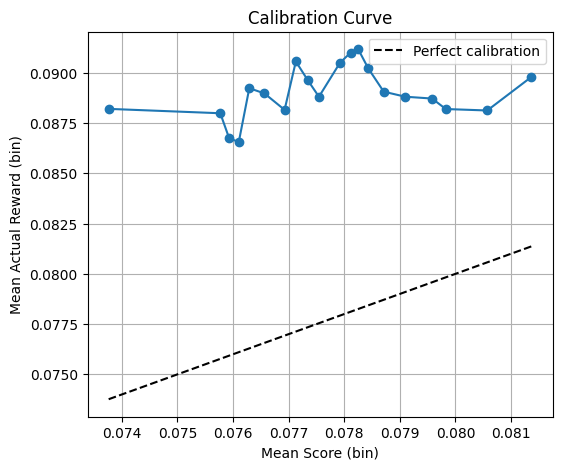

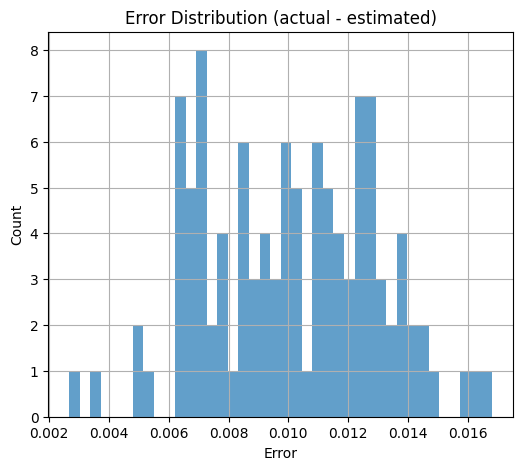

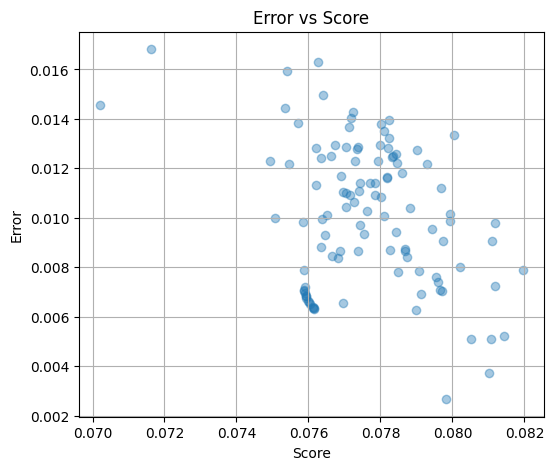

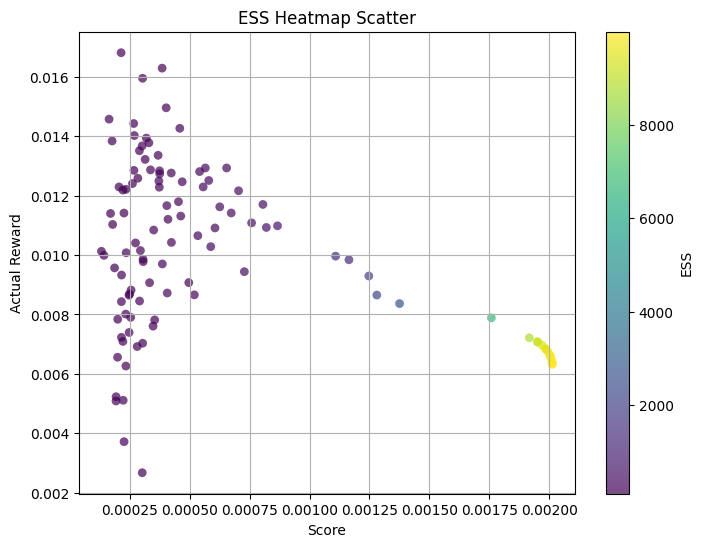

Correlation Metrics: {'pearson_score_actual': np.float64(0.19465495723042664), 'spearman_score_actual': np.float64(0.24294319340190904), 'spearman_est_actual': np.float64(-0.16967843573348163)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9920713981762415), 'ndcg_est_actual': np.float64(0.9912047009958885)}
Error Metrics: {'mean_error': np.float64(0.01009634940974361), 'mae': np.float64(0.01009634940974361), 'rmse': np.float64(0.010496519713095342), 'std_error': np.float64(0.0028706540515654236), 'max_error': np.float64(0.01681574174619059), 'min_error': np.float64(0.0026700487576839377)}


In [17]:
compute_statistics_and_plots(study_df6)

In [18]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=30000)

Random Item CTR: 0.07069350185865088
Optimal greedy CTR: 0.09999918303816259
Second Best greedy CTR: 0.09988806364453348
Optimal Stochastic CTR: 0.0999509448932121
second Best Stochastic CTR: 0.0863879153702632
Our Initial CTR: 0.08653966603258505


In [19]:
# Run the optimization
df7, study_df7 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df7.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{30000}.csv")
# Show the performance metrics
df7[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 10000 samples: 0.0588536262512207 seconds
[Regression] Baseline regression model fit time: 0.04s
Num samples is 10000
{'gini': np.float64(0.47550556213791373), 'ess': np.float64(4180.730998546769), 'max_wi': np.float64(24.269830992040323), 'min_wi': np.float64(0.012090514741419178)}
Eval time: 0.5432755947113037 seconds


[I 2025-12-14 23:52:17,450] A new study created in memory with name: no-name-8357af23-b676-41ea-9104-82e3373f26f4


Evaluation total results time: 0.88 seconds

=== [Regression] Training size 15000, run 0 ===
Simulation time for 25000 samples: 0.05958986282348633 seconds


  0%|          | 0/155 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.08454755]
Validation weights_info: {'gini': np.float64(0.9940686967081782), 'ess': np.float64(50.83339010594582), 'max_wi': np.float64(728.0549834834285), 'min_wi': np.float64(0.0)}


Best trial: 0. Best value: -inf:   1%|          | 1/155 [00:03<08:11,  3.19s/it]

[I 2025-12-14 23:52:20,640] Trial 0 finished with value: -inf and parameters: {'lr': 0.096, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.85}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 1
actual reward: [0.08666247]
Validation weights_info: {'gini': np.float64(0.04048733279947791), 'ess': np.float64(9945.081740121213), 'max_wi': np.float64(1.2704811845373138), 'min_wi': np.float64(0.8008886875103377)}


Best trial: 1. Best value: 0.076454:   1%|▏         | 2/155 [00:04<05:22,  2.11s/it]

[I 2025-12-14 23:52:21,986] Trial 1 finished with value: 0.0764539542820987 and parameters: {'lr': 0.0002711248033924262, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9574294533732122}. Best is trial 1 with value: 0.0764539542820987.

[Regression] Optuna Trial 2
actual reward: [0.09125459]
Validation weights_info: {'gini': np.float64(0.9870954002227217), 'ess': np.float64(136.63737049050818), 'max_wi': np.float64(173.3464983481955), 'min_wi': np.float64(5.685860669122061e-11)}


Best trial: 2. Best value: 0.0875165:   2%|▏         | 3/155 [00:06<05:14,  2.07s/it]

[I 2025-12-14 23:52:24,008] Trial 2 finished with value: 0.08751652051444767 and parameters: {'lr': 0.03917777445618133, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9070137042681123}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 3
actual reward: [0.08693453]
Validation weights_info: {'gini': np.float64(0.12919342919081198), 'ess': np.float64(9435.292151855307), 'max_wi': np.float64(2.0305913623781913), 'min_wi': np.float64(0.47268800837681474)}


Best trial: 2. Best value: 0.0875165:   3%|▎         | 4/155 [00:08<05:11,  2.06s/it]

[I 2025-12-14 23:52:26,057] Trial 3 finished with value: 0.07670458063902025 and parameters: {'lr': 0.00048789767959978383, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.866985778011029}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 4
actual reward: [0.08729465]
Validation weights_info: {'gini': np.float64(0.9891562667405103), 'ess': np.float64(96.05240892910838), 'max_wi': np.float64(646.4500857418476), 'min_wi': np.float64(4.9322518026238834e-21)}


Best trial: 2. Best value: 0.0875165:   3%|▎         | 5/155 [00:10<04:56,  1.97s/it]

[I 2025-12-14 23:52:27,880] Trial 4 finished with value: -inf and parameters: {'lr': 0.09400684928170641, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.981786004572914}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 5
actual reward: [0.08823302]
Validation weights_info: {'gini': np.float64(0.5069876227820548), 'ess': np.float64(4019.323314297964), 'max_wi': np.float64(12.264931579830428), 'min_wi': np.float64(0.03822573839511778)}


Best trial: 2. Best value: 0.0875165:   4%|▍         | 6/155 [00:12<05:03,  2.03s/it]

[I 2025-12-14 23:52:30,030] Trial 5 finished with value: 0.07933792037954296 and parameters: {'lr': 0.0016692949873971176, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.8509343604173398}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 6
actual reward: [0.08720175]
Validation weights_info: {'gini': np.float64(0.21186322061215498), 'ess': np.float64(8525.289531432636), 'max_wi': np.float64(3.1093189550311955), 'min_wi': np.float64(0.28803340041715825)}


Best trial: 2. Best value: 0.0875165:   5%|▍         | 7/155 [00:15<05:54,  2.39s/it]

[I 2025-12-14 23:52:33,164] Trial 6 finished with value: 0.07712946500239744 and parameters: {'lr': 0.0004900250531602278, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8451356812992761}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 7
actual reward: [0.08726526]
Validation weights_info: {'gini': np.float64(0.23350480419530434), 'ess': np.float64(8230.937119755452), 'max_wi': np.float64(3.355439727060208), 'min_wi': np.float64(0.24573759683005236)}


Best trial: 2. Best value: 0.0875165:   5%|▌         | 8/155 [00:17<05:42,  2.33s/it]

[I 2025-12-14 23:52:35,357] Trial 7 finished with value: 0.0773018817943871 and parameters: {'lr': 0.000563036650617092, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9547766521375777}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 8
actual reward: [0.09054813]
Validation weights_info: {'gini': np.float64(0.8597160307155737), 'ess': np.float64(789.3275234326719), 'max_wi': np.float64(62.71856041813757), 'min_wi': np.float64(0.0006559571734750022)}


Best trial: 2. Best value: 0.0875165:   6%|▌         | 9/155 [00:21<06:16,  2.58s/it]

[I 2025-12-14 23:52:38,476] Trial 8 finished with value: 0.08337589099344715 and parameters: {'lr': 0.0026819879896512414, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.9084106660657915}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 9
actual reward: [0.08840063]
Validation weights_info: {'gini': np.float64(0.5451951025963908), 'ess': np.float64(3654.8588522093623), 'max_wi': np.float64(11.558060609574875), 'min_wi': np.float64(0.026011658627889053)}


Best trial: 2. Best value: 0.0875165:   6%|▋         | 10/155 [00:25<07:19,  3.03s/it]

[I 2025-12-14 23:52:42,533] Trial 9 finished with value: 0.07972482373521732 and parameters: {'lr': 0.0008765647016272321, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.9650639445623548}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 10
actual reward: [0.09193264]
Validation weights_info: {'gini': np.float64(0.9799850432668905), 'ess': np.float64(150.47529801603312), 'max_wi': np.float64(366.794504897915), 'min_wi': np.float64(1.2430852648964304e-07)}


Best trial: 2. Best value: 0.0875165:   7%|▋         | 11/155 [00:27<06:37,  2.76s/it]

[I 2025-12-14 23:52:44,684] Trial 10 finished with value: 0.08587236205791934 and parameters: {'lr': 0.015137809374810062, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.909562422088118}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 11
actual reward: [0.0926416]
Validation weights_info: {'gini': np.float64(0.9776858728997362), 'ess': np.float64(182.19592024164743), 'max_wi': np.float64(145.50818021722174), 'min_wi': np.float64(5.3630699904939904e-08)}


Best trial: 2. Best value: 0.0875165:   8%|▊         | 12/155 [00:29<06:08,  2.57s/it]

[I 2025-12-14 23:52:46,826] Trial 11 finished with value: 0.08641392224321967 and parameters: {'lr': 0.015457185677124527, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.8982571735565623}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 12
actual reward: [0.09149817]
Validation weights_info: {'gini': np.float64(0.9335264129663046), 'ess': np.float64(338.1689161095382), 'max_wi': np.float64(80.83495476426408), 'min_wi': np.float64(5.8895479597551666e-05)}


Best trial: 2. Best value: 0.0875165:   8%|▊         | 13/155 [00:31<05:50,  2.47s/it]

[I 2025-12-14 23:52:49,044] Trial 12 finished with value: 0.08538854075449626 and parameters: {'lr': 0.011952226982892732, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.8058533200845768}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 13
actual reward: [0.09234362]
Validation weights_info: {'gini': np.float64(0.9804455096417286), 'ess': np.float64(179.51882634922293), 'max_wi': np.float64(133.31872174904294), 'min_wi': np.float64(2.439907573918674e-07)}


Best trial: 2. Best value: 0.0875165:   9%|▉         | 14/155 [00:33<05:28,  2.33s/it]

[I 2025-12-14 23:52:51,047] Trial 13 finished with value: 0.08674066945988884 and parameters: {'lr': 0.01698173756647512, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9279930604715259}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 14
actual reward: [0.09002426]
Validation weights_info: {'gini': np.float64(0.8951693650485802), 'ess': np.float64(542.1947532922064), 'max_wi': np.float64(97.97384398421701), 'min_wi': np.float64(0.00016115574901798743)}


Best trial: 2. Best value: 0.0875165:  10%|▉         | 15/155 [00:34<04:28,  1.92s/it]

[I 2025-12-14 23:52:52,011] Trial 14 finished with value: 0.08384056735722743 and parameters: {'lr': 0.03759505926805707, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.9366150013382595}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 15
actual reward: [0.09188497]
Validation weights_info: {'gini': np.float64(0.9308130933088853), 'ess': np.float64(342.2229850875616), 'max_wi': np.float64(79.58101421385349), 'min_wi': np.float64(6.821114433083224e-05)}


Best trial: 2. Best value: 0.0875165:  10%|█         | 16/155 [00:36<04:31,  1.95s/it]

[I 2025-12-14 23:52:54,057] Trial 15 finished with value: 0.08543430257988723 and parameters: {'lr': 0.00678955898732075, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9985490435333235}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 16
actual reward: [0.0916408]
Validation weights_info: {'gini': np.float64(0.9851518081421582), 'ess': np.float64(153.69769947084654), 'max_wi': np.float64(204.55536487364304), 'min_wi': np.float64(3.907689825627286e-11)}


Best trial: 2. Best value: 0.0875165:  11%|█         | 17/155 [00:38<04:24,  1.92s/it]

[I 2025-12-14 23:52:55,878] Trial 16 finished with value: 0.08689951076741594 and parameters: {'lr': 0.027821617118997076, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9264254738959714}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 17
actual reward: [0.09087663]
Validation weights_info: {'gini': np.float64(0.9885324425021659), 'ess': np.float64(119.89119837651123), 'max_wi': np.float64(225.93901680071943), 'min_wi': np.float64(1.8357802962877023e-11)}


Best trial: 2. Best value: 0.0875165:  12%|█▏        | 18/155 [00:40<04:13,  1.85s/it]

[I 2025-12-14 23:52:57,584] Trial 17 finished with value: 0.08616504847432387 and parameters: {'lr': 0.04793645908976779, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.8796360699397265}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 18
actual reward: [0.09185426]
Validation weights_info: {'gini': np.float64(0.9423010120174057), 'ess': np.float64(284.60989236721684), 'max_wi': np.float64(266.7985432950244), 'min_wi': np.float64(1.4621434341526122e-05)}


Best trial: 2. Best value: 0.0875165:  12%|█▏        | 19/155 [00:42<04:39,  2.06s/it]

[I 2025-12-14 23:53:00,123] Trial 18 finished with value: 0.08546229868617919 and parameters: {'lr': 0.005217132021857293, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.9321872960201147}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 19
actual reward: [0.08671921]
Validation weights_info: {'gini': np.float64(0.9983087677464462), 'ess': np.float64(9.161059074246936), 'max_wi': np.float64(2798.635779555324), 'min_wi': np.float64(3.8924502726788033e-13)}


Best trial: 2. Best value: 0.0875165:  13%|█▎        | 20/155 [00:44<04:38,  2.06s/it]

[I 2025-12-14 23:53:02,191] Trial 19 finished with value: -inf and parameters: {'lr': 0.037854634297967586, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.893029383626069}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 20
actual reward: [0.09051335]
Validation weights_info: {'gini': np.float64(0.9834997321722564), 'ess': np.float64(156.1476290946801), 'max_wi': np.float64(177.6995003811276), 'min_wi': np.float64(2.4917233397612015e-08)}


Best trial: 2. Best value: 0.0875165:  14%|█▎        | 21/155 [00:46<04:36,  2.06s/it]

[I 2025-12-14 23:53:04,256] Trial 20 finished with value: 0.08737657161835005 and parameters: {'lr': 0.026623995063691955, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8149919990070816}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 21
actual reward: [0.09173019]
Validation weights_info: {'gini': np.float64(0.9824666300923216), 'ess': np.float64(167.4255984076314), 'max_wi': np.float64(209.8010192288756), 'min_wi': np.float64(6.006302071127936e-09)}


Best trial: 2. Best value: 0.0875165:  14%|█▍        | 22/155 [00:48<04:33,  2.06s/it]

[I 2025-12-14 23:53:06,310] Trial 21 finished with value: 0.08721765121930157 and parameters: {'lr': 0.03140999020236012, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8029939978578978}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 22
actual reward: [0.09025165]
Validation weights_info: {'gini': np.float64(0.8395980903957122), 'ess': np.float64(750.2656848213607), 'max_wi': np.float64(64.32798057746314), 'min_wi': np.float64(0.0018464532465251)}


Best trial: 2. Best value: 0.0875165:  15%|█▍        | 23/155 [00:50<04:30,  2.05s/it]

[I 2025-12-14 23:53:08,330] Trial 22 finished with value: 0.08351520412708842 and parameters: {'lr': 0.007038208436669811, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8234416541570635}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 23
actual reward: [0.0891107]
Validation weights_info: {'gini': np.float64(0.9887553441535398), 'ess': np.float64(97.0796265947837), 'max_wi': np.float64(544.5989097929322), 'min_wi': np.float64(3.5190381668073395e-11)}


Best trial: 2. Best value: 0.0875165:  15%|█▌        | 24/155 [00:53<04:31,  2.07s/it]

[I 2025-12-14 23:53:10,453] Trial 23 finished with value: -inf and parameters: {'lr': 0.05805236637689942, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8035687796967342}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 24
actual reward: [0.08943684]
Validation weights_info: {'gini': np.float64(0.9831719467778627), 'ess': np.float64(146.46822524504785), 'max_wi': np.float64(206.57376303894804), 'min_wi': np.float64(2.693044767601386e-08)}


Best trial: 2. Best value: 0.0875165:  16%|█▌        | 25/155 [00:54<04:22,  2.02s/it]

[I 2025-12-14 23:53:12,362] Trial 24 finished with value: 0.08639733535912077 and parameters: {'lr': 0.023151170712240817, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.824057275329847}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 25
actual reward: [0.08286526]
Validation weights_info: {'gini': np.float64(0.9903688669451708), 'ess': np.float64(100.6309730084591), 'max_wi': np.float64(281.62708043040897), 'min_wi': np.float64(6.384416126850834e-15)}


Best trial: 2. Best value: 0.0875165:  17%|█▋        | 26/155 [00:56<04:19,  2.01s/it]

[I 2025-12-14 23:53:14,350] Trial 25 finished with value: 0.08708622063238163 and parameters: {'lr': 0.06533370464134916, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8250988548304822}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 26
actual reward: [0.08908991]
Validation weights_info: {'gini': np.float64(0.6773241771396169), 'ess': np.float64(2038.090856496), 'max_wi': np.float64(27.32181146637345), 'min_wi': np.float64(0.009200578041953858)}


Best trial: 2. Best value: 0.0875165:  17%|█▋        | 27/155 [00:59<04:25,  2.07s/it]

[I 2025-12-14 23:53:16,567] Trial 26 finished with value: 0.081140859861646 and parameters: {'lr': 0.003779243134574072, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.8622330348314263}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 27
actual reward: [0.08864502]
Validation weights_info: {'gini': np.float64(0.9975814467546537), 'ess': np.float64(12.065523917282002), 'max_wi': np.float64(2487.3905996745743), 'min_wi': np.float64(3.664039273093869e-13)}


Best trial: 2. Best value: 0.0875165:  18%|█▊        | 28/155 [01:02<05:07,  2.42s/it]

[I 2025-12-14 23:53:19,790] Trial 27 finished with value: -inf and parameters: {'lr': 0.023795091500745845, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.8323431277364615}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 28
actual reward: [0.08660893]
Validation weights_info: {'gini': np.float64(0.02283851344421498), 'ess': np.float64(9982.694947388642), 'max_wi': np.float64(1.1453066488980002), 'min_wi': np.float64(0.8781299359251425)}


Best trial: 2. Best value: 0.0875165:  19%|█▊        | 29/155 [01:04<04:53,  2.33s/it]

[I 2025-12-14 23:53:21,912] Trial 28 finished with value: 0.07642943307912006 and parameters: {'lr': 0.0001032887058469056, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8101724635756592}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 29
actual reward: [0.08490362]
Validation weights_info: {'gini': np.float64(0.995302504174335), 'ess': np.float64(18.474258832917588), 'max_wi': np.float64(2567.1614740132195), 'min_wi': np.float64(0.0)}


Best trial: 2. Best value: 0.0875165:  19%|█▉        | 30/155 [01:07<05:25,  2.60s/it]

[I 2025-12-14 23:53:25,151] Trial 29 finished with value: -inf and parameters: {'lr': 0.08199179579062905, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8814943373321782}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 30
actual reward: [0.09154736]
Validation weights_info: {'gini': np.float64(0.908302864095443), 'ess': np.float64(449.2442278513328), 'max_wi': np.float64(82.94891368420467), 'min_wi': np.float64(0.0003505919090370633)}


Best trial: 2. Best value: 0.0875165:  20%|██        | 31/155 [01:09<04:48,  2.32s/it]

[I 2025-12-14 23:53:26,828] Trial 30 finished with value: 0.08497148137291011 and parameters: {'lr': 0.011313693652920932, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8479010533290717}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 31
actual reward: [0.08579226]
Validation weights_info: {'gini': np.float64(0.989152612963861), 'ess': np.float64(96.75348876687454), 'max_wi': np.float64(516.5185912410448), 'min_wi': np.float64(1.3506678312034387e-12)}


Best trial: 2. Best value: 0.0875165:  21%|██        | 32/155 [01:11<04:25,  2.16s/it]

[I 2025-12-14 23:53:28,593] Trial 31 finished with value: -inf and parameters: {'lr': 0.06355471060940916, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8185999781538399}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 32
actual reward: [0.0907233]
Validation weights_info: {'gini': np.float64(0.9876947203974282), 'ess': np.float64(124.4509007801367), 'max_wi': np.float64(209.62548996501386), 'min_wi': np.float64(8.192251911902978e-11)}


Best trial: 2. Best value: 0.0875165:  21%|██▏       | 33/155 [01:13<04:19,  2.12s/it]

[I 2025-12-14 23:53:30,640] Trial 32 finished with value: 0.08619914474048485 and parameters: {'lr': 0.0366342421906267, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8349057186428865}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 33
actual reward: [0.09000629]
Validation weights_info: {'gini': np.float64(0.9876344049216166), 'ess': np.float64(131.27135340973737), 'max_wi': np.float64(215.81044258913494), 'min_wi': np.float64(5.939606135668726e-14)}


Best trial: 2. Best value: 0.0875165:  22%|██▏       | 34/155 [01:15<04:08,  2.05s/it]

[I 2025-12-14 23:53:32,517] Trial 33 finished with value: 0.08715601735675328 and parameters: {'lr': 0.06664594606556058, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.800846864008889}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 34
actual reward: [0.08884967]
Validation weights_info: {'gini': np.float64(0.987860764061862), 'ess': np.float64(106.69697991456259), 'max_wi': np.float64(423.13977603835576), 'min_wi': np.float64(4.914002868185381e-17)}


Best trial: 2. Best value: 0.0875165:  23%|██▎       | 35/155 [01:16<03:55,  1.97s/it]

[I 2025-12-14 23:53:34,286] Trial 34 finished with value: 0.08679169280657546 and parameters: {'lr': 0.09874648453729687, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.80089047042912}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 35
actual reward: [0.08611122]
Validation weights_info: {'gini': np.float64(0.9974989352762308), 'ess': np.float64(11.558980243653407), 'max_wi': np.float64(3118.8553768761244), 'min_wi': np.float64(3.77054089984225e-11)}


Best trial: 2. Best value: 0.0875165:  23%|██▎       | 36/155 [01:19<04:17,  2.16s/it]

[I 2025-12-14 23:53:36,915] Trial 35 finished with value: -inf and parameters: {'lr': 0.030939579422226613, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.812882093258337}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 36
actual reward: [0.08756086]
Validation weights_info: {'gini': np.float64(0.328147896941383), 'ess': np.float64(6913.209406476504), 'max_wi': np.float64(4.923399703953217), 'min_wi': np.float64(0.11435484223811922)}


Best trial: 2. Best value: 0.0875165:  24%|██▍       | 37/155 [01:20<03:38,  1.85s/it]

[I 2025-12-14 23:53:38,039] Trial 36 finished with value: 0.07806351992379429 and parameters: {'lr': 0.008856866446585007, 'num_epochs': 1, 'batch_size': 512, 'lr_decay': 0.8597168152530357}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 37
actual reward: [0.08600471]
Validation weights_info: {'gini': np.float64(0.9985114910723896), 'ess': np.float64(6.788157918727645), 'max_wi': np.float64(4527.4958911675185), 'min_wi': np.float64(1.254779038089126e-15)}


Best trial: 2. Best value: 0.0875165:  25%|██▍       | 38/155 [01:22<03:44,  1.92s/it]

[I 2025-12-14 23:53:40,126] Trial 37 finished with value: -inf and parameters: {'lr': 0.048703986198554795, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.8389367324110977}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 38
actual reward: [0.09164956]
Validation weights_info: {'gini': np.float64(0.995197737106904), 'ess': np.float64(16.37709685367404), 'max_wi': np.float64(2984.3876407042226), 'min_wi': np.float64(3.1769195504673726e-14)}


Best trial: 2. Best value: 0.0875165:  25%|██▌       | 39/155 [01:27<05:34,  2.88s/it]

[I 2025-12-14 23:53:45,247] Trial 38 finished with value: -inf and parameters: {'lr': 0.02206550409694146, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.8775408647103118}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 39
actual reward: [0.0878184]
Validation weights_info: {'gini': np.float64(0.3858305802723504), 'ess': np.float64(5872.419208219157), 'max_wi': np.float64(6.5351158142907835), 'min_wi': np.float64(0.09477848840991829)}


Best trial: 2. Best value: 0.0875165:  26%|██▌       | 40/155 [01:29<04:54,  2.56s/it]

[I 2025-12-14 23:53:47,059] Trial 39 finished with value: 0.07839397451510699 and parameters: {'lr': 0.0018177806316062252, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9139320952955426}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 40
actual reward: [0.08921111]
Validation weights_info: {'gini': np.float64(0.9896995462686948), 'ess': np.float64(97.90209916044799), 'max_wi': np.float64(361.7758854172055), 'min_wi': np.float64(6.0270881334307815e-15)}


Best trial: 2. Best value: 0.0875165:  26%|██▋       | 41/155 [01:31<04:22,  2.30s/it]

[I 2025-12-14 23:53:48,760] Trial 40 finished with value: -inf and parameters: {'lr': 0.0803720982967451, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9446761319599664}. Best is trial 2 with value: 0.08751652051444767.

[Regression] Optuna Trial 41
actual reward: [0.09188386]
Validation weights_info: {'gini': np.float64(0.9873712673432778), 'ess': np.float64(110.30506579820452), 'max_wi': np.float64(559.112685522638), 'min_wi': np.float64(3.802596295508298e-13)}


Best trial: 41. Best value: 0.0882387:  27%|██▋       | 42/155 [01:33<04:04,  2.17s/it]

[I 2025-12-14 23:53:50,609] Trial 41 finished with value: 0.08823866514689296 and parameters: {'lr': 0.05758745614147889, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8180221814691596}. Best is trial 41 with value: 0.08823866514689296.

[Regression] Optuna Trial 42
actual reward: [0.09065275]
Validation weights_info: {'gini': np.float64(0.9870274253868301), 'ess': np.float64(126.88903877265236), 'max_wi': np.float64(273.77181336735765), 'min_wi': np.float64(7.06724013902522e-11)}


Best trial: 41. Best value: 0.0882387:  28%|██▊       | 43/155 [01:34<03:50,  2.06s/it]

[I 2025-12-14 23:53:52,405] Trial 42 finished with value: 0.08727006013976751 and parameters: {'lr': 0.05041149581858908, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.8127574703722223}. Best is trial 41 with value: 0.08823866514689296.

[Regression] Optuna Trial 43
actual reward: [0.09174872]
Validation weights_info: {'gini': np.float64(0.9670149958764765), 'ess': np.float64(207.065709232477), 'max_wi': np.float64(115.01204976093757), 'min_wi': np.float64(2.1672192352778876e-06)}


Best trial: 41. Best value: 0.0882387:  28%|██▊       | 44/155 [01:36<03:41,  1.99s/it]

[I 2025-12-14 23:53:54,254] Trial 43 finished with value: 0.08651843501016933 and parameters: {'lr': 0.018374898283687345, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.8132998820528005}. Best is trial 41 with value: 0.08823866514689296.

[Regression] Optuna Trial 44
actual reward: [0.08988506]
Validation weights_info: {'gini': np.float64(0.9913307060007056), 'ess': np.float64(67.85136888320389), 'max_wi': np.float64(438.1550748668724), 'min_wi': np.float64(1.0027716112002167e-20)}


Best trial: 41. Best value: 0.0882387:  29%|██▉       | 45/155 [01:41<05:16,  2.88s/it]

[I 2025-12-14 23:53:59,200] Trial 44 finished with value: -inf and parameters: {'lr': 0.042278587058337404, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.8552821067786522}. Best is trial 41 with value: 0.08823866514689296.

[Regression] Optuna Trial 45
actual reward: [0.0914368]
Validation weights_info: {'gini': np.float64(0.9334054031235277), 'ess': np.float64(340.0724202513809), 'max_wi': np.float64(86.84999990172639), 'min_wi': np.float64(5.9968189410545475e-05)}


Best trial: 41. Best value: 0.0882387:  30%|██▉       | 46/155 [01:43<04:36,  2.53s/it]

[I 2025-12-14 23:54:00,928] Trial 45 finished with value: 0.08570327709497971 and parameters: {'lr': 0.01270318970710319, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.8312963382534494}. Best is trial 41 with value: 0.08823866514689296.

[Regression] Optuna Trial 46
actual reward: [0.09242091]
Validation weights_info: {'gini': np.float64(0.9839304734653378), 'ess': np.float64(163.20877228218845), 'max_wi': np.float64(153.11776865940013), 'min_wi': np.float64(6.254490840470212e-09)}


Best trial: 41. Best value: 0.0882387:  30%|███       | 47/155 [01:45<04:22,  2.43s/it]

[I 2025-12-14 23:54:03,114] Trial 46 finished with value: 0.0864814844184556 and parameters: {'lr': 0.028792717091257237, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.8409783154156325}. Best is trial 41 with value: 0.08823866514689296.

[Regression] Optuna Trial 47
actual reward: [0.087478]
Validation weights_info: {'gini': np.float64(0.9975997203743698), 'ess': np.float64(13.544414417021526), 'max_wi': np.float64(1805.5452694635846), 'min_wi': np.float64(5.917798518681463e-13)}


Best trial: 41. Best value: 0.0882387:  31%|███       | 48/155 [01:47<04:10,  2.34s/it]

[I 2025-12-14 23:54:05,233] Trial 47 finished with value: -inf and parameters: {'lr': 0.0480341948395899, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8169044173787708}. Best is trial 41 with value: 0.08823866514689296.

[Regression] Optuna Trial 48
actual reward: [0.09019854]
Validation weights_info: {'gini': np.float64(0.996174636231483), 'ess': np.float64(12.614833685129001), 'max_wi': np.float64(2451.641475324891), 'min_wi': np.float64(9.361879961761675e-16)}


Best trial: 41. Best value: 0.0882387:  32%|███▏      | 49/155 [01:51<04:36,  2.61s/it]

[I 2025-12-14 23:54:08,473] Trial 48 finished with value: -inf and parameters: {'lr': 0.03153934027917213, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.8919108927942011}. Best is trial 41 with value: 0.08823866514689296.

[Regression] Optuna Trial 49
actual reward: [0.08673987]
Validation weights_info: {'gini': np.float64(0.06436150927738968), 'ess': np.float64(9860.878206579584), 'max_wi': np.float64(1.4248827826517125), 'min_wi': np.float64(0.7024822330955475)}


Best trial: 41. Best value: 0.0882387:  32%|███▏      | 50/155 [01:52<03:49,  2.18s/it]

[I 2025-12-14 23:54:09,667] Trial 49 finished with value: 0.07650046765964201 and parameters: {'lr': 0.0009963905453553577, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9177221580385252}. Best is trial 41 with value: 0.08823866514689296.

[Regression] Optuna Trial 50
actual reward: [0.09167027]
Validation weights_info: {'gini': np.float64(0.9487136937917036), 'ess': np.float64(275.43458026106254), 'max_wi': np.float64(94.70767497627462), 'min_wi': np.float64(2.7388600915355273e-05)}


Best trial: 41. Best value: 0.0882387:  33%|███▎      | 51/155 [01:53<03:21,  1.93s/it]

[I 2025-12-14 23:54:11,020] Trial 50 finished with value: 0.08605995448510668 and parameters: {'lr': 0.01857299872446194, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.8729119586728457}. Best is trial 41 with value: 0.08823866514689296.

[Regression] Optuna Trial 51
actual reward: [0.08989047]
Validation weights_info: {'gini': np.float64(0.9893490339463592), 'ess': np.float64(99.15690470472754), 'max_wi': np.float64(447.69322810692944), 'min_wi': np.float64(3.149825307923387e-11)}


Best trial: 41. Best value: 0.0882387:  34%|███▎      | 52/155 [01:55<03:19,  1.94s/it]

[I 2025-12-14 23:54:12,961] Trial 51 finished with value: -inf and parameters: {'lr': 0.05774181900865103, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8002555416788032}. Best is trial 41 with value: 0.08823866514689296.

[Regression] Optuna Trial 52
actual reward: [0.0866013]
Validation weights_info: {'gini': np.float64(0.9899906487313155), 'ess': np.float64(86.22187629383893), 'max_wi': np.float64(671.3293017765792), 'min_wi': np.float64(4.812285826059659e-13)}


Best trial: 41. Best value: 0.0882387:  34%|███▍      | 53/155 [01:57<03:12,  1.89s/it]

[I 2025-12-14 23:54:14,744] Trial 52 finished with value: -inf and parameters: {'lr': 0.06844362349440952, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.8106939247956338}. Best is trial 41 with value: 0.08823866514689296.

[Regression] Optuna Trial 53
actual reward: [0.08891592]
Validation weights_info: {'gini': np.float64(0.9888416744888661), 'ess': np.float64(110.20005955842369), 'max_wi': np.float64(362.36041994600293), 'min_wi': np.float64(1.186304994060074e-15)}


Best trial: 53. Best value: 0.0887502:  35%|███▍      | 54/155 [01:59<03:11,  1.90s/it]

[I 2025-12-14 23:54:16,662] Trial 53 finished with value: 0.08875017478976667 and parameters: {'lr': 0.08450955743629171, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8234925739215014}. Best is trial 53 with value: 0.08875017478976667.

[Regression] Optuna Trial 54
actual reward: [0.09033565]
Validation weights_info: {'gini': np.float64(0.9896341349091049), 'ess': np.float64(108.9606048244571), 'max_wi': np.float64(237.6155305949731), 'min_wi': np.float64(2.174418918752134e-17)}


Best trial: 53. Best value: 0.0887502:  35%|███▌      | 55/155 [02:01<03:11,  1.92s/it]

[I 2025-12-14 23:54:18,627] Trial 54 finished with value: 0.08630129543731745 and parameters: {'lr': 0.08331798432775804, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8317789493298113}. Best is trial 53 with value: 0.08875017478976667.

[Regression] Optuna Trial 55
actual reward: [0.08495827]
Validation weights_info: {'gini': np.float64(0.9900517046970214), 'ess': np.float64(82.66530278786482), 'max_wi': np.float64(722.7849031622977), 'min_wi': np.float64(8.110085100786707e-19)}


Best trial: 53. Best value: 0.0887502:  36%|███▌      | 56/155 [02:02<03:03,  1.85s/it]

[I 2025-12-14 23:54:20,331] Trial 55 finished with value: -inf and parameters: {'lr': 0.09862518659662572, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.8235152240048301}. Best is trial 53 with value: 0.08875017478976667.

[Regression] Optuna Trial 56
actual reward: [0.08938063]
Validation weights_info: {'gini': np.float64(0.9884491329381597), 'ess': np.float64(121.74467131823606), 'max_wi': np.float64(280.90746071095964), 'min_wi': np.float64(5.316033488344036e-15)}


Best trial: 56. Best value: 0.089622:  37%|███▋      | 57/155 [02:04<03:08,  1.92s/it] 

[I 2025-12-14 23:54:22,405] Trial 56 finished with value: 0.08962200271893281 and parameters: {'lr': 0.04708242631156002, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9742220742986963}. Best is trial 56 with value: 0.08962200271893281.

[Regression] Optuna Trial 57
actual reward: [0.08979334]
Validation weights_info: {'gini': np.float64(0.9894898010652518), 'ess': np.float64(110.9830383391869), 'max_wi': np.float64(273.8564960896524), 'min_wi': np.float64(5.1406145194543486e-15)}


Best trial: 56. Best value: 0.089622:  37%|███▋      | 58/155 [02:06<03:05,  1.91s/it]

[I 2025-12-14 23:54:24,298] Trial 57 finished with value: 0.08804249680930165 and parameters: {'lr': 0.04703845505252028, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9814082229451514}. Best is trial 56 with value: 0.08962200271893281.

[Regression] Optuna Trial 58
actual reward: [0.08949291]
Validation weights_info: {'gini': np.float64(0.9931009528051955), 'ess': np.float64(52.59986901177347), 'max_wi': np.float64(583.1612493135526), 'min_wi': np.float64(1.142397193055809e-30)}


Best trial: 56. Best value: 0.089622:  38%|███▊      | 59/155 [02:12<04:49,  3.01s/it]

[I 2025-12-14 23:54:29,871] Trial 58 finished with value: -inf and parameters: {'lr': 0.04097049657546223, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.9720679686504732}. Best is trial 56 with value: 0.08962200271893281.

[Regression] Optuna Trial 59
actual reward: [0.08878156]
Validation weights_info: {'gini': np.float64(0.9909506171305152), 'ess': np.float64(62.05252301149297), 'max_wi': np.float64(668.1286571354742), 'min_wi': np.float64(4.2777339229679753e-10)}


Best trial: 56. Best value: 0.089622:  39%|███▊      | 60/155 [02:14<04:19,  2.73s/it]

[I 2025-12-14 23:54:31,940] Trial 59 finished with value: -inf and parameters: {'lr': 0.025240750314647096, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9833385089727165}. Best is trial 56 with value: 0.08962200271893281.

[Regression] Optuna Trial 60
actual reward: [0.08745297]
Validation weights_info: {'gini': np.float64(0.9969226137280626), 'ess': np.float64(10.006059521987531), 'max_wi': np.float64(4535.5428434684545), 'min_wi': np.float64(2.315705067995341e-24)}


Best trial: 56. Best value: 0.089622:  39%|███▉      | 61/155 [02:17<04:25,  2.82s/it]

[I 2025-12-14 23:54:34,988] Trial 60 finished with value: -inf and parameters: {'lr': 0.05075013933413426, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.9902447449272006}. Best is trial 56 with value: 0.08962200271893281.

[Regression] Optuna Trial 61
actual reward: [0.09205537]
Validation weights_info: {'gini': np.float64(0.9881220418730348), 'ess': np.float64(106.21547005053081), 'max_wi': np.float64(467.00471609763684), 'min_wi': np.float64(1.537712257527909e-11)}


Best trial: 61. Best value: 0.090358:  40%|████      | 62/155 [02:19<03:57,  2.56s/it]

[I 2025-12-14 23:54:36,923] Trial 61 finished with value: 0.09035800167628988 and parameters: {'lr': 0.03828616117478143, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9547339532819615}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 62
actual reward: [0.09037881]
Validation weights_info: {'gini': np.float64(0.9900185258888816), 'ess': np.float64(86.2468482529868), 'max_wi': np.float64(562.5116752943907), 'min_wi': np.float64(9.26626228416869e-12)}


Best trial: 61. Best value: 0.090358:  41%|████      | 63/155 [02:21<03:44,  2.44s/it]

[I 2025-12-14 23:54:39,105] Trial 62 finished with value: -inf and parameters: {'lr': 0.03638263853025525, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.959573100571209}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 63
actual reward: [0.08675022]
Validation weights_info: {'gini': np.float64(0.06750732996318673), 'ess': np.float64(9845.965592028835), 'max_wi': np.float64(1.4587939040186821), 'min_wi': np.float64(0.691117441749857)}


Best trial: 61. Best value: 0.090358:  41%|████▏     | 64/155 [02:23<03:31,  2.32s/it]

[I 2025-12-14 23:54:41,150] Trial 63 finished with value: 0.07651486220159799 and parameters: {'lr': 0.0002743987402541162, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9753487106011824}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 64
actual reward: [0.08270157]
Validation weights_info: {'gini': np.float64(0.9911434237371937), 'ess': np.float64(73.00958471415676), 'max_wi': np.float64(547.2454809178173), 'min_wi': np.float64(1.7393315316094317e-21)}


Best trial: 61. Best value: 0.090358:  42%|████▏     | 65/155 [02:25<03:26,  2.30s/it]

[I 2025-12-14 23:54:43,377] Trial 64 finished with value: -inf and parameters: {'lr': 0.07722052802255393, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9499716999674727}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 65
actual reward: [0.0915915]
Validation weights_info: {'gini': np.float64(0.9857753406146553), 'ess': np.float64(127.17771373219706), 'max_wi': np.float64(430.53393934363856), 'min_wi': np.float64(2.7267253137066986e-09)}


Best trial: 61. Best value: 0.090358:  43%|████▎     | 66/155 [02:27<03:15,  2.20s/it]

[I 2025-12-14 23:54:45,349] Trial 65 finished with value: 0.08724385979100031 and parameters: {'lr': 0.020712611654069648, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.965685951095338}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 66
actual reward: [0.08812721]
Validation weights_info: {'gini': np.float64(0.9949895057133464), 'ess': np.float64(31.114444438281303), 'max_wi': np.float64(774.9223910255905), 'min_wi': np.float64(2.197134556426886e-22)}


Best trial: 61. Best value: 0.090358:  43%|████▎     | 67/155 [02:30<03:21,  2.28s/it]

[I 2025-12-14 23:54:47,833] Trial 66 finished with value: -inf and parameters: {'lr': 0.05920043844822713, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9993388214294624}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 67
actual reward: [0.07742983]
Validation weights_info: {'gini': np.float64(0.9975263220932171), 'ess': np.float64(7.826464288808259), 'max_wi': np.float64(2853.660030760707), 'min_wi': np.float64(6.350877316648555e-13)}


Best trial: 61. Best value: 0.090358:  44%|████▍     | 68/155 [02:32<03:08,  2.17s/it]

[I 2025-12-14 23:54:49,737] Trial 67 finished with value: -inf and parameters: {'lr': 0.03439002657360301, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9863926029116558}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 68
actual reward: [0.09267385]
Validation weights_info: {'gini': np.float64(0.9831965247918195), 'ess': np.float64(153.2473755108937), 'max_wi': np.float64(197.50088152620015), 'min_wi': np.float64(1.4570022847333038e-08)}


Best trial: 61. Best value: 0.090358:  45%|████▍     | 69/155 [02:34<03:02,  2.12s/it]

[I 2025-12-14 23:54:51,743] Trial 68 finished with value: 0.0871813690313447 and parameters: {'lr': 0.01564175383359291, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9419419954898276}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 69
actual reward: [0.08872194]
Validation weights_info: {'gini': np.float64(0.9883475390505275), 'ess': np.float64(115.70804416277662), 'max_wi': np.float64(277.9391087769978), 'min_wi': np.float64(2.444387615274194e-10)}


Best trial: 61. Best value: 0.090358:  45%|████▌     | 70/155 [02:35<02:45,  1.95s/it]

[I 2025-12-14 23:54:53,296] Trial 69 finished with value: 0.08553862333255007 and parameters: {'lr': 0.040893833341017795, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.9766426771552206}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 70
actual reward: [0.09189457]
Validation weights_info: {'gini': np.float64(0.9853603440427068), 'ess': np.float64(143.45047353354627), 'max_wi': np.float64(262.7364111309234), 'min_wi': np.float64(5.021819600991229e-09)}


Best trial: 61. Best value: 0.090358:  46%|████▌     | 71/155 [02:37<02:39,  1.90s/it]

[I 2025-12-14 23:54:55,066] Trial 70 finished with value: 0.08715435941728465 and parameters: {'lr': 0.028070307660830147, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.966020073245812}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 71
actual reward: [0.08985723]
Validation weights_info: {'gini': np.float64(0.9936421136624275), 'ess': np.float64(28.495352100972447), 'max_wi': np.float64(1272.4806131758244), 'min_wi': np.float64(1.2512290840817215e-15)}


Best trial: 61. Best value: 0.090358:  46%|████▋     | 72/155 [02:39<02:35,  1.87s/it]

[I 2025-12-14 23:54:56,886] Trial 71 finished with value: -inf and parameters: {'lr': 0.05128632145765863, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9918855498416956}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 72
actual reward: [0.08834389]
Validation weights_info: {'gini': np.float64(0.988886033073771), 'ess': np.float64(111.26883903066819), 'max_wi': np.float64(437.65156393841283), 'min_wi': np.float64(1.6815983807477508e-15)}


Best trial: 61. Best value: 0.090358:  47%|████▋     | 73/155 [02:41<02:29,  1.82s/it]

[I 2025-12-14 23:54:58,583] Trial 72 finished with value: 0.0884230636509371 and parameters: {'lr': 0.0684724051739667, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9584981066992097}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 73
actual reward: [0.08561981]
Validation weights_info: {'gini': np.float64(0.9895872107409746), 'ess': np.float64(101.09305097022703), 'max_wi': np.float64(471.98900317189873), 'min_wi': np.float64(3.0570168689808e-16)}


Best trial: 61. Best value: 0.090358:  48%|████▊     | 74/155 [02:43<02:30,  1.86s/it]

[I 2025-12-14 23:55:00,536] Trial 73 finished with value: 0.0867650780594952 and parameters: {'lr': 0.07024332151175375, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9582419582347398}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 74
actual reward: [0.08318013]
Validation weights_info: {'gini': np.float64(0.991512273754022), 'ess': np.float64(65.51080547431567), 'max_wi': np.float64(825.504924185122), 'min_wi': np.float64(5.010190699806136e-21)}


Best trial: 61. Best value: 0.090358:  48%|████▊     | 75/155 [02:44<02:28,  1.86s/it]

[I 2025-12-14 23:55:02,382] Trial 74 finished with value: -inf and parameters: {'lr': 0.0871951555139903, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9704341379466029}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 75
actual reward: [0.09225869]
Validation weights_info: {'gini': np.float64(0.9893092510013471), 'ess': np.float64(99.55820319478259), 'max_wi': np.float64(557.5676162839718), 'min_wi': np.float64(1.0680694657353628e-15)}


Best trial: 61. Best value: 0.090358:  49%|████▉     | 76/155 [02:46<02:25,  1.84s/it]

[I 2025-12-14 23:55:04,200] Trial 75 finished with value: -inf and parameters: {'lr': 0.06040033825535726, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9519751455049951}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 76
actual reward: [0.09021274]
Validation weights_info: {'gini': np.float64(0.9894864326232701), 'ess': np.float64(86.92365135253013), 'max_wi': np.float64(562.4533412455921), 'min_wi': np.float64(7.712015113153776e-12)}


Best trial: 61. Best value: 0.090358:  50%|████▉     | 77/155 [02:48<02:30,  1.92s/it]

[I 2025-12-14 23:55:06,312] Trial 76 finished with value: -inf and parameters: {'lr': 0.04197589303112185, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9424930677081895}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 77
actual reward: [0.08191627]
Validation weights_info: {'gini': np.float64(0.9936396538952719), 'ess': np.float64(60.0388962295661), 'max_wi': np.float64(508.42003712812544), 'min_wi': np.float64(0.0)}


Best trial: 61. Best value: 0.090358:  50%|█████     | 78/155 [02:53<03:28,  2.71s/it]

[I 2025-12-14 23:55:10,860] Trial 77 finished with value: -inf and parameters: {'lr': 0.09925768620811531, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9331334764349107}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 78
actual reward: [0.08957113]
Validation weights_info: {'gini': np.float64(0.7564788843003686), 'ess': np.float64(1333.066230613345), 'max_wi': np.float64(48.82880849564464), 'min_wi': np.float64(0.004943508894443065)}


Best trial: 61. Best value: 0.090358:  51%|█████     | 79/155 [02:55<03:09,  2.49s/it]

[I 2025-12-14 23:55:12,830] Trial 78 finished with value: 0.08189296500748296 and parameters: {'lr': 0.0031279095687932984, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9778731131487737}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 79
actual reward: [0.08251675]
Validation weights_info: {'gini': np.float64(0.9960460026894111), 'ess': np.float64(12.819816469395063), 'max_wi': np.float64(2336.742807739214), 'min_wi': np.float64(5.718235952280737e-20)}


Best trial: 61. Best value: 0.090358:  52%|█████▏    | 80/155 [02:57<02:56,  2.36s/it]

[I 2025-12-14 23:55:14,884] Trial 79 finished with value: -inf and parameters: {'lr': 0.07584614874897255, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9245836904099902}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 80
actual reward: [0.08392509]
Validation weights_info: {'gini': np.float64(0.9929225027516869), 'ess': np.float64(72.00857842452409), 'max_wi': np.float64(272.0146771175184), 'min_wi': np.float64(2.7899347236416395e-27)}


Best trial: 61. Best value: 0.090358:  52%|█████▏    | 81/155 [03:00<03:08,  2.54s/it]

[I 2025-12-14 23:55:17,863] Trial 80 finished with value: -inf and parameters: {'lr': 0.055328838199977276, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.9927880286391296}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 81
actual reward: [0.09126647]
Validation weights_info: {'gini': np.float64(0.9874022197726292), 'ess': np.float64(116.09811831941786), 'max_wi': np.float64(445.6010233731133), 'min_wi': np.float64(1.028443111791426e-11)}


Best trial: 61. Best value: 0.090358:  53%|█████▎    | 82/155 [03:02<02:50,  2.33s/it]

[I 2025-12-14 23:55:19,706] Trial 81 finished with value: 0.09012461890596195 and parameters: {'lr': 0.04462493585189549, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9020712976005435}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 82
actual reward: [0.09158655]
Validation weights_info: {'gini': np.float64(0.9848247172999457), 'ess': np.float64(146.13291965231258), 'max_wi': np.float64(175.26709523655524), 'min_wi': np.float64(1.2343857498165153e-08)}


Best trial: 61. Best value: 0.090358:  54%|█████▎    | 83/155 [03:03<02:34,  2.15s/it]

[I 2025-12-14 23:55:21,421] Trial 82 finished with value: 0.0865743998704999 and parameters: {'lr': 0.02499053769696407, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9023791749308786}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 83
actual reward: [0.0908888]
Validation weights_info: {'gini': np.float64(0.9879248027935984), 'ess': np.float64(126.90003344581837), 'max_wi': np.float64(258.71028467963936), 'min_wi': np.float64(2.091115737553262e-11)}


Best trial: 61. Best value: 0.090358:  54%|█████▍    | 84/155 [03:05<02:23,  2.02s/it]

[I 2025-12-14 23:55:23,152] Trial 83 finished with value: 0.08734787107686753 and parameters: {'lr': 0.04421248665694144, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8847695502067033}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 84
actual reward: [0.09262971]
Validation weights_info: {'gini': np.float64(0.985729435333487), 'ess': np.float64(143.34276422718298), 'max_wi': np.float64(198.76546390520102), 'min_wi': np.float64(2.130311115261229e-10)}


Best trial: 61. Best value: 0.090358:  55%|█████▍    | 85/155 [03:07<02:19,  2.00s/it]

[I 2025-12-14 23:55:25,086] Trial 84 finished with value: 0.0887582351078152 and parameters: {'lr': 0.03401746541547491, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9064112606835782}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 85
actual reward: [0.09162753]
Validation weights_info: {'gini': np.float64(0.9865152192939953), 'ess': np.float64(137.345602943882), 'max_wi': np.float64(263.07104326967334), 'min_wi': np.float64(1.7844176774079018e-10)}


Best trial: 61. Best value: 0.090358:  55%|█████▌    | 86/155 [03:09<02:12,  1.92s/it]

[I 2025-12-14 23:55:26,826] Trial 85 finished with value: 0.08727465458589875 and parameters: {'lr': 0.0329516225198658, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.919882465259301}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 86
actual reward: [0.08616774]
Validation weights_info: {'gini': np.float64(0.990946725737024), 'ess': np.float64(95.24351022788547), 'max_wi': np.float64(261.42998336356715), 'min_wi': np.float64(1.2532912837997501e-14)}


Best trial: 61. Best value: 0.090358:  56%|█████▌    | 87/155 [03:11<02:09,  1.91s/it]

[I 2025-12-14 23:55:28,710] Trial 86 finished with value: -inf and parameters: {'lr': 0.06517246249633396, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9089954239382874}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 87
actual reward: [0.09132279]
Validation weights_info: {'gini': np.float64(0.9880833357710604), 'ess': np.float64(125.74165102252698), 'max_wi': np.float64(184.5183804059908), 'min_wi': np.float64(4.2531425525520764e-10)}


Best trial: 61. Best value: 0.090358:  57%|█████▋    | 88/155 [03:13<02:08,  1.92s/it]

[I 2025-12-14 23:55:30,671] Trial 87 finished with value: 0.08709329085396215 and parameters: {'lr': 0.035359889106562445, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.904245373174266}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 88
actual reward: [0.09282594]
Validation weights_info: {'gini': np.float64(0.9858858505933851), 'ess': np.float64(139.57991215944116), 'max_wi': np.float64(267.6587374305504), 'min_wi': np.float64(4.09759009379705e-12)}


Best trial: 61. Best value: 0.090358:  57%|█████▋    | 89/155 [03:15<02:04,  1.89s/it]

[I 2025-12-14 23:55:32,471] Trial 88 finished with value: 0.08590134120172097 and parameters: {'lr': 0.04480290288466064, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.8980382038255793}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 89
actual reward: [0.09203671]
Validation weights_info: {'gini': np.float64(0.9610908816020197), 'ess': np.float64(241.97716444909938), 'max_wi': np.float64(116.38599419529487), 'min_wi': np.float64(4.062462864866427e-06)}


Best trial: 61. Best value: 0.090358:  58%|█████▊    | 90/155 [03:16<02:02,  1.88s/it]

[I 2025-12-14 23:55:34,350] Trial 89 finished with value: 0.08570194074514222 and parameters: {'lr': 0.012900725677356669, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8901058628976178}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 90
actual reward: [0.08891245]
Validation weights_info: {'gini': np.float64(0.9895837921012917), 'ess': np.float64(97.73195539081739), 'max_wi': np.float64(362.35363805482115), 'min_wi': np.float64(6.515888944529038e-16)}


Best trial: 61. Best value: 0.090358:  59%|█████▊    | 91/155 [03:18<01:58,  1.86s/it]

[I 2025-12-14 23:55:36,144] Trial 90 finished with value: -inf and parameters: {'lr': 0.07119732962814991, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9606060175305565}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 91
actual reward: [0.09267432]
Validation weights_info: {'gini': np.float64(0.9856570892560137), 'ess': np.float64(140.69696210242765), 'max_wi': np.float64(317.40748486078485), 'min_wi': np.float64(1.4132496852298112e-10)}


Best trial: 61. Best value: 0.090358:  59%|█████▉    | 92/155 [03:20<02:00,  1.91s/it]

[I 2025-12-14 23:55:38,184] Trial 91 finished with value: 0.08753159796090326 and parameters: {'lr': 0.029173812612667, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8957631309271711}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 92
actual reward: [0.09216214]
Validation weights_info: {'gini': np.float64(0.9814777964514486), 'ess': np.float64(165.17655566304663), 'max_wi': np.float64(146.7234851881171), 'min_wi': np.float64(1.471140733337787e-08)}


Best trial: 61. Best value: 0.090358:  60%|██████    | 93/155 [03:22<02:03,  2.00s/it]

[I 2025-12-14 23:55:40,388] Trial 92 finished with value: 0.08639542930034685 and parameters: {'lr': 0.020597825063518642, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8744895185482592}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 93
actual reward: [0.08926867]
Validation weights_info: {'gini': np.float64(0.9878253458135483), 'ess': np.float64(114.01642302665405), 'max_wi': np.float64(438.5577569532872), 'min_wi': np.float64(5.463182012563943e-14)}


Best trial: 61. Best value: 0.090358:  61%|██████    | 94/155 [03:25<02:03,  2.03s/it]

[I 2025-12-14 23:55:42,497] Trial 93 finished with value: 0.08886027192596795 and parameters: {'lr': 0.05496028516646183, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9140152014481895}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 94
actual reward: [0.0861774]
Validation weights_info: {'gini': np.float64(0.9904946309106935), 'ess': np.float64(95.52177936077878), 'max_wi': np.float64(342.8868425265928), 'min_wi': np.float64(1.181972127060263e-12)}


Best trial: 61. Best value: 0.090358:  61%|██████▏   | 95/155 [03:27<02:00,  2.02s/it]

[I 2025-12-14 23:55:44,472] Trial 94 finished with value: -inf and parameters: {'lr': 0.05481202057488568, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9136471510811208}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 95
actual reward: [0.09077175]
Validation weights_info: {'gini': np.float64(0.9892361600099442), 'ess': np.float64(110.58837706225482), 'max_wi': np.float64(266.07872683446885), 'min_wi': np.float64(5.3913235102354803e-11)}


Best trial: 61. Best value: 0.090358:  62%|██████▏   | 96/155 [03:29<02:02,  2.07s/it]

[I 2025-12-14 23:55:46,669] Trial 95 finished with value: 0.08849551838974555 and parameters: {'lr': 0.03800328699026152, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8964958033403673}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 96
actual reward: [0.08654978]
Validation weights_info: {'gini': np.float64(0.9911435356845872), 'ess': np.float64(78.77331392099816), 'max_wi': np.float64(559.8348963455337), 'min_wi': np.float64(5.618456992699339e-17)}


Best trial: 61. Best value: 0.090358:  63%|██████▎   | 97/155 [03:31<01:59,  2.06s/it]

[I 2025-12-14 23:55:48,690] Trial 96 finished with value: -inf and parameters: {'lr': 0.08638819680389906, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8871615938461512}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 97
actual reward: [0.09043734]
Validation weights_info: {'gini': np.float64(0.9905595307891863), 'ess': np.float64(96.02918851212033), 'max_wi': np.float64(281.65342399038997), 'min_wi': np.float64(1.9311707590567486e-12)}


Best trial: 61. Best value: 0.090358:  63%|██████▎   | 98/155 [03:33<01:55,  2.02s/it]

[I 2025-12-14 23:55:50,635] Trial 97 finished with value: -inf and parameters: {'lr': 0.04686654559747315, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9243868109568294}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 98
actual reward: [0.08732134]
Validation weights_info: {'gini': np.float64(0.9925173798431874), 'ess': np.float64(57.742847807876124), 'max_wi': np.float64(758.1923714315159), 'min_wi': np.float64(3.3063783814710074e-26)}


Best trial: 61. Best value: 0.090358:  64%|██████▍   | 99/155 [03:38<02:54,  3.12s/it]

[I 2025-12-14 23:55:56,322] Trial 98 finished with value: -inf and parameters: {'lr': 0.038768882534761934, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.9812625095431768}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 99
actual reward: [0.0892932]
Validation weights_info: {'gini': np.float64(0.989662871371327), 'ess': np.float64(103.20998028633224), 'max_wi': np.float64(362.3048257170157), 'min_wi': np.float64(1.7773656573301582e-12)}


Best trial: 61. Best value: 0.090358:  65%|██████▍   | 100/155 [03:40<02:26,  2.66s/it]

[I 2025-12-14 23:55:57,905] Trial 99 finished with value: 0.08875914078213444 and parameters: {'lr': 0.060622964151123844, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9476835800071391}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 100
actual reward: [0.08673288]
Validation weights_info: {'gini': np.float64(0.9955480113797783), 'ess': np.float64(12.116146063862919), 'max_wi': np.float64(3630.3439934467083), 'min_wi': np.float64(5.189480833246766e-28)}


Best trial: 61. Best value: 0.090358:  65%|██████▌   | 101/155 [03:42<02:21,  2.62s/it]

[I 2025-12-14 23:56:00,421] Trial 100 finished with value: -inf and parameters: {'lr': 0.07109300576162124, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.947902915223969}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 101
actual reward: [0.08544856]
Validation weights_info: {'gini': np.float64(0.991114072597811), 'ess': np.float64(73.66185053615095), 'max_wi': np.float64(722.5028497901118), 'min_wi': np.float64(1.628665565023889e-14)}


Best trial: 61. Best value: 0.090358:  66%|██████▌   | 102/155 [03:44<02:03,  2.32s/it]

[I 2025-12-14 23:56:02,059] Trial 101 finished with value: -inf and parameters: {'lr': 0.05699734371864492, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9538260280872377}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 102
actual reward: [0.089158]
Validation weights_info: {'gini': np.float64(0.9913664710787916), 'ess': np.float64(87.38350629421882), 'max_wi': np.float64(294.45644816150934), 'min_wi': np.float64(2.3603816748384116e-13)}


Best trial: 61. Best value: 0.090358:  66%|██████▋   | 103/155 [03:46<01:53,  2.18s/it]

[I 2025-12-14 23:56:03,899] Trial 102 finished with value: -inf and parameters: {'lr': 0.05024432284127949, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9698872064469883}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 103
actual reward: [0.08661623]
Validation weights_info: {'gini': np.float64(0.9914862699492569), 'ess': np.float64(79.76148672194597), 'max_wi': np.float64(428.5240675701038), 'min_wi': np.float64(1.1317762214018496e-20)}


Best trial: 61. Best value: 0.090358:  67%|██████▋   | 104/155 [03:48<01:46,  2.09s/it]

[I 2025-12-14 23:56:05,794] Trial 103 finished with value: -inf and parameters: {'lr': 0.08623091023024108, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9387367257435595}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 104
actual reward: [0.08687771]
Validation weights_info: {'gini': np.float64(0.9900632506914615), 'ess': np.float64(94.9902549031962), 'max_wi': np.float64(473.0332791361754), 'min_wi': np.float64(1.5676358588398873e-15)}


Best trial: 61. Best value: 0.090358:  68%|██████▊   | 105/155 [03:50<01:43,  2.07s/it]

[I 2025-12-14 23:56:07,802] Trial 104 finished with value: -inf and parameters: {'lr': 0.06177167514603241, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9631553645805018}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 105
actual reward: [0.08885525]
Validation weights_info: {'gini': np.float64(0.6421998484674496), 'ess': np.float64(2354.5023196543566), 'max_wi': np.float64(23.09943518532089), 'min_wi': np.float64(0.014678657342601063)}


Best trial: 61. Best value: 0.090358:  68%|██████▊   | 106/155 [03:51<01:33,  1.91s/it]

[I 2025-12-14 23:56:09,359] Trial 105 finished with value: 0.08056426461011024 and parameters: {'lr': 0.00504282186718458, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8656834364324922}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 106
actual reward: [0.08699579]
Validation weights_info: {'gini': np.float64(0.9985367228942296), 'ess': np.float64(8.7829683730587), 'max_wi': np.float64(3202.577843805075), 'min_wi': np.float64(2.0390548819872514e-12)}


Best trial: 61. Best value: 0.090358:  69%|██████▉   | 107/155 [03:54<01:34,  1.97s/it]

[I 2025-12-14 23:56:11,457] Trial 106 finished with value: -inf and parameters: {'lr': 0.03251574809328509, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9328253407900309}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 107
actual reward: [0.09109725]
Validation weights_info: {'gini': np.float64(0.9878941009381464), 'ess': np.float64(127.89141867037603), 'max_wi': np.float64(184.34143577178554), 'min_wi': np.float64(6.162315524029554e-11)}


Best trial: 61. Best value: 0.090358:  70%|██████▉   | 108/155 [03:55<01:27,  1.87s/it]

[I 2025-12-14 23:56:13,080] Trial 107 finished with value: 0.08746209888578156 and parameters: {'lr': 0.03977720577636785, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9119161589003506}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 108
actual reward: [0.09100035]
Validation weights_info: {'gini': np.float64(0.9883791943829536), 'ess': np.float64(90.62312127759074), 'max_wi': np.float64(504.4193205747052), 'min_wi': np.float64(8.767568742700356e-11)}


Best trial: 61. Best value: 0.090358:  70%|███████   | 109/155 [03:57<01:27,  1.90s/it]

[I 2025-12-14 23:56:15,070] Trial 108 finished with value: -inf and parameters: {'lr': 0.047647088206161696, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.8074357697867847}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 109
actual reward: [0.08659625]
Validation weights_info: {'gini': np.float64(0.01831138823717832), 'ess': np.float64(9988.856232121232), 'max_wi': np.float64(1.1102828995231864), 'min_wi': np.float64(0.9073681931320638)}


Best trial: 61. Best value: 0.090358:  71%|███████   | 110/155 [03:59<01:23,  1.86s/it]

[I 2025-12-14 23:56:16,814] Trial 109 finished with value: 0.07642497583619132 and parameters: {'lr': 0.00010453409554420667, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9067975420138069}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 110
actual reward: [0.09197549]
Validation weights_info: {'gini': np.float64(0.9861572824997575), 'ess': np.float64(141.3059777604921), 'max_wi': np.float64(173.11996710595437), 'min_wi': np.float64(2.257453855461057e-10)}


Best trial: 61. Best value: 0.090358:  72%|███████▏  | 111/155 [04:01<01:21,  1.84s/it]

[I 2025-12-14 23:56:18,633] Trial 110 finished with value: 0.08666623923325185 and parameters: {'lr': 0.02636813229339605, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9186214967355354}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 111
actual reward: [0.09266308]
Validation weights_info: {'gini': np.float64(0.9854493067951754), 'ess': np.float64(146.76230087673852), 'max_wi': np.float64(277.3930699740379), 'min_wi': np.float64(7.839955936082415e-11)}


Best trial: 61. Best value: 0.090358:  72%|███████▏  | 112/155 [04:03<01:20,  1.86s/it]

[I 2025-12-14 23:56:20,535] Trial 111 finished with value: 0.08715721699780447 and parameters: {'lr': 0.0301448183496802, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8953230426182474}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 112
actual reward: [0.08223228]
Validation weights_info: {'gini': np.float64(0.9950522735642031), 'ess': np.float64(24.301260299692757), 'max_wi': np.float64(1030.5698676741617), 'min_wi': np.float64(2.1075157590414647e-17)}


Best trial: 61. Best value: 0.090358:  73%|███████▎  | 113/155 [04:05<01:19,  1.90s/it]

[I 2025-12-14 23:56:22,541] Trial 112 finished with value: -inf and parameters: {'lr': 0.0755998177782136, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8947746491250725}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 113
actual reward: [0.08827368]
Validation weights_info: {'gini': np.float64(0.5034401209819312), 'ess': np.float64(4101.852733085625), 'max_wi': np.float64(11.972748525817178), 'min_wi': np.float64(0.03930530770874565)}


Best trial: 61. Best value: 0.090358:  74%|███████▎  | 114/155 [04:07<01:20,  1.95s/it]

[I 2025-12-14 23:56:24,610] Trial 113 finished with value: 0.07933479629650554 and parameters: {'lr': 0.001993498241012674, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.947360733158894}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 114
actual reward: [0.08797265]
Validation weights_info: {'gini': np.float64(0.9888302246783083), 'ess': np.float64(114.33676780471905), 'max_wi': np.float64(217.39970122679705), 'min_wi': np.float64(1.5002587550105212e-10)}


Best trial: 61. Best value: 0.090358:  74%|███████▍  | 115/155 [04:09<01:19,  1.98s/it]

[I 2025-12-14 23:56:26,658] Trial 114 finished with value: 0.08764455452729746 and parameters: {'lr': 0.03651533996889443, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9287561102697133}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 115
actual reward: [0.09102795]
Validation weights_info: {'gini': np.float64(0.9882334664277849), 'ess': np.float64(112.83846563591342), 'max_wi': np.float64(432.54726820017544), 'min_wi': np.float64(8.181127898738079e-11)}


Best trial: 61. Best value: 0.090358:  75%|███████▍  | 116/155 [04:11<01:15,  1.94s/it]

[I 2025-12-14 23:56:28,506] Trial 115 finished with value: 0.08858763798276342 and parameters: {'lr': 0.036346461044039706, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9291398595216701}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 116
actual reward: [0.08626146]
Validation weights_info: {'gini': np.float64(0.9925613642010107), 'ess': np.float64(55.278235204560005), 'max_wi': np.float64(799.9888390856639), 'min_wi': np.float64(5.231483198201307e-17)}


Best trial: 61. Best value: 0.090358:  75%|███████▌  | 117/155 [04:13<01:14,  1.95s/it]

[I 2025-12-14 23:56:30,465] Trial 116 finished with value: -inf and parameters: {'lr': 0.06298915447493575, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9555852227050016}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 117
actual reward: [0.09141984]
Validation weights_info: {'gini': np.float64(0.9882811208587153), 'ess': np.float64(112.72095690707637), 'max_wi': np.float64(419.70269926628276), 'min_wi': np.float64(1.3900905259515759e-13)}


Best trial: 61. Best value: 0.090358:  76%|███████▌  | 118/155 [04:14<01:10,  1.91s/it]

[I 2025-12-14 23:56:32,280] Trial 117 finished with value: 0.08700785797523257 and parameters: {'lr': 0.05433050534387534, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9007862712797814}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 118
actual reward: [0.09060692]
Validation weights_info: {'gini': np.float64(0.9884155397487646), 'ess': np.float64(111.20559537127554), 'max_wi': np.float64(418.9584554383962), 'min_wi': np.float64(1.0528344620790764e-11)}


Best trial: 61. Best value: 0.090358:  77%|███████▋  | 119/155 [04:16<01:08,  1.91s/it]

[I 2025-12-14 23:56:34,206] Trial 118 finished with value: 0.08783397668742751 and parameters: {'lr': 0.04366490098477777, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9379136615837695}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 119
actual reward: [0.09063057]
Validation weights_info: {'gini': np.float64(0.9966953076766927), 'ess': np.float64(14.825687244493322), 'max_wi': np.float64(2811.4154792208465), 'min_wi': np.float64(3.72965413562941e-13)}


Best trial: 61. Best value: 0.090358:  77%|███████▋  | 120/155 [04:21<01:36,  2.75s/it]

[I 2025-12-14 23:56:38,897] Trial 119 finished with value: -inf and parameters: {'lr': 0.022689641871069647, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8186392273829435}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 120
actual reward: [0.08696296]
Validation weights_info: {'gini': np.float64(0.13462454406659347), 'ess': np.float64(9384.554874999632), 'max_wi': np.float64(2.1918495940903155), 'min_wi': np.float64(0.47563767695652687)}


Best trial: 61. Best value: 0.090358:  78%|███████▊  | 121/155 [04:23<01:22,  2.41s/it]

[I 2025-12-14 23:56:40,535] Trial 120 finished with value: 0.07674334201437256 and parameters: {'lr': 0.0008052803646028259, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.9851384430519559}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 121
actual reward: [0.09182037]
Validation weights_info: {'gini': np.float64(0.9879220018697515), 'ess': np.float64(124.58247931141008), 'max_wi': np.float64(176.56149692544287), 'min_wi': np.float64(1.0611900724894199e-12)}


Best trial: 61. Best value: 0.090358:  79%|███████▊  | 122/155 [04:24<01:13,  2.23s/it]

[I 2025-12-14 23:56:42,352] Trial 121 finished with value: 0.08472694740120015 and parameters: {'lr': 0.04248320436971723, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9375957667479831}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 122
actual reward: [0.08881697]
Validation weights_info: {'gini': np.float64(0.988735144927778), 'ess': np.float64(116.1538431536069), 'max_wi': np.float64(260.2468018153002), 'min_wi': np.float64(1.6865046834637195e-11)}


Best trial: 61. Best value: 0.090358:  79%|███████▉  | 123/155 [04:26<01:07,  2.11s/it]

[I 2025-12-14 23:56:44,178] Trial 122 finished with value: 0.0864985597126525 and parameters: {'lr': 0.046010426925972965, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9444941708189246}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 123
actual reward: [0.09159488]
Validation weights_info: {'gini': np.float64(0.9882287582197018), 'ess': np.float64(123.95726981507165), 'max_wi': np.float64(200.28705219658804), 'min_wi': np.float64(9.683367592135779e-12)}


Best trial: 61. Best value: 0.090358:  80%|████████  | 124/155 [04:28<01:02,  2.03s/it]

[I 2025-12-14 23:56:46,010] Trial 123 finished with value: 0.08754950976081462 and parameters: {'lr': 0.036007234858300007, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9288580864120632}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 124
actual reward: [0.08941047]
Validation weights_info: {'gini': np.float64(0.9883662791044067), 'ess': np.float64(118.38214797181672), 'max_wi': np.float64(222.2967602023716), 'min_wi': np.float64(2.4471858142668927e-12)}


Best trial: 61. Best value: 0.090358:  81%|████████  | 125/155 [04:29<00:53,  1.78s/it]

[I 2025-12-14 23:56:47,198] Trial 124 finished with value: 0.08760846017842754 and parameters: {'lr': 0.0660335068505926, 'num_epochs': 3, 'batch_size': 512, 'lr_decay': 0.9202370849637945}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 125
actual reward: [0.089412]
Validation weights_info: {'gini': np.float64(0.9874305474485991), 'ess': np.float64(132.2086737947121), 'max_wi': np.float64(230.7419075821502), 'min_wi': np.float64(4.867214056516774e-13)}


Best trial: 61. Best value: 0.090358:  81%|████████▏ | 126/155 [04:31<00:52,  1.82s/it]

[I 2025-12-14 23:56:49,123] Trial 125 finished with value: 0.08647799239447237 and parameters: {'lr': 0.052093746881767294, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9399106258716252}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 126
actual reward: [0.08757999]
Validation weights_info: {'gini': np.float64(0.9913647151982504), 'ess': np.float64(86.91956769315898), 'max_wi': np.float64(330.01799668985086), 'min_wi': np.float64(1.5502105899161857e-18)}


Best trial: 61. Best value: 0.090358:  82%|████████▏ | 127/155 [04:33<00:49,  1.79s/it]

[I 2025-12-14 23:56:50,826] Trial 126 finished with value: -inf and parameters: {'lr': 0.08261913566159514, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9504249568983276}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 127
actual reward: [0.08582506]
Validation weights_info: {'gini': np.float64(0.9935141819880364), 'ess': np.float64(63.573482481172135), 'max_wi': np.float64(292.54407021286363), 'min_wi': np.float64(0.0)}


Best trial: 61. Best value: 0.090358:  83%|████████▎ | 128/155 [04:36<00:59,  2.19s/it]

[I 2025-12-14 23:56:53,967] Trial 127 finished with value: -inf and parameters: {'lr': 0.09430409182633442, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.9563165613363215}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 128
actual reward: [0.08219657]
Validation weights_info: {'gini': np.float64(0.9975523002189615), 'ess': np.float64(9.891235067790797), 'max_wi': np.float64(2572.0781201986083), 'min_wi': np.float64(2.3017436760587816e-19)}


Best trial: 61. Best value: 0.090358:  83%|████████▎ | 129/155 [04:38<00:57,  2.20s/it]

[I 2025-12-14 23:56:56,197] Trial 128 finished with value: -inf and parameters: {'lr': 0.058710549048448545, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.934841882685454}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 129
actual reward: [0.09284044]
Validation weights_info: {'gini': np.float64(0.9864950018100895), 'ess': np.float64(130.35468734486804), 'max_wi': np.float64(291.51056386511624), 'min_wi': np.float64(7.094563579471543e-10)}


Best trial: 61. Best value: 0.090358:  84%|████████▍ | 130/155 [04:40<00:52,  2.09s/it]

[I 2025-12-14 23:56:58,017] Trial 129 finished with value: 0.08761538442903231 and parameters: {'lr': 0.0329857674247228, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9153288347492083}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 130
actual reward: [0.08499763]
Validation weights_info: {'gini': np.float64(0.9947368885311504), 'ess': np.float64(14.688557424392007), 'max_wi': np.float64(2125.2288302162196), 'min_wi': np.float64(2.4051150751793632e-11)}


Best trial: 61. Best value: 0.090358:  85%|████████▍ | 131/155 [04:42<00:46,  1.92s/it]

[I 2025-12-14 23:56:59,544] Trial 130 finished with value: -inf and parameters: {'lr': 0.0395001386607673, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9663730691252038}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 131
actual reward: [0.08954252]
Validation weights_info: {'gini': np.float64(0.9889979743307077), 'ess': np.float64(115.99468123252413), 'max_wi': np.float64(210.53286906003945), 'min_wi': np.float64(8.543804080819351e-14)}


Best trial: 61. Best value: 0.090358:  85%|████████▌ | 132/155 [04:44<00:46,  2.02s/it]

[I 2025-12-14 23:57:01,806] Trial 131 finished with value: 0.0886768446149446 and parameters: {'lr': 0.045134246509899875, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9266299293223856}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 132
actual reward: [0.09217139]
Validation weights_info: {'gini': np.float64(0.9879752884968838), 'ess': np.float64(121.65145571220309), 'max_wi': np.float64(257.20980460737275), 'min_wi': np.float64(5.266519146404314e-12)}


Best trial: 61. Best value: 0.090358:  86%|████████▌ | 133/155 [04:46<00:44,  2.04s/it]

[I 2025-12-14 23:57:03,896] Trial 132 finished with value: 0.0869303436947816 and parameters: {'lr': 0.04560460447842297, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9222821187017539}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 133
actual reward: [0.08635694]
Validation weights_info: {'gini': np.float64(0.9909992472793986), 'ess': np.float64(90.05035044525205), 'max_wi': np.float64(332.98549537709897), 'min_wi': np.float64(1.951321565490542e-17)}


Best trial: 61. Best value: 0.090358:  86%|████████▋ | 134/155 [04:48<00:43,  2.06s/it]

[I 2025-12-14 23:57:06,009] Trial 133 finished with value: -inf and parameters: {'lr': 0.07285173044859956, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9305692027574096}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 134
actual reward: [0.08722556]
Validation weights_info: {'gini': np.float64(0.990284548678695), 'ess': np.float64(102.70394481294356), 'max_wi': np.float64(229.40504493323473), 'min_wi': np.float64(1.2364779390746327e-14)}


Best trial: 61. Best value: 0.090358:  87%|████████▋ | 135/155 [04:50<00:40,  2.00s/it]

[I 2025-12-14 23:57:07,872] Trial 134 finished with value: 0.08750826479052688 and parameters: {'lr': 0.05374454720333191, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9095336789754324}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 135
actual reward: [0.0909982]
Validation weights_info: {'gini': np.float64(0.9878967631709826), 'ess': np.float64(107.59019917417076), 'max_wi': np.float64(548.7759542236001), 'min_wi': np.float64(9.014548617962681e-10)}


Best trial: 61. Best value: 0.090358:  88%|████████▊ | 136/155 [04:52<00:38,  2.02s/it]

[I 2025-12-14 23:57:09,935] Trial 135 finished with value: 0.08624540119712407 and parameters: {'lr': 0.04154950330596126, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8275010373072889}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 136
actual reward: [0.08846991]
Validation weights_info: {'gini': np.float64(0.9885787865500106), 'ess': np.float64(119.6841841985744), 'max_wi': np.float64(209.8341581949011), 'min_wi': np.float64(1.5713195175930724e-11)}


Best trial: 61. Best value: 0.090358:  88%|████████▊ | 137/155 [04:54<00:35,  2.00s/it]

[I 2025-12-14 23:57:11,883] Trial 136 finished with value: 0.08869867971292217 and parameters: {'lr': 0.029184968239839914, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9799579806370655}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 137
actual reward: [0.08950927]
Validation weights_info: {'gini': np.float64(0.9900446696858336), 'ess': np.float64(40.69380669197473), 'max_wi': np.float64(1642.1707124642446), 'min_wi': np.float64(1.5767375539457725e-11)}


Best trial: 61. Best value: 0.090358:  89%|████████▉ | 138/155 [04:56<00:33,  1.95s/it]

[I 2025-12-14 23:57:13,704] Trial 137 finished with value: -inf and parameters: {'lr': 0.02922404692502344, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9728395619746397}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 138
actual reward: [0.09129091]
Validation weights_info: {'gini': np.float64(0.9885281971522888), 'ess': np.float64(99.85430408486006), 'max_wi': np.float64(490.3275738834935), 'min_wi': np.float64(3.0701299998691576e-12)}


Best trial: 61. Best value: 0.090358:  90%|████████▉ | 139/155 [04:58<00:31,  1.95s/it]

[I 2025-12-14 23:57:15,672] Trial 138 finished with value: -inf and parameters: {'lr': 0.027264952579999842, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9787264801577275}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 139
actual reward: [0.09019944]
Validation weights_info: {'gini': np.float64(0.9897048414799786), 'ess': np.float64(103.34774988713463), 'max_wi': np.float64(362.35484756407647), 'min_wi': np.float64(1.3797136458507254e-14)}


Best trial: 61. Best value: 0.090358:  90%|█████████ | 140/155 [05:00<00:29,  1.96s/it]

[I 2025-12-14 23:57:17,637] Trial 139 finished with value: 0.08695704376053838 and parameters: {'lr': 0.0661228179838924, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9041284818068915}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 140
actual reward: [0.09256619]
Validation weights_info: {'gini': np.float64(0.9874734643424299), 'ess': np.float64(119.62537676364877), 'max_wi': np.float64(465.48768480537285), 'min_wi': np.float64(7.2190302594355e-13)}


Best trial: 61. Best value: 0.090358:  91%|█████████ | 141/155 [05:02<00:27,  1.94s/it]

[I 2025-12-14 23:57:19,540] Trial 140 finished with value: 0.08723027211677163 and parameters: {'lr': 0.03578093433146607, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9962024370789748}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 141
actual reward: [0.08924995]
Validation weights_info: {'gini': np.float64(0.9910451392825675), 'ess': np.float64(63.227494156724404), 'max_wi': np.float64(641.2125579060488), 'min_wi': np.float64(3.835388024455133e-14)}


Best trial: 61. Best value: 0.090358:  92%|█████████▏| 142/155 [05:04<00:25,  1.96s/it]

[I 2025-12-14 23:57:21,534] Trial 141 finished with value: -inf and parameters: {'lr': 0.04902358689946757, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9616982266160323}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 142
actual reward: [0.08919199]
Validation weights_info: {'gini': np.float64(0.9896518720146166), 'ess': np.float64(96.74691371323831), 'max_wi': np.float64(463.41240527584534), 'min_wi': np.float64(4.653568042020932e-16)}


Best trial: 61. Best value: 0.090358:  92%|█████████▏| 143/155 [05:05<00:22,  1.91s/it]

[I 2025-12-14 23:57:23,330] Trial 142 finished with value: -inf and parameters: {'lr': 0.060568933644304636, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9810812815120122}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 143
actual reward: [0.09214231]
Validation weights_info: {'gini': np.float64(0.9887617632453402), 'ess': np.float64(107.16988559118957), 'max_wi': np.float64(468.0992693424832), 'min_wi': np.float64(2.511621968057323e-11)}


Best trial: 61. Best value: 0.090358:  93%|█████████▎| 144/155 [05:07<00:21,  1.96s/it]

[I 2025-12-14 23:57:25,403] Trial 143 finished with value: 0.0886045951887015 and parameters: {'lr': 0.03282122297239264, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9867558142380319}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 144
actual reward: [0.09105411]
Validation weights_info: {'gini': np.float64(0.9874521928927528), 'ess': np.float64(136.2772533264854), 'max_wi': np.float64(176.41710891955043), 'min_wi': np.float64(2.498409232415762e-13)}


Best trial: 61. Best value: 0.090358:  94%|█████████▎| 145/155 [05:09<00:19,  1.98s/it]

[I 2025-12-14 23:57:27,444] Trial 144 finished with value: 0.0866412492401393 and parameters: {'lr': 0.03249406431731592, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9868843232020151}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 145
actual reward: [0.08862241]
Validation weights_info: {'gini': np.float64(0.9909616868520608), 'ess': np.float64(24.698797451046474), 'max_wi': np.float64(1694.601459580171), 'min_wi': np.float64(7.360457853106155e-10)}


Best trial: 61. Best value: 0.090358:  94%|█████████▍| 146/155 [05:12<00:18,  2.02s/it]

[I 2025-12-14 23:57:29,541] Trial 145 finished with value: -inf and parameters: {'lr': 0.0184651348772418, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9893876585570098}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 146
actual reward: [0.09190119]
Validation weights_info: {'gini': np.float64(0.9866154510793851), 'ess': np.float64(137.40719278016323), 'max_wi': np.float64(201.71940162740196), 'min_wi': np.float64(2.0522756221047163e-10)}


Best trial: 61. Best value: 0.090358:  95%|█████████▍| 147/155 [05:14<00:16,  2.05s/it]

[I 2025-12-14 23:57:31,668] Trial 146 finished with value: 0.08698174829598596 and parameters: {'lr': 0.024108596985017796, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.974985634409079}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 147
actual reward: [0.0894064]
Validation weights_info: {'gini': np.float64(0.9903428816617711), 'ess': np.float64(91.58107936123272), 'max_wi': np.float64(464.51651261423484), 'min_wi': np.float64(1.8585609497739304e-13)}


Best trial: 61. Best value: 0.090358:  95%|█████████▌| 148/155 [05:16<00:14,  2.06s/it]

[I 2025-12-14 23:57:33,758] Trial 147 finished with value: -inf and parameters: {'lr': 0.038230587284626506, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9686459969738357}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 148
actual reward: [0.09041802]
Validation weights_info: {'gini': np.float64(0.9928190402607531), 'ess': np.float64(39.25338211414002), 'max_wi': np.float64(1162.8822581316147), 'min_wi': np.float64(3.4286905894086967e-32)}


Best trial: 61. Best value: 0.090358:  96%|█████████▌| 149/155 [05:21<00:17,  2.99s/it]

[I 2025-12-14 23:57:38,929] Trial 148 finished with value: -inf and parameters: {'lr': 0.05335107763244939, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.8524019453257707}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 149
actual reward: [0.08731745]
Validation weights_info: {'gini': np.float64(0.9894371630408217), 'ess': np.float64(102.92322751357413), 'max_wi': np.float64(371.40059970850547), 'min_wi': np.float64(3.336511983181063e-19)}


Best trial: 61. Best value: 0.090358:  97%|█████████▋| 150/155 [05:23<00:13,  2.69s/it]

[I 2025-12-14 23:57:40,904] Trial 149 finished with value: 0.08659939076586703 and parameters: {'lr': 0.07573475809666937, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9803494914152086}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 150
actual reward: [0.09147203]
Validation weights_info: {'gini': np.float64(0.9859690040381912), 'ess': np.float64(142.30616639909707), 'max_wi': np.float64(181.88629905905788), 'min_wi': np.float64(5.180175859428361e-09)}


Best trial: 61. Best value: 0.090358:  97%|█████████▋| 151/155 [05:25<00:09,  2.45s/it]

[I 2025-12-14 23:57:42,806] Trial 150 finished with value: 0.08735394068907014 and parameters: {'lr': 0.021070283730564507, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9938625193909886}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 151
actual reward: [0.09084355]
Validation weights_info: {'gini': np.float64(0.9899959866750846), 'ess': np.float64(75.28762309645272), 'max_wi': np.float64(795.158490029533), 'min_wi': np.float64(2.16018376095979e-13)}


Best trial: 61. Best value: 0.090358:  98%|█████████▊| 152/155 [05:27<00:06,  2.29s/it]

[I 2025-12-14 23:57:44,719] Trial 151 finished with value: -inf and parameters: {'lr': 0.0455265508623326, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.925758468231262}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 152
actual reward: [0.09069549]
Validation weights_info: {'gini': np.float64(0.9896962471587671), 'ess': np.float64(106.43084540873781), 'max_wi': np.float64(232.79683051792867), 'min_wi': np.float64(1.5757936224356e-11)}


Best trial: 61. Best value: 0.090358:  99%|█████████▊| 153/155 [05:29<00:04,  2.18s/it]

[I 2025-12-14 23:57:46,657] Trial 152 finished with value: 0.08530827244781451 and parameters: {'lr': 0.042246749721187464, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9522554062129505}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 153
actual reward: [0.08964929]
Validation weights_info: {'gini': np.float64(0.9882973293812989), 'ess': np.float64(113.41956420472476), 'max_wi': np.float64(257.7993601260507), 'min_wi': np.float64(1.8026057074982633e-09)}


Best trial: 61. Best value: 0.090358:  99%|█████████▉| 154/155 [05:30<00:02,  2.06s/it]

[I 2025-12-14 23:57:48,441] Trial 153 finished with value: 0.08717301112918487 and parameters: {'lr': 0.030991597887516077, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9458501188834617}. Best is trial 61 with value: 0.09035800167628988.

[Regression] Optuna Trial 154
actual reward: [0.08667882]
Validation weights_info: {'gini': np.float64(0.9914833911745584), 'ess': np.float64(77.91086517203703), 'max_wi': np.float64(524.2546947708258), 'min_wi': np.float64(1.08499688790017e-15)}


Best trial: 61. Best value: 0.090358: 100%|██████████| 155/155 [05:33<00:00,  2.15s/it]

[I 2025-12-14 23:57:50,619] Trial 154 finished with value: -inf and parameters: {'lr': 0.05075625613103743, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9370061177956621}. Best is trial 61 with value: 0.09035800167628988.


Num samples is 10000
{'gini': np.float64(0.9981042719777928), 'ess': np.float64(13.390398859407188), 'max_wi': np.float64(1099.0751566638776), 'min_wi': np.float64(3.5705802748657984e-16)}
Eval time: 0.40337657928466797 seconds
Evaluation total results time: 0.74 seconds


policy_rewards        ipw     reg_dm    conv_dm    conv_dr  conv_sndr  \
0          0.08653967 0.08920000 0.08939122 0.08939122 0.08939211 0.08939211   
15000      0.08626746 0.04001965 0.08400238 0.08400238 0.05483591 0.03744135   

       action_diff_to_real  action_delta  context_diff_to_real  context_delta  
0               0.82469903    0.00000000            0.72168239     0.00000000  
15000           1.00590717    0.52796514            1.00143461     0.63266361

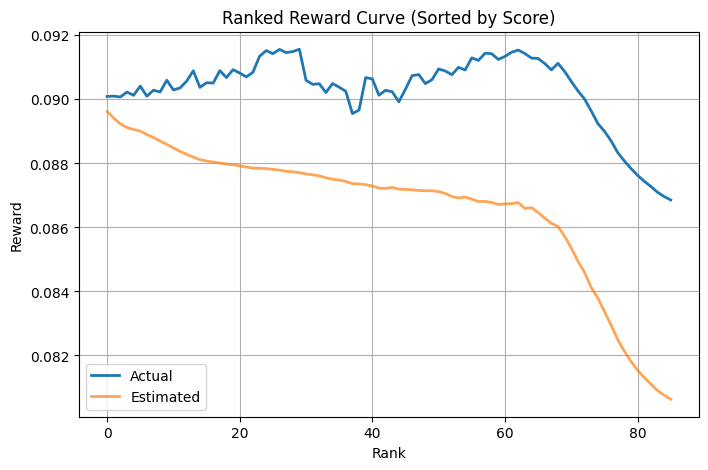

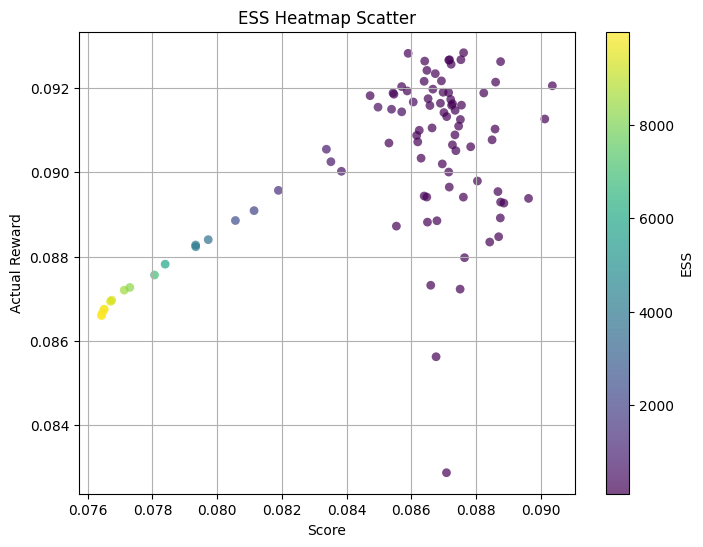

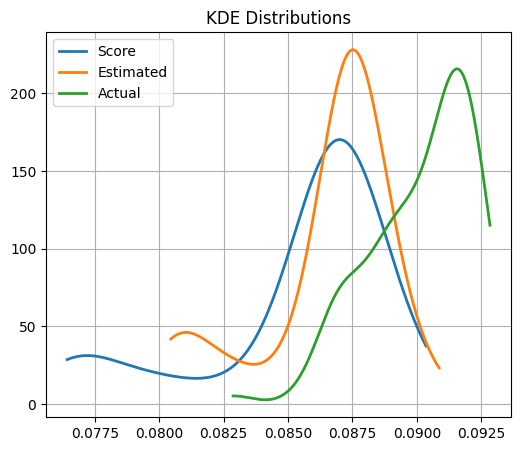

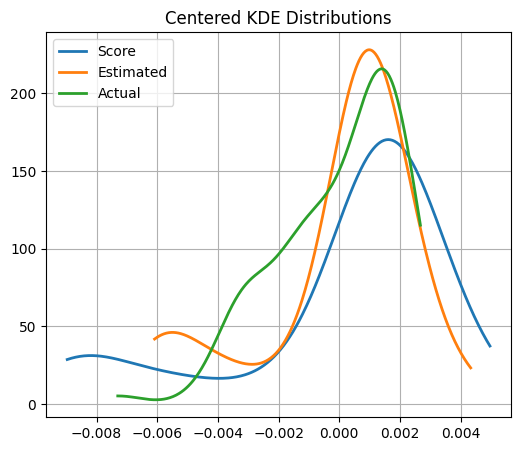

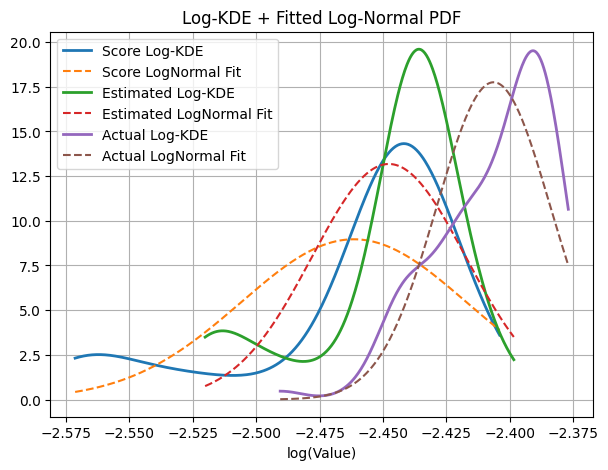

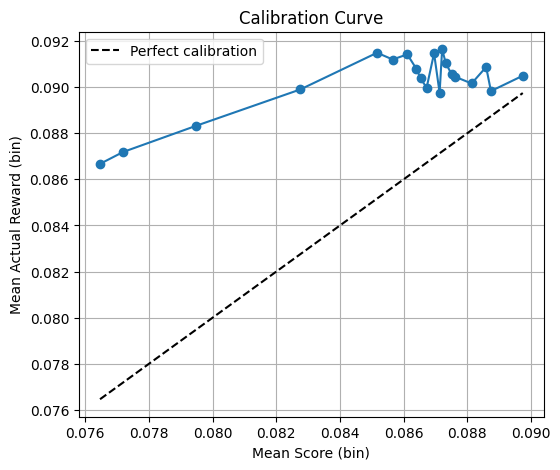

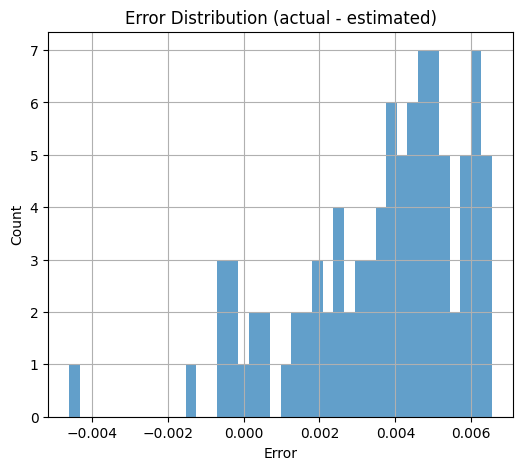

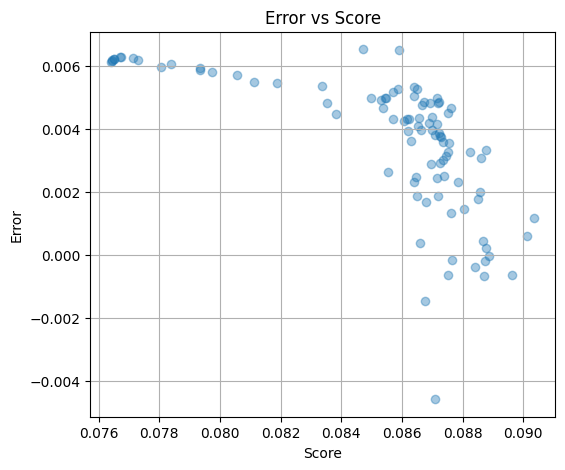

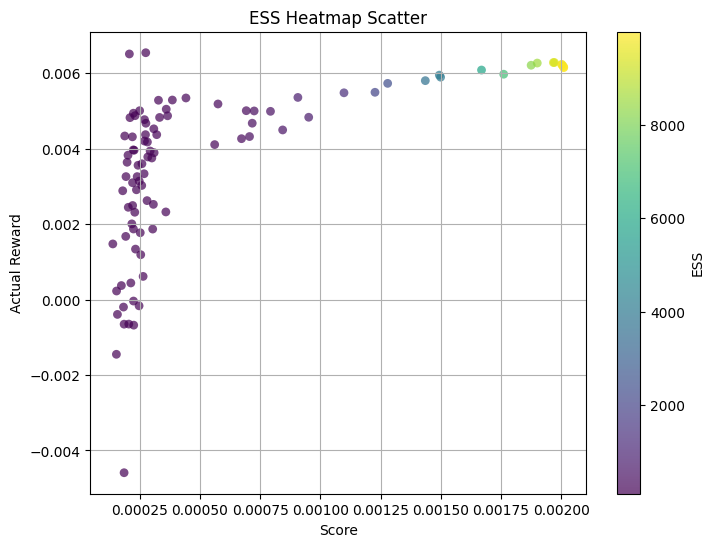

Correlation Metrics: {'pearson_score_actual': np.float64(0.5680752041943926), 'spearman_score_actual': np.float64(0.3207239099808547), 'spearman_est_actual': np.float64(0.3737672940071524)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9954936334534898), 'ndcg_est_actual': np.float64(0.995695008243699)}
Error Metrics: {'mean_error': np.float64(0.0036318871738972467), 'mae': np.float64(0.003819479042042338), 'rmse': np.float64(0.00423838593029386), 'std_error': np.float64(0.002184790802386723), 'max_error': np.float64(0.006544295304876421), 'min_error': np.float64(-0.004590178628562883)}


In [20]:
compute_statistics_and_plots(study_df7)

In [21]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=40000)

Random Item CTR: 0.07053370144999074
Optimal greedy CTR: 0.09999936716169436
Second Best greedy CTR: 0.09676800930842865
Optimal Stochastic CTR: 0.09995563088920843
second Best Stochastic CTR: 0.08606322612964991
Our Initial CTR: 0.08622184481781218


In [22]:
# Run the optimization
df8, study_df8 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df8.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{40000}.csv")
# Show the performance metrics
df8[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 10000 samples: 0.03883218765258789 seconds
[Regression] Baseline regression model fit time: 0.07s
Num samples is 10000
{'gini': np.float64(0.47027681726415027), 'ess': np.float64(4159.560074884791), 'max_wi': np.float64(33.29260423672067), 'min_wi': np.float64(0.013150994466271049)}
Eval time: 0.5298311710357666 seconds


[I 2025-12-14 23:57:55,716] A new study created in memory with name: no-name-459cd5ab-3f40-451b-9d87-a32d2c4c2af9


Evaluation total results time: 0.86 seconds

=== [Regression] Training size 15000, run 0 ===
Simulation time for 25000 samples: 0.05939459800720215 seconds


  0%|          | 0/155 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.08394637]
Validation weights_info: {'gini': np.float64(0.9972962206085075), 'ess': np.float64(10.520161000376905), 'max_wi': np.float64(2927.811403441547), 'min_wi': np.float64(0.0)}


Best trial: 0. Best value: -inf:   1%|          | 1/155 [00:03<09:07,  3.56s/it]

[I 2025-12-14 23:57:59,272] Trial 0 finished with value: -inf and parameters: {'lr': 0.096, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.85}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 1
actual reward: [0.08895452]
Validation weights_info: {'gini': np.float64(0.9947087689326063), 'ess': np.float64(12.558358558501494), 'max_wi': np.float64(1958.0272275411744), 'min_wi': np.float64(1.5578401116456892e-18)}


Best trial: 0. Best value: -inf:   1%|▏         | 2/155 [00:07<09:55,  3.89s/it]

[I 2025-12-14 23:58:03,402] Trial 1 finished with value: -inf and parameters: {'lr': 0.028688906524762095, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8385310688150296}. Best is trial 0 with value: -inf.

[Regression] Optuna Trial 2
actual reward: [0.08737675]
Validation weights_info: {'gini': np.float64(0.6042816527960617), 'ess': np.float64(2310.0651198619325), 'max_wi': np.float64(26.555659993168156), 'min_wi': np.float64(0.012090255197064052)}


Best trial: 2. Best value: 0.0768436:   2%|▏         | 3/155 [00:10<08:22,  3.31s/it]

[I 2025-12-14 23:58:06,010] Trial 2 finished with value: 0.07684362890794792 and parameters: {'lr': 0.000860087893463208, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9727280924259493}. Best is trial 2 with value: 0.07684362890794792.

[Regression] Optuna Trial 3
actual reward: [0.08967656]
Validation weights_info: {'gini': np.float64(0.9561026158085957), 'ess': np.float64(373.68209328167967), 'max_wi': np.float64(98.78880576745627), 'min_wi': np.float64(1.218944224399065e-06)}


Best trial: 3. Best value: 0.0803538:   3%|▎         | 4/155 [00:12<07:19,  2.91s/it]

[I 2025-12-14 23:58:08,314] Trial 3 finished with value: 0.08035376811575602 and parameters: {'lr': 0.006986214006364565, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9998778303702908}. Best is trial 3 with value: 0.08035376811575602.

[Regression] Optuna Trial 4
actual reward: [0.08750405]
Validation weights_info: {'gini': np.float64(0.9917443041919882), 'ess': np.float64(41.77480055924796), 'max_wi': np.float64(457.60072943809735), 'min_wi': np.float64(5.84553728154452e-13)}


Best trial: 3. Best value: 0.0803538:   3%|▎         | 5/155 [00:15<07:15,  2.91s/it]

[I 2025-12-14 23:58:11,209] Trial 4 finished with value: -inf and parameters: {'lr': 0.028484416494909105, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.807669404460966}. Best is trial 3 with value: 0.08035376811575602.

[Regression] Optuna Trial 5
actual reward: [0.08961528]
Validation weights_info: {'gini': np.float64(0.9246242255708821), 'ess': np.float64(475.38586056735994), 'max_wi': np.float64(102.891864765453), 'min_wi': np.float64(3.709000346351569e-06)}


Best trial: 5. Best value: 0.0810874:   4%|▍         | 6/155 [00:19<08:30,  3.43s/it]

[I 2025-12-14 23:58:15,647] Trial 5 finished with value: 0.08108740937722508 and parameters: {'lr': 0.0016735101407640766, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9861820356297}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 6
actual reward: [0.08747551]
Validation weights_info: {'gini': np.float64(0.994564666331892), 'ess': np.float64(10.34314739707351), 'max_wi': np.float64(1700.1950409939368), 'min_wi': np.float64(2.4734375103254403e-20)}


Best trial: 5. Best value: 0.0810874:   5%|▍         | 7/155 [00:25<10:28,  4.25s/it]

[I 2025-12-14 23:58:21,580] Trial 6 finished with value: -inf and parameters: {'lr': 0.04072591024751388, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.8098393168099675}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 7
actual reward: [0.08758441]
Validation weights_info: {'gini': np.float64(0.9943930135497563), 'ess': np.float64(11.54531289972399), 'max_wi': np.float64(1893.732722345352), 'min_wi': np.float64(9.800782193122768e-13)}


Best trial: 5. Best value: 0.0810874:   5%|▌         | 8/155 [00:28<09:18,  3.80s/it]

[I 2025-12-14 23:58:24,428] Trial 7 finished with value: -inf and parameters: {'lr': 0.01652503866881365, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.8976521377525456}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 8
actual reward: [0.08632475]
Validation weights_info: {'gini': np.float64(0.9936804387129247), 'ess': np.float64(17.31597326118864), 'max_wi': np.float64(1082.467892243063), 'min_wi': np.float64(1.2652273866160592e-19)}


Best trial: 5. Best value: 0.0810874:   6%|▌         | 9/155 [00:32<09:16,  3.81s/it]

[I 2025-12-14 23:58:28,266] Trial 8 finished with value: -inf and parameters: {'lr': 0.03062510553650823, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.982575085255191}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 9
actual reward: [0.08725375]
Validation weights_info: {'gini': np.float64(0.6083376392434748), 'ess': np.float64(2211.9185176376404), 'max_wi': np.float64(27.088044628403242), 'min_wi': np.float64(0.011461400674607198)}


Best trial: 5. Best value: 0.0810874:   6%|▋         | 10/155 [00:34<07:35,  3.14s/it]

[I 2025-12-14 23:58:29,909] Trial 9 finished with value: 0.0766811555884269 and parameters: {'lr': 0.0028721129487459802, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.8695746759370195}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 10
actual reward: [0.08623579]
Validation weights_info: {'gini': np.float64(0.011541856465079155), 'ess': np.float64(9995.673469944093), 'max_wi': np.float64(1.0690419614670195), 'min_wi': np.float64(0.9475438571282117)}


Best trial: 5. Best value: 0.0810874:   7%|▋         | 11/155 [00:35<06:16,  2.62s/it]

[I 2025-12-14 23:58:31,328] Trial 10 finished with value: 0.07570380232833847 and parameters: {'lr': 0.0001134775775049755, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.9425164790771658}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 11
actual reward: [0.08800514]
Validation weights_info: {'gini': np.float64(0.871133429881343), 'ess': np.float64(692.2790500957814), 'max_wi': np.float64(47.356509680105546), 'min_wi': np.float64(0.00025479065580549115)}


Best trial: 5. Best value: 0.0810874:   8%|▊         | 12/155 [00:37<05:54,  2.48s/it]

[I 2025-12-14 23:58:33,489] Trial 11 finished with value: 0.07750680093096525 and parameters: {'lr': 0.0035677915113503608, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9417931887778668}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 12
actual reward: [0.08823543]
Validation weights_info: {'gini': np.float64(0.8875472661348628), 'ess': np.float64(619.7251265205203), 'max_wi': np.float64(48.900914102083924), 'min_wi': np.float64(0.00020819014092696234)}


Best trial: 5. Best value: 0.0810874:   8%|▊         | 13/155 [00:39<05:38,  2.38s/it]

[I 2025-12-14 23:58:35,656] Trial 12 finished with value: 0.07725472971774218 and parameters: {'lr': 0.003379583683313746, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9895792862646656}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 13
actual reward: [0.08655692]
Validation weights_info: {'gini': np.float64(0.23007192449315442), 'ess': np.float64(8305.780467719265), 'max_wi': np.float64(3.6595288912570374), 'min_wi': np.float64(0.29348619351007127)}


Best trial: 5. Best value: 0.0810874:   9%|▉         | 14/155 [00:42<05:27,  2.32s/it]

[I 2025-12-14 23:58:37,827] Trial 13 finished with value: 0.07633597574295699 and parameters: {'lr': 0.0006647160158690874, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9382016856547625}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 14
actual reward: [0.0896815]
Validation weights_info: {'gini': np.float64(0.9858963177852472), 'ess': np.float64(41.430387307974485), 'max_wi': np.float64(739.4702618170601), 'min_wi': np.float64(2.0880679614208072e-10)}


Best trial: 5. Best value: 0.0810874:  10%|▉         | 15/155 [00:46<06:56,  2.98s/it]

[I 2025-12-14 23:58:42,323] Trial 14 finished with value: -inf and parameters: {'lr': 0.006327641438572591, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.9969761413373945}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 15
actual reward: [0.08659572]
Validation weights_info: {'gini': np.float64(0.2504736141928201), 'ess': np.float64(8024.572647747371), 'max_wi': np.float64(3.9097738985210504), 'min_wi': np.float64(0.2571801520095843)}


Best trial: 5. Best value: 0.0810874:  10%|█         | 16/155 [00:48<06:13,  2.69s/it]

[I 2025-12-14 23:58:44,344] Trial 15 finished with value: 0.07637066607700412 and parameters: {'lr': 0.0007549654645455094, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9592114044088074}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 16
actual reward: [0.08799895]
Validation weights_info: {'gini': np.float64(0.9895444250699474), 'ess': np.float64(21.672955328914256), 'max_wi': np.float64(1511.77532598856), 'min_wi': np.float64(2.0799437420318286e-08)}


Best trial: 5. Best value: 0.0810874:  11%|█         | 17/155 [00:51<06:04,  2.64s/it]

[I 2025-12-14 23:58:46,883] Trial 16 finished with value: -inf and parameters: {'lr': 0.00918412837406342, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9064994012313438}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 17
actual reward: [0.08742917]
Validation weights_info: {'gini': np.float64(0.6858335914003854), 'ess': np.float64(1342.225518332973), 'max_wi': np.float64(36.70479623983125), 'min_wi': np.float64(0.00346696521642121)}


Best trial: 5. Best value: 0.0810874:  12%|█▏        | 18/155 [00:53<06:01,  2.64s/it]

[I 2025-12-14 23:58:49,503] Trial 17 finished with value: 0.07655769436982895 and parameters: {'lr': 0.001342690682759329, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.9154179265398776}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 18
actual reward: [0.08631809]
Validation weights_info: {'gini': np.float64(0.0738840888973228), 'ess': np.float64(9818.505385774182), 'max_wi': np.float64(1.532153881572993), 'min_wi': np.float64(0.7072355851597241)}


Best trial: 5. Best value: 0.0810874:  12%|█▏        | 19/155 [00:55<05:33,  2.46s/it]

[I 2025-12-14 23:58:51,537] Trial 18 finished with value: 0.07589185595369916 and parameters: {'lr': 0.00022229835850466566, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9640665332810767}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 19
actual reward: [0.08667436]
Validation weights_info: {'gini': np.float64(0.31820073413901356), 'ess': np.float64(6474.196514427187), 'max_wi': np.float64(8.321570602853429), 'min_wi': np.float64(0.13012662221844898)}


Best trial: 5. Best value: 0.0810874:  13%|█▎        | 20/155 [00:57<04:57,  2.21s/it]

[I 2025-12-14 23:58:53,163] Trial 19 finished with value: 0.07625345658899105 and parameters: {'lr': 0.0015817942370014873, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.9975500800954924}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 20
actual reward: [0.09186385]
Validation weights_info: {'gini': np.float64(0.9870074058480693), 'ess': np.float64(73.39559230733772), 'max_wi': np.float64(378.23646257992135), 'min_wi': np.float64(3.936905226984869e-12)}


Best trial: 5. Best value: 0.0810874:  14%|█▎        | 21/155 [01:02<07:05,  3.18s/it]

[I 2025-12-14 23:58:58,610] Trial 20 finished with value: -inf and parameters: {'lr': 0.009321375536863739, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.9268088841436142}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 21
actual reward: [0.08786028]
Validation weights_info: {'gini': np.float64(0.7948857390575701), 'ess': np.float64(870.5760869847902), 'max_wi': np.float64(43.12281613129422), 'min_wi': np.float64(0.0011535255499212696)}


Best trial: 5. Best value: 0.0810874:  14%|█▍        | 22/155 [01:05<06:22,  2.87s/it]

[I 2025-12-14 23:59:00,767] Trial 21 finished with value: 0.07719374943020808 and parameters: {'lr': 0.002630021681369122, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9554627329148215}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 22
actual reward: [0.08802585]
Validation weights_info: {'gini': np.float64(0.9426519249095539), 'ess': np.float64(446.99946023006464), 'max_wi': np.float64(60.56298480710814), 'min_wi': np.float64(2.4358875762427095e-05)}


Best trial: 5. Best value: 0.0810874:  15%|█▍        | 23/155 [01:07<05:53,  2.68s/it]

[I 2025-12-14 23:59:03,001] Trial 22 finished with value: 0.07781011661557702 and parameters: {'lr': 0.005125577922767667, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9784489671386977}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 23
actual reward: [0.08909258]
Validation weights_info: {'gini': np.float64(0.9540980093631029), 'ess': np.float64(391.236492903141), 'max_wi': np.float64(59.626473302850265), 'min_wi': np.float64(4.134020389910294e-06)}


Best trial: 5. Best value: 0.0810874:  15%|█▌        | 24/155 [01:09<05:38,  2.58s/it]

[I 2025-12-14 23:59:05,347] Trial 23 finished with value: 0.0799136673074496 and parameters: {'lr': 0.006611793143596382, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9756594856153494}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 24
actual reward: [0.08662853]
Validation weights_info: {'gini': np.float64(0.9885797466597585), 'ess': np.float64(36.03624779159582), 'max_wi': np.float64(714.5216299426191), 'min_wi': np.float64(5.361894266369281e-08)}


Best trial: 5. Best value: 0.0810874:  16%|█▌        | 25/155 [01:11<05:09,  2.38s/it]

[I 2025-12-14 23:59:07,256] Trial 24 finished with value: -inf and parameters: {'lr': 0.013832369699926437, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.9989587674752031}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 25
actual reward: [0.08642062]
Validation weights_info: {'gini': np.float64(0.14570611400369754), 'ess': np.float64(9300.13884355653), 'max_wi': np.float64(2.265834233878683), 'min_wi': np.float64(0.4850099002407009)}


Best trial: 5. Best value: 0.0810874:  17%|█▋        | 26/155 [01:13<04:59,  2.32s/it]

[I 2025-12-14 23:59:09,447] Trial 25 finished with value: 0.0760853359466685 and parameters: {'lr': 0.00033955845281821354, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9710506443846382}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 26
actual reward: [0.08726994]
Validation weights_info: {'gini': np.float64(0.6042979635216852), 'ess': np.float64(2245.577885741456), 'max_wi': np.float64(27.116985243197533), 'min_wi': np.float64(0.010860693567038586)}


Best trial: 5. Best value: 0.0810874:  17%|█▋        | 27/155 [01:15<04:45,  2.23s/it]

[I 2025-12-14 23:59:11,470] Trial 26 finished with value: 0.07647875752740334 and parameters: {'lr': 0.0016314769520153996, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8897700308674722}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 27
actual reward: [0.08869084]
Validation weights_info: {'gini': np.float64(0.9891131679468393), 'ess': np.float64(16.070785475213498), 'max_wi': np.float64(1567.3712691474302), 'min_wi': np.float64(2.88985944309575e-09)}


Best trial: 5. Best value: 0.0810874:  18%|█▊        | 28/155 [01:19<05:22,  2.54s/it]

[I 2025-12-14 23:59:14,734] Trial 27 finished with value: -inf and parameters: {'lr': 0.0065008913555066345, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.9539648472506771}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 28
actual reward: [0.08676495]
Validation weights_info: {'gini': np.float64(0.9956230952150127), 'ess': np.float64(13.68797532092716), 'max_wi': np.float64(1413.5447486216242), 'min_wi': np.float64(1.082490225824163e-09)}


Best trial: 5. Best value: 0.0810874:  19%|█▊        | 29/155 [01:21<05:12,  2.48s/it]

[I 2025-12-14 23:59:17,073] Trial 28 finished with value: -inf and parameters: {'lr': 0.015968178943783582, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.9822252156513841}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 29
actual reward: [0.08801265]
Validation weights_info: {'gini': np.float64(0.987078326142276), 'ess': np.float64(29.10589329891076), 'max_wi': np.float64(1703.4929428089504), 'min_wi': np.float64(2.181366630800375e-29)}


Best trial: 5. Best value: 0.0810874:  19%|█▉        | 30/155 [01:24<05:46,  2.77s/it]

[I 2025-12-14 23:59:20,522] Trial 29 finished with value: -inf and parameters: {'lr': 0.05077050458533247, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.9238336632605793}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 30
actual reward: [0.08603165]
Validation weights_info: {'gini': np.float64(0.9923445414875168), 'ess': np.float64(11.454318505200717), 'max_wi': np.float64(2703.3916142780618), 'min_wi': np.float64(2.3225994473535845e-38)}


Best trial: 5. Best value: 0.0810874:  20%|██        | 31/155 [01:27<05:49,  2.82s/it]

[I 2025-12-14 23:59:23,449] Trial 30 finished with value: -inf and parameters: {'lr': 0.06535133434188796, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.8752737971269943}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 31
actual reward: [0.08908382]
Validation weights_info: {'gini': np.float64(0.935978524226384), 'ess': np.float64(488.1962522594138), 'max_wi': np.float64(51.23879144207288), 'min_wi': np.float64(2.9360284941042593e-05)}


Best trial: 5. Best value: 0.0810874:  21%|██        | 32/155 [01:29<05:20,  2.61s/it]

[I 2025-12-14 23:59:25,557] Trial 31 finished with value: 0.07834488019495299 and parameters: {'lr': 0.004857074475945216, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.983456656098213}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 32
actual reward: [0.08898684]
Validation weights_info: {'gini': np.float64(0.9454469273128462), 'ess': np.float64(445.03890127546674), 'max_wi': np.float64(57.398720074839105), 'min_wi': np.float64(9.272208514016616e-06)}


Best trial: 5. Best value: 0.0810874:  21%|██▏       | 33/155 [01:32<05:06,  2.52s/it]

[I 2025-12-14 23:59:27,862] Trial 32 finished with value: 0.07902418066648621 and parameters: {'lr': 0.005111415912551321, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9831170074056289}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 33
actual reward: [0.08670486]
Validation weights_info: {'gini': np.float64(0.9875566893506841), 'ess': np.float64(24.383600259307045), 'max_wi': np.float64(1009.0740845151643), 'min_wi': np.float64(1.0549877575299301e-07)}


Best trial: 5. Best value: 0.0810874:  22%|██▏       | 34/155 [01:34<05:03,  2.51s/it]

[I 2025-12-14 23:59:30,367] Trial 33 finished with value: -inf and parameters: {'lr': 0.009861827643138513, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9676033375830654}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 34
actual reward: [0.08794099]
Validation weights_info: {'gini': np.float64(0.8447271880378029), 'ess': np.float64(717.2097587471145), 'max_wi': np.float64(45.25059878986964), 'min_wi': np.float64(0.0005807015523384754)}


Best trial: 5. Best value: 0.0810874:  23%|██▎       | 35/155 [01:37<04:56,  2.47s/it]

[I 2025-12-14 23:59:32,741] Trial 34 finished with value: 0.0770218086807439 and parameters: {'lr': 0.0021722778417879274, 'num_epochs': 10, 'batch_size': 512, 'lr_decay': 0.9899495406665448}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 35
actual reward: [0.08674502]
Validation weights_info: {'gini': np.float64(0.3324178555041964), 'ess': np.float64(6736.786411527339), 'max_wi': np.float64(6.490321809408088), 'min_wi': np.float64(0.1509307148726226)}


Best trial: 5. Best value: 0.0810874:  23%|██▎       | 36/155 [01:38<04:35,  2.31s/it]

[I 2025-12-14 23:59:34,684] Trial 35 finished with value: 0.07657088891622545 and parameters: {'lr': 0.0011112382307020986, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.9737888323910623}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 36
actual reward: [0.09140709]
Validation weights_info: {'gini': np.float64(0.9922530951898223), 'ess': np.float64(7.266403013855573), 'max_wi': np.float64(4140.140949505681), 'min_wi': np.float64(1.2021623346347108e-18)}


Best trial: 5. Best value: 0.0810874:  24%|██▍       | 37/155 [01:43<05:41,  2.89s/it]

[I 2025-12-14 23:59:38,938] Trial 36 finished with value: -inf and parameters: {'lr': 0.02139469893613251, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9550230311568811}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 37
actual reward: [0.08944334]
Validation weights_info: {'gini': np.float64(0.9289711996528116), 'ess': np.float64(531.7383357627341), 'max_wi': np.float64(50.10260303293714), 'min_wi': np.float64(1.7988821010815852e-05)}


Best trial: 5. Best value: 0.0810874:  25%|██▍       | 38/155 [01:45<05:34,  2.86s/it]

[I 2025-12-14 23:59:41,705] Trial 37 finished with value: 0.07907713692414475 and parameters: {'lr': 0.004464192826000356, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8415458041260606}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 38
actual reward: [0.08756089]
Validation weights_info: {'gini': np.float64(0.9896848559215456), 'ess': np.float64(26.661238160258645), 'max_wi': np.float64(1075.0420806200725), 'min_wi': np.float64(3.211575269321452e-08)}


Best trial: 5. Best value: 0.0810874:  25%|██▌       | 39/155 [01:48<05:12,  2.69s/it]

[I 2025-12-14 23:59:44,015] Trial 38 finished with value: -inf and parameters: {'lr': 0.011614620704975926, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8239478989997694}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 39
actual reward: [0.08656534]
Validation weights_info: {'gini': np.float64(0.24003891888135087), 'ess': np.float64(8151.498715758756), 'max_wi': np.float64(3.9466386036979033), 'min_wi': np.float64(0.25950114009811975)}


Best trial: 5. Best value: 0.0810874:  26%|██▌       | 40/155 [01:51<05:12,  2.71s/it]

[I 2025-12-14 23:59:46,782] Trial 39 finished with value: 0.07634137821818593 and parameters: {'lr': 0.000534667336816978, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8465161670434418}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 40
actual reward: [0.08925757]
Validation weights_info: {'gini': np.float64(0.9201295892589477), 'ess': np.float64(571.166721270047), 'max_wi': np.float64(50.18347349771829), 'min_wi': np.float64(2.9886149639703533e-05)}


Best trial: 5. Best value: 0.0810874:  26%|██▋       | 41/155 [01:53<05:06,  2.69s/it]

[I 2025-12-14 23:59:49,404] Trial 40 finished with value: 0.07861659486021139 and parameters: {'lr': 0.004002634210580719, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8645671146365012}. Best is trial 5 with value: 0.08108740937722508.

[Regression] Optuna Trial 41
actual reward: [0.08932821]
Validation weights_info: {'gini': np.float64(0.9626543365005404), 'ess': np.float64(207.67092502296487), 'max_wi': np.float64(209.92412121324017), 'min_wi': np.float64(1.239913835420078e-06)}


Best trial: 41. Best value: 0.0827901:  27%|██▋       | 42/155 [01:56<05:08,  2.73s/it]

[I 2025-12-14 23:59:52,239] Trial 41 finished with value: 0.08279014044803412 and parameters: {'lr': 0.006835062379207422, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8334075623773095}. Best is trial 41 with value: 0.08279014044803412.

[Regression] Optuna Trial 42
actual reward: [0.08770171]
Validation weights_info: {'gini': np.float64(0.782432344566165), 'ess': np.float64(897.1109215337378), 'max_wi': np.float64(41.4293516049992), 'min_wi': np.float64(0.0009706496048333401)}


Best trial: 41. Best value: 0.0827901:  28%|██▊       | 43/155 [01:59<05:09,  2.77s/it]

[I 2025-12-14 23:59:55,091] Trial 42 finished with value: 0.07679705424423088 and parameters: {'lr': 0.002168858643347767, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8313408088147534}. Best is trial 41 with value: 0.08279014044803412.

[Regression] Optuna Trial 43
actual reward: [0.08948312]
Validation weights_info: {'gini': np.float64(0.9572392933083252), 'ess': np.float64(257.406200273021), 'max_wi': np.float64(272.1743186858289), 'min_wi': np.float64(3.1808248621246336e-06)}


Best trial: 41. Best value: 0.0827901:  28%|██▊       | 44/155 [02:01<04:59,  2.70s/it]

[I 2025-12-14 23:59:57,640] Trial 43 finished with value: 0.08173181175263677 and parameters: {'lr': 0.007082751853087491, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.818242248065434}. Best is trial 41 with value: 0.08279014044803412.

[Regression] Optuna Trial 44
actual reward: [0.08915597]
Validation weights_info: {'gini': np.float64(0.9493482582432557), 'ess': np.float64(374.7572514076343), 'max_wi': np.float64(137.99110530481357), 'min_wi': np.float64(7.363901194140067e-06)}


Best trial: 41. Best value: 0.0827901:  29%|██▉       | 45/155 [02:04<04:50,  2.64s/it]

[I 2025-12-15 00:00:00,124] Trial 44 finished with value: 0.08073126121846937 and parameters: {'lr': 0.007183692417002051, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8033025885203303}. Best is trial 41 with value: 0.08279014044803412.

[Regression] Optuna Trial 45
actual reward: [0.08769804]
Validation weights_info: {'gini': np.float64(0.9968560183033276), 'ess': np.float64(13.769971062693765), 'max_wi': np.float64(1352.9760746385766), 'min_wi': np.float64(2.9800652541829483e-09)}


Best trial: 41. Best value: 0.0827901:  30%|██▉       | 46/155 [02:06<04:37,  2.55s/it]

[I 2025-12-15 00:00:02,462] Trial 45 finished with value: -inf and parameters: {'lr': 0.021520249354557725, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8077329062864211}. Best is trial 41 with value: 0.08279014044803412.

[Regression] Optuna Trial 46
actual reward: [0.0897687]
Validation weights_info: {'gini': np.float64(0.9546236474256233), 'ess': np.float64(324.05576736758155), 'max_wi': np.float64(172.10009064397005), 'min_wi': np.float64(2.4327650394472048e-06)}


Best trial: 41. Best value: 0.0827901:  30%|███       | 47/155 [02:09<04:25,  2.46s/it]

[I 2025-12-15 00:00:04,727] Trial 46 finished with value: 0.081333711891915 and parameters: {'lr': 0.007620668972334713, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8209071343615061}. Best is trial 41 with value: 0.08279014044803412.

[Regression] Optuna Trial 47
actual reward: [0.08936281]
Validation weights_info: {'gini': np.float64(0.9659924202406995), 'ess': np.float64(193.43159587244006), 'max_wi': np.float64(296.43203287481884), 'min_wi': np.float64(7.519353396311216e-07)}


Best trial: 41. Best value: 0.0827901:  31%|███       | 48/155 [02:11<04:20,  2.43s/it]

[I 2025-12-15 00:00:07,096] Trial 47 finished with value: 0.08253767150184133 and parameters: {'lr': 0.008750969917836738, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8213516750817935}. Best is trial 41 with value: 0.08279014044803412.

[Regression] Optuna Trial 48
actual reward: [0.08219967]
Validation weights_info: {'gini': np.float64(0.9967221368142414), 'ess': np.float64(7.733897592550529), 'max_wi': np.float64(1383.3974278857656), 'min_wi': np.float64(2.4456616648694992e-11)}


Best trial: 41. Best value: 0.0827901:  32%|███▏      | 49/155 [02:13<04:09,  2.36s/it]

[I 2025-12-15 00:00:09,268] Trial 48 finished with value: -inf and parameters: {'lr': 0.024723508957913923, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8227268361853401}. Best is trial 41 with value: 0.08279014044803412.

[Regression] Optuna Trial 49
actual reward: [0.08775976]
Validation weights_info: {'gini': np.float64(0.8059540753072869), 'ess': np.float64(798.4218859985864), 'max_wi': np.float64(43.85544511328197), 'min_wi': np.float64(0.0007475583473175238)}


Best trial: 41. Best value: 0.0827901:  32%|███▏      | 50/155 [02:15<03:56,  2.25s/it]

[I 2025-12-15 00:00:11,268] Trial 49 finished with value: 0.07697883544889132 and parameters: {'lr': 0.0027156363591269756, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8570111857865914}. Best is trial 41 with value: 0.08279014044803412.

[Regression] Optuna Trial 50
actual reward: [0.08462729]
Validation weights_info: {'gini': np.float64(0.9967635994198147), 'ess': np.float64(14.505521285024379), 'max_wi': np.float64(1258.9953271736201), 'min_wi': np.float64(2.1218316887583243e-10)}


Best trial: 41. Best value: 0.0827901:  33%|███▎      | 51/155 [02:17<03:40,  2.12s/it]

[I 2025-12-15 00:00:13,092] Trial 50 finished with value: -inf and parameters: {'lr': 0.03261999522521353, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8169332384192068}. Best is trial 41 with value: 0.08279014044803412.

[Regression] Optuna Trial 51
actual reward: [0.08868862]
Validation weights_info: {'gini': np.float64(0.9768423714614319), 'ess': np.float64(105.20703939196115), 'max_wi': np.float64(328.987384699109), 'min_wi': np.float64(9.119526833313166e-08)}


Best trial: 51. Best value: 0.0845916:  34%|███▎      | 52/155 [02:19<03:38,  2.12s/it]

[I 2025-12-15 00:00:15,202] Trial 51 finished with value: 0.0845915664612971 and parameters: {'lr': 0.01130601997507025, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8009925029133633}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 52
actual reward: [0.08718978]
Validation weights_info: {'gini': np.float64(0.9927610333591899), 'ess': np.float64(30.14120615074665), 'max_wi': np.float64(677.0871904783986), 'min_wi': np.float64(5.090310651857187e-08)}


Best trial: 51. Best value: 0.0845916:  34%|███▍      | 53/155 [02:21<03:40,  2.16s/it]

[I 2025-12-15 00:00:17,456] Trial 52 finished with value: -inf and parameters: {'lr': 0.012876360949348891, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8346586742829362}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 53
actual reward: [0.0880587]
Validation weights_info: {'gini': np.float64(0.9755261980886792), 'ess': np.float64(89.84312258323348), 'max_wi': np.float64(560.2582913423809), 'min_wi': np.float64(3.463685062094911e-07)}


Best trial: 51. Best value: 0.0845916:  35%|███▍      | 54/155 [02:23<03:34,  2.13s/it]

[I 2025-12-15 00:00:19,509] Trial 53 finished with value: -inf and parameters: {'lr': 0.011153209313067123, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8130944780276435}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 54
actual reward: [0.08930404]
Validation weights_info: {'gini': np.float64(0.9442084721119886), 'ess': np.float64(434.6635453973539), 'max_wi': np.float64(88.70983343796776), 'min_wi': np.float64(6.558653145760438e-06)}


Best trial: 51. Best value: 0.0845916:  35%|███▌      | 55/155 [02:25<03:23,  2.04s/it]

[I 2025-12-15 00:00:21,329] Trial 54 finished with value: 0.08031866570981466 and parameters: {'lr': 0.008023311498561806, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8227712494114162}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 55
actual reward: [0.08847495]
Validation weights_info: {'gini': np.float64(0.9905345685766809), 'ess': np.float64(29.124508486439964), 'max_wi': np.float64(1118.5042760541417), 'min_wi': np.float64(5.603943204384397e-11)}


Best trial: 51. Best value: 0.0845916:  36%|███▌      | 56/155 [02:28<03:47,  2.30s/it]

[I 2025-12-15 00:00:24,246] Trial 55 finished with value: -inf and parameters: {'lr': 0.015447436157343402, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8006185045644647}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 56
actual reward: [0.08815432]
Validation weights_info: {'gini': np.float64(0.9935827767054731), 'ess': np.float64(26.358316880654193), 'max_wi': np.float64(717.2397020492346), 'min_wi': np.float64(7.844830373660428e-09)}


Best trial: 51. Best value: 0.0845916:  37%|███▋      | 57/155 [02:30<03:38,  2.23s/it]

[I 2025-12-15 00:00:26,308] Trial 56 finished with value: -inf and parameters: {'lr': 0.01791486671949806, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8301933777514662}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 57
actual reward: [0.08905064]
Validation weights_info: {'gini': np.float64(0.9334387698809478), 'ess': np.float64(518.9451520837478), 'max_wi': np.float64(50.46983567215385), 'min_wi': np.float64(1.2604347890088627e-05)}


Best trial: 51. Best value: 0.0845916:  37%|███▋      | 58/155 [02:33<03:42,  2.30s/it]

[I 2025-12-15 00:00:28,763] Trial 57 finished with value: 0.0788863338360476 and parameters: {'lr': 0.0060110969521659, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8153155524498946}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 58
actual reward: [0.0887044]
Validation weights_info: {'gini': np.float64(0.9102108864610945), 'ess': np.float64(594.8389448771122), 'max_wi': np.float64(49.146729531155536), 'min_wi': np.float64(6.272922117624724e-05)}


Best trial: 51. Best value: 0.0845916:  38%|███▊      | 59/155 [02:35<03:42,  2.32s/it]

[I 2025-12-15 00:00:31,138] Trial 58 finished with value: 0.07819762662926989 and parameters: {'lr': 0.0037914241027404666, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8529685566335072}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 59
actual reward: [0.08755408]
Validation weights_info: {'gini': np.float64(0.975417543933598), 'ess': np.float64(37.001909435833944), 'max_wi': np.float64(1152.0338034949527), 'min_wi': np.float64(4.729414994430295e-08)}


Best trial: 51. Best value: 0.0845916:  39%|███▊      | 60/155 [02:38<03:50,  2.43s/it]

[I 2025-12-15 00:00:33,810] Trial 59 finished with value: -inf and parameters: {'lr': 0.008327519705759503, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.8415613750368711}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 60
actual reward: [0.08790635]
Validation weights_info: {'gini': np.float64(0.8534705732188717), 'ess': np.float64(704.1658901300384), 'max_wi': np.float64(47.034798558829564), 'min_wi': np.float64(0.00023902781951940226)}


Best trial: 51. Best value: 0.0845916:  39%|███▉      | 61/155 [02:40<03:43,  2.38s/it]

[I 2025-12-15 00:00:36,073] Trial 60 finished with value: 0.0768494250776426 and parameters: {'lr': 0.00321184857848212, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.827283766706258}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 61
actual reward: [0.08972463]
Validation weights_info: {'gini': np.float64(0.9591116951917519), 'ess': np.float64(261.3874883987492), 'max_wi': np.float64(198.9067175765352), 'min_wi': np.float64(2.234587117590657e-06)}


Best trial: 51. Best value: 0.0845916:  40%|████      | 62/155 [02:42<03:43,  2.40s/it]

[I 2025-12-15 00:00:38,536] Trial 61 finished with value: 0.08195892865584 and parameters: {'lr': 0.007597281860277256, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8017077582440986}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 62
actual reward: [0.08908385]
Validation weights_info: {'gini': np.float64(0.9705912619366205), 'ess': np.float64(166.8197344257299), 'max_wi': np.float64(253.0903763859742), 'min_wi': np.float64(1.2891813873445876e-06)}


Best trial: 51. Best value: 0.0845916:  41%|████      | 63/155 [02:45<03:45,  2.45s/it]

[I 2025-12-15 00:00:41,105] Trial 62 finished with value: 0.08328992819553627 and parameters: {'lr': 0.009614035603747564, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8055789616512797}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 63
actual reward: [0.0884233]
Validation weights_info: {'gini': np.float64(0.9756606776942109), 'ess': np.float64(115.64758788730725), 'max_wi': np.float64(353.13192209156426), 'min_wi': np.float64(3.829224097127105e-07)}


Best trial: 51. Best value: 0.0845916:  41%|████▏     | 64/155 [02:48<03:48,  2.51s/it]

[I 2025-12-15 00:00:43,745] Trial 63 finished with value: 0.084380428085477 and parameters: {'lr': 0.010193882253663468, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8068379408903162}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 64
actual reward: [0.08754275]
Validation weights_info: {'gini': np.float64(0.9870167930540146), 'ess': np.float64(31.130850754188415), 'max_wi': np.float64(1269.2884408972097), 'min_wi': np.float64(1.9323590080659062e-07)}


Best trial: 51. Best value: 0.0845916:  42%|████▏     | 65/155 [02:50<03:44,  2.50s/it]

[I 2025-12-15 00:00:46,212] Trial 64 finished with value: -inf and parameters: {'lr': 0.010813923795901566, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8078720191471012}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 65
actual reward: [0.08768656]
Validation weights_info: {'gini': np.float64(0.9966388015251387), 'ess': np.float64(14.02945871754858), 'max_wi': np.float64(1242.6218533689423), 'min_wi': np.float64(2.3219648070106762e-09)}


Best trial: 51. Best value: 0.0845916:  43%|████▎     | 66/155 [02:52<03:37,  2.44s/it]

[I 2025-12-15 00:00:48,516] Trial 65 finished with value: -inf and parameters: {'lr': 0.018233284955625123, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8002316652922093}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 66
actual reward: [0.08722782]
Validation weights_info: {'gini': np.float64(0.989213979552744), 'ess': np.float64(38.61095448742641), 'max_wi': np.float64(765.1596101302812), 'min_wi': np.float64(4.749831468735704e-08)}


Best trial: 51. Best value: 0.0845916:  43%|████▎     | 67/155 [02:55<03:38,  2.49s/it]

[I 2025-12-15 00:00:51,122] Trial 66 finished with value: -inf and parameters: {'lr': 0.013213830973715698, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8100289715766061}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 67
actual reward: [0.08888047]
Validation weights_info: {'gini': np.float64(0.936678298278732), 'ess': np.float64(506.91193346262065), 'max_wi': np.float64(58.96429985863573), 'min_wi': np.float64(1.642833814741062e-05)}


Best trial: 51. Best value: 0.0845916:  44%|████▍     | 68/155 [02:57<03:34,  2.47s/it]

[I 2025-12-15 00:00:53,548] Trial 67 finished with value: 0.07949854257059258 and parameters: {'lr': 0.005857312256205804, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8163205432600267}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 68
actual reward: [0.08656728]
Validation weights_info: {'gini': np.float64(0.997986042773279), 'ess': np.float64(10.804152358869853), 'max_wi': np.float64(1987.6097625254338), 'min_wi': np.float64(1.868773641005207e-12)}


Best trial: 51. Best value: 0.0845916:  45%|████▍     | 69/155 [03:00<03:35,  2.51s/it]

[I 2025-12-15 00:00:56,144] Trial 68 finished with value: -inf and parameters: {'lr': 0.036276443020166964, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8050828698322186}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 69
actual reward: [0.08789933]
Validation weights_info: {'gini': np.float64(0.9903992305805158), 'ess': np.float64(28.08311952586712), 'max_wi': np.float64(947.0731786208733), 'min_wi': np.float64(6.100550980134097e-10)}


Best trial: 51. Best value: 0.0845916:  45%|████▌     | 70/155 [03:03<03:49,  2.70s/it]

[I 2025-12-15 00:00:59,296] Trial 69 finished with value: -inf and parameters: {'lr': 0.008661381165124875, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.836005404005305}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 70
actual reward: [0.08901653]
Validation weights_info: {'gini': np.float64(0.9950792993079546), 'ess': np.float64(19.138497333706113), 'max_wi': np.float64(946.9422319618776), 'min_wi': np.float64(9.240458719724869e-11)}


Best trial: 51. Best value: 0.0845916:  46%|████▌     | 71/155 [03:06<03:44,  2.67s/it]

[I 2025-12-15 00:01:01,884] Trial 70 finished with value: -inf and parameters: {'lr': 0.026635343496742316, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.8105743149914567}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 71
actual reward: [0.08946252]
Validation weights_info: {'gini': np.float64(0.9513867987113128), 'ess': np.float64(389.70741708216593), 'max_wi': np.float64(111.14340155937228), 'min_wi': np.float64(6.70010676919068e-06)}


Best trial: 51. Best value: 0.0845916:  46%|████▋     | 72/155 [03:08<03:30,  2.54s/it]

[I 2025-12-15 00:01:04,111] Trial 71 finished with value: 0.08046589073089029 and parameters: {'lr': 0.007411803751868926, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.818880763146291}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 72
actual reward: [0.08878847]
Validation weights_info: {'gini': np.float64(0.9808708497787494), 'ess': np.float64(62.6836125249483), 'max_wi': np.float64(681.6532234428372), 'min_wi': np.float64(1.0036033383404507e-07)}


Best trial: 51. Best value: 0.0845916:  47%|████▋     | 73/155 [03:10<03:20,  2.45s/it]

[I 2025-12-15 00:01:06,353] Trial 72 finished with value: -inf and parameters: {'lr': 0.01024493480507332, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8214486000215315}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 73
actual reward: [0.08900363]
Validation weights_info: {'gini': np.float64(0.929239888565737), 'ess': np.float64(538.0036279487656), 'max_wi': np.float64(51.4232363726309), 'min_wi': np.float64(2.6094387133243907e-05)}


Best trial: 51. Best value: 0.0845916:  48%|████▊     | 74/155 [03:12<03:11,  2.36s/it]

[I 2025-12-15 00:01:08,510] Trial 73 finished with value: 0.07890430070749772 and parameters: {'lr': 0.005586473682256978, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8125770172363959}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 74
actual reward: [0.087291]
Validation weights_info: {'gini': np.float64(0.9900112276245475), 'ess': np.float64(34.87774599497243), 'max_wi': np.float64(699.726419271389), 'min_wi': np.float64(3.5893932321047565e-08)}


Best trial: 51. Best value: 0.0845916:  48%|████▊     | 75/155 [03:15<03:07,  2.35s/it]

[I 2025-12-15 00:01:10,822] Trial 74 finished with value: -inf and parameters: {'lr': 0.01371594024436987, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8277093888706744}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 75
actual reward: [0.08817069]
Validation weights_info: {'gini': np.float64(0.9083253251359318), 'ess': np.float64(608.77150772096), 'max_wi': np.float64(49.0741487209309), 'min_wi': np.float64(6.350678599788197e-05)}


Best trial: 51. Best value: 0.0845916:  49%|████▉     | 76/155 [03:17<03:05,  2.35s/it]

[I 2025-12-15 00:01:13,186] Trial 75 finished with value: 0.07793697469527489 and parameters: {'lr': 0.004482952103287831, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8057575737965236}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 76
actual reward: [0.08937402]
Validation weights_info: {'gini': np.float64(0.9568243583192402), 'ess': np.float64(320.1449148577666), 'max_wi': np.float64(181.97060854886317), 'min_wi': np.float64(1.7636244168975496e-06)}


Best trial: 51. Best value: 0.0845916:  50%|████▉     | 77/155 [03:19<03:03,  2.35s/it]

[I 2025-12-15 00:01:15,539] Trial 76 finished with value: 0.08128462479549625 and parameters: {'lr': 0.007521510561095421, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.80021282053403}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 77
actual reward: [0.08913668]
Validation weights_info: {'gini': np.float64(0.9747659057495253), 'ess': np.float64(126.47097079517908), 'max_wi': np.float64(302.7502307553452), 'min_wi': np.float64(5.319491668763989e-07)}


Best trial: 51. Best value: 0.0845916:  50%|█████     | 78/155 [03:22<02:58,  2.32s/it]

[I 2025-12-15 00:01:17,780] Trial 77 finished with value: 0.08434218535235742 and parameters: {'lr': 0.009422944088673038, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8467326456205614}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 78
actual reward: [0.0879297]
Validation weights_info: {'gini': np.float64(0.9804928303923637), 'ess': np.float64(68.71635404182557), 'max_wi': np.float64(599.4751806299676), 'min_wi': np.float64(2.246326650668467e-07)}


Best trial: 51. Best value: 0.0845916:  51%|█████     | 79/155 [03:24<02:48,  2.22s/it]

[I 2025-12-15 00:01:19,778] Trial 78 finished with value: -inf and parameters: {'lr': 0.009425886312055749, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8856607835600596}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 79
actual reward: [0.09079567]
Validation weights_info: {'gini': np.float64(0.993364276115958), 'ess': np.float64(14.8550480190578), 'max_wi': np.float64(1677.3839711726591), 'min_wi': np.float64(3.6183747118189363e-12)}


Best trial: 51. Best value: 0.0845916:  52%|█████▏    | 80/155 [03:27<03:10,  2.54s/it]

[I 2025-12-15 00:01:23,070] Trial 79 finished with value: -inf and parameters: {'lr': 0.0195219241149726, 'num_epochs': 8, 'batch_size': 128, 'lr_decay': 0.8446096367295224}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 80
actual reward: [0.08742584]
Validation weights_info: {'gini': np.float64(0.9935825724378708), 'ess': np.float64(12.103882072637484), 'max_wi': np.float64(2256.344028022235), 'min_wi': np.float64(3.485331592822609e-08)}


Best trial: 51. Best value: 0.0845916:  52%|█████▏    | 81/155 [03:29<02:59,  2.43s/it]

[I 2025-12-15 00:01:25,237] Trial 80 finished with value: -inf and parameters: {'lr': 0.015325982789420448, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8348108885186232}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 81
actual reward: [0.08913653]
Validation weights_info: {'gini': np.float64(0.942830538869315), 'ess': np.float64(453.67167726534785), 'max_wi': np.float64(77.87927939467635), 'min_wi': np.float64(1.0708361764331178e-05)}


Best trial: 51. Best value: 0.0845916:  53%|█████▎    | 82/155 [03:31<02:54,  2.39s/it]

[I 2025-12-15 00:01:27,544] Trial 81 finished with value: 0.07918998806255022 and parameters: {'lr': 0.006431333889738567, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8199102720781474}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 82
actual reward: [0.08913626]
Validation weights_info: {'gini': np.float64(0.970306900040373), 'ess': np.float64(161.86465048071926), 'max_wi': np.float64(221.72304517849332), 'min_wi': np.float64(7.410704677469239e-07)}


Best trial: 51. Best value: 0.0845916:  54%|█████▎    | 83/155 [03:34<02:47,  2.33s/it]

[I 2025-12-15 00:01:29,718] Trial 82 finished with value: 0.08347369468452874 and parameters: {'lr': 0.009345957284295237, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8114196780266345}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 83
actual reward: [0.08783533]
Validation weights_info: {'gini': np.float64(0.9803948003564408), 'ess': np.float64(44.398627597771046), 'max_wi': np.float64(937.8434745740826), 'min_wi': np.float64(4.274634942191481e-07)}


Best trial: 51. Best value: 0.0845916:  54%|█████▍    | 84/155 [03:36<02:42,  2.29s/it]

[I 2025-12-15 00:01:31,905] Trial 83 finished with value: -inf and parameters: {'lr': 0.01092743655020588, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8129866585671698}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 84
actual reward: [0.08740689]
Validation weights_info: {'gini': np.float64(0.9905801379735039), 'ess': np.float64(29.54613140645851), 'max_wi': np.float64(1009.3628999499524), 'min_wi': np.float64(1.0084672013662521e-08)}


Best trial: 51. Best value: 0.0845916:  55%|█████▍    | 85/155 [03:38<02:46,  2.38s/it]

[I 2025-12-15 00:01:34,517] Trial 84 finished with value: -inf and parameters: {'lr': 0.012337947676885976, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.8271775682966741}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 85
actual reward: [0.0886323]
Validation weights_info: {'gini': np.float64(0.9199136678463794), 'ess': np.float64(563.4982441782555), 'max_wi': np.float64(50.37043597124124), 'min_wi': np.float64(3.0168592559482683e-05)}


Best trial: 51. Best value: 0.0845916:  55%|█████▌    | 86/155 [03:41<02:44,  2.38s/it]

[I 2025-12-15 00:01:36,898] Trial 85 finished with value: 0.0777633328666973 and parameters: {'lr': 0.005025815040201738, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8070717512253898}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 86
actual reward: [0.08824539]
Validation weights_info: {'gini': np.float64(0.9722234486883496), 'ess': np.float64(113.28289862278143), 'max_wi': np.float64(466.48080323708785), 'min_wi': np.float64(9.162422332032409e-07)}


Best trial: 51. Best value: 0.0845916:  56%|█████▌    | 87/155 [03:43<02:41,  2.38s/it]

[I 2025-12-15 00:01:39,269] Trial 86 finished with value: 0.0838090216070874 and parameters: {'lr': 0.009145050837656713, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8153971564963587}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 87
actual reward: [0.08928814]
Validation weights_info: {'gini': np.float64(0.9646245832662316), 'ess': np.float64(184.248476449397), 'max_wi': np.float64(232.30078493783424), 'min_wi': np.float64(1.5212309660424446e-06)}


Best trial: 51. Best value: 0.0845916:  57%|█████▋    | 88/155 [03:45<02:33,  2.28s/it]

[I 2025-12-15 00:01:41,333] Trial 87 finished with value: 0.0829629531127982 and parameters: {'lr': 0.009312625678447347, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8053023873065748}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 88
actual reward: [0.08906043]
Validation weights_info: {'gini': np.float64(0.9711989505161224), 'ess': np.float64(132.58272858080508), 'max_wi': np.float64(383.0906680812303), 'min_wi': np.float64(1.230833298957462e-06)}


Best trial: 51. Best value: 0.0845916:  57%|█████▋    | 89/155 [03:47<02:24,  2.19s/it]

[I 2025-12-15 00:01:43,298] Trial 88 finished with value: 0.08386505014467079 and parameters: {'lr': 0.009394694116872897, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8399019165609048}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 89
actual reward: [0.08647424]
Validation weights_info: {'gini': np.float64(0.9947418002147528), 'ess': np.float64(17.98367032330757), 'max_wi': np.float64(1158.6826903831168), 'min_wi': np.float64(6.931961514626399e-09)}


Best trial: 51. Best value: 0.0845916:  58%|█████▊    | 90/155 [03:49<02:18,  2.12s/it]

[I 2025-12-15 00:01:45,272] Trial 89 finished with value: -inf and parameters: {'lr': 0.01614409556217607, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8595543159391542}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 90
actual reward: [0.08903743]
Validation weights_info: {'gini': np.float64(0.9711826232275829), 'ess': np.float64(163.00590635881196), 'max_wi': np.float64(251.7329838663217), 'min_wi': np.float64(1.3371192757209428e-06)}


Best trial: 51. Best value: 0.0845916:  59%|█████▊    | 91/155 [03:51<02:14,  2.10s/it]

[I 2025-12-15 00:01:47,311] Trial 90 finished with value: 0.08338223811446056 and parameters: {'lr': 0.009344657552969019, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8488301100308535}. Best is trial 51 with value: 0.0845915664612971.

[Regression] Optuna Trial 91
actual reward: [0.08790774]
Validation weights_info: {'gini': np.float64(0.9723346628383589), 'ess': np.float64(129.23746103163674), 'max_wi': np.float64(333.2425760092357), 'min_wi': np.float64(4.830025998953005e-07)}


Best trial: 91. Best value: 0.0851081:  59%|█████▉    | 92/155 [03:53<02:09,  2.05s/it]

[I 2025-12-15 00:01:49,248] Trial 91 finished with value: 0.08510811215842705 and parameters: {'lr': 0.00929355133153336, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8758380790766594}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 92
actual reward: [0.08882487]
Validation weights_info: {'gini': np.float64(0.9969659286628705), 'ess': np.float64(8.175852149522983), 'max_wi': np.float64(1962.9656232525829), 'min_wi': np.float64(7.537613173695246e-10)}


Best trial: 91. Best value: 0.0851081:  60%|██████    | 93/155 [03:55<02:06,  2.03s/it]

[I 2025-12-15 00:01:51,239] Trial 92 finished with value: -inf and parameters: {'lr': 0.022277338187773724, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8742900074233271}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 93
actual reward: [0.08976268]
Validation weights_info: {'gini': np.float64(0.9614560006944152), 'ess': np.float64(259.64542763720107), 'max_wi': np.float64(178.48529729042224), 'min_wi': np.float64(6.180372516999179e-07)}


Best trial: 91. Best value: 0.0851081:  61%|██████    | 94/155 [03:57<02:03,  2.02s/it]

[I 2025-12-15 00:01:53,244] Trial 93 finished with value: 0.08176616541593074 and parameters: {'lr': 0.009498626685267426, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8522047948498893}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 94
actual reward: [0.08824875]
Validation weights_info: {'gini': np.float64(0.9863572008799416), 'ess': np.float64(57.425705822811814), 'max_wi': np.float64(485.5342236597255), 'min_wi': np.float64(2.7755479388524947e-08)}


Best trial: 91. Best value: 0.0851081:  61%|██████▏   | 95/155 [03:59<02:03,  2.06s/it]

[I 2025-12-15 00:01:55,386] Trial 94 finished with value: -inf and parameters: {'lr': 0.012457007738980798, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.865590859645663}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 95
actual reward: [0.08573325]
Validation weights_info: {'gini': np.float64(0.9931954083920952), 'ess': np.float64(26.987462683928417), 'max_wi': np.float64(771.9393199108389), 'min_wi': np.float64(1.2262787198424018e-08)}


Best trial: 91. Best value: 0.0851081:  62%|██████▏   | 96/155 [04:01<02:05,  2.13s/it]

[I 2025-12-15 00:01:57,688] Trial 95 finished with value: -inf and parameters: {'lr': 0.014708938674071385, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8923699174178168}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 96
actual reward: [0.08894117]
Validation weights_info: {'gini': np.float64(0.9724974026999998), 'ess': np.float64(127.14872769889048), 'max_wi': np.float64(334.60631604118106), 'min_wi': np.float64(4.350964340444923e-07)}


Best trial: 91. Best value: 0.0851081:  63%|██████▎   | 97/155 [04:03<01:58,  2.04s/it]

[I 2025-12-15 00:01:59,523] Trial 96 finished with value: 0.08437007442595158 and parameters: {'lr': 0.010279626727191783, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8787617926089798}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 97
actual reward: [0.08970363]
Validation weights_info: {'gini': np.float64(0.9864431395892593), 'ess': np.float64(42.29677158334563), 'max_wi': np.float64(821.9319724135469), 'min_wi': np.float64(4.649504533150279e-12)}


Best trial: 91. Best value: 0.0851081:  63%|██████▎   | 98/155 [04:07<02:23,  2.51s/it]

[I 2025-12-15 00:02:03,121] Trial 97 finished with value: -inf and parameters: {'lr': 0.011548203303814097, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8845560085735478}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 98
actual reward: [0.08991813]
Validation weights_info: {'gini': np.float64(0.9949558025666545), 'ess': np.float64(11.801245382063271), 'max_wi': np.float64(1191.751977587946), 'min_wi': np.float64(3.507356901662717e-12)}


Best trial: 91. Best value: 0.0851081:  64%|██████▍   | 99/155 [04:09<02:17,  2.46s/it]

[I 2025-12-15 00:02:05,467] Trial 98 finished with value: -inf and parameters: {'lr': 0.018914769371754785, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.9126067076800353}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 99
actual reward: [0.085657]
Validation weights_info: {'gini': np.float64(0.9974966684058447), 'ess': np.float64(5.813701379957016), 'max_wi': np.float64(3421.087313420747), 'min_wi': np.float64(1.0274755106768775e-13)}


Best trial: 91. Best value: 0.0851081:  65%|██████▍   | 100/155 [04:11<02:04,  2.26s/it]

[I 2025-12-15 00:02:07,250] Trial 99 finished with value: -inf and parameters: {'lr': 0.04869330426984472, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8746399690786585}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 100
actual reward: [0.08884667]
Validation weights_info: {'gini': np.float64(0.9362753729764463), 'ess': np.float64(501.22615411437164), 'max_wi': np.float64(51.24900037625578), 'min_wi': np.float64(2.1401920347699582e-05)}


Best trial: 91. Best value: 0.0851081:  65%|██████▌   | 101/155 [04:13<01:57,  2.18s/it]

[I 2025-12-15 00:02:09,241] Trial 100 finished with value: 0.0786308155647883 and parameters: {'lr': 0.005553895510431245, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8613336365192104}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 101
actual reward: [0.08891917]
Validation weights_info: {'gini': np.float64(0.9753811373016448), 'ess': np.float64(109.95170486299418), 'max_wi': np.float64(461.7388245982468), 'min_wi': np.float64(3.5520595881337653e-07)}


Best trial: 91. Best value: 0.0851081:  66%|██████▌   | 102/155 [04:15<01:52,  2.11s/it]

[I 2025-12-15 00:02:11,206] Trial 101 finished with value: 0.08429150121072373 and parameters: {'lr': 0.00969919895889567, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8493431962348457}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 102
actual reward: [0.08867093]
Validation weights_info: {'gini': np.float64(0.981099903815986), 'ess': np.float64(75.73597024670556), 'max_wi': np.float64(434.3404484195709), 'min_wi': np.float64(2.9567113104780784e-07)}


Best trial: 91. Best value: 0.0851081:  66%|██████▋   | 103/155 [04:17<01:49,  2.10s/it]

[I 2025-12-15 00:02:13,266] Trial 102 finished with value: -inf and parameters: {'lr': 0.010345327994401639, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8497032748861365}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 103
actual reward: [0.08934152]
Validation weights_info: {'gini': np.float64(0.9510720671193009), 'ess': np.float64(362.6200283488305), 'max_wi': np.float64(177.66131329362503), 'min_wi': np.float64(5.54682393378816e-06)}


Best trial: 91. Best value: 0.0851081:  67%|██████▋   | 104/155 [04:19<01:42,  2.01s/it]

[I 2025-12-15 00:02:15,085] Trial 103 finished with value: 0.0806371251576863 and parameters: {'lr': 0.00816099421559744, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8397650852417384}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 104
actual reward: [0.08906162]
Validation weights_info: {'gini': np.float64(0.9489316335705144), 'ess': np.float64(391.97920447799487), 'max_wi': np.float64(153.36231372954072), 'min_wi': np.float64(3.5344031935019784e-06)}


Best trial: 91. Best value: 0.0851081:  68%|██████▊   | 105/155 [04:21<01:42,  2.04s/it]

[I 2025-12-15 00:02:17,186] Trial 104 finished with value: 0.080246366652845 and parameters: {'lr': 0.00646281274872099, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.855276729408733}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 105
actual reward: [0.08756066]
Validation weights_info: {'gini': np.float64(0.9959682938182894), 'ess': np.float64(11.691328146958176), 'max_wi': np.float64(2081.638373420228), 'min_wi': np.float64(1.2270293314297078e-08)}


Best trial: 91. Best value: 0.0851081:  68%|██████▊   | 106/155 [04:23<01:42,  2.08s/it]

[I 2025-12-15 00:02:19,373] Trial 105 finished with value: -inf and parameters: {'lr': 0.013371937389481402, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.899500651415945}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 106
actual reward: [0.0890805]
Validation weights_info: {'gini': np.float64(0.9158536637302409), 'ess': np.float64(581.265821900187), 'max_wi': np.float64(49.98998435345244), 'min_wi': np.float64(2.8490391420986233e-05)}


Best trial: 91. Best value: 0.0851081:  69%|██████▉   | 107/155 [04:25<01:41,  2.12s/it]

[I 2025-12-15 00:02:21,577] Trial 106 finished with value: 0.07855194365163402 and parameters: {'lr': 0.004312032698579975, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8705645101909569}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 107
actual reward: [0.08582506]
Validation weights_info: {'gini': np.float64(0.995872627421186), 'ess': np.float64(13.00599477441316), 'max_wi': np.float64(1403.8329852119741), 'min_wi': np.float64(5.940431495148449e-09)}


Best trial: 91. Best value: 0.0851081:  70%|██████▉   | 108/155 [04:28<01:40,  2.14s/it]

[I 2025-12-15 00:02:23,748] Trial 107 finished with value: -inf and parameters: {'lr': 0.017370827435736678, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8468762111339205}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 108
actual reward: [0.08698677]
Validation weights_info: {'gini': np.float64(0.705322209001143), 'ess': np.float64(1524.4939314029384), 'max_wi': np.float64(32.266992497629055), 'min_wi': np.float64(0.003592255177074638)}


Best trial: 91. Best value: 0.0851081:  70%|███████   | 109/155 [04:29<01:26,  1.87s/it]

[I 2025-12-15 00:02:25,015] Trial 108 finished with value: 0.07668304710853993 and parameters: {'lr': 0.008867665779519217, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.8666607353615037}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 109
actual reward: [0.08828108]
Validation weights_info: {'gini': np.float64(0.975012193460777), 'ess': np.float64(105.1878836730692), 'max_wi': np.float64(396.20519558356466), 'min_wi': np.float64(5.541748368167869e-07)}


Best trial: 91. Best value: 0.0851081:  71%|███████   | 110/155 [04:31<01:25,  1.90s/it]

[I 2025-12-15 00:02:26,965] Trial 109 finished with value: 0.08455487931931906 and parameters: {'lr': 0.011012908375529892, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8400522676700454}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 110
actual reward: [0.08841725]
Validation weights_info: {'gini': np.float64(0.9739659404087387), 'ess': np.float64(120.7056962999104), 'max_wi': np.float64(383.7580723952612), 'min_wi': np.float64(1.4192082904965477e-07)}


Best trial: 91. Best value: 0.0851081:  72%|███████▏  | 111/155 [04:33<01:22,  1.89s/it]

[I 2025-12-15 00:02:28,826] Trial 110 finished with value: 0.08415702377895636 and parameters: {'lr': 0.012021375007751191, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8828365872681969}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 111
actual reward: [0.08693839]
Validation weights_info: {'gini': np.float64(0.9871133361141269), 'ess': np.float64(32.780890304081616), 'max_wi': np.float64(881.5304481333081), 'min_wi': np.float64(1.9047124769260884e-07)}


Best trial: 91. Best value: 0.0851081:  72%|███████▏  | 112/155 [04:34<01:17,  1.79s/it]

[I 2025-12-15 00:02:30,397] Trial 111 finished with value: -inf and parameters: {'lr': 0.014365128670839432, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.881055505381457}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 112
actual reward: [0.08928036]
Validation weights_info: {'gini': np.float64(0.9707706566054572), 'ess': np.float64(183.9724778743983), 'max_wi': np.float64(210.22783911916707), 'min_wi': np.float64(2.933081610407577e-07)}


Best trial: 91. Best value: 0.0851081:  73%|███████▎  | 113/155 [04:36<01:16,  1.82s/it]

[I 2025-12-15 00:02:32,285] Trial 112 finished with value: 0.08261913941352936 and parameters: {'lr': 0.011635938134769496, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.879744382551023}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 113
actual reward: [0.08625514]
Validation weights_info: {'gini': np.float64(0.028628833316939176), 'ess': np.float64(9973.07752307007), 'max_wi': np.float64(1.1992518876797973), 'min_wi': np.float64(0.8730734046706147)}


Best trial: 91. Best value: 0.0851081:  74%|███████▎  | 114/155 [04:38<01:12,  1.77s/it]

[I 2025-12-15 00:02:33,934] Trial 113 finished with value: 0.07575626890303615 and parameters: {'lr': 0.00012602600973043776, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9068254689282521}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 114
actual reward: [0.08791939]
Validation weights_info: {'gini': np.float64(0.9830037634033304), 'ess': np.float64(54.602660596692175), 'max_wi': np.float64(695.7919591774186), 'min_wi': np.float64(1.3396419712350833e-07)}


Best trial: 91. Best value: 0.0851081:  74%|███████▍  | 115/155 [04:40<01:14,  1.86s/it]

[I 2025-12-15 00:02:35,990] Trial 114 finished with value: -inf and parameters: {'lr': 0.01119223693693409, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8954639548189562}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 115
actual reward: [0.08964369]
Validation weights_info: {'gini': np.float64(0.9461228639385565), 'ess': np.float64(406.7100642347315), 'max_wi': np.float64(139.6546994218119), 'min_wi': np.float64(5.8379440382915025e-06)}


Best trial: 91. Best value: 0.0851081:  75%|███████▍  | 116/155 [04:42<01:13,  1.88s/it]

[I 2025-12-15 00:02:37,937] Trial 115 finished with value: 0.08053517027666807 and parameters: {'lr': 0.0079538474929313, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8425472852350301}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 116
actual reward: [0.08655275]
Validation weights_info: {'gini': np.float64(0.9911562741263127), 'ess': np.float64(23.722187179581404), 'max_wi': np.float64(1161.7965218114455), 'min_wi': np.float64(8.41154529960255e-16)}


Best trial: 91. Best value: 0.0851081:  75%|███████▌  | 117/155 [04:45<01:27,  2.30s/it]

[I 2025-12-15 00:02:41,202] Trial 116 finished with value: -inf and parameters: {'lr': 0.023153915572303355, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.8370061017435725}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 117
actual reward: [0.08937656]
Validation weights_info: {'gini': np.float64(0.9402312673774171), 'ess': np.float64(464.0424403237918), 'max_wi': np.float64(85.90281637042125), 'min_wi': np.float64(8.513511339244255e-06)}


Best trial: 91. Best value: 0.0851081:  76%|███████▌  | 118/155 [04:47<01:23,  2.25s/it]

[I 2025-12-15 00:02:43,358] Trial 117 finished with value: 0.07931349513684614 and parameters: {'lr': 0.006749740329574287, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8698003486447595}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 118
actual reward: [0.08800003]
Validation weights_info: {'gini': np.float64(0.9903784581371927), 'ess': np.float64(23.89865116116377), 'max_wi': np.float64(1477.4955692371223), 'min_wi': np.float64(8.083585651262305e-09)}


Best trial: 91. Best value: 0.0851081:  77%|███████▋  | 119/155 [04:49<01:17,  2.14s/it]

[I 2025-12-15 00:02:45,246] Trial 118 finished with value: -inf and parameters: {'lr': 0.013171302251623995, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.849728137497738}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 119
actual reward: [0.08834608]
Validation weights_info: {'gini': np.float64(0.9760385692444813), 'ess': np.float64(116.85340186546792), 'max_wi': np.float64(393.5810740083668), 'min_wi': np.float64(4.19884476745145e-07)}


Best trial: 91. Best value: 0.0851081:  77%|███████▋  | 120/155 [04:51<01:16,  2.18s/it]

[I 2025-12-15 00:02:47,506] Trial 119 finished with value: 0.08350991571793723 and parameters: {'lr': 0.010206899740099359, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8307035551591514}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 120
actual reward: [0.08842799]
Validation weights_info: {'gini': np.float64(0.992740540047599), 'ess': np.float64(13.556030441503943), 'max_wi': np.float64(1731.4843510313756), 'min_wi': np.float64(2.5305015978066097e-11)}


Best trial: 91. Best value: 0.0851081:  78%|███████▊  | 121/155 [04:54<01:21,  2.40s/it]

[I 2025-12-15 00:02:50,421] Trial 120 finished with value: -inf and parameters: {'lr': 0.016653677624912898, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.831682849278142}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 121
actual reward: [0.08892059]
Validation weights_info: {'gini': np.float64(0.9744641310727736), 'ess': np.float64(127.3678092796065), 'max_wi': np.float64(338.2291518336821), 'min_wi': np.float64(5.357333698283812e-07)}


Best trial: 91. Best value: 0.0851081:  79%|███████▊  | 122/155 [04:57<01:18,  2.37s/it]

[I 2025-12-15 00:02:52,721] Trial 121 finished with value: 0.08421765214373314 and parameters: {'lr': 0.010190797200263405, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8256173719895665}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 122
actual reward: [0.08827255]
Validation weights_info: {'gini': np.float64(0.9798006976863686), 'ess': np.float64(81.35070608445162), 'max_wi': np.float64(490.48859767122457), 'min_wi': np.float64(3.006729476601944e-07)}


Best trial: 91. Best value: 0.0851081:  79%|███████▉  | 123/155 [04:59<01:15,  2.34s/it]

[I 2025-12-15 00:02:55,004] Trial 122 finished with value: -inf and parameters: {'lr': 0.010477015773357407, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8270231108685621}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 123
actual reward: [0.08912445]
Validation weights_info: {'gini': np.float64(0.9650004803199711), 'ess': np.float64(204.92269102048175), 'max_wi': np.float64(252.49616917585166), 'min_wi': np.float64(1.7764103775372852e-06)}


Best trial: 91. Best value: 0.0851081:  80%|████████  | 124/155 [05:01<01:11,  2.30s/it]

[I 2025-12-15 00:02:57,212] Trial 123 finished with value: 0.08265890010435518 and parameters: {'lr': 0.008343422438725502, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8252770542286939}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 124
actual reward: [0.08768889]
Validation weights_info: {'gini': np.float64(0.9896731637753907), 'ess': np.float64(32.030271010007155), 'max_wi': np.float64(741.0467484687975), 'min_wi': np.float64(1.694380897841445e-07)}


Best trial: 91. Best value: 0.0851081:  81%|████████  | 125/155 [05:03<01:08,  2.29s/it]

[I 2025-12-15 00:02:59,479] Trial 124 finished with value: -inf and parameters: {'lr': 0.01213839450576389, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8387372824728324}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 125
actual reward: [0.08675547]
Validation weights_info: {'gini': np.float64(0.9911606391375591), 'ess': np.float64(44.84131055414924), 'max_wi': np.float64(488.8777008630525), 'min_wi': np.float64(1.4809143129374695e-08)}


Best trial: 91. Best value: 0.0851081:  81%|████████▏ | 126/155 [05:06<01:06,  2.30s/it]

[I 2025-12-15 00:03:01,791] Trial 125 finished with value: -inf and parameters: {'lr': 0.014865684738178354, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8156229357231535}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 126
actual reward: [0.08117655]
Validation weights_info: {'gini': np.float64(0.9969118400647137), 'ess': np.float64(6.413417551835024), 'max_wi': np.float64(2333.364892611471), 'min_wi': np.float64(7.447305233291362e-24)}


Best trial: 91. Best value: 0.0851081:  82%|████████▏ | 127/155 [05:08<01:03,  2.28s/it]

[I 2025-12-15 00:03:04,036] Trial 126 finished with value: -inf and parameters: {'lr': 0.09680898898321541, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8320125853288627}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 127
actual reward: [0.08982312]
Validation weights_info: {'gini': np.float64(0.9390156471959159), 'ess': np.float64(437.2814443226435), 'max_wi': np.float64(99.91606739878875), 'min_wi': np.float64(9.583917918402235e-06)}


Best trial: 91. Best value: 0.0851081:  83%|████████▎ | 128/155 [05:10<00:59,  2.21s/it]

[I 2025-12-15 00:03:06,067] Trial 127 finished with value: 0.08036673143068324 and parameters: {'lr': 0.007104328657681595, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8112885964287797}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 128
actual reward: [0.08870329]
Validation weights_info: {'gini': np.float64(0.9385428168774002), 'ess': np.float64(492.16439766636387), 'max_wi': np.float64(59.25818864494071), 'min_wi': np.float64(1.3945618583916521e-05)}


Best trial: 91. Best value: 0.0851081:  83%|████████▎ | 129/155 [05:11<00:52,  2.01s/it]

[I 2025-12-15 00:03:07,619] Trial 128 finished with value: 0.07928631007260241 and parameters: {'lr': 0.010240538613043483, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.8609905204692783}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 129
actual reward: [0.08929266]
Validation weights_info: {'gini': np.float64(0.937501843735208), 'ess': np.float64(492.90129560342274), 'max_wi': np.float64(56.55730106831786), 'min_wi': np.float64(1.3923522423949275e-05)}


Best trial: 91. Best value: 0.0851081:  84%|████████▍ | 130/155 [05:14<00:51,  2.06s/it]

[I 2025-12-15 00:03:09,809] Trial 129 finished with value: 0.07949946083279408 and parameters: {'lr': 0.005756124369502716, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8447314981574616}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 130
actual reward: [0.08984042]
Validation weights_info: {'gini': np.float64(0.961552405129819), 'ess': np.float64(251.8423559079675), 'max_wi': np.float64(223.9818113119997), 'min_wi': np.float64(6.914292556879946e-07)}


Best trial: 91. Best value: 0.0851081:  85%|████████▍ | 131/155 [05:15<00:48,  2.01s/it]

[I 2025-12-15 00:03:11,688] Trial 130 finished with value: 0.08218897798005259 and parameters: {'lr': 0.008362363558231058, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8893545571099649}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 131
actual reward: [0.08842674]
Validation weights_info: {'gini': np.float64(0.9779494198001788), 'ess': np.float64(70.51419803114075), 'max_wi': np.float64(519.6572394023684), 'min_wi': np.float64(9.920005426362836e-08)}


Best trial: 91. Best value: 0.0851081:  85%|████████▌ | 132/155 [05:17<00:46,  2.01s/it]

[I 2025-12-15 00:03:13,694] Trial 131 finished with value: -inf and parameters: {'lr': 0.009949430484330486, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8478004592500885}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 132
actual reward: [0.08888676]
Validation weights_info: {'gini': np.float64(0.9741172431030837), 'ess': np.float64(116.27369085604192), 'max_wi': np.float64(405.49096007521143), 'min_wi': np.float64(4.125790472964964e-07)}


Best trial: 91. Best value: 0.0851081:  86%|████████▌ | 133/155 [05:20<00:44,  2.03s/it]

[I 2025-12-15 00:03:15,761] Trial 132 finished with value: 0.08337783874091899 and parameters: {'lr': 0.00943734455561585, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8542488570240249}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 133
actual reward: [0.08769983]
Validation weights_info: {'gini': np.float64(0.9819555164511972), 'ess': np.float64(99.48274695961894), 'max_wi': np.float64(328.0530844290932), 'min_wi': np.float64(3.355852872637351e-07)}


Best trial: 91. Best value: 0.0851081:  86%|████████▋ | 134/155 [05:22<00:43,  2.07s/it]

[I 2025-12-15 00:03:17,944] Trial 133 finished with value: -inf and parameters: {'lr': 0.01179644938245895, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8403117522978094}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 134
actual reward: [0.08994295]
Validation weights_info: {'gini': np.float64(0.9570141126807326), 'ess': np.float64(286.16669374541203), 'max_wi': np.float64(174.02581276793896), 'min_wi': np.float64(3.0322865454527895e-06)}


Best trial: 91. Best value: 0.0851081:  87%|████████▋ | 135/155 [05:24<00:42,  2.14s/it]

[I 2025-12-15 00:03:20,252] Trial 134 finished with value: 0.08088138270795246 and parameters: {'lr': 0.007355856805366382, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8297796997747996}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 135
actual reward: [0.08603544]
Validation weights_info: {'gini': np.float64(0.9962406494491687), 'ess': np.float64(10.420654912828663), 'max_wi': np.float64(1784.7207270082627), 'min_wi': np.float64(2.6738769900261016e-09)}


Best trial: 91. Best value: 0.0851081:  88%|████████▊ | 136/155 [05:26<00:41,  2.21s/it]

[I 2025-12-15 00:03:22,611] Trial 135 finished with value: -inf and parameters: {'lr': 0.019128293147021073, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8170474065121389}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 136
actual reward: [0.08745522]
Validation weights_info: {'gini': np.float64(0.7631266688444868), 'ess': np.float64(1171.4678508149964), 'max_wi': np.float64(37.12495931962605), 'min_wi': np.float64(0.0021474420595964314)}


Best trial: 91. Best value: 0.0851081:  88%|████████▊ | 137/155 [05:28<00:34,  1.93s/it]

[I 2025-12-15 00:03:23,906] Trial 136 finished with value: 0.07641063167900629 and parameters: {'lr': 0.009210980333175377, 'num_epochs': 2, 'batch_size': 512, 'lr_decay': 0.8238963345828053}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 137
actual reward: [0.08715996]
Validation weights_info: {'gini': np.float64(0.9898237187676009), 'ess': np.float64(30.9034392368479), 'max_wi': np.float64(826.5836566938118), 'min_wi': np.float64(1.2911715536908125e-07)}


Best trial: 91. Best value: 0.0851081:  89%|████████▉ | 138/155 [05:30<00:33,  1.95s/it]

[I 2025-12-15 00:03:25,896] Trial 137 finished with value: -inf and parameters: {'lr': 0.014292383997173442, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8355760612902405}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 138
actual reward: [0.08958753]
Validation weights_info: {'gini': np.float64(0.9542326378922319), 'ess': np.float64(330.1820882941806), 'max_wi': np.float64(161.13013821738264), 'min_wi': np.float64(4.645308891109724e-06)}


Best trial: 91. Best value: 0.0851081:  90%|████████▉ | 139/155 [05:32<00:33,  2.08s/it]

[I 2025-12-15 00:03:28,293] Trial 138 finished with value: 0.0810823849842457 and parameters: {'lr': 0.006237474013223576, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8587242647532073}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 139
actual reward: [0.08625178]
Validation weights_info: {'gini': np.float64(0.9913539079368239), 'ess': np.float64(29.64124970267812), 'max_wi': np.float64(803.7449062128721), 'min_wi': np.float64(1.1026193535841265e-07)}


Best trial: 91. Best value: 0.0851081:  90%|█████████ | 140/155 [05:34<00:31,  2.10s/it]

[I 2025-12-15 00:03:30,439] Trial 139 finished with value: -inf and parameters: {'lr': 0.012814720423328298, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8452687139011561}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 140
actual reward: [0.08914689]
Validation weights_info: {'gini': np.float64(0.9882527038664478), 'ess': np.float64(22.31693887575449), 'max_wi': np.float64(1131.6349814841742), 'min_wi': np.float64(9.34995226862271e-10)}


Best trial: 91. Best value: 0.0851081:  91%|█████████ | 141/155 [05:38<00:38,  2.73s/it]

[I 2025-12-15 00:03:34,630] Trial 140 finished with value: -inf and parameters: {'lr': 0.008582584108870556, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8093367982420456}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 141
actual reward: [0.08907869]
Validation weights_info: {'gini': np.float64(0.9732813276813594), 'ess': np.float64(114.9218543239229), 'max_wi': np.float64(405.26208615310134), 'min_wi': np.float64(4.1199784171738443e-07)}


Best trial: 91. Best value: 0.0851081:  92%|█████████▏| 142/155 [05:40<00:32,  2.48s/it]

[I 2025-12-15 00:03:36,525] Trial 141 finished with value: 0.08382079085404047 and parameters: {'lr': 0.010007925171269298, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.851793670689141}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 142
actual reward: [0.08794143]
Validation weights_info: {'gini': np.float64(0.9819726943787013), 'ess': np.float64(31.50339582575738), 'max_wi': np.float64(1259.8602055880876), 'min_wi': np.float64(1.2586023161524435e-07)}


Best trial: 91. Best value: 0.0851081:  92%|█████████▏| 143/155 [05:42<00:28,  2.34s/it]

[I 2025-12-15 00:03:38,551] Trial 142 finished with value: -inf and parameters: {'lr': 0.010513547252321063, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8528755710967411}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 143
actual reward: [0.08869141]
Validation weights_info: {'gini': np.float64(0.9776847907541321), 'ess': np.float64(79.89494601849572), 'max_wi': np.float64(466.8538397541545), 'min_wi': np.float64(1.4633369072400346e-07)}


Best trial: 91. Best value: 0.0851081:  93%|█████████▎| 144/155 [05:44<00:24,  2.22s/it]

[I 2025-12-15 00:03:40,495] Trial 143 finished with value: -inf and parameters: {'lr': 0.010973527955438137, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8769511244983921}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 144
actual reward: [0.08524771]
Validation weights_info: {'gini': np.float64(0.9953649096978512), 'ess': np.float64(14.86844497045664), 'max_wi': np.float64(1630.9471090830828), 'min_wi': np.float64(5.360691753789297e-09)}


Best trial: 91. Best value: 0.0851081:  94%|█████████▎| 145/155 [05:46<00:21,  2.14s/it]

[I 2025-12-15 00:03:42,442] Trial 144 finished with value: -inf and parameters: {'lr': 0.015732683884456963, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.841643604280397}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 145
actual reward: [0.09006816]
Validation weights_info: {'gini': np.float64(0.9593137338414075), 'ess': np.float64(278.4925872825513), 'max_wi': np.float64(169.6051937204822), 'min_wi': np.float64(1.080546965217273e-06)}


Best trial: 91. Best value: 0.0851081:  94%|█████████▍| 146/155 [05:48<00:19,  2.14s/it]

[I 2025-12-15 00:03:44,581] Trial 145 finished with value: 0.08173867469010111 and parameters: {'lr': 0.007573331709692493, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8631925943994325}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 146
actual reward: [0.0892663]
Validation weights_info: {'gini': np.float64(0.9331887998931471), 'ess': np.float64(507.1028672945533), 'max_wi': np.float64(51.44865851336714), 'min_wi': np.float64(1.7072038185216702e-05)}


Best trial: 91. Best value: 0.0851081:  95%|█████████▍| 147/155 [05:50<00:16,  2.11s/it]

[I 2025-12-15 00:03:46,637] Trial 146 finished with value: 0.07883990605280414 and parameters: {'lr': 0.005251334087759811, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8561459052732165}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 147
actual reward: [0.0886051]
Validation weights_info: {'gini': np.float64(0.9737978598899075), 'ess': np.float64(116.39237708966978), 'max_wi': np.float64(273.2370220298854), 'min_wi': np.float64(7.490167802723478e-07)}


Best trial: 91. Best value: 0.0851081:  95%|█████████▌| 148/155 [05:52<00:13,  1.99s/it]

[I 2025-12-15 00:03:48,338] Trial 147 finished with value: 0.08417776984991372 and parameters: {'lr': 0.01209108962856967, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8498965035497101}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 148
actual reward: [0.08890075]
Validation weights_info: {'gini': np.float64(0.9916125354742769), 'ess': np.float64(17.80391235454402), 'max_wi': np.float64(1363.7038545006724), 'min_wi': np.float64(7.039568302010363e-10)}


Best trial: 91. Best value: 0.0851081:  96%|█████████▌| 149/155 [05:54<00:12,  2.06s/it]

[I 2025-12-15 00:03:50,564] Trial 148 finished with value: -inf and parameters: {'lr': 0.013169300774242563, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.9033884290687935}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 149
actual reward: [0.08870232]
Validation weights_info: {'gini': np.float64(0.963784744494092), 'ess': np.float64(189.0125797246786), 'max_wi': np.float64(353.3892523170511), 'min_wi': np.float64(1.3305838495929137e-06)}


Best trial: 91. Best value: 0.0851081:  97%|█████████▋| 150/155 [05:56<00:09,  1.94s/it]

[I 2025-12-15 00:03:52,233] Trial 149 finished with value: 0.08303921438755864 and parameters: {'lr': 0.011808190490006887, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8140099065925904}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 150
actual reward: [0.08829633]
Validation weights_info: {'gini': np.float64(0.9945713829657034), 'ess': np.float64(11.490091744286941), 'max_wi': np.float64(1870.5177887502791), 'min_wi': np.float64(2.7407246222503737e-08)}


Best trial: 91. Best value: 0.0851081:  97%|█████████▋| 151/155 [05:58<00:07,  1.91s/it]

[I 2025-12-15 00:03:54,048] Trial 150 finished with value: -inf and parameters: {'lr': 0.019950805702849767, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8380118553467079}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 151
actual reward: [0.08924846]
Validation weights_info: {'gini': np.float64(0.9595229532274203), 'ess': np.float64(284.17799730784634), 'max_wi': np.float64(140.6362403023942), 'min_wi': np.float64(1.574662272333016e-06)}


Best trial: 91. Best value: 0.0851081:  98%|█████████▊| 152/155 [06:00<00:05,  1.90s/it]

[I 2025-12-15 00:03:55,931] Trial 151 finished with value: 0.08213469447768992 and parameters: {'lr': 0.009286913009877572, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8502486526980325}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 152
actual reward: [0.08803951]
Validation weights_info: {'gini': np.float64(0.9261411183811428), 'ess': np.float64(516.2784824490034), 'max_wi': np.float64(61.11831574408579), 'min_wi': np.float64(2.18300161447721e-05)}


Best trial: 91. Best value: 0.0851081:  99%|█████████▊| 153/155 [06:01<00:03,  1.85s/it]

[I 2025-12-15 00:03:57,657] Trial 152 finished with value: 0.07805372711788726 and parameters: {'lr': 0.00837786173666949, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.8481201860336185}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 153
actual reward: [0.08747275]
Validation weights_info: {'gini': np.float64(0.9855166776908355), 'ess': np.float64(62.2804920265187), 'max_wi': np.float64(489.51695904754234), 'min_wi': np.float64(1.169134584773109e-07)}


Best trial: 91. Best value: 0.0851081:  99%|█████████▉| 154/155 [06:04<00:01,  1.95s/it]

[I 2025-12-15 00:03:59,854] Trial 153 finished with value: -inf and parameters: {'lr': 0.010086279059816131, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8855943634602861}. Best is trial 91 with value: 0.08510811215842705.

[Regression] Optuna Trial 154
actual reward: [0.08855039]
Validation weights_info: {'gini': np.float64(0.9231151235624956), 'ess': np.float64(539.3080802772006), 'max_wi': np.float64(59.1722258647125), 'min_wi': np.float64(2.5141235410260098e-05)}


Best trial: 91. Best value: 0.0851081: 100%|██████████| 155/155 [06:05<00:00,  2.36s/it]


[I 2025-12-15 00:04:01,595] Trial 154 finished with value: 0.07829766977094937 and parameters: {'lr': 0.006795656366737479, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8337607563760179}. Best is trial 91 with value: 0.08510811215842705.
Num samples is 10000
{'gini': np.float64(0.9881007450664586), 'ess': np.float64(66.46158873954029), 'max_wi': np.float64(612.7066558105716), 'min_wi': np.float64(1.690320440438222e-08)}
Eval time: 0.4128835201263428 seconds
Evaluation total results time: 0.71 seconds


policy_rewards        ipw     reg_dm    conv_dm    conv_dr  conv_sndr  \
0          0.08622184 0.08470000 0.08476780 0.08476780 0.08476689 0.08476689   
15000      0.08842398 0.07984545 0.08571155 0.08571155 0.08098684 0.08010283   

       action_diff_to_real  action_delta  context_diff_to_real  context_delta  
0               0.92210476    0.00000000            0.83772226     0.00000000  
15000           1.07641723    0.38369078            0.97981830     0.29953008

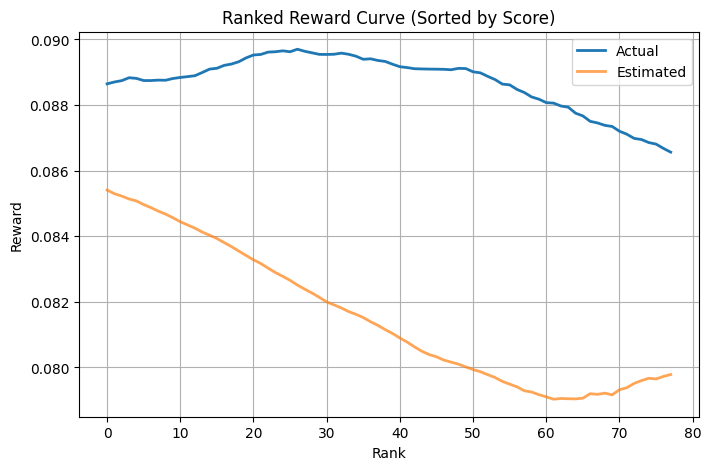

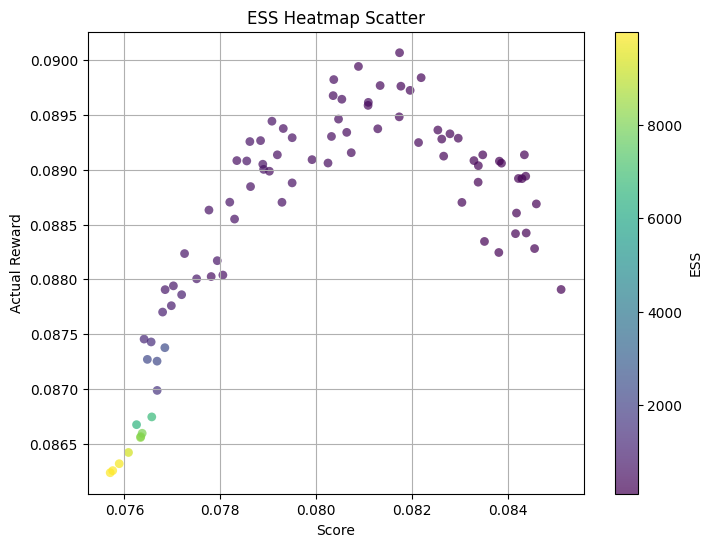

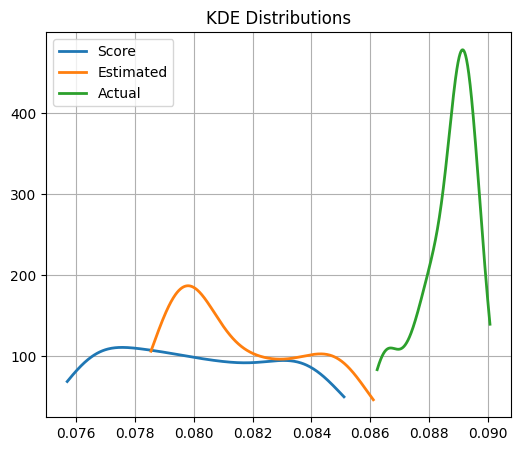

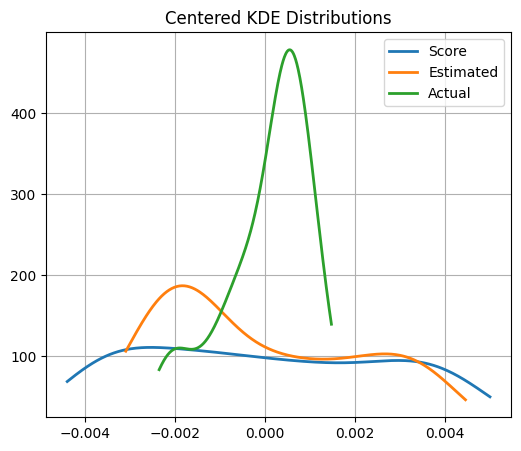

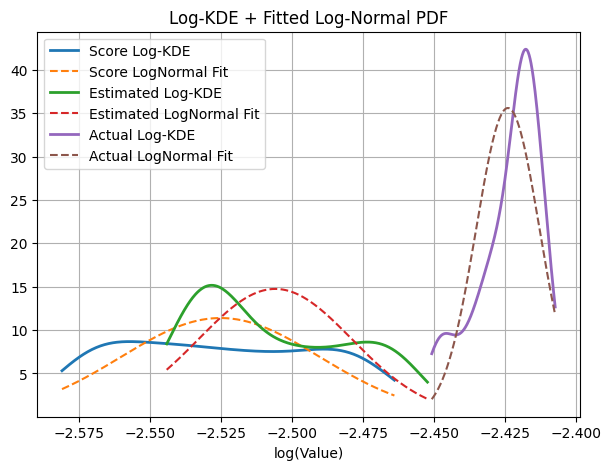

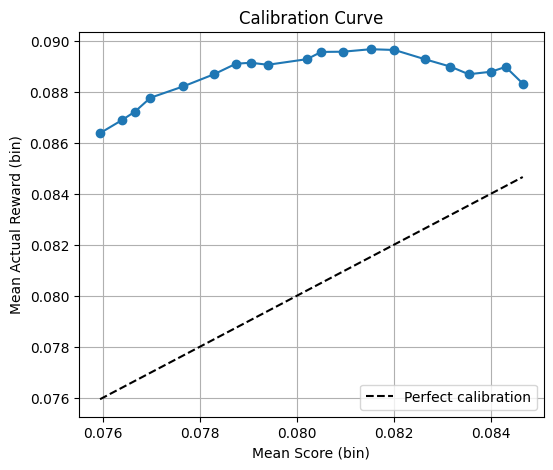

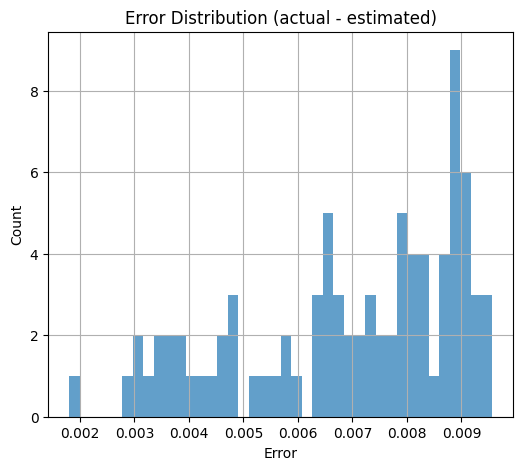

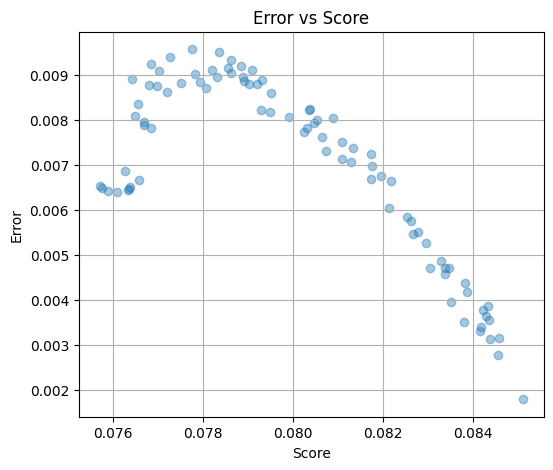

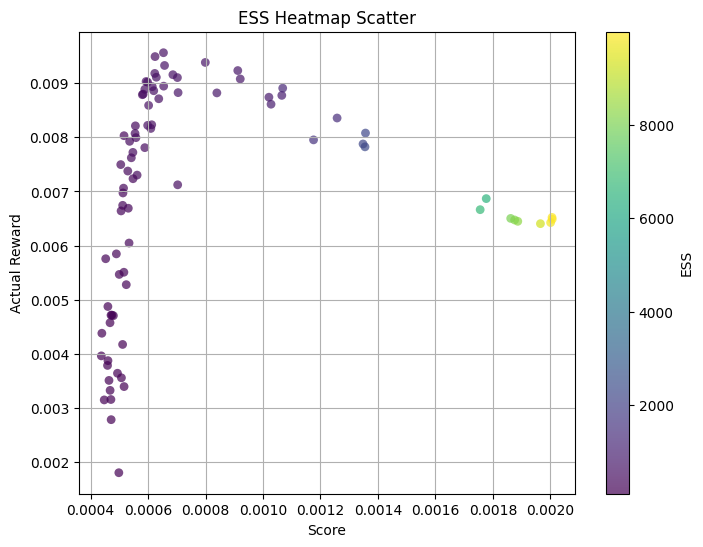

Correlation Metrics: {'pearson_score_actual': np.float64(0.6248263378939609), 'spearman_score_actual': np.float64(0.5498844285107788), 'spearman_est_actual': np.float64(0.46514458229161754)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9973785109218264), 'ndcg_est_actual': np.float64(0.9972788997878496)}
Error Metrics: {'mean_error': np.float64(0.006945446610284324), 'mae': np.float64(0.006945446610284324), 'rmse': np.float64(0.00722647028151101), 'std_error': np.float64(0.0019956563114052975), 'max_error': np.float64(0.009561849622270663), 'min_error': np.float64(0.0018031395376460618)}


In [23]:
compute_statistics_and_plots(study_df8)

In [24]:
dataset_params = dict(
                    n_actions= 500,
                    n_users = 500,
                    emb_dim = 16,
                    # sigma = 0.1,
                    eps = 0.6, # this is the epsilon for the noise in the ground truth policy representation
                    ctr = 0.1
                    )

train_dataset = generate_dataset(dataset_params, seed=50000)

Random Item CTR: 0.0705882181025533
Optimal greedy CTR: 0.09999934164533562
Second Best greedy CTR: 0.09924496289352924
Optimal Stochastic CTR: 0.09995498601895662
second Best Stochastic CTR: 0.08629000824986369
Our Initial CTR: 0.08647501952799874


In [25]:
# Run the optimization
df9, study_df9 = regression_trainer_trial(num_runs, num_neighbors, num_rounds_list, train_dataset, batch_size, val_size=10000, n_trials=n_trials_for_optuna, prev_best_params=best_params_to_use)

study_df9.to_csv(f"trial_dfs/study_df_{n_trials_for_optuna}_{50000}.csv")
# Show the performance metrics
df9[['policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr', 'action_diff_to_real', 'action_delta', 'context_diff_to_real', 'context_delta']]

Simulation time for 10000 samples: 0.06274247169494629 seconds
[Regression] Baseline regression model fit time: 0.05s
Num samples is 10000
{'gini': np.float64(0.49235289584240755), 'ess': np.float64(3920.850377807727), 'max_wi': np.float64(28.81179232749837), 'min_wi': np.float64(0.01566038085745478)}
Eval time: 0.5471382141113281 seconds


[I 2025-12-15 00:04:06,405] A new study created in memory with name: no-name-3d2416b8-dd8a-43cc-b6dd-40af86d186a6


Evaluation total results time: 0.87 seconds

=== [Regression] Training size 15000, run 0 ===
Simulation time for 25000 samples: 0.0576024055480957 seconds


  0%|          | 0/155 [00:00<?, ?it/s]


[Regression] Optuna Trial 0
actual reward: [0.08190745]
Validation weights_info: {'gini': np.float64(0.9863896666798563), 'ess': np.float64(145.61421859248838), 'max_wi': np.float64(117.3668527368608), 'min_wi': np.float64(0.0)}


Best trial: 0. Best value: 0.0851958:   1%|          | 1/155 [00:03<09:22,  3.65s/it]

[I 2025-12-15 00:04:10,055] Trial 0 finished with value: 0.0851958039981201 and parameters: {'lr': 0.096, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.85}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 1
actual reward: [0.08664202]
Validation weights_info: {'gini': np.float64(0.11087466946441725), 'ess': np.float64(9573.626411194477), 'max_wi': np.float64(1.9395491763893968), 'min_wi': np.float64(0.6294197611354625)}


Best trial: 0. Best value: 0.0851958:   1%|▏         | 2/155 [00:08<11:18,  4.44s/it]

[I 2025-12-15 00:04:15,040] Trial 1 finished with value: 0.07645627220771349 and parameters: {'lr': 0.00011977083451550351, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.830957076297591}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 2
actual reward: [0.08790718]
Validation weights_info: {'gini': np.float64(0.5439108540010009), 'ess': np.float64(3489.4173729896856), 'max_wi': np.float64(17.77817754620434), 'min_wi': np.float64(0.049371037429865025)}


Best trial: 0. Best value: 0.0851958:   2%|▏         | 3/155 [00:11<09:29,  3.75s/it]

[I 2025-12-15 00:04:17,974] Trial 2 finished with value: 0.07963923324778804 and parameters: {'lr': 0.0010422341756440119, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9050025812178693}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 3
actual reward: [0.09032344]
Validation weights_info: {'gini': np.float64(0.993562403068152), 'ess': np.float64(27.776837640206022), 'max_wi': np.float64(1097.1034289216877), 'min_wi': np.float64(2.967785535872695e-10)}


Best trial: 0. Best value: 0.0851958:   3%|▎         | 4/155 [00:15<09:21,  3.72s/it]

[I 2025-12-15 00:04:21,637] Trial 3 finished with value: -inf and parameters: {'lr': 0.006306220527871709, 'num_epochs': 10, 'batch_size': 128, 'lr_decay': 0.9429348118122886}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 4
actual reward: [0.08987588]
Validation weights_info: {'gini': np.float64(0.9924206817622019), 'ess': np.float64(29.127370854841498), 'max_wi': np.float64(1242.5215882405514), 'min_wi': np.float64(3.163378343457371e-08)}


Best trial: 0. Best value: 0.0851958:   3%|▎         | 5/155 [00:18<08:44,  3.50s/it]

[I 2025-12-15 00:04:24,744] Trial 4 finished with value: -inf and parameters: {'lr': 0.00605223134148517, 'num_epochs': 10, 'batch_size': 256, 'lr_decay': 0.9769699283566363}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 5
actual reward: [0.08819841]
Validation weights_info: {'gini': np.float64(0.9978038049316552), 'ess': np.float64(7.871574339345346), 'max_wi': np.float64(3057.020230026921), 'min_wi': np.float64(3.7551964025864476e-10)}


Best trial: 0. Best value: 0.0851958:   4%|▍         | 6/155 [00:21<08:15,  3.32s/it]

[I 2025-12-15 00:04:27,734] Trial 5 finished with value: -inf and parameters: {'lr': 0.013209925967127225, 'num_epochs': 9, 'batch_size': 256, 'lr_decay': 0.9209540112286223}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 6
actual reward: [0.08809481]
Validation weights_info: {'gini': np.float64(0.9974868301757998), 'ess': np.float64(12.60957655747395), 'max_wi': np.float64(1583.5919786284912), 'min_wi': np.float64(8.603724886961614e-13)}


Best trial: 0. Best value: 0.0851958:   5%|▍         | 7/155 [00:23<06:55,  2.81s/it]

[I 2025-12-15 00:04:29,487] Trial 6 finished with value: -inf and parameters: {'lr': 0.04657001533416358, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.8800286256882965}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 7
actual reward: [0.08774356]
Validation weights_info: {'gini': np.float64(0.9927351278084634), 'ess': np.float64(20.69120435307871), 'max_wi': np.float64(1163.2633426155066), 'min_wi': np.float64(3.9737721696851477e-35)}


Best trial: 0. Best value: 0.0851958:   5%|▌         | 8/155 [00:25<06:21,  2.60s/it]

[I 2025-12-15 00:04:31,622] Trial 7 finished with value: -inf and parameters: {'lr': 0.07502913352759662, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.8869305342271652}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 8
actual reward: [0.08653479]
Validation weights_info: {'gini': np.float64(0.044864606812776646), 'ess': np.float64(9930.63346412969), 'max_wi': np.float64(1.3216872979228544), 'min_wi': np.float64(0.8358597139986677)}


Best trial: 0. Best value: 0.0851958:   6%|▌         | 9/155 [00:26<05:15,  2.16s/it]

[I 2025-12-15 00:04:32,820] Trial 8 finished with value: 0.0762555652718321 and parameters: {'lr': 0.0004994517073314413, 'num_epochs': 1, 'batch_size': 256, 'lr_decay': 0.9018074817849103}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 9
actual reward: [0.085616]
Validation weights_info: {'gini': np.float64(0.9963318787741705), 'ess': np.float64(5.749936649847929), 'max_wi': np.float64(4624.635001680262), 'min_wi': np.float64(3.0240309233776356e-22)}


Best trial: 0. Best value: 0.0851958:   6%|▋         | 10/155 [00:28<04:55,  2.04s/it]

[I 2025-12-15 00:04:34,581] Trial 9 finished with value: -inf and parameters: {'lr': 0.08997200781491323, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9062897582632837}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 10
actual reward: [0.09275465]
Validation weights_info: {'gini': np.float64(0.9628547974409296), 'ess': np.float64(235.58047587713074), 'max_wi': np.float64(209.1939478873779), 'min_wi': np.float64(8.989728409258667e-07)}


Best trial: 0. Best value: 0.0851958:   7%|▋         | 11/155 [00:30<05:05,  2.12s/it]

[I 2025-12-15 00:04:36,903] Trial 10 finished with value: 0.0843495140354596 and parameters: {'lr': 0.018958729011569447, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8045656410242368}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 11
actual reward: [0.09069485]
Validation weights_info: {'gini': np.float64(0.9809140861837408), 'ess': np.float64(74.22318991161438), 'max_wi': np.float64(700.2653310989009), 'min_wi': np.float64(2.767751945475612e-07)}


Best trial: 0. Best value: 0.0851958:   8%|▊         | 12/155 [00:32<05:08,  2.15s/it]

[I 2025-12-15 00:04:39,126] Trial 11 finished with value: -inf and parameters: {'lr': 0.0244018087839431, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8014685686457786}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 12
actual reward: [0.08893245]
Validation weights_info: {'gini': np.float64(0.9912976532008996), 'ess': np.float64(25.132476177896695), 'max_wi': np.float64(1419.845030028102), 'min_wi': np.float64(9.738081032133714e-08)}


Best trial: 0. Best value: 0.0851958:   8%|▊         | 13/155 [00:35<05:25,  2.29s/it]

[I 2025-12-15 00:04:41,745] Trial 12 finished with value: -inf and parameters: {'lr': 0.023667164821802974, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8342117771584003}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 13
actual reward: [0.08734347]
Validation weights_info: {'gini': np.float64(0.38889284735201124), 'ess': np.float64(5863.574904480639), 'max_wi': np.float64(7.913901131239128), 'min_wi': np.float64(0.15390316700370876)}


Best trial: 0. Best value: 0.0851958:   9%|▉         | 14/155 [00:37<05:17,  2.25s/it]

[I 2025-12-15 00:04:43,907] Trial 13 finished with value: 0.07831775544235964 and parameters: {'lr': 0.0018776457666767952, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8501795598296881}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 14
actual reward: [0.08797081]
Validation weights_info: {'gini': np.float64(0.993481577212616), 'ess': np.float64(21.167589574337153), 'max_wi': np.float64(838.5144832985869), 'min_wi': np.float64(3.978979162593153e-14)}


Best trial: 0. Best value: 0.0851958:  10%|▉         | 15/155 [00:40<06:03,  2.60s/it]

[I 2025-12-15 00:04:47,295] Trial 14 finished with value: -inf and parameters: {'lr': 0.02858303451186376, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8033449149638526}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 15
actual reward: [0.08790381]
Validation weights_info: {'gini': np.float64(0.9932683722889747), 'ess': np.float64(30.982080787944625), 'max_wi': np.float64(844.6539539201472), 'min_wi': np.float64(3.6368661158690745e-10)}


Best trial: 0. Best value: 0.0851958:  10%|█         | 16/155 [00:43<06:16,  2.71s/it]

[I 2025-12-15 00:04:50,276] Trial 15 finished with value: -inf and parameters: {'lr': 0.011093816379054787, 'num_epochs': 7, 'batch_size': 128, 'lr_decay': 0.8586737526125131}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 16
actual reward: [0.08647952]
Validation weights_info: {'gini': np.float64(0.9980556588575862), 'ess': np.float64(9.17345636095118), 'max_wi': np.float64(1519.180685135874), 'min_wi': np.float64(2.355159596448852e-17)}


Best trial: 0. Best value: 0.0851958:  11%|█         | 17/155 [00:45<05:30,  2.39s/it]

[I 2025-12-15 00:04:51,922] Trial 16 finished with value: -inf and parameters: {'lr': 0.0911109493903539, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.8242969701040039}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 17
actual reward: [0.0924494]
Validation weights_info: {'gini': np.float64(0.9553573294644877), 'ess': np.float64(226.78694002592465), 'max_wi': np.float64(219.6856246608388), 'min_wi': np.float64(4.151482631980036e-07)}


Best trial: 0. Best value: 0.0851958:  12%|█▏        | 18/155 [00:50<07:01,  3.08s/it]

[I 2025-12-15 00:04:56,594] Trial 17 finished with value: 0.08336734102188482 and parameters: {'lr': 0.0035149001434626663, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8626434060910495}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 18
actual reward: [0.0892104]
Validation weights_info: {'gini': np.float64(0.9915953583566023), 'ess': np.float64(22.80984822833924), 'max_wi': np.float64(1187.287274743003), 'min_wi': np.float64(1.0709482177727363e-08)}


Best trial: 0. Best value: 0.0851958:  12%|█▏        | 19/155 [00:52<06:26,  2.85s/it]

[I 2025-12-15 00:04:58,901] Trial 18 finished with value: -inf and parameters: {'lr': 0.038476260781127605, 'num_epochs': 4, 'batch_size': 512, 'lr_decay': 0.8177063937873525}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 19
actual reward: [0.09170038]
Validation weights_info: {'gini': np.float64(0.9966794178705161), 'ess': np.float64(6.225713405768496), 'max_wi': np.float64(6299.497453485864), 'min_wi': np.float64(7.252836342309596e-13)}


Best trial: 0. Best value: 0.0851958:  13%|█▎        | 20/155 [00:56<07:30,  3.34s/it]

[I 2025-12-15 00:05:03,379] Trial 19 finished with value: -inf and parameters: {'lr': 0.013199689651464104, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8459665315209266}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 20
actual reward: [0.08542588]
Validation weights_info: {'gini': np.float64(0.9976648335809845), 'ess': np.float64(8.48819367280242), 'max_wi': np.float64(2888.110989297014), 'min_wi': np.float64(1.7937987719223325e-19)}


Best trial: 0. Best value: 0.0851958:  14%|█▎        | 21/155 [00:59<06:41,  3.00s/it]

[I 2025-12-15 00:05:05,593] Trial 20 finished with value: -inf and parameters: {'lr': 0.04957712897383078, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.8642778656656089}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 21
actual reward: [0.0922269]
Validation weights_info: {'gini': np.float64(0.9660491757111125), 'ess': np.float64(104.03695901156564), 'max_wi': np.float64(461.7112705007861), 'min_wi': np.float64(2.456757994788788e-07)}


Best trial: 0. Best value: 0.0851958:  14%|█▍        | 22/155 [01:03<07:37,  3.44s/it]

[I 2025-12-15 00:05:10,061] Trial 21 finished with value: 0.08364774333783473 and parameters: {'lr': 0.004055296926287781, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.85803024562691}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 22
actual reward: [0.09193593]
Validation weights_info: {'gini': np.float64(0.911756299693444), 'ess': np.float64(426.0807906826006), 'max_wi': np.float64(186.103405356661), 'min_wi': np.float64(4.73569631115105e-05)}


Best trial: 0. Best value: 0.0851958:  15%|█▍        | 23/155 [01:07<07:52,  3.58s/it]

[I 2025-12-15 00:05:13,967] Trial 22 finished with value: 0.08227719361073084 and parameters: {'lr': 0.0024817327888373483, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8812130765764808}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 23
actual reward: [0.0923482]
Validation weights_info: {'gini': np.float64(0.9739230307175513), 'ess': np.float64(94.41581961132162), 'max_wi': np.float64(515.6197211298405), 'min_wi': np.float64(9.784233375472818e-09)}


Best trial: 0. Best value: 0.0851958:  15%|█▌        | 24/155 [01:11<07:45,  3.55s/it]

[I 2025-12-15 00:05:17,456] Trial 23 finished with value: -inf and parameters: {'lr': 0.00561753637120598, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.815964113295765}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 24
actual reward: [0.08885719]
Validation weights_info: {'gini': np.float64(0.7122321785460679), 'ess': np.float64(1815.9070781020089), 'max_wi': np.float64(29.136571816342954), 'min_wi': np.float64(0.00983094839161961)}


Best trial: 0. Best value: 0.0851958:  16%|█▌        | 25/155 [01:15<08:33,  3.95s/it]

[I 2025-12-15 00:05:22,330] Trial 24 finished with value: 0.08065124541586939 and parameters: {'lr': 0.0009548225425886114, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8385546703639092}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 25
actual reward: [0.08913656]
Validation weights_info: {'gini': np.float64(0.9954314487684349), 'ess': np.float64(11.026295289552808), 'max_wi': np.float64(3332.670297241833), 'min_wi': np.float64(1.6156383367297946e-08)}


Best trial: 0. Best value: 0.0851958:  17%|█▋        | 26/155 [01:18<07:35,  3.53s/it]

[I 2025-12-15 00:05:24,882] Trial 25 finished with value: -inf and parameters: {'lr': 0.01544782687315313, 'num_epochs': 8, 'batch_size': 512, 'lr_decay': 0.9327476003293773}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 26
actual reward: [0.0918882]
Validation weights_info: {'gini': np.float64(0.9933272813279465), 'ess': np.float64(16.75353757288532), 'max_wi': np.float64(2085.9265709456613), 'min_wi': np.float64(2.7070694058100607e-11)}


Best trial: 0. Best value: 0.0851958:  17%|█▋        | 27/155 [01:23<08:10,  3.84s/it]

[I 2025-12-15 00:05:29,430] Trial 26 finished with value: -inf and parameters: {'lr': 0.00859376720368874, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8673148299695738}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 27
actual reward: [0.08691705]
Validation weights_info: {'gini': np.float64(0.24524860042267696), 'ess': np.float64(8043.253809357637), 'max_wi': np.float64(4.032946080625474), 'min_wi': np.float64(0.3352374501953602)}


Best trial: 0. Best value: 0.0851958:  18%|█▊        | 28/155 [01:26<08:09,  3.85s/it]

[I 2025-12-15 00:05:33,321] Trial 27 finished with value: 0.07717516633604782 and parameters: {'lr': 0.0003126308819246352, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8158043283014752}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 28
actual reward: [0.08873089]
Validation weights_info: {'gini': np.float64(0.6908345644275502), 'ess': np.float64(1896.5460681101665), 'max_wi': np.float64(30.055172171368596), 'min_wi': np.float64(0.01020662924155401)}


Best trial: 0. Best value: 0.0851958:  19%|█▊        | 29/155 [01:28<06:57,  3.31s/it]

[I 2025-12-15 00:05:35,370] Trial 28 finished with value: 0.08071831921094139 and parameters: {'lr': 0.003986360713081706, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8488228252782469}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 29
actual reward: [0.08661973]
Validation weights_info: {'gini': np.float64(0.09668753157026296), 'ess': np.float64(9676.499459243436), 'max_wi': np.float64(1.7848726181063135), 'min_wi': np.float64(0.6567826270136966)}


Best trial: 0. Best value: 0.0851958:  19%|█▉        | 30/155 [01:34<08:00,  3.84s/it]

[I 2025-12-15 00:05:40,451] Trial 29 finished with value: 0.07640729631892254 and parameters: {'lr': 0.00010442400547649613, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8324229795455478}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 30
actual reward: [0.08994745]
Validation weights_info: {'gini': np.float64(0.9954087051197607), 'ess': np.float64(13.06248255548616), 'max_wi': np.float64(2075.599479295789), 'min_wi': np.float64(2.8432628432091604e-13)}


Best trial: 0. Best value: 0.0851958:  20%|██        | 31/155 [01:37<07:37,  3.69s/it]

[I 2025-12-15 00:05:43,785] Trial 30 finished with value: -inf and parameters: {'lr': 0.019419818799839755, 'num_epochs': 9, 'batch_size': 128, 'lr_decay': 0.9887585450874352}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 31
actual reward: [0.09126119]
Validation weights_info: {'gini': np.float64(0.8773844223476366), 'ess': np.float64(681.0173505328944), 'max_wi': np.float64(130.49747792542607), 'min_wi': np.float64(0.00032754177464059574)}


Best trial: 0. Best value: 0.0851958:  21%|██        | 32/155 [01:41<08:00,  3.91s/it]

[I 2025-12-15 00:05:48,194] Trial 31 finished with value: 0.08227655907986331 and parameters: {'lr': 0.001748242331836691, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.872352803012217}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 32
actual reward: [0.09216685]
Validation weights_info: {'gini': np.float64(0.9589232301646936), 'ess': np.float64(108.36421721443728), 'max_wi': np.float64(532.6672517431414), 'min_wi': np.float64(7.058673981741506e-07)}


Best trial: 0. Best value: 0.0851958:  21%|██▏       | 33/155 [01:46<08:17,  4.08s/it]

[I 2025-12-15 00:05:52,687] Trial 32 finished with value: 0.08380862483099626 and parameters: {'lr': 0.0031003836334235987, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.8897978823416209}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 33
actual reward: [0.08838409]
Validation weights_info: {'gini': np.float64(0.647703474760549), 'ess': np.float64(2330.298154136224), 'max_wi': np.float64(26.471861046451632), 'min_wi': np.float64(0.019026533984280305)}


Best trial: 0. Best value: 0.0851958:  22%|██▏       | 34/155 [01:50<08:13,  4.08s/it]

[I 2025-12-15 00:05:56,752] Trial 33 finished with value: 0.08012989128781076 and parameters: {'lr': 0.000824661590643495, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.890229444722328}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 34
actual reward: [0.09175075]
Validation weights_info: {'gini': np.float64(0.9926754723898474), 'ess': np.float64(33.914855366281486), 'max_wi': np.float64(783.2070095894035), 'min_wi': np.float64(2.4334437189416003e-12)}


Best trial: 0. Best value: 0.0851958:  23%|██▎       | 35/155 [01:55<08:44,  4.37s/it]

[I 2025-12-15 00:06:01,817] Trial 34 finished with value: -inf and parameters: {'lr': 0.00846846760030239, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.9149200983885243}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 35
actual reward: [0.09059054]
Validation weights_info: {'gini': np.float64(0.8486440219117554), 'ess': np.float64(932.445294065912), 'max_wi': np.float64(63.571695185506115), 'min_wi': np.float64(0.0005622185384427976)}


Best trial: 0. Best value: 0.0851958:  23%|██▎       | 36/155 [02:00<09:18,  4.70s/it]

[I 2025-12-15 00:06:07,266] Trial 35 finished with value: 0.08177324462957047 and parameters: {'lr': 0.0014442644429186453, 'num_epochs': 9, 'batch_size': 64, 'lr_decay': 0.850486465123882}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 36
actual reward: [0.09259001]
Validation weights_info: {'gini': np.float64(0.9832074569775223), 'ess': np.float64(49.94287450787785), 'max_wi': np.float64(702.3732650481213), 'min_wi': np.float64(1.01889925709708e-09)}


Best trial: 0. Best value: 0.0851958:  24%|██▍       | 37/155 [02:05<09:04,  4.61s/it]

[I 2025-12-15 00:06:11,681] Trial 36 finished with value: -inf and parameters: {'lr': 0.004667722702494109, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.957225598027389}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 37
actual reward: [0.09069568]
Validation weights_info: {'gini': np.float64(0.8602357426852353), 'ess': np.float64(783.045448502971), 'max_wi': np.float64(57.65417324416548), 'min_wi': np.float64(0.00045287346523310043)}


Best trial: 0. Best value: 0.0851958:  25%|██▍       | 38/155 [02:07<07:37,  3.91s/it]

[I 2025-12-15 00:06:13,944] Trial 37 finished with value: 0.08232950617729227 and parameters: {'lr': 0.003076485135671244, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.8938206404964668}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 38
actual reward: [0.08827257]
Validation weights_info: {'gini': np.float64(0.9992437113562996), 'ess': np.float64(6.021854685656735), 'max_wi': np.float64(3990.035736267017), 'min_wi': np.float64(4.999386777091106e-15)}


Best trial: 0. Best value: 0.0851958:  25%|██▌       | 39/155 [02:10<06:49,  3.53s/it]

[I 2025-12-15 00:06:16,586] Trial 38 finished with value: -inf and parameters: {'lr': 0.06002168048070597, 'num_epochs': 9, 'batch_size': 512, 'lr_decay': 0.8740656461881922}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 39
actual reward: [0.09177971]
Validation weights_info: {'gini': np.float64(0.9034750940698788), 'ess': np.float64(557.5520638248453), 'max_wi': np.float64(143.13556642021098), 'min_wi': np.float64(6.702870069257164e-05)}


Best trial: 0. Best value: 0.0851958:  26%|██▌       | 40/155 [02:11<05:41,  2.97s/it]

[I 2025-12-15 00:06:18,246] Trial 39 finished with value: 0.08310860102549747 and parameters: {'lr': 0.0076776516193226355, 'num_epochs': 3, 'batch_size': 256, 'lr_decay': 0.9144922864389755}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 40
actual reward: [0.08709926]
Validation weights_info: {'gini': np.float64(0.3183008581385761), 'ess': np.float64(6949.102932090631), 'max_wi': np.float64(5.96730395470737), 'min_wi': np.float64(0.23737104990372263)}


Best trial: 0. Best value: 0.0851958:  26%|██▋       | 41/155 [02:17<07:16,  3.83s/it]

[I 2025-12-15 00:06:24,084] Trial 40 finished with value: 0.07766251781539772 and parameters: {'lr': 0.0002133710268460095, 'num_epochs': 10, 'batch_size': 64, 'lr_decay': 0.9305095503852017}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 41
actual reward: [0.09176252]
Validation weights_info: {'gini': np.float64(0.966733078920948), 'ess': np.float64(99.00157705211666), 'max_wi': np.float64(525.189837006717), 'min_wi': np.float64(3.6998629241954843e-07)}


Best trial: 0. Best value: 0.0851958:  27%|██▋       | 42/155 [02:22<07:31,  4.00s/it]

[I 2025-12-15 00:06:28,479] Trial 41 finished with value: -inf and parameters: {'lr': 0.0036970476570663724, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.854680018829017}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 42
actual reward: [0.09191033]
Validation weights_info: {'gini': np.float64(0.9112844681525873), 'ess': np.float64(398.0802297611461), 'max_wi': np.float64(257.6031526598129), 'min_wi': np.float64(5.746659870725029e-05)}


Best trial: 0. Best value: 0.0851958:  28%|██▊       | 43/155 [02:26<07:26,  3.98s/it]

[I 2025-12-15 00:06:32,429] Trial 42 finished with value: 0.08255134785310805 and parameters: {'lr': 0.0024983990974341585, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8638381428365285}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 43
actual reward: [0.08782909]
Validation weights_info: {'gini': np.float64(0.5314799749718093), 'ess': np.float64(3720.2571289700336), 'max_wi': np.float64(16.93566094917271), 'min_wi': np.float64(0.05601975901278886)}


Best trial: 0. Best value: 0.0851958:  28%|██▊       | 44/155 [02:30<07:47,  4.21s/it]

[I 2025-12-15 00:06:37,179] Trial 43 finished with value: 0.07930064591942287 and parameters: {'lr': 0.0006091910177539569, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8392269268287676}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 44
actual reward: [0.08770592]
Validation weights_info: {'gini': np.float64(0.9985051857344002), 'ess': np.float64(7.583532119011349), 'max_wi': np.float64(3455.3900952154986), 'min_wi': np.float64(1.9409492343802312e-13)}


Best trial: 0. Best value: 0.0851958:  29%|██▉       | 45/155 [02:33<06:37,  3.62s/it]

[I 2025-12-15 00:06:39,406] Trial 44 finished with value: -inf and parameters: {'lr': 0.0371508195453492, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8768836900787319}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 45
actual reward: [0.09125123]
Validation weights_info: {'gini': np.float64(0.9906731333358213), 'ess': np.float64(11.099990898795673), 'max_wi': np.float64(3364.843310717247), 'min_wi': np.float64(1.6287483007496641e-09)}


Best trial: 0. Best value: 0.0851958:  30%|██▉       | 46/155 [02:37<07:07,  3.93s/it]

[I 2025-12-15 00:06:44,053] Trial 45 finished with value: -inf and parameters: {'lr': 0.005420976810520719, 'num_epochs': 7, 'batch_size': 64, 'lr_decay': 0.9008305663273205}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 46
actual reward: [0.08708609]
Validation weights_info: {'gini': np.float64(0.3087994400877605), 'ess': np.float64(7102.889305755241), 'max_wi': np.float64(5.427058484207834), 'min_wi': np.float64(0.2386335062035051)}


Best trial: 0. Best value: 0.0851958:  30%|███       | 47/155 [02:39<06:12,  3.44s/it]

[I 2025-12-15 00:06:46,374] Trial 46 finished with value: 0.07760598751468131 and parameters: {'lr': 0.0011972023898557573, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8868977591526431}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 47
actual reward: [0.09125537]
Validation weights_info: {'gini': np.float64(0.8859377009235395), 'ess': np.float64(640.8717818463642), 'max_wi': np.float64(109.80904219116967), 'min_wi': np.float64(0.00017042724216889514)}


Best trial: 0. Best value: 0.0851958:  31%|███       | 48/155 [02:43<06:07,  3.44s/it]

[I 2025-12-15 00:06:49,794] Trial 47 finished with value: 0.0821668065190049 and parameters: {'lr': 0.0024804113768797974, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8224888261304273}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 48
actual reward: [0.09231761]
Validation weights_info: {'gini': np.float64(0.9114387212705696), 'ess': np.float64(552.8061273298779), 'max_wi': np.float64(49.70842940667113), 'min_wi': np.float64(0.00010982840280718577)}


Best trial: 0. Best value: 0.0851958:  32%|███▏      | 49/155 [02:45<05:32,  3.14s/it]

[I 2025-12-15 00:06:52,237] Trial 48 finished with value: 0.08313501329099529 and parameters: {'lr': 0.010133071044906182, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8012284701787755}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 49
actual reward: [0.08945381]
Validation weights_info: {'gini': np.float64(0.9980983379125044), 'ess': np.float64(8.511139804879273), 'max_wi': np.float64(3719.612803469371), 'min_wi': np.float64(6.102591731214033e-10)}


Best trial: 0. Best value: 0.0851958:  32%|███▏      | 50/155 [02:48<05:12,  2.98s/it]

[I 2025-12-15 00:06:54,833] Trial 49 finished with value: -inf and parameters: {'lr': 0.017800234909589333, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8588783430534678}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 50
actual reward: [0.08269733]
Validation weights_info: {'gini': np.float64(0.987191485211064), 'ess': np.float64(53.0024089068405), 'max_wi': np.float64(775.5161173476397), 'min_wi': np.float64(3.963833733558803e-32)}


Best trial: 0. Best value: 0.0851958:  33%|███▎      | 51/155 [02:53<06:08,  3.54s/it]

[I 2025-12-15 00:06:59,703] Trial 50 finished with value: -inf and parameters: {'lr': 0.06742315204104393, 'num_epochs': 8, 'batch_size': 64, 'lr_decay': 0.8417140435524076}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 51
actual reward: [0.09246721]
Validation weights_info: {'gini': np.float64(0.9200160570702545), 'ess': np.float64(526.9640303161622), 'max_wi': np.float64(55.215229642114856), 'min_wi': np.float64(5.2896787523927285e-05)}


Best trial: 0. Best value: 0.0851958:  34%|███▎      | 52/155 [02:55<05:30,  3.21s/it]

[I 2025-12-15 00:07:02,136] Trial 51 finished with value: 0.08335648331534024 and parameters: {'lr': 0.010606657923838475, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8056188820200763}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 52
actual reward: [0.09074163]
Validation weights_info: {'gini': np.float64(0.8590448113017171), 'ess': np.float64(767.2994445252481), 'max_wi': np.float64(43.85637433581161), 'min_wi': np.float64(0.0003925779854474621)}


Best trial: 0. Best value: 0.0851958:  34%|███▍      | 53/155 [02:58<05:02,  2.97s/it]

[I 2025-12-15 00:07:04,537] Trial 52 finished with value: 0.08239780227697559 and parameters: {'lr': 0.006782859575848938, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8093436550440352}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 53
actual reward: [0.08863327]
Validation weights_info: {'gini': np.float64(0.9933544050585285), 'ess': np.float64(11.492541846710832), 'max_wi': np.float64(3021.2370937325804), 'min_wi': np.float64(3.3492287575960224e-08)}


Best trial: 0. Best value: 0.0851958:  35%|███▍      | 54/155 [03:00<04:48,  2.85s/it]

[I 2025-12-15 00:07:07,125] Trial 53 finished with value: -inf and parameters: {'lr': 0.024923963129224215, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.8264247832395145}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 54
actual reward: [0.09269182]
Validation weights_info: {'gini': np.float64(0.9141244056978337), 'ess': np.float64(554.4635961125099), 'max_wi': np.float64(52.79187717417201), 'min_wi': np.float64(4.0015651484498465e-05)}


Best trial: 0. Best value: 0.0851958:  35%|███▌      | 55/155 [03:03<04:33,  2.74s/it]

[I 2025-12-15 00:07:09,586] Trial 54 finished with value: 0.08342905011410431 and parameters: {'lr': 0.011906560713361387, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8100192572193202}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 55
actual reward: [0.08886158]
Validation weights_info: {'gini': np.float64(0.9971298711576174), 'ess': np.float64(10.090538920131332), 'max_wi': np.float64(2020.2734616076812), 'min_wi': np.float64(7.449927452658765e-15)}


Best trial: 0. Best value: 0.0851958:  36%|███▌      | 56/155 [03:05<04:17,  2.60s/it]

[I 2025-12-15 00:07:11,874] Trial 55 finished with value: -inf and parameters: {'lr': 0.03727630466357952, 'num_epochs': 4, 'batch_size': 128, 'lr_decay': 0.8117724529708327}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 56
actual reward: [0.08807246]
Validation weights_info: {'gini': np.float64(0.5815122099851798), 'ess': np.float64(3108.3871813113515), 'max_wi': np.float64(21.88151309748414), 'min_wi': np.float64(0.034819613877094875)}


Best trial: 0. Best value: 0.0851958:  37%|███▋      | 57/155 [03:07<03:59,  2.45s/it]

[I 2025-12-15 00:07:13,958] Trial 56 finished with value: 0.07969143358398419 and parameters: {'lr': 0.0029493339280039672, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8679810924864739}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 57
actual reward: [0.08728461]
Validation weights_info: {'gini': np.float64(0.3890696902748957), 'ess': np.float64(5664.62310115835), 'max_wi': np.float64(9.373774824162762), 'min_wi': np.float64(0.14307658299668974)}


Best trial: 0. Best value: 0.0851958:  37%|███▋      | 58/155 [03:09<03:33,  2.20s/it]

[I 2025-12-15 00:07:15,581] Trial 57 finished with value: 0.07834240064883559 and parameters: {'lr': 0.0018975224683352892, 'num_epochs': 1, 'batch_size': 64, 'lr_decay': 0.8306997393234177}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 58
actual reward: [0.08116879]
Validation weights_info: {'gini': np.float64(0.9980483422706701), 'ess': np.float64(5.308682700918363), 'max_wi': np.float64(2155.54736007557), 'min_wi': np.float64(3.0379704143681235e-20)}


Best trial: 0. Best value: 0.0851958:  38%|███▊      | 59/155 [03:11<03:38,  2.28s/it]

[I 2025-12-15 00:07:18,042] Trial 58 finished with value: -inf and parameters: {'lr': 0.09938814075847353, 'num_epochs': 5, 'batch_size': 512, 'lr_decay': 0.8838741574809313}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 59
actual reward: [0.0926689]
Validation weights_info: {'gini': np.float64(0.9436680387005196), 'ess': np.float64(349.6037805747426), 'max_wi': np.float64(143.3896639253535), 'min_wi': np.float64(2.143457509263337e-06)}


Best trial: 0. Best value: 0.0851958:  39%|███▊      | 60/155 [03:14<03:59,  2.52s/it]

[I 2025-12-15 00:07:21,122] Trial 59 finished with value: 0.08346854997379641 and parameters: {'lr': 0.00444131410264798, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.8568017405232202}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 60
actual reward: [0.0906742]
Validation weights_info: {'gini': np.float64(0.8794305117612395), 'ess': np.float64(526.0206043541385), 'max_wi': np.float64(143.51209649012404), 'min_wi': np.float64(0.0003111603987741298)}


Best trial: 0. Best value: 0.0851958:  39%|███▉      | 61/155 [03:16<03:42,  2.37s/it]

[I 2025-12-15 00:07:23,134] Trial 60 finished with value: 0.08243194123364217 and parameters: {'lr': 0.004588417962219341, 'num_epochs': 2, 'batch_size': 64, 'lr_decay': 0.8235688273405612}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 61
actual reward: [0.09213951]
Validation weights_info: {'gini': np.float64(0.9775502584875371), 'ess': np.float64(27.019155071980258), 'max_wi': np.float64(1606.3852654876773), 'min_wi': np.float64(1.1629390514595417e-07)}


Best trial: 0. Best value: 0.0851958:  40%|████      | 62/155 [03:19<04:01,  2.60s/it]

[I 2025-12-15 00:07:26,263] Trial 61 finished with value: -inf and parameters: {'lr': 0.006247712221827079, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.8541019455931241}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 62
actual reward: [0.09219865]
Validation weights_info: {'gini': np.float64(0.9421288856039218), 'ess': np.float64(185.3538731029686), 'max_wi': np.float64(354.25100764182156), 'min_wi': np.float64(4.991737600440204e-06)}


Best trial: 0. Best value: 0.0851958:  41%|████      | 63/155 [03:23<04:20,  2.83s/it]

[I 2025-12-15 00:07:29,637] Trial 62 finished with value: 0.08308192919571192 and parameters: {'lr': 0.003590900947556132, 'num_epochs': 5, 'batch_size': 64, 'lr_decay': 0.8576821771580097}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 63
actual reward: [0.09171946]
Validation weights_info: {'gini': np.float64(0.9279392749388443), 'ess': np.float64(262.8292038770033), 'max_wi': np.float64(241.08185791862212), 'min_wi': np.float64(2.2650581793639966e-05)}


Best trial: 0. Best value: 0.0851958:  41%|████▏     | 64/155 [03:25<04:07,  2.72s/it]

[I 2025-12-15 00:07:32,110] Trial 63 finished with value: 0.08321015270380339 and parameters: {'lr': 0.00436357719808118, 'num_epochs': 3, 'batch_size': 64, 'lr_decay': 0.8430290883308884}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 64
actual reward: [0.0884586]
Validation weights_info: {'gini': np.float64(0.9924582101295597), 'ess': np.float64(26.50896723675871), 'max_wi': np.float64(836.7313868890278), 'min_wi': np.float64(6.245338872964999e-14)}


Best trial: 0. Best value: 0.0851958:  42%|████▏     | 65/155 [03:29<04:36,  3.08s/it]

[I 2025-12-15 00:07:36,011] Trial 64 finished with value: -inf and parameters: {'lr': 0.01595933208078562, 'num_epochs': 6, 'batch_size': 64, 'lr_decay': 0.8931413359561393}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 65
actual reward: [0.09091404]
Validation weights_info: {'gini': np.float64(0.9920235355335467), 'ess': np.float64(20.6329018991661), 'max_wi': np.float64(1316.0008418227442), 'min_wi': np.float64(1.5473791906029314e-10)}


Best trial: 0. Best value: 0.0851958:  43%|████▎     | 66/155 [03:32<04:29,  3.03s/it]

[I 2025-12-15 00:07:38,936] Trial 65 finished with value: -inf and parameters: {'lr': 0.012278539392508812, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.8340499880264902}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 66
actual reward: [0.08781831]
Validation weights_info: {'gini': np.float64(0.5184601434791992), 'ess': np.float64(3918.1181130132154), 'max_wi': np.float64(16.42168280162433), 'min_wi': np.float64(0.05507183456302675)}


Best trial: 0. Best value: 0.0851958:  43%|████▎     | 67/155 [03:35<04:18,  2.94s/it]

[I 2025-12-15 00:07:41,666] Trial 66 finished with value: 0.07929432595505173 and parameters: {'lr': 0.0020350940457887724, 'num_epochs': 7, 'batch_size': 512, 'lr_decay': 0.870014469193501}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 67
actual reward: [0.08746049]
Validation weights_info: {'gini': np.float64(0.9961912782756092), 'ess': np.float64(8.20254158074784), 'max_wi': np.float64(2300.717522838903), 'min_wi': np.float64(1.682969317063773e-14)}


Best trial: 0. Best value: 0.0851958:  44%|████▍     | 68/155 [03:37<04:04,  2.82s/it]

[I 2025-12-15 00:07:44,192] Trial 67 finished with value: -inf and parameters: {'lr': 0.03038251589296904, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.9066366065103206}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 68
actual reward: [0.08888803]
Validation weights_info: {'gini': np.float64(0.7205028852911343), 'ess': np.float64(1678.2287221459949), 'max_wi': np.float64(32.12673318478569), 'min_wi': np.float64(0.007935602971723153)}


Best trial: 0. Best value: 0.0851958:  45%|████▍     | 69/155 [03:40<04:05,  2.86s/it]

[I 2025-12-15 00:07:47,143] Trial 68 finished with value: 0.08076039034680804 and parameters: {'lr': 0.0013936349815121634, 'num_epochs': 4, 'batch_size': 64, 'lr_decay': 0.863385426094548}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 69
actual reward: [0.09229729]
Validation weights_info: {'gini': np.float64(0.9372568262349549), 'ess': np.float64(339.38934942046626), 'max_wi': np.float64(238.10135960198613), 'min_wi': np.float64(2.335033453664721e-05)}


Best trial: 0. Best value: 0.0851958:  45%|████▌     | 70/155 [03:43<03:59,  2.82s/it]

[I 2025-12-15 00:07:49,863] Trial 69 finished with value: 0.08391625467918946 and parameters: {'lr': 0.005336444897819221, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8777407084593772}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 70
actual reward: [0.0915942]
Validation weights_info: {'gini': np.float64(0.9652046372208521), 'ess': np.float64(123.66770638956653), 'max_wi': np.float64(470.59630195428184), 'min_wi': np.float64(2.7693331595288438e-06)}


Best trial: 0. Best value: 0.0851958:  46%|████▌     | 71/155 [03:46<03:51,  2.75s/it]

[I 2025-12-15 00:07:52,469] Trial 70 finished with value: 0.08518542135694006 and parameters: {'lr': 0.00749818008705078, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8812449451509373}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 71
actual reward: [0.08992979]
Validation weights_info: {'gini': np.float64(0.9864977404573272), 'ess': np.float64(40.64843174643861), 'max_wi': np.float64(1082.1486690214413), 'min_wi': np.float64(8.024880712462168e-08)}


Best trial: 0. Best value: 0.0851958:  46%|████▋     | 72/155 [03:48<03:41,  2.67s/it]

[I 2025-12-15 00:07:54,959] Trial 71 finished with value: -inf and parameters: {'lr': 0.009281705423178922, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8809792682252204}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 72
actual reward: [0.09146373]
Validation weights_info: {'gini': np.float64(0.9652140605651283), 'ess': np.float64(158.93301094318332), 'max_wi': np.float64(260.7566889246403), 'min_wi': np.float64(1.20879063416488e-06)}


Best trial: 0. Best value: 0.0851958:  47%|████▋     | 73/155 [03:51<03:38,  2.67s/it]

[I 2025-12-15 00:07:57,621] Trial 72 finished with value: 0.08487321216393803 and parameters: {'lr': 0.00734756632481301, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8755789728377857}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 73
actual reward: [0.09252331]
Validation weights_info: {'gini': np.float64(0.9286475418051684), 'ess': np.float64(424.7615098074473), 'max_wi': np.float64(150.7755137930688), 'min_wi': np.float64(1.820675267224229e-05)}


Best trial: 0. Best value: 0.0851958:  48%|████▊     | 74/155 [03:53<03:36,  2.68s/it]

[I 2025-12-15 00:08:00,308] Trial 73 finished with value: 0.0839022693170177 and parameters: {'lr': 0.005423218521649747, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8776538751027178}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 74
actual reward: [0.09006548]
Validation weights_info: {'gini': np.float64(0.9842936806617243), 'ess': np.float64(39.358912174867996), 'max_wi': np.float64(1198.0327653191534), 'min_wi': np.float64(1.1090817789289626e-07)}


Best trial: 0. Best value: 0.0851958:  48%|████▊     | 75/155 [03:56<03:39,  2.74s/it]

[I 2025-12-15 00:08:03,199] Trial 74 finished with value: -inf and parameters: {'lr': 0.007440826750876212, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.8970962424006277}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 75
actual reward: [0.09222592]
Validation weights_info: {'gini': np.float64(0.9343546880754274), 'ess': np.float64(336.69558853305523), 'max_wi': np.float64(228.21971650809175), 'min_wi': np.float64(3.4503660895410106e-05)}


Best trial: 0. Best value: 0.0851958:  49%|████▉     | 76/155 [03:59<03:41,  2.81s/it]

[I 2025-12-15 00:08:06,158] Trial 75 finished with value: 0.08373409106436332 and parameters: {'lr': 0.00531281852748997, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8792025309637291}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 76
actual reward: [0.09248536]
Validation weights_info: {'gini': np.float64(0.9342534873115244), 'ess': np.float64(372.21990874910426), 'max_wi': np.float64(199.29204266350408), 'min_wi': np.float64(2.3006332814395075e-05)}


Best trial: 0. Best value: 0.0851958:  50%|████▉     | 77/155 [04:02<03:34,  2.75s/it]

[I 2025-12-15 00:08:08,766] Trial 76 finished with value: 0.08421958178487596 and parameters: {'lr': 0.005453986790703531, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.876218210328842}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 77
actual reward: [0.09205304]
Validation weights_info: {'gini': np.float64(0.9629633613862941), 'ess': np.float64(116.95538657866707), 'max_wi': np.float64(551.2113666553198), 'min_wi': np.float64(4.460517695284501e-06)}


Best trial: 0. Best value: 0.0851958:  50%|█████     | 78/155 [04:04<03:28,  2.71s/it]

[I 2025-12-15 00:08:11,387] Trial 77 finished with value: 0.08439781374298541 and parameters: {'lr': 0.006223453413919185, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9053367828026577}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 78
actual reward: [0.09140724]
Validation weights_info: {'gini': np.float64(0.9671130880947636), 'ess': np.float64(118.9040256216227), 'max_wi': np.float64(447.43510081324064), 'min_wi': np.float64(1.9851299905893897e-06)}


Best trial: 0. Best value: 0.0851958:  51%|█████     | 79/155 [04:07<03:20,  2.64s/it]

[I 2025-12-15 00:08:13,863] Trial 78 finished with value: 0.0842851507166659 and parameters: {'lr': 0.006414550604244137, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9067747016520367}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 79
actual reward: [0.0895061]
Validation weights_info: {'gini': np.float64(0.9977868645623483), 'ess': np.float64(9.41766505090293), 'max_wi': np.float64(3098.8885923303687), 'min_wi': np.float64(1.1076888872362471e-10)}


Best trial: 0. Best value: 0.0851958:  52%|█████▏    | 80/155 [04:10<03:27,  2.76s/it]

[I 2025-12-15 00:08:16,917] Trial 79 finished with value: -inf and parameters: {'lr': 0.014804500591393837, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9078466432977698}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 80
actual reward: [0.09063139]
Validation weights_info: {'gini': np.float64(0.9842242669072835), 'ess': np.float64(47.28918184377163), 'max_wi': np.float64(900.3503694049058), 'min_wi': np.float64(3.6258716457743147e-07)}


Best trial: 0. Best value: 0.0851958:  52%|█████▏    | 81/155 [04:13<03:26,  2.80s/it]

[I 2025-12-15 00:08:19,788] Trial 80 finished with value: -inf and parameters: {'lr': 0.0065946510289434795, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9347874062516961}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 81
actual reward: [0.09010076]
Validation weights_info: {'gini': np.float64(0.9849897422244928), 'ess': np.float64(50.76732877087285), 'max_wi': np.float64(723.1971299465181), 'min_wi': np.float64(8.876150244259016e-08)}


Best trial: 0. Best value: 0.0851958:  53%|█████▎    | 82/155 [04:16<03:20,  2.75s/it]

[I 2025-12-15 00:08:22,429] Trial 81 finished with value: -inf and parameters: {'lr': 0.008071531668668617, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9139595996633717}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 82
actual reward: [0.08938591]
Validation weights_info: {'gini': np.float64(0.9987002516866426), 'ess': np.float64(6.963790923588522), 'max_wi': np.float64(3761.69375851617), 'min_wi': np.float64(2.943821091652294e-11)}


Best trial: 0. Best value: 0.0851958:  54%|█████▎    | 83/155 [04:18<03:09,  2.63s/it]

[I 2025-12-15 00:08:24,796] Trial 82 finished with value: -inf and parameters: {'lr': 0.021330337580376543, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.921200602383838}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 83
actual reward: [0.09243019]
Validation weights_info: {'gini': np.float64(0.9433090624768096), 'ess': np.float64(250.34513688798737), 'max_wi': np.float64(311.2439754584672), 'min_wi': np.float64(2.101186377200701e-05)}


Best trial: 0. Best value: 0.0851958:  54%|█████▍    | 84/155 [04:21<03:07,  2.63s/it]

[I 2025-12-15 00:08:27,431] Trial 83 finished with value: 0.08388938136813379 and parameters: {'lr': 0.00577291334852418, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8748806493049175}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 84
actual reward: [0.08911004]
Validation weights_info: {'gini': np.float64(0.9910979287027036), 'ess': np.float64(29.012794523882057), 'max_wi': np.float64(1277.0189658289942), 'min_wi': np.float64(3.4485007108535896e-08)}


Best trial: 0. Best value: 0.0851958:  55%|█████▍    | 85/155 [04:23<03:05,  2.65s/it]

[I 2025-12-15 00:08:30,125] Trial 84 finished with value: -inf and parameters: {'lr': 0.010192377768745627, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8857420103659501}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 85
actual reward: [0.09236574]
Validation weights_info: {'gini': np.float64(0.9322569891691006), 'ess': np.float64(424.89160688018643), 'max_wi': np.float64(148.47483651788883), 'min_wi': np.float64(3.487325400947696e-05)}


Best trial: 0. Best value: 0.0851958:  55%|█████▌    | 86/155 [04:26<03:02,  2.65s/it]

[I 2025-12-15 00:08:32,776] Trial 85 finished with value: 0.08363049103426251 and parameters: {'lr': 0.00506840925807365, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8953125550496964}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 86
actual reward: [0.0900702]
Validation weights_info: {'gini': np.float64(0.9855166616101877), 'ess': np.float64(36.13574995656581), 'max_wi': np.float64(1294.9360395906392), 'min_wi': np.float64(7.413023243002911e-08)}


Best trial: 0. Best value: 0.0851958:  56%|█████▌    | 87/155 [04:29<03:05,  2.73s/it]

[I 2025-12-15 00:08:35,701] Trial 86 finished with value: -inf and parameters: {'lr': 0.007551786412188862, 'num_epochs': 8, 'batch_size': 256, 'lr_decay': 0.9021735020552851}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 87
actual reward: [0.08830631]
Validation weights_info: {'gini': np.float64(0.9977023892172608), 'ess': np.float64(8.938550523658412), 'max_wi': np.float64(3397.8678868302727), 'min_wi': np.float64(4.584591621353959e-10)}


Best trial: 0. Best value: 0.0851958:  57%|█████▋    | 88/155 [04:32<03:04,  2.75s/it]

[I 2025-12-15 00:08:38,498] Trial 87 finished with value: -inf and parameters: {'lr': 0.013746723625957228, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9195486341527054}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 88
actual reward: [0.08787471]
Validation weights_info: {'gini': np.float64(0.9977999814046362), 'ess': np.float64(9.108033652149913), 'max_wi': np.float64(1303.1162729647033), 'min_wi': np.float64(4.1215536549634365e-15)}


Best trial: 0. Best value: 0.0851958:  57%|█████▋    | 89/155 [04:34<02:57,  2.70s/it]

[I 2025-12-15 00:08:41,063] Trial 88 finished with value: -inf and parameters: {'lr': 0.04672381064847569, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9572281637981921}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 89
actual reward: [0.0898154]
Validation weights_info: {'gini': np.float64(0.9903350561544787), 'ess': np.float64(34.78825271580073), 'max_wi': np.float64(992.1251813897952), 'min_wi': np.float64(1.6166194901784114e-08)}


Best trial: 0. Best value: 0.0851958:  58%|█████▊    | 90/155 [04:37<02:58,  2.74s/it]

[I 2025-12-15 00:08:43,917] Trial 89 finished with value: -inf and parameters: {'lr': 0.008855564029033995, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.9094599606485214}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 90
actual reward: [0.09236117]
Validation weights_info: {'gini': np.float64(0.9471115254856202), 'ess': np.float64(296.5284548181732), 'max_wi': np.float64(155.96946491994777), 'min_wi': np.float64(9.624624927011733e-06)}


Best trial: 0. Best value: 0.0851958:  59%|█████▊    | 91/155 [04:40<02:51,  2.68s/it]

[I 2025-12-15 00:08:46,457] Trial 90 finished with value: 0.08393048785466373 and parameters: {'lr': 0.0063002524102402325, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8908235739184001}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 91
actual reward: [0.09220772]
Validation weights_info: {'gini': np.float64(0.9481651020302475), 'ess': np.float64(269.2225299540237), 'max_wi': np.float64(203.28868190002657), 'min_wi': np.float64(1.0746291824436108e-05)}


Best trial: 0. Best value: 0.0851958:  59%|█████▉    | 92/155 [04:42<02:43,  2.59s/it]

[I 2025-12-15 00:08:48,829] Trial 91 finished with value: 0.0839823461456391 and parameters: {'lr': 0.006433462598217086, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8881062294625377}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 92
actual reward: [0.09123539]
Validation weights_info: {'gini': np.float64(0.8822359583230732), 'ess': np.float64(689.3902085933006), 'max_wi': np.float64(66.51292233519293), 'min_wi': np.float64(0.00021246610166978402)}


Best trial: 0. Best value: 0.0851958:  60%|██████    | 93/155 [04:44<02:36,  2.53s/it]

[I 2025-12-15 00:08:51,207] Trial 92 finished with value: 0.08255570912375433 and parameters: {'lr': 0.003965906730091451, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8906790704251594}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 93
actual reward: [0.09166755]
Validation weights_info: {'gini': np.float64(0.9556113307275649), 'ess': np.float64(192.2238259115702), 'max_wi': np.float64(260.9589235281827), 'min_wi': np.float64(7.114189930028384e-06)}


Best trial: 0. Best value: 0.0851958:  61%|██████    | 94/155 [04:47<02:32,  2.51s/it]

[I 2025-12-15 00:08:53,669] Trial 93 finished with value: 0.08430303413316416 and parameters: {'lr': 0.006928621965056115, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8983874043113557}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 94
actual reward: [0.09220489]
Validation weights_info: {'gini': np.float64(0.9492957012545972), 'ess': np.float64(247.92959556782117), 'max_wi': np.float64(257.22386988000864), 'min_wi': np.float64(1.5554337284860703e-05)}


Best trial: 0. Best value: 0.0851958:  61%|██████▏   | 95/155 [04:49<02:28,  2.47s/it]

[I 2025-12-15 00:08:56,053] Trial 94 finished with value: 0.08434239919284937 and parameters: {'lr': 0.006653242039157874, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9006004993301466}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 95
actual reward: [0.08976067]
Validation weights_info: {'gini': np.float64(0.8108504942963091), 'ess': np.float64(1001.8025341300362), 'max_wi': np.float64(39.72293275913236), 'min_wi': np.float64(0.0016668636899912744)}


Best trial: 0. Best value: 0.0851958:  62%|██████▏   | 96/155 [04:52<02:26,  2.49s/it]

[I 2025-12-15 00:08:58,573] Trial 95 finished with value: 0.08184317285891583 and parameters: {'lr': 0.0027333009409243056, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9002837200083212}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 96
actual reward: [0.09082467]
Validation weights_info: {'gini': np.float64(0.8724978586698402), 'ess': np.float64(731.5396197597345), 'max_wi': np.float64(42.849317069791965), 'min_wi': np.float64(0.00035534850341202963)}


Best trial: 0. Best value: 0.0851958:  63%|██████▎   | 97/155 [04:54<02:23,  2.47s/it]

[I 2025-12-15 00:09:01,001] Trial 96 finished with value: 0.0822574381680314 and parameters: {'lr': 0.003386529276758471, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9246430700082652}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 97
actual reward: [0.09038898]
Validation weights_info: {'gini': np.float64(0.9743968848091298), 'ess': np.float64(107.06481810093823), 'max_wi': np.float64(370.76098612975727), 'min_wi': np.float64(3.4559378636061425e-07)}


Best trial: 0. Best value: 0.0851958:  63%|██████▎   | 98/155 [04:56<02:19,  2.44s/it]

[I 2025-12-15 00:09:03,385] Trial 97 finished with value: 0.08470796735090054 and parameters: {'lr': 0.009500510040218027, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9119271515549275}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 98
actual reward: [0.08948792]
Validation weights_info: {'gini': np.float64(0.9904365686482145), 'ess': np.float64(34.08741641836241), 'max_wi': np.float64(868.6487769642781), 'min_wi': np.float64(1.0929499791427158e-07)}


Best trial: 0. Best value: 0.0851958:  64%|██████▍   | 99/155 [04:59<02:13,  2.39s/it]

[I 2025-12-15 00:09:05,640] Trial 98 finished with value: -inf and parameters: {'lr': 0.011165876358737734, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9053524996924959}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 99
actual reward: [0.08756823]
Validation weights_info: {'gini': np.float64(0.9959662657681365), 'ess': np.float64(23.758566059245222), 'max_wi': np.float64(1528.1148469231957), 'min_wi': np.float64(1.1347491443929181e-09)}


Best trial: 0. Best value: 0.0851958:  65%|██████▍   | 100/155 [05:01<02:07,  2.32s/it]

[I 2025-12-15 00:09:07,799] Trial 99 finished with value: -inf and parameters: {'lr': 0.018175901834610958, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8966617317752381}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 100
actual reward: [0.0840847]
Validation weights_info: {'gini': np.float64(0.9983728655795012), 'ess': np.float64(5.184175903413501), 'max_wi': np.float64(1961.877297654537), 'min_wi': np.float64(2.412367155123435e-29)}


Best trial: 0. Best value: 0.0851958:  65%|██████▌   | 101/155 [05:03<02:05,  2.33s/it]

[I 2025-12-15 00:09:10,162] Trial 100 finished with value: -inf and parameters: {'lr': 0.07748172730847311, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9112354669169521}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 101
actual reward: [0.09237484]
Validation weights_info: {'gini': np.float64(0.9532032882642849), 'ess': np.float64(228.3248861600547), 'max_wi': np.float64(266.5443066589362), 'min_wi': np.float64(9.715764928924732e-06)}


Best trial: 0. Best value: 0.0851958:  66%|██████▌   | 102/155 [05:06<02:02,  2.32s/it]

[I 2025-12-15 00:09:12,447] Trial 101 finished with value: 0.08432768485913104 and parameters: {'lr': 0.007064785057554404, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.884514635702241}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 102
actual reward: [0.09064766]
Validation weights_info: {'gini': np.float64(0.9818626714276709), 'ess': np.float64(58.011947355964956), 'max_wi': np.float64(620.9110027652524), 'min_wi': np.float64(2.855138061840376e-07)}


Best trial: 0. Best value: 0.0851958:  66%|██████▋   | 103/155 [05:08<02:01,  2.33s/it]

[I 2025-12-15 00:09:14,818] Trial 102 finished with value: -inf and parameters: {'lr': 0.009740425727428295, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8833055779246102}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 103
actual reward: [0.09081166]
Validation weights_info: {'gini': np.float64(0.97140056182058), 'ess': np.float64(113.93717356333929), 'max_wi': np.float64(381.32469408585894), 'min_wi': np.float64(1.3089154184293882e-06)}


Best trial: 0. Best value: 0.0851958:  67%|██████▋   | 104/155 [05:10<01:59,  2.34s/it]

[I 2025-12-15 00:09:17,173] Trial 103 finished with value: 0.08442541717543496 and parameters: {'lr': 0.007929526149017775, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9028961391416025}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 104
actual reward: [0.0919446]
Validation weights_info: {'gini': np.float64(0.9610393969479931), 'ess': np.float64(166.6820902429977), 'max_wi': np.float64(372.9272577258897), 'min_wi': np.float64(4.129394396324755e-06)}


Best trial: 0. Best value: 0.0851958:  68%|██████▊   | 105/155 [05:13<01:57,  2.35s/it]

[I 2025-12-15 00:09:19,545] Trial 104 finished with value: 0.08447235538356022 and parameters: {'lr': 0.007049289606014545, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9033573131383812}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 105
actual reward: [0.09074813]
Validation weights_info: {'gini': np.float64(0.9693774151280427), 'ess': np.float64(107.04390165029791), 'max_wi': np.float64(447.80972083329743), 'min_wi': np.float64(1.588500782344495e-06)}


Best trial: 0. Best value: 0.0851958:  68%|██████▊   | 106/155 [05:15<01:56,  2.37s/it]

[I 2025-12-15 00:09:21,955] Trial 105 finished with value: 0.08459713924258865 and parameters: {'lr': 0.007517733128370789, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.903208076836903}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 106
actual reward: [0.08889202]
Validation weights_info: {'gini': np.float64(0.9950985375915596), 'ess': np.float64(26.015379254910062), 'max_wi': np.float64(1060.008046996208), 'min_wi': np.float64(1.7471177928665305e-09)}


Best trial: 0. Best value: 0.0851958:  69%|██████▉   | 107/155 [05:17<01:53,  2.36s/it]

[I 2025-12-15 00:09:24,293] Trial 106 finished with value: -inf and parameters: {'lr': 0.0137020196945067, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9026405228958362}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 107
actual reward: [0.09020037]
Validation weights_info: {'gini': np.float64(0.9815638951738678), 'ess': np.float64(55.29445249000588), 'max_wi': np.float64(651.8654766275397), 'min_wi': np.float64(9.853154259118791e-08)}


Best trial: 0. Best value: 0.0851958:  70%|██████▉   | 108/155 [05:20<01:52,  2.39s/it]

[I 2025-12-15 00:09:26,750] Trial 107 finished with value: -inf and parameters: {'lr': 0.008128328767333366, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9151674868719745}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 108
actual reward: [0.08960699]
Validation weights_info: {'gini': np.float64(0.995795447693701), 'ess': np.float64(21.818470835009485), 'max_wi': np.float64(1167.2350080648282), 'min_wi': np.float64(2.0135256735108585e-10)}


Best trial: 0. Best value: 0.0851958:  70%|███████   | 109/155 [05:23<01:55,  2.51s/it]

[I 2025-12-15 00:09:29,536] Trial 108 finished with value: -inf and parameters: {'lr': 0.012180946277827263, 'num_epochs': 5, 'batch_size': 128, 'lr_decay': 0.9258530700522167}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 109
actual reward: [0.09143689]
Validation weights_info: {'gini': np.float64(0.9724647762264232), 'ess': np.float64(86.20501182020132), 'max_wi': np.float64(545.5623479122187), 'min_wi': np.float64(2.4111445122881384e-06)}


Best trial: 0. Best value: 0.0851958:  71%|███████   | 110/155 [05:25<01:50,  2.47s/it]

[I 2025-12-15 00:09:31,904] Trial 109 finished with value: -inf and parameters: {'lr': 0.008842533480158857, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9110284288088697}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 110
actual reward: [0.08852359]
Validation weights_info: {'gini': np.float64(0.9954167475171471), 'ess': np.float64(21.52308124036068), 'max_wi': np.float64(1310.564619978505), 'min_wi': np.float64(2.093822625967313e-08)}


Best trial: 0. Best value: 0.0851958:  72%|███████▏  | 111/155 [05:27<01:45,  2.39s/it]

[I 2025-12-15 00:09:34,133] Trial 110 finished with value: -inf and parameters: {'lr': 0.011380136487039288, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9204727847098214}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 111
actual reward: [0.09192101]
Validation weights_info: {'gini': np.float64(0.9590586086605134), 'ess': np.float64(160.26648205983614), 'max_wi': np.float64(318.33616650402234), 'min_wi': np.float64(7.352754426610358e-06)}


Best trial: 0. Best value: 0.0851958:  72%|███████▏  | 112/155 [05:29<01:38,  2.29s/it]

[I 2025-12-15 00:09:36,185] Trial 111 finished with value: 0.08471269604690085 and parameters: {'lr': 0.006778992775580129, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8972783362886094}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 112
actual reward: [0.09145292]
Validation weights_info: {'gini': np.float64(0.969607804976435), 'ess': np.float64(87.36579249384594), 'max_wi': np.float64(830.3778859380103), 'min_wi': np.float64(2.367573085812034e-06)}


Best trial: 0. Best value: 0.0851958:  73%|███████▎  | 113/155 [05:31<01:34,  2.26s/it]

[I 2025-12-15 00:09:38,372] Trial 112 finished with value: -inf and parameters: {'lr': 0.007680079763332844, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.893153104523191}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 113
actual reward: [0.09199783]
Validation weights_info: {'gini': np.float64(0.9122274657973621), 'ess': np.float64(522.7354778726697), 'max_wi': np.float64(131.1478166356307), 'min_wi': np.float64(9.818310140816289e-05)}


Best trial: 0. Best value: 0.0851958:  74%|███████▎  | 114/155 [05:34<01:34,  2.32s/it]

[I 2025-12-15 00:09:40,819] Trial 113 finished with value: 0.08325437534128725 and parameters: {'lr': 0.004796206919953521, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9028911854795422}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 114
actual reward: [0.09185868]
Validation weights_info: {'gini': np.float64(0.9662947687711645), 'ess': np.float64(136.52818879888173), 'max_wi': np.float64(549.9952889310754), 'min_wi': np.float64(4.746232916024566e-06)}


Best trial: 0. Best value: 0.0851958:  74%|███████▍  | 115/155 [05:36<01:30,  2.26s/it]

[I 2025-12-15 00:09:42,956] Trial 114 finished with value: 0.0848645683583053 and parameters: {'lr': 0.009077260267207623, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8863637186603217}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 115
actual reward: [0.09124658]
Validation weights_info: {'gini': np.float64(0.9723008882890014), 'ess': np.float64(79.23595151271913), 'max_wi': np.float64(589.3128625923981), 'min_wi': np.float64(1.4640785066164721e-06)}


Best trial: 0. Best value: 0.0851958:  75%|███████▍  | 116/155 [05:38<01:26,  2.22s/it]

[I 2025-12-15 00:09:45,090] Trial 115 finished with value: -inf and parameters: {'lr': 0.009437396665374628, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8951766765878083}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 116
actual reward: [0.08964565]
Validation weights_info: {'gini': np.float64(0.9978443712606797), 'ess': np.float64(13.610971846024613), 'max_wi': np.float64(2355.626309954561), 'min_wi': np.float64(5.058337469928029e-10)}


Best trial: 0. Best value: 0.0851958:  75%|███████▌  | 117/155 [05:40<01:22,  2.17s/it]

[I 2025-12-15 00:09:47,132] Trial 116 finished with value: -inf and parameters: {'lr': 0.016293506483949758, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9165178241407806}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 117
actual reward: [0.08530515]
Validation weights_info: {'gini': np.float64(0.9982044726038568), 'ess': np.float64(4.853995974720749), 'max_wi': np.float64(3841.990205164203), 'min_wi': np.float64(1.6910155937571049e-15)}


Best trial: 0. Best value: 0.0851958:  76%|███████▌  | 118/155 [05:42<01:18,  2.13s/it]

[I 2025-12-15 00:09:49,172] Trial 117 finished with value: -inf and parameters: {'lr': 0.05304145015776141, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9010131650891317}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 118
actual reward: [0.09045193]
Validation weights_info: {'gini': np.float64(0.993227724541041), 'ess': np.float64(23.357719033459517), 'max_wi': np.float64(1515.9106171993267), 'min_wi': np.float64(5.604804049323101e-08)}


Best trial: 0. Best value: 0.0851958:  77%|███████▋  | 119/155 [05:44<01:17,  2.16s/it]

[I 2025-12-15 00:09:51,389] Trial 118 finished with value: -inf and parameters: {'lr': 0.010691915888746592, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9052866882491204}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 119
actual reward: [0.09054769]
Validation weights_info: {'gini': np.float64(0.8579172507881226), 'ess': np.float64(804.1809163903264), 'max_wi': np.float64(41.094720340376476), 'min_wi': np.float64(0.0003627193615596777)}


Best trial: 0. Best value: 0.0851958:  77%|███████▋  | 120/155 [05:47<01:15,  2.16s/it]

[I 2025-12-15 00:09:53,543] Trial 119 finished with value: 0.08201945452798037 and parameters: {'lr': 0.004174109569927411, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8704604080531689}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 120
actual reward: [0.08997838]
Validation weights_info: {'gini': np.float64(0.9972507312101768), 'ess': np.float64(16.597526202546597), 'max_wi': np.float64(1353.0483931714857), 'min_wi': np.float64(5.811328234310444e-13)}


Best trial: 0. Best value: 0.0851958:  78%|███████▊  | 121/155 [05:49<01:19,  2.34s/it]

[I 2025-12-15 00:09:56,307] Trial 120 finished with value: -inf and parameters: {'lr': 0.025209915574146702, 'num_epochs': 6, 'batch_size': 128, 'lr_decay': 0.897779475553903}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 121
actual reward: [0.09217124]
Validation weights_info: {'gini': np.float64(0.9620514145637531), 'ess': np.float64(109.09626591935273), 'max_wi': np.float64(536.9454506699911), 'min_wi': np.float64(5.348851731007506e-06)}


Best trial: 0. Best value: 0.0851958:  79%|███████▊  | 122/155 [05:52<01:15,  2.28s/it]

[I 2025-12-15 00:09:58,436] Trial 121 finished with value: 0.08381722619760036 and parameters: {'lr': 0.007377421368503625, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8883561309759097}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 122
actual reward: [0.09123805]
Validation weights_info: {'gini': np.float64(0.9735492592455354), 'ess': np.float64(72.00168231951281), 'max_wi': np.float64(696.2785793446661), 'min_wi': np.float64(1.0848951102413276e-06)}


Best trial: 0. Best value: 0.0851958:  79%|███████▉  | 123/155 [05:54<01:11,  2.24s/it]

[I 2025-12-15 00:10:00,607] Trial 122 finished with value: -inf and parameters: {'lr': 0.008558159619338142, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8831832946942912}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 123
actual reward: [0.08656507]
Validation weights_info: {'gini': np.float64(0.06494583936806891), 'ess': np.float64(9853.392760999015), 'max_wi': np.float64(1.474550135974543), 'min_wi': np.float64(0.7725368229820876)}


Best trial: 0. Best value: 0.0851958:  80%|████████  | 124/155 [05:56<01:09,  2.26s/it]

[I 2025-12-15 00:10:02,898] Trial 123 finished with value: 0.07630148497657471 and parameters: {'lr': 0.0001511364726657061, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9118618985623255}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 124
actual reward: [0.09239732]
Validation weights_info: {'gini': np.float64(0.938722538025979), 'ess': np.float64(304.44648521632104), 'max_wi': np.float64(298.99587366869486), 'min_wi': np.float64(2.238951392240736e-05)}


Best trial: 0. Best value: 0.0851958:  81%|████████  | 125/155 [05:58<01:05,  2.20s/it]

[I 2025-12-15 00:10:04,951] Trial 124 finished with value: 0.0838408812985144 and parameters: {'lr': 0.0067384701546211465, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8910839659216143}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 125
actual reward: [0.08819974]
Validation weights_info: {'gini': np.float64(0.9986294202907902), 'ess': np.float64(7.304971600718378), 'max_wi': np.float64(3871.4390407415794), 'min_wi': np.float64(3.287007435489668e-12)}


Best trial: 0. Best value: 0.0851958:  81%|████████▏ | 126/155 [06:00<01:03,  2.21s/it]

[I 2025-12-15 00:10:07,178] Trial 125 finished with value: -inf and parameters: {'lr': 0.03205227495547871, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.880749123403644}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 126
actual reward: [0.09083306]
Validation weights_info: {'gini': np.float64(0.8576278212385974), 'ess': np.float64(780.6432721300025), 'max_wi': np.float64(42.24238903408881), 'min_wi': np.float64(0.0009359465626193603)}


Best trial: 0. Best value: 0.0851958:  82%|████████▏ | 127/155 [06:02<00:59,  2.14s/it]

[I 2025-12-15 00:10:09,148] Trial 126 finished with value: 0.08270172103256035 and parameters: {'lr': 0.005872098936008383, 'num_epochs': 6, 'batch_size': 512, 'lr_decay': 0.8731112616109907}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 127
actual reward: [0.09054959]
Validation weights_info: {'gini': np.float64(0.8553113531173683), 'ess': np.float64(808.3405412918414), 'max_wi': np.float64(40.20645988561587), 'min_wi': np.float64(0.0006549768046899792)}


Best trial: 0. Best value: 0.0851958:  83%|████████▎ | 128/155 [06:04<00:56,  2.10s/it]

[I 2025-12-15 00:10:11,162] Trial 127 finished with value: 0.08223243371947252 and parameters: {'lr': 0.004645044116217324, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.8851594041781639}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 128
actual reward: [0.08838336]
Validation weights_info: {'gini': np.float64(0.9961465684754519), 'ess': np.float64(11.709491298106133), 'max_wi': np.float64(3652.3527058131385), 'min_wi': np.float64(6.889131949411361e-09)}


Best trial: 0. Best value: 0.0851958:  83%|████████▎ | 129/155 [06:06<00:54,  2.09s/it]

[I 2025-12-15 00:10:13,240] Trial 128 finished with value: -inf and parameters: {'lr': 0.013238006935070512, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9082543652132797}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 129
actual reward: [0.08885064]
Validation weights_info: {'gini': np.float64(0.9980452992815562), 'ess': np.float64(10.446475272542925), 'max_wi': np.float64(3342.4911194260594), 'min_wi': np.float64(9.574000819112505e-11)}


Best trial: 0. Best value: 0.0851958:  84%|████████▍ | 130/155 [06:09<00:54,  2.16s/it]

[I 2025-12-15 00:10:15,569] Trial 129 finished with value: -inf and parameters: {'lr': 0.02116872750596017, 'num_epochs': 7, 'batch_size': 256, 'lr_decay': 0.8945826735398864}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 130
actual reward: [0.08982946]
Validation weights_info: {'gini': np.float64(0.9921110529749125), 'ess': np.float64(24.63166734084748), 'max_wi': np.float64(1229.933809222257), 'min_wi': np.float64(2.9761105034777626e-08)}


Best trial: 0. Best value: 0.0851958:  85%|████████▍ | 131/155 [06:11<00:51,  2.14s/it]

[I 2025-12-15 00:10:17,650] Trial 130 finished with value: -inf and parameters: {'lr': 0.009758000721481499, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.9388839655169492}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 131
actual reward: [0.0917093]
Validation weights_info: {'gini': np.float64(0.9601066901436753), 'ess': np.float64(219.06523485699157), 'max_wi': np.float64(205.9293326357548), 'min_wi': np.float64(2.1653882589218908e-06)}


Best trial: 0. Best value: 0.0851958:  85%|████████▌ | 132/155 [06:13<00:49,  2.14s/it]

[I 2025-12-15 00:10:19,792] Trial 131 finished with value: 0.08489578184037602 and parameters: {'lr': 0.007153964136488828, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8976616808715316}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 132
actual reward: [0.09154407]
Validation weights_info: {'gini': np.float64(0.9656800856874768), 'ess': np.float64(118.6846900994634), 'max_wi': np.float64(456.56996168131116), 'min_wi': np.float64(2.797559639929213e-06)}


Best trial: 0. Best value: 0.0851958:  86%|████████▌ | 133/155 [06:15<00:46,  2.12s/it]

[I 2025-12-15 00:10:21,860] Trial 132 finished with value: 0.08500318213576116 and parameters: {'lr': 0.007210412595130683, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8999856551750952}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 133
actual reward: [0.0922886]
Validation weights_info: {'gini': np.float64(0.9389638650435372), 'ess': np.float64(344.4489571505313), 'max_wi': np.float64(188.20537181260485), 'min_wi': np.float64(2.5126439387390953e-05)}


Best trial: 0. Best value: 0.0851958:  86%|████████▋ | 134/155 [06:17<00:44,  2.12s/it]

[I 2025-12-15 00:10:24,001] Trial 133 finished with value: 0.08371471565853356 and parameters: {'lr': 0.005747630787226575, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.898660874686424}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 134
actual reward: [0.09117275]
Validation weights_info: {'gini': np.float64(0.9643050094847477), 'ess': np.float64(130.41750544325816), 'max_wi': np.float64(443.1929416976299), 'min_wi': np.float64(3.9771025016062326e-06)}


Best trial: 0. Best value: 0.0851958:  87%|████████▋ | 135/155 [06:19<00:41,  2.07s/it]

[I 2025-12-15 00:10:25,943] Trial 134 finished with value: 0.08462150348797721 and parameters: {'lr': 0.00825679586490654, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.902905032134035}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 135
actual reward: [0.09135841]
Validation weights_info: {'gini': np.float64(0.9638254312386799), 'ess': np.float64(113.46462301468065), 'max_wi': np.float64(470.219441585946), 'min_wi': np.float64(5.860416084083244e-06)}


Best trial: 0. Best value: 0.0851958:  88%|████████▊ | 136/155 [06:21<00:38,  2.04s/it]

[I 2025-12-15 00:10:27,914] Trial 135 finished with value: 0.08434988377297813 and parameters: {'lr': 0.00839387728036181, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9046601280635084}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 136
actual reward: [0.09146704]
Validation weights_info: {'gini': np.float64(0.9646918985001377), 'ess': np.float64(127.30497543529414), 'max_wi': np.float64(519.1356949707343), 'min_wi': np.float64(3.882783313051311e-06)}


Best trial: 0. Best value: 0.0851958:  88%|████████▊ | 137/155 [06:23<00:37,  2.07s/it]

[I 2025-12-15 00:10:30,056] Trial 136 finished with value: 0.08412723449902404 and parameters: {'lr': 0.008302626112944996, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9038558075770345}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 137
actual reward: [0.09124079]
Validation weights_info: {'gini': np.float64(0.9775379875399959), 'ess': np.float64(49.66905850593788), 'max_wi': np.float64(949.334936401891), 'min_wi': np.float64(1.2453974797230939e-06)}


Best trial: 0. Best value: 0.0851958:  89%|████████▉ | 138/155 [06:25<00:34,  2.04s/it]

[I 2025-12-15 00:10:32,024] Trial 137 finished with value: -inf and parameters: {'lr': 0.009097146546765574, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9175738450787461}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 138
actual reward: [0.08675138]
Validation weights_info: {'gini': np.float64(0.17247885596371626), 'ess': np.float64(8980.153436677565), 'max_wi': np.float64(2.6166263486093944), 'min_wi': np.float64(0.4631609471468004)}


Best trial: 0. Best value: 0.0851958:  90%|████████▉ | 139/155 [06:27<00:32,  2.01s/it]

[I 2025-12-15 00:10:33,962] Trial 138 finished with value: 0.07675775710512314 and parameters: {'lr': 0.000539696429547951, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.911088547288383}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 139
actual reward: [0.09201383]
Validation weights_info: {'gini': np.float64(0.9633543974481028), 'ess': np.float64(113.85074678226547), 'max_wi': np.float64(516.115358459247), 'min_wi': np.float64(6.751649083352295e-06)}


Best trial: 0. Best value: 0.0851958:  90%|█████████ | 140/155 [06:29<00:30,  2.01s/it]

[I 2025-12-15 00:10:35,972] Trial 139 finished with value: 0.08462158617422472 and parameters: {'lr': 0.0076095628251850265, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9058461212993901}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 140
actual reward: [0.0896638]
Validation weights_info: {'gini': np.float64(0.9851352646142489), 'ess': np.float64(32.020187127376765), 'max_wi': np.float64(1102.1459042699553), 'min_wi': np.float64(4.191607864855512e-08)}


Best trial: 0. Best value: 0.0851958:  91%|█████████ | 141/155 [06:31<00:28,  2.06s/it]

[I 2025-12-15 00:10:38,154] Trial 140 finished with value: -inf and parameters: {'lr': 0.01049640148596821, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8929461800070648}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 141
actual reward: [0.09205547]
Validation weights_info: {'gini': np.float64(0.9598188312161765), 'ess': np.float64(158.87723460827542), 'max_wi': np.float64(451.4324408623874), 'min_wi': np.float64(4.156747437424267e-06)}


Best trial: 0. Best value: 0.0851958:  92%|█████████▏| 142/155 [06:33<00:27,  2.10s/it]

[I 2025-12-15 00:10:40,347] Trial 141 finished with value: 0.08499378452470156 and parameters: {'lr': 0.0078005661764287285, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9046568171378047}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 142
actual reward: [0.08668966]
Validation weights_info: {'gini': np.float64(0.13745648686478415), 'ess': np.float64(9345.471816666044), 'max_wi': np.float64(2.249089073947048), 'min_wi': np.float64(0.5618104235679678)}


Best trial: 0. Best value: 0.0851958:  92%|█████████▏| 143/155 [06:35<00:24,  2.07s/it]

[I 2025-12-15 00:10:42,362] Trial 142 finished with value: 0.0765612012404489 and parameters: {'lr': 0.0003746182223677581, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8985702184314718}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 143
actual reward: [0.09227126]
Validation weights_info: {'gini': np.float64(0.9287799672733478), 'ess': np.float64(385.2018808488492), 'max_wi': np.float64(169.93899261623244), 'min_wi': np.float64(2.9029113564975606e-05)}


Best trial: 0. Best value: 0.0851958:  93%|█████████▎| 144/155 [06:38<00:22,  2.07s/it]

[I 2025-12-15 00:10:44,422] Trial 143 finished with value: 0.08347883120801461 and parameters: {'lr': 0.006008674123602023, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9080066672298711}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 144
actual reward: [0.09229579]
Validation weights_info: {'gini': np.float64(0.9364792010051199), 'ess': np.float64(356.86511313385796), 'max_wi': np.float64(241.61369775429623), 'min_wi': np.float64(3.0809683292605185e-05)}


Best trial: 0. Best value: 0.0851958:  94%|█████████▎| 145/155 [06:39<00:19,  1.99s/it]

[I 2025-12-15 00:10:46,229] Trial 144 finished with value: 0.08372336208269299 and parameters: {'lr': 0.007458523204401264, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.9148970331030759}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 145
actual reward: [0.09169185]
Validation weights_info: {'gini': np.float64(0.9012975562656514), 'ess': np.float64(594.948496393085), 'max_wi': np.float64(92.084226375827), 'min_wi': np.float64(0.00019618371118557698)}


Best trial: 0. Best value: 0.0851958:  94%|█████████▍| 146/155 [06:41<00:18,  2.03s/it]

[I 2025-12-15 00:10:48,344] Trial 145 finished with value: 0.08283112574418587 and parameters: {'lr': 0.005002151740397457, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9041617098993248}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 146
actual reward: [0.09216324]
Validation weights_info: {'gini': np.float64(0.9535208731705906), 'ess': np.float64(243.20041073374298), 'max_wi': np.float64(269.2664133752114), 'min_wi': np.float64(1.1858160113189863e-05)}


Best trial: 0. Best value: 0.0851958:  95%|█████████▍| 147/155 [06:43<00:15,  2.00s/it]

[I 2025-12-15 00:10:50,273] Trial 146 finished with value: 0.08431710825095738 and parameters: {'lr': 0.00764275747252348, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.8889998454030785}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 147
actual reward: [0.0897071]
Validation weights_info: {'gini': np.float64(0.9916719683510516), 'ess': np.float64(27.855072966376028), 'max_wi': np.float64(1140.1328559058), 'min_wi': np.float64(1.3862387715385493e-08)}


Best trial: 0. Best value: 0.0851958:  95%|█████████▌| 148/155 [06:45<00:14,  2.01s/it]

[I 2025-12-15 00:10:52,297] Trial 147 finished with value: -inf and parameters: {'lr': 0.011890017072777278, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9242853661384879}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 148
actual reward: [0.09187347]
Validation weights_info: {'gini': np.float64(0.917400673734589), 'ess': np.float64(439.58529220377386), 'max_wi': np.float64(225.8714572893131), 'min_wi': np.float64(0.0001383075545411343)}


Best trial: 0. Best value: 0.0851958:  96%|█████████▌| 149/155 [06:47<00:11,  1.98s/it]

[I 2025-12-15 00:10:54,225] Trial 148 finished with value: 0.08336670691840764 and parameters: {'lr': 0.006197985168572582, 'num_epochs': 4, 'batch_size': 256, 'lr_decay': 0.9118690124314974}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 149
actual reward: [0.09126003]
Validation weights_info: {'gini': np.float64(0.884857482063269), 'ess': np.float64(667.691814198611), 'max_wi': np.float64(74.60621809740178), 'min_wi': np.float64(0.00017701225606073129)}


Best trial: 0. Best value: 0.0851958:  97%|█████████▋| 150/155 [06:50<00:10,  2.06s/it]

[I 2025-12-15 00:10:56,460] Trial 149 finished with value: 0.08274354077880851 and parameters: {'lr': 0.003896950207813499, 'num_epochs': 6, 'batch_size': 256, 'lr_decay': 0.8959719148280443}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 150
actual reward: [0.09019518]
Validation weights_info: {'gini': np.float64(0.9816618028598358), 'ess': np.float64(39.53322167020559), 'max_wi': np.float64(972.4683319486576), 'min_wi': np.float64(2.1930481490008241e-07)}


Best trial: 0. Best value: 0.0851958:  97%|█████████▋| 151/155 [06:52<00:08,  2.05s/it]

[I 2025-12-15 00:10:58,483] Trial 150 finished with value: -inf and parameters: {'lr': 0.009598423736089557, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9081670823768768}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 151
actual reward: [0.09160152]
Validation weights_info: {'gini': np.float64(0.9696573306072681), 'ess': np.float64(68.47794745520055), 'max_wi': np.float64(840.6145358737787), 'min_wi': np.float64(2.5496580829220145e-06)}


Best trial: 0. Best value: 0.0851958:  98%|█████████▊| 152/155 [06:54<00:06,  2.04s/it]

[I 2025-12-15 00:11:00,501] Trial 151 finished with value: -inf and parameters: {'lr': 0.008266772678060752, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9041459353813434}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 152
actual reward: [0.09232692]
Validation weights_info: {'gini': np.float64(0.9397534352569485), 'ess': np.float64(351.8874726557406), 'max_wi': np.float64(157.44250600154717), 'min_wi': np.float64(2.8815245737510535e-05)}


Best trial: 0. Best value: 0.0851958:  99%|█████████▊| 153/155 [06:56<00:04,  2.05s/it]

[I 2025-12-15 00:11:02,584] Trial 152 finished with value: 0.08387683287226318 and parameters: {'lr': 0.006961780370735436, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9015160091529021}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 153
actual reward: [0.09178409]
Validation weights_info: {'gini': np.float64(0.913424242358923), 'ess': np.float64(506.46424945623), 'max_wi': np.float64(155.25697410091593), 'min_wi': np.float64(6.827649084839758e-05)}


Best trial: 0. Best value: 0.0851958:  99%|█████████▉| 154/155 [06:58<00:02,  2.00s/it]

[I 2025-12-15 00:11:04,464] Trial 153 finished with value: 0.08320112384809787 and parameters: {'lr': 0.005318001859028333, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.9062943666324309}. Best is trial 0 with value: 0.0851958039981201.

[Regression] Optuna Trial 154
actual reward: [0.0914487]
Validation weights_info: {'gini': np.float64(0.9679645215204628), 'ess': np.float64(126.02557432219089), 'max_wi': np.float64(334.55596367859266), 'min_wi': np.float64(1.5171675466693257e-06)}


Best trial: 0. Best value: 0.0851958: 100%|██████████| 155/155 [07:00<00:00,  2.71s/it]


[I 2025-12-15 00:11:06,478] Trial 154 finished with value: 0.08474788822763113 and parameters: {'lr': 0.008807971428706816, 'num_epochs': 5, 'batch_size': 256, 'lr_decay': 0.898296974390904}. Best is trial 0 with value: 0.0851958039981201.
Num samples is 10000
{'gini': np.float64(0.9975710376520205), 'ess': np.float64(8.198447541133756), 'max_wi': np.float64(3759.1515635923224), 'min_wi': np.float64(4.49238011756724e-27)}
Eval time: 0.39712023735046387 seconds
Evaluation total results time: 0.68 seconds


policy_rewards        ipw     reg_dm    conv_dm    conv_dr  conv_sndr  \
0          0.08647502 0.08800000 0.08794293 0.08794293 0.08798879 0.08798879   
15000      0.08619709 0.14644641 0.08473109 0.08473109 0.18604969 0.14970081   

       action_diff_to_real  action_delta  context_diff_to_real  context_delta  
0               0.80232812    0.00000000            0.84032376     0.00000000  
15000           1.09463377    0.71657813            1.14583326     0.66385920

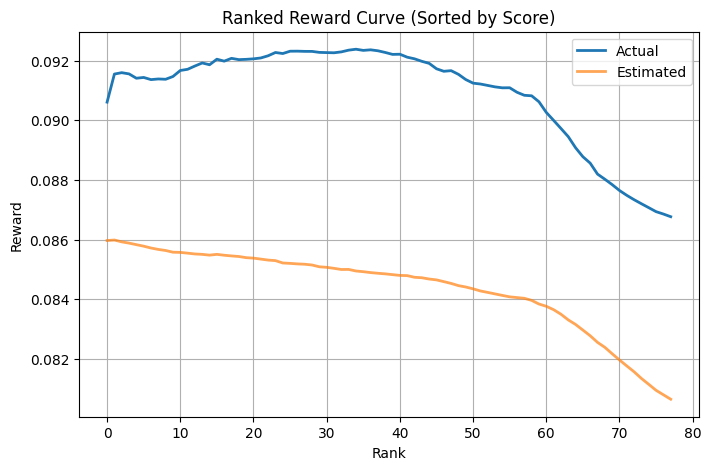

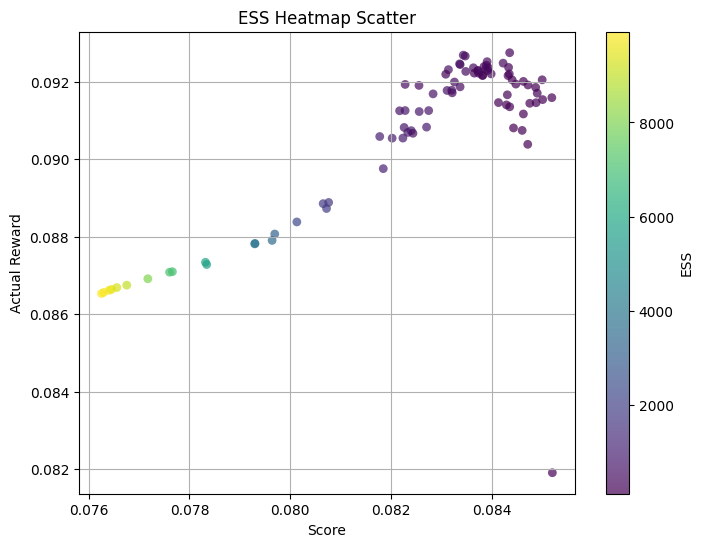

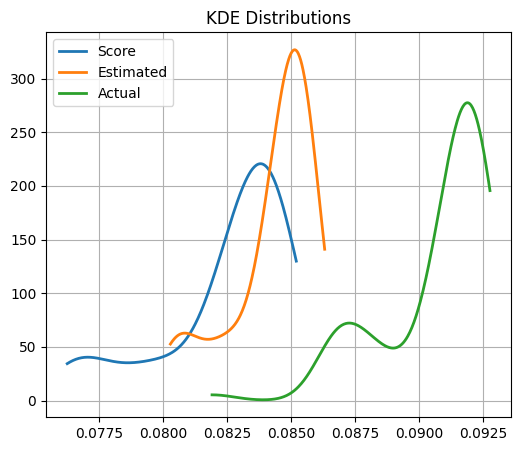

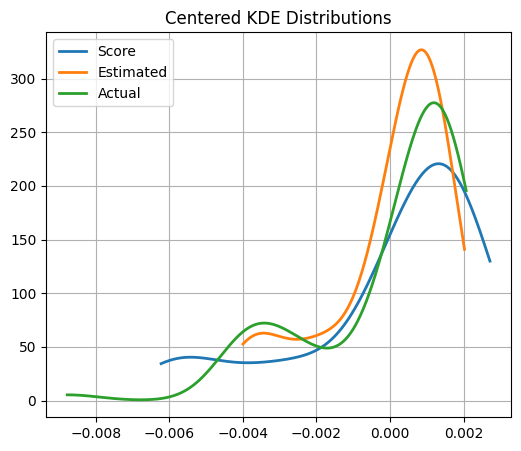

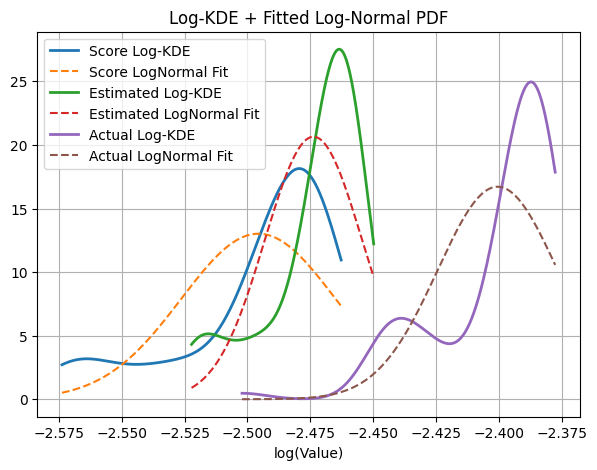

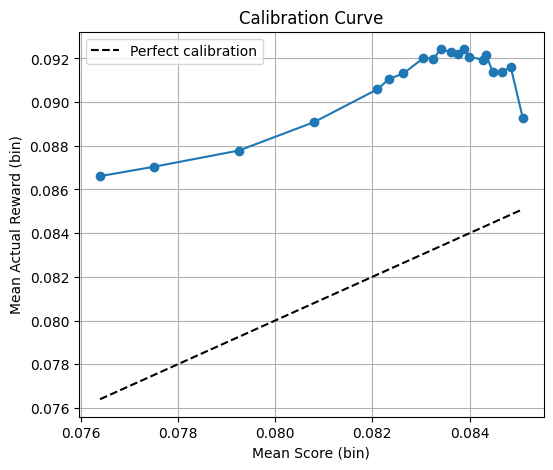

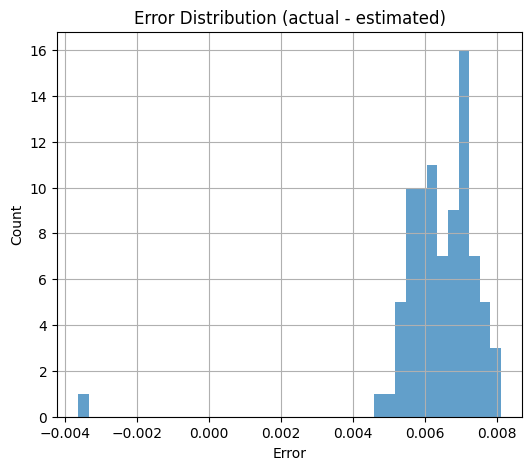

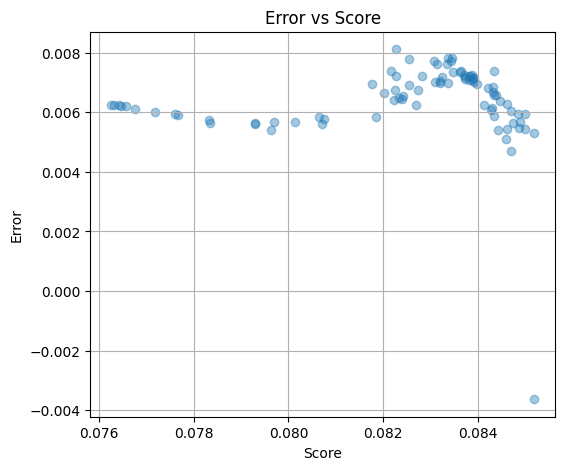

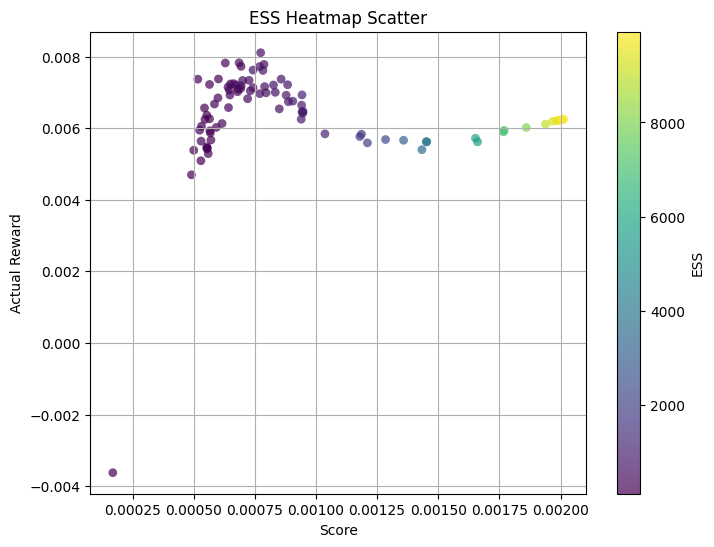

Correlation Metrics: {'pearson_score_actual': np.float64(0.7732184066741458), 'spearman_score_actual': np.float64(0.5759611302419926), 'spearman_est_actual': np.float64(0.594792207179584)}
NDCG Metrics: {'ndcg_score_actual': np.float64(0.9931786538721674), 'ndcg_est_actual': np.float64(0.9977147291964895)}
Error Metrics: {'mean_error': np.float64(0.0064037712225180725), 'mae': np.float64(0.006488113517882829), 'rmse': np.float64(0.00653897932423379), 'std_error': np.float64(0.0013228623255677012), 'max_error': np.float64(0.008111046670650823), 'min_error': np.float64(-0.0036267187006845114)}


In [26]:
compute_statistics_and_plots(study_df9)

In [27]:
all_dfs = pd.concat([study_df, study_df5, study_df6, study_df7, study_df8, study_df9], ignore_index=True)
all_dfs = all_dfs[all_dfs['value'] > 0]
# all_dfs['user_attrs_actual_reward'] = all_dfs['user_attrs_actual_reward'].apply(lambda x: x[0])

In [28]:
all_dfs.head(5)

value  user_attrs_actual_reward  user_attrs_q_error  user_attrs_r_hat  \
0 0.07594042                0.08612417          0.00200836        0.07995713   
1 0.07469097                0.08647323          0.00138454        0.07746005   
2 0.07516807                0.08622483          0.00185705        0.07888216   
3 0.07606118                0.08611405          0.00201297        0.08008712   
4 0.07544695                0.08617515          0.00194766        0.07934227   

   user_attrs_ess                             user_attrs_scores_dict  \
0  9,951.75418161  {'dr_naive_mean': 0.07995712950524923, 'dr_nai...   
1  3,876.18590573  {'dr_naive_mean': 0.0774600544435452, 'dr_naiv...   
2  8,325.30363328  {'dr_naive_mean': 0.07888216330160397, 'dr_nai...   
3  9,987.17032729  {'dr_naive_mean': 0.08008711773225637, 'dr_nai...   
4  9,307.67651210  {'dr_naive_mean': 0.07934226511494746, 'dr_nai...   

                               user_attrs_all_values  
0  [0.07995712950524923, 0.07992081212166426, 0.0...  
1  [0.0774600544435452, 0.07747298118490217, 0.07...  
2  [0.07888216330160397, 0.07895377584031758, 0.0...  
3  [0.08008711773225637, 0.0800685874534202, 0.07...  
4  [0.07934226511494746, 0.07928623139660983, 0.0...

In [29]:
from plots_and_stats import compute_statistics_and_plots
import pandas as pd

In [30]:
all_dfs.to_csv(f"trial_dfs/regression_model_opl_study_results_all_seeds_{n_trials_for_optuna}.csv", index=False)

In [31]:
all_dfs = pd.read_csv(f"regression_model_opl_study_results_all_seeds_{n_trials_for_optuna}.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'regression_model_opl_study_results_all_seeds_155.csv'

In [ ]:
compute_statistics_and_plots(all_dfs)